### experiments on real world data 

In [1]:
import logging
import os
import pickle
import random
import sys

# from bds.bbSampleTree import BranchAndBoundNaive
import time
from time import time

import gmpy2 as gmp
import matplotlib as mpl
import matplotlib.pyplot as plt

# from bds.bounds_utils import find_equivalence_classes
import numpy as np
import pandas as pd
from gmpy2 import mpfr, mpz

# from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
from pylab import axes, boxplot, figure, legend, plot, savefig, setp, show, xlim, ylim
from sklearn import datasets

from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive

# now we need to extract rules
from bds.fpgrowth import build_fptree, fpgrowth_on_tree, preprocess_transaction_list
from bds.gf2 import GF
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.utils import bin_array, bin_random, mpz_set_bits, randints, solutions_to_dict
from tests.utils import assert_close_mpfr, assert_dict_allclose

%cd ..



# from bds.cbb_v2 import *

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234

/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


In [2]:
def read_pickle(filepath_y):
    objects = []
    with open(filepath_y, "rb") as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects

array([False,  True, False, False, False, False, False,  True,  True,
       False,  True,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False, False,  True, False,  True, False, False, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False,  True,  True,  True,
        True, False, False, False,  True, False,  True, False,  True,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False, False,
        True, False,  True, False,  True,  True, False, False,  True,
       False, False,

##### read labels 

In [25]:
def compute_truthtable(X, itemset):
    """poorly optimized function"""
    support_list = []
    for i in range(X.shape[0]):
        if sum([X[i][j] for j in itemset]) == len(itemset):
            support_list.append(i)

    truthtable = mpz_set_bits(mpz(), support_list)

    return truthtable


dataset = "synthetic"

all_n_rules = []
lmbd = 0.1
ub = 0.65
rand_seed = 1234
n_reps = 1

delta = 0.8
eps = 0.8

show_progres = True
num_pts = 1000


# for delta in [0.2, 0.4, 0.6, 0.8, 0.9]:
#    for eps in [0.2, 0.4, 0.6, 0.8, 0.9]:
for delta in [0.4, 0.8]:
    for eps in [0.4, 0.8]:
        all_averages_times_MC = []
        all_averages_times_GT = []

        all_averages_counts_MC = []
        all_averages_counts_GT = []

        all_n_rules = [100, 200, 300, 400]

        # res_rows = []
        for num_rules in all_n_rules:
            #    rules = [Rule.random(i+1, num_pts) for i in range(num_rules)]
            rules = read_pickle("rules/rules_" + str(dataset) + "_" + str(n_rules))[0]

            # y = bin_random(num_pts)

            # for min_support in [5000, 4500, 4000, 3500]:

            #    print("min support " + str(min_support))

            #   ordered_input_data = preprocess_transaction_list(
            #       X_bag, min_support
            #   )
            #   tree = build_fptree(ordered_input_data)
            #   frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

            #   all_n_rules.append(len(frequent_itemsets))

            #  print(len(frequent_itemsets))

            # Now create rules
            # rules = []
            # for i,itemset in enumerate(frequent_itemsets):
            #    tt = compute_truthtable(X,itemset)
            #    this_Rule = Rule(id = i+1, name = "rule_" + str(i), cardinality=len(itemset), truthtable=tt)
            #    # we need the truthtable for this itemset
            #    rules.append(this_Rule)

            # pickle.dump(rules, open("rules/rules_" + dataset + "_" +  str(len(rules)), "wb" ))

            # approxMC
            all_times_MC = []
            all_counts_MC = []

            all_times_GT = []
            all_counts_GT = []

            for _ in range(n_reps):
                t = time.time()
                test_cnt = approx_mc2(
                    rules,
                    y,
                    lmbd=lmbd,
                    ub=ub,
                    delta=delta,
                    eps=eps,
                    rand_seed=rand_seed,
                    show_progress=show_progres,
                    parallel=False,
                    log_level=logging.WARN,
                )

                elapsed = time.time() - t
                all_times_MC.append(elapsed)
                all_counts_MC.append(test_cnt)

                # complete enumeration
                ref_count = get_ground_truth_count(rules, y, lmbd, ub)
                all_times_GT.append(elapsed)
                all_counts_GT.append(ref_count)

            all_averages_times_MC.append(np.mean(all_times_MC))
            all_averages_times_GT.append(np.mean(all_times_GT))

            all_averages_counts_MC.append(np.mean(all_counts_MC))
            all_averages_counts_GT.append(np.mean(all_counts_GT))

        pickle.dump(
            all_averages_times_MC,
            open(
                "all_averages_times_MC_"
                + dataset
                + "_"
                + str(len(rules))
                + "_"
                + str(eps)
                + "_"
                + str(delta),
                "wb",
            ),
        )
        pickle.dump(
            all_averages_times_GT,
            open(
                "all_averages_times_GT_"
                + dataset
                + "_"
                + str(len(rules))
                + "_"
                + str(eps)
                + "_"
                + str(delta),
                "wb",
            ),
        )

        pickle.dump(
            all_averages_counts_MC,
            open(
                "all_averages_counts_MC_"
                + dataset
                + "_"
                + "_"
                + str(len(rules))
                + "_"
                + str(eps)
                + "_"
                + str(delta),
                "wb",
            ),
        )
        pickle.dump(
            all_averages_counts_GT,
            open(
                "all_averages_counts_GT_"
                + dataset
                + "_"
                + str(len(rules))
                + "_"
                + str(eps)
                + "_"
                + str(delta),
                "wb",
            ),
        )

[D 230711 17:34:54 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 17:34:54 meel:363] thresh = 155.98
[D 230711 17:34:54 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:34:54 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:34:54 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:34:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:54 meel:278] initial solving under 399 constraints
[D 230711 17:34:54 cbb:160] setting up the parity constraint system
[D 230711 17:34:54 cbb:129] simplifying A x = t using rref
[D 230711 17:34:54 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:34:54 meel:281] solving takes 0.10 secs
[D 230711 17:34:54 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:34:54 meel:98] callin

rand_seed: 822569775


[D 230711 17:34:55 meel:149] search tree size: 1020
[D 230711 17:34:55 meel:150] number of prefix evaluations: 168411
[D 230711 17:34:55 meel:152] solving takes 0.73 secs
[D 230711 17:34:55 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:34:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:55 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:34:55 meel:413] num_cells: 4, num_sols: 87
  2%|▉                                           | 1/49 [00:00<00:41,  1.15it/s][D 230711 17:34:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:55 meel:278] initial solving under 399 constraints
[D 230711 17:34:55 cbb:160] setting up the parity constraint system
[D 230711 17:34:55 cbb:129] simplifying A x = t using rref
[D 230711 17:34:55 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:34:55 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:34:55 meel:281] solving takes 0.08 secs
[D 230711 17:34:55 meel:288] with |Y| 

time_cost_info: 
|1|0.018080325004120823|
|2|0.7327671340026427|
rand_seed: 2137449171


[D 230711 17:34:56 meel:149] search tree size: 1000
[D 230711 17:34:56 meel:150] number of prefix evaluations: 163942
[D 230711 17:34:56 meel:152] solving takes 0.76 secs
[D 230711 17:34:56 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:34:56 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:56 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:34:56 meel:413] num_cells: 4, num_sols: 94
  4%|█▊                                          | 2/49 [00:01<00:40,  1.15it/s][D 230711 17:34:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:56 meel:278] initial solving under 399 constraints
[D 230711 17:34:56 cbb:160] setting up the parity constraint system
[D 230711 17:34:56 cbb:129] simplifying A x = t using rref
[D 230711 17:34:56 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:34:56 meel:281] solving takes 0.09 secs
[D 230711 17:34:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015851509000640363|
|2|0.7625674000009894|
rand_seed: 524453158


[D 230711 17:34:57 meel:149] search tree size: 1008
[D 230711 17:34:57 meel:150] number of prefix evaluations: 163919
[D 230711 17:34:57 meel:152] solving takes 0.87 secs
[D 230711 17:34:57 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:34:57 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:57 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:34:57 meel:413] num_cells: 4, num_sols: 121
  6%|██▋                                         | 3/49 [00:02<00:42,  1.09it/s][D 230711 17:34:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:57 meel:278] initial solving under 399 constraints
[D 230711 17:34:57 cbb:160] setting up the parity constraint system
[D 230711 17:34:57 cbb:129] simplifying A x = t using rref
[D 230711 17:34:57 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:34:57 meel:281] solving takes 0.08 secs
[D 230711 17:34:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01467219599726377|
|2|0.8681719789965427|
rand_seed: 1365105717


[D 230711 17:34:58 meel:149] search tree size: 1021
[D 230711 17:34:58 meel:150] number of prefix evaluations: 169082
[D 230711 17:34:58 meel:152] solving takes 0.74 secs
[D 230711 17:34:58 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:34:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:58 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:34:58 meel:413] num_cells: 4, num_sols: 97
  8%|███▌                                        | 4/49 [00:03<00:40,  1.12it/s][D 230711 17:34:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:58 meel:278] initial solving under 399 constraints
[D 230711 17:34:58 cbb:160] setting up the parity constraint system
[D 230711 17:34:58 cbb:129] simplifying A x = t using rref
[D 230711 17:34:58 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:34:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:34:58 meel:281] solving takes 0.08 secs
[D 230711 17:34:58 meel:288] with |Y| 

time_cost_info: 
|1|0.015986281003279146|
|2|0.7395044910008437|
rand_seed: 1880026316


[D 230711 17:34:58 meel:149] search tree size: 993
[D 230711 17:34:58 meel:150] number of prefix evaluations: 163874
[D 230711 17:34:58 meel:152] solving takes 0.75 secs
[D 230711 17:34:58 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:34:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:58 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:34:58 meel:413] num_cells: 4, num_sols: 126
 10%|████▍                                       | 5/49 [00:04<00:38,  1.14it/s][D 230711 17:34:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:58 meel:278] initial solving under 399 constraints
[D 230711 17:34:58 cbb:160] setting up the parity constraint system
[D 230711 17:34:58 cbb:129] simplifying A x = t using rref
[D 230711 17:34:58 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:34:58 meel:281] solving takes 0.08 secs
[D 230711 17:34:58 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.012755521995131858|
|2|0.7472245039971313|
rand_seed: 481516916


[D 230711 17:34:59 meel:149] search tree size: 998
[D 230711 17:34:59 meel:150] number of prefix evaluations: 163914
[D 230711 17:34:59 meel:152] solving takes 0.74 secs
[D 230711 17:34:59 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:34:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:34:59 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:34:59 meel:413] num_cells: 4, num_sols: 96
 12%|█████▍                                      | 6/49 [00:05<00:37,  1.16it/s][D 230711 17:34:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:34:59 meel:278] initial solving under 399 constraints
[D 230711 17:34:59 cbb:160] setting up the parity constraint system
[D 230711 17:34:59 cbb:129] simplifying A x = t using rref
[D 230711 17:34:59 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:34:59 meel:281] solving takes 0.08 secs
[D 230711 17:34:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.015212991995213088|
|2|0.7390352150032413|
rand_seed: 1225605784


[D 230711 17:35:00 meel:149] search tree size: 1021
[D 230711 17:35:00 meel:150] number of prefix evaluations: 169355
[D 230711 17:35:00 meel:152] solving takes 0.76 secs
[D 230711 17:35:00 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:35:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:00 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:35:00 meel:413] num_cells: 4, num_sols: 105
 14%|██████▎                                     | 7/49 [00:06<00:36,  1.16it/s][D 230711 17:35:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:00 meel:278] initial solving under 399 constraints
[D 230711 17:35:00 cbb:160] setting up the parity constraint system
[D 230711 17:35:00 cbb:129] simplifying A x = t using rref
[D 230711 17:35:00 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:35:00 meel:281] solving takes 0.08 secs
[D 230711 17:35:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013958932999230456|
|2|0.7580168069980573|
rand_seed: 1165481977


[D 230711 17:35:01 meel:149] search tree size: 995
[D 230711 17:35:01 meel:150] number of prefix evaluations: 163929
[D 230711 17:35:01 meel:152] solving takes 0.81 secs
[D 230711 17:35:01 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:35:01 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:01 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:01 meel:413] num_cells: 4, num_sols: 98
 16%|███████▏                                    | 8/49 [00:07<00:36,  1.13it/s][D 230711 17:35:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:01 meel:278] initial solving under 399 constraints
[D 230711 17:35:01 cbb:160] setting up the parity constraint system
[D 230711 17:35:01 cbb:129] simplifying A x = t using rref
[D 230711 17:35:01 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:35:01 meel:281] solving takes 0.08 secs
[D 230711 17:35:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.016516067997145|
|2|0.8107779120036867|
rand_seed: 1202486927


[D 230711 17:35:02 meel:149] search tree size: 1031
[D 230711 17:35:02 meel:150] number of prefix evaluations: 168938
[D 230711 17:35:02 meel:152] solving takes 0.79 secs
[D 230711 17:35:02 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:35:02 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:02 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:35:02 meel:413] num_cells: 4, num_sols: 105
 18%|████████                                    | 9/49 [00:07<00:35,  1.13it/s][D 230711 17:35:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:02 meel:278] initial solving under 399 constraints
[D 230711 17:35:02 cbb:160] setting up the parity constraint system
[D 230711 17:35:02 cbb:129] simplifying A x = t using rref
[D 230711 17:35:02 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:35:02 meel:281] solving takes 0.11 secs
[D 230711 17:35:02 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014064670001971535|
|2|0.7853424109998741|
rand_seed: 1549064881


[D 230711 17:35:03 meel:149] search tree size: 1032
[D 230711 17:35:03 meel:150] number of prefix evaluations: 169088
[D 230711 17:35:03 meel:152] solving takes 0.86 secs
[D 230711 17:35:03 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:35:03 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:03 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:35:03 meel:413] num_cells: 4, num_sols: 92
 20%|████████▊                                  | 10/49 [00:08<00:36,  1.08it/s][D 230711 17:35:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:03 meel:278] initial solving under 399 constraints
[D 230711 17:35:03 cbb:160] setting up the parity constraint system
[D 230711 17:35:03 cbb:129] simplifying A x = t using rref
[D 230711 17:35:03 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:35:03 meel:281] solving takes 0.11 secs
[D 230711 17:35:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.02566963999561267|
|2|0.8635479860022315|
rand_seed: 1170776343


[D 230711 17:35:04 meel:149] search tree size: 1024
[D 230711 17:35:04 meel:150] number of prefix evaluations: 169050
[D 230711 17:35:04 meel:152] solving takes 0.81 secs
[D 230711 17:35:04 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:35:04 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:04 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:35:04 meel:413] num_cells: 4, num_sols: 116
 22%|█████████▋                                 | 11/49 [00:09<00:35,  1.07it/s][D 230711 17:35:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:04 meel:278] initial solving under 399 constraints
[D 230711 17:35:04 cbb:160] setting up the parity constraint system
[D 230711 17:35:04 cbb:129] simplifying A x = t using rref
[D 230711 17:35:04 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:35:04 meel:281] solving takes 0.08 secs
[D 230711 17:35:04 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02050122599757742|
|2|0.8139836599948467|
rand_seed: 646980841


[D 230711 17:35:05 meel:149] search tree size: 1021
[D 230711 17:35:05 meel:150] number of prefix evaluations: 169074
[D 230711 17:35:05 meel:152] solving takes 0.79 secs
[D 230711 17:35:05 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:35:05 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:05 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:35:05 meel:413] num_cells: 4, num_sols: 95
 24%|██████████▌                                | 12/49 [00:10<00:34,  1.08it/s][D 230711 17:35:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:05 meel:278] initial solving under 399 constraints
[D 230711 17:35:05 cbb:160] setting up the parity constraint system
[D 230711 17:35:05 cbb:129] simplifying A x = t using rref
[D 230711 17:35:05 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:35:05 meel:281] solving takes 0.09 secs
[D 230711 17:35:05 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016209399000217672|
|2|0.7896497039982933|
rand_seed: 1187404954


[D 230711 17:35:06 meel:149] search tree size: 1003
[D 230711 17:35:06 meel:150] number of prefix evaluations: 163905
[D 230711 17:35:06 meel:152] solving takes 0.88 secs
[D 230711 17:35:06 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:35:06 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:06 meel:410] running approx_mc2_core takes 1.01s
[D 230711 17:35:06 meel:413] num_cells: 4, num_sols: 97
 27%|███████████▍                               | 13/49 [00:11<00:34,  1.05it/s][D 230711 17:35:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:06 meel:278] initial solving under 399 constraints
[D 230711 17:35:06 cbb:160] setting up the parity constraint system
[D 230711 17:35:06 cbb:129] simplifying A x = t using rref
[D 230711 17:35:06 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:35:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:06 meel:281] solving takes 0.09 secs
[D 230711 17:35:06 meel:288] with |Y| 

time_cost_info: 
|1|0.025553620005666744|
|2|0.8817224599988549|
rand_seed: 852631582


[D 230711 17:35:07 meel:149] search tree size: 1018
[D 230711 17:35:07 meel:150] number of prefix evaluations: 169078
[D 230711 17:35:07 meel:152] solving takes 0.83 secs
[D 230711 17:35:07 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:35:07 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:07 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:35:07 meel:413] num_cells: 4, num_sols: 106
 29%|████████████▎                              | 14/49 [00:12<00:33,  1.05it/s][D 230711 17:35:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:07 meel:278] initial solving under 399 constraints
[D 230711 17:35:07 cbb:160] setting up the parity constraint system
[D 230711 17:35:07 cbb:129] simplifying A x = t using rref
[D 230711 17:35:07 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:35:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:07 meel:281] solving takes 0.08 secs
[D 230711 17:35:07 meel:288] with |Y

time_cost_info: 
|1|0.015941573001327924|
|2|0.8343897609956912|
rand_seed: 1296531115


[D 230711 17:35:08 meel:149] search tree size: 993
[D 230711 17:35:08 meel:150] number of prefix evaluations: 164173
[D 230711 17:35:08 meel:152] solving takes 0.79 secs
[D 230711 17:35:08 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:35:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:08 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:35:08 meel:413] num_cells: 4, num_sols: 108
 31%|█████████████▏                             | 15/49 [00:13<00:31,  1.07it/s][D 230711 17:35:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:08 meel:278] initial solving under 399 constraints
[D 230711 17:35:08 cbb:160] setting up the parity constraint system
[D 230711 17:35:08 cbb:129] simplifying A x = t using rref
[D 230711 17:35:08 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:35:08 meel:281] solving takes 0.09 secs
[D 230711 17:35:08 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01526303600257961|
|2|0.7879953689989634|
rand_seed: 1353614494


[D 230711 17:35:09 meel:149] search tree size: 1032
[D 230711 17:35:09 meel:150] number of prefix evaluations: 168926
[D 230711 17:35:09 meel:152] solving takes 0.78 secs
[D 230711 17:35:09 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:35:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:09 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:35:09 meel:413] num_cells: 4, num_sols: 104
 33%|██████████████                             | 16/49 [00:14<00:30,  1.08it/s][D 230711 17:35:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:09 meel:278] initial solving under 399 constraints
[D 230711 17:35:09 cbb:160] setting up the parity constraint system
[D 230711 17:35:09 cbb:129] simplifying A x = t using rref
[D 230711 17:35:09 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:35:09 meel:281] solving takes 0.08 secs
[D 230711 17:35:09 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016327078999893274|
|2|0.7780348790038261|
rand_seed: 1967693548


[D 230711 17:35:09 meel:149] search tree size: 1025
[D 230711 17:35:09 meel:150] number of prefix evaluations: 169068
[D 230711 17:35:09 meel:152] solving takes 0.77 secs
[D 230711 17:35:09 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:35:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:09 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:35:09 meel:413] num_cells: 4, num_sols: 98
 35%|██████████████▉                            | 17/49 [00:15<00:29,  1.10it/s][D 230711 17:35:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:09 meel:278] initial solving under 399 constraints
[D 230711 17:35:09 cbb:160] setting up the parity constraint system
[D 230711 17:35:09 cbb:129] simplifying A x = t using rref
[D 230711 17:35:10 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:35:10 meel:281] solving takes 0.07 secs
[D 230711 17:35:10 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012251731001015287|
|2|0.76502076399629|
rand_seed: 682106748


[D 230711 17:35:10 meel:149] search tree size: 1002
[D 230711 17:35:10 meel:150] number of prefix evaluations: 163445
[D 230711 17:35:10 meel:152] solving takes 0.75 secs
[D 230711 17:35:10 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:35:10 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:10 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:35:10 meel:413] num_cells: 4, num_sols: 102
 37%|███████████████▊                           | 18/49 [00:16<00:27,  1.13it/s][D 230711 17:35:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:10 meel:278] initial solving under 399 constraints
[D 230711 17:35:10 cbb:160] setting up the parity constraint system
[D 230711 17:35:10 cbb:129] simplifying A x = t using rref
[D 230711 17:35:10 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:35:10 meel:281] solving takes 0.08 secs
[D 230711 17:35:10 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012195395996968728|
|2|0.7477201940055238|
rand_seed: 1614618394


[D 230711 17:35:11 meel:149] search tree size: 1035
[D 230711 17:35:11 meel:150] number of prefix evaluations: 169824
[D 230711 17:35:11 meel:152] solving takes 0.76 secs
[D 230711 17:35:11 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:35:11 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:11 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:11 meel:413] num_cells: 4, num_sols: 87
 39%|████████████████▋                          | 19/49 [00:17<00:26,  1.14it/s][D 230711 17:35:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:11 meel:278] initial solving under 399 constraints
[D 230711 17:35:11 cbb:160] setting up the parity constraint system
[D 230711 17:35:11 cbb:129] simplifying A x = t using rref
[D 230711 17:35:11 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:35:11 meel:281] solving takes 0.08 secs
[D 230711 17:35:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012556487003166694|
|2|0.7561782080010744|
rand_seed: 498808182


[D 230711 17:35:12 meel:149] search tree size: 1005
[D 230711 17:35:12 meel:150] number of prefix evaluations: 163450
[D 230711 17:35:12 meel:152] solving takes 0.77 secs
[D 230711 17:35:12 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:35:12 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:12 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:35:12 meel:413] num_cells: 4, num_sols: 110
 41%|█████████████████▌                         | 20/49 [00:18<00:25,  1.14it/s][D 230711 17:35:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:12 meel:278] initial solving under 399 constraints
[D 230711 17:35:12 cbb:160] setting up the parity constraint system
[D 230711 17:35:12 cbb:129] simplifying A x = t using rref
[D 230711 17:35:12 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:35:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:12 meel:281] solving takes 0.08 secs
[D 230711 17:35:12 meel:288] with |Y

time_cost_info: 
|1|0.012116985002649017|
|2|0.7666873709968058|
rand_seed: 1536813498


[D 230711 17:35:13 meel:149] search tree size: 999
[D 230711 17:35:13 meel:150] number of prefix evaluations: 164195
[D 230711 17:35:13 meel:152] solving takes 0.81 secs
[D 230711 17:35:13 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:35:13 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:13 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:13 meel:413] num_cells: 4, num_sols: 115
 43%|██████████████████▍                        | 21/49 [00:18<00:24,  1.13it/s][D 230711 17:35:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:13 meel:278] initial solving under 399 constraints
[D 230711 17:35:13 cbb:160] setting up the parity constraint system
[D 230711 17:35:13 cbb:129] simplifying A x = t using rref
[D 230711 17:35:13 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:35:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:13 meel:281] solving takes 0.08 secs
[D 230711 17:35:13 meel:288] with |Y|

time_cost_info: 
|1|0.01337355899886461|
|2|0.8147367440033122|
rand_seed: 55437432


[D 230711 17:35:14 meel:149] search tree size: 998
[D 230711 17:35:14 meel:150] number of prefix evaluations: 163436
[D 230711 17:35:14 meel:152] solving takes 0.82 secs
[D 230711 17:35:14 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:35:14 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:14 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:14 meel:413] num_cells: 4, num_sols: 85
 45%|███████████████████▎                       | 22/49 [00:19<00:24,  1.11it/s][D 230711 17:35:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:14 meel:278] initial solving under 399 constraints
[D 230711 17:35:14 cbb:160] setting up the parity constraint system
[D 230711 17:35:14 cbb:129] simplifying A x = t using rref
[D 230711 17:35:14 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:35:14 meel:281] solving takes 0.09 secs
[D 230711 17:35:14 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.012278802001674194|
|2|0.816618455995922|
rand_seed: 4274032


[D 230711 17:35:15 meel:149] search tree size: 1014
[D 230711 17:35:15 meel:150] number of prefix evaluations: 168365
[D 230711 17:35:15 meel:152] solving takes 0.90 secs
[D 230711 17:35:15 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:35:15 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:15 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:35:15 meel:413] num_cells: 4, num_sols: 112
 47%|████████████████████▏                      | 23/49 [00:20<00:24,  1.07it/s][D 230711 17:35:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:15 meel:278] initial solving under 399 constraints
[D 230711 17:35:15 cbb:160] setting up the parity constraint system
[D 230711 17:35:15 cbb:129] simplifying A x = t using rref
[D 230711 17:35:15 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:35:15 meel:281] solving takes 0.09 secs
[D 230711 17:35:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01515395400201669|
|2|0.90431366199482|
rand_seed: 2090933724


[D 230711 17:35:16 meel:149] search tree size: 1032
[D 230711 17:35:16 meel:150] number of prefix evaluations: 169080
[D 230711 17:35:16 meel:152] solving takes 0.85 secs
[D 230711 17:35:16 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:35:16 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:16 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:35:16 meel:413] num_cells: 4, num_sols: 115
 49%|█████████████████████                      | 24/49 [00:21<00:23,  1.06it/s][D 230711 17:35:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:16 meel:278] initial solving under 399 constraints
[D 230711 17:35:16 cbb:160] setting up the parity constraint system
[D 230711 17:35:16 cbb:129] simplifying A x = t using rref
[D 230711 17:35:16 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:35:16 meel:281] solving takes 0.12 secs
[D 230711 17:35:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015394255999126472|
|2|0.8537523439954384|
rand_seed: 787967301


[D 230711 17:35:17 meel:149] search tree size: 1028
[D 230711 17:35:17 meel:150] number of prefix evaluations: 168446
[D 230711 17:35:17 meel:152] solving takes 0.87 secs
[D 230711 17:35:17 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:35:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:17 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:35:17 meel:413] num_cells: 4, num_sols: 108
 51%|█████████████████████▉                     | 25/49 [00:22<00:23,  1.03it/s][D 230711 17:35:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:17 meel:278] initial solving under 399 constraints
[D 230711 17:35:17 cbb:160] setting up the parity constraint system
[D 230711 17:35:17 cbb:129] simplifying A x = t using rref
[D 230711 17:35:17 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:35:17 meel:281] solving takes 0.09 secs
[D 230711 17:35:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.017633768999075983|
|2|0.8734898700058693|
rand_seed: 1421700432


[D 230711 17:35:18 meel:149] search tree size: 1008
[D 230711 17:35:18 meel:150] number of prefix evaluations: 163919
[D 230711 17:35:18 meel:152] solving takes 0.83 secs
[D 230711 17:35:18 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:35:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:18 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:35:18 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 26/49 [00:23<00:22,  1.04it/s][D 230711 17:35:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:18 meel:278] initial solving under 399 constraints
[D 230711 17:35:18 cbb:160] setting up the parity constraint system
[D 230711 17:35:18 cbb:129] simplifying A x = t using rref
[D 230711 17:35:18 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:35:18 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:18 meel:281] solving takes 0.08 secs
[D 230711 17:35:18 meel:288] with |Y| 

time_cost_info: 
|1|0.021333021999453194|
|2|0.8292027749994304|
rand_seed: 913548233


[D 230711 17:35:19 meel:149] search tree size: 1026
[D 230711 17:35:19 meel:150] number of prefix evaluations: 169051
[D 230711 17:35:19 meel:152] solving takes 0.82 secs
[D 230711 17:35:19 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:35:19 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:19 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:35:19 meel:413] num_cells: 4, num_sols: 117
 55%|███████████████████████▋                   | 27/49 [00:24<00:20,  1.05it/s][D 230711 17:35:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:19 meel:278] initial solving under 399 constraints
[D 230711 17:35:19 cbb:160] setting up the parity constraint system
[D 230711 17:35:19 cbb:129] simplifying A x = t using rref
[D 230711 17:35:19 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:35:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:19 meel:281] solving takes 0.08 secs
[D 230711 17:35:19 meel:288] with |Y

time_cost_info: 
|1|0.011589205998461694|
|2|0.8172200580011122|
rand_seed: 1299827071


[D 230711 17:35:20 meel:149] search tree size: 1021
[D 230711 17:35:20 meel:150] number of prefix evaluations: 169799
[D 230711 17:35:20 meel:152] solving takes 0.77 secs
[D 230711 17:35:20 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:35:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:20 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:35:20 meel:413] num_cells: 4, num_sols: 109
 57%|████████████████████████▌                  | 28/49 [00:25<00:19,  1.07it/s][D 230711 17:35:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:20 meel:278] initial solving under 399 constraints
[D 230711 17:35:20 cbb:160] setting up the parity constraint system
[D 230711 17:35:20 cbb:129] simplifying A x = t using rref
[D 230711 17:35:20 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:35:20 meel:281] solving takes 0.11 secs
[D 230711 17:35:20 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02147066199540859|
|2|0.7730458590012859|
rand_seed: 1590214902


[D 230711 17:35:21 meel:149] search tree size: 1002
[D 230711 17:35:21 meel:150] number of prefix evaluations: 164177
[D 230711 17:35:21 meel:152] solving takes 0.78 secs
[D 230711 17:35:21 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:35:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:21 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:21 meel:413] num_cells: 4, num_sols: 103
 59%|█████████████████████████▍                 | 29/49 [00:26<00:18,  1.08it/s][D 230711 17:35:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:21 meel:278] initial solving under 399 constraints
[D 230711 17:35:21 cbb:160] setting up the parity constraint system
[D 230711 17:35:21 cbb:129] simplifying A x = t using rref
[D 230711 17:35:21 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:35:21 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:21 meel:281] solving takes 0.08 secs
[D 230711 17:35:21 meel:288] with |Y

time_cost_info: 
|1|0.014505293998809066|
|2|0.7789879100018879|
rand_seed: 421988862


[D 230711 17:35:21 meel:149] search tree size: 1035
[D 230711 17:35:21 meel:150] number of prefix evaluations: 169856
[D 230711 17:35:21 meel:152] solving takes 0.77 secs
[D 230711 17:35:21 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:35:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:21 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:21 meel:413] num_cells: 4, num_sols: 101
 61%|██████████████████████████▎                | 30/49 [00:27<00:17,  1.09it/s][D 230711 17:35:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:21 meel:278] initial solving under 399 constraints
[D 230711 17:35:21 cbb:160] setting up the parity constraint system
[D 230711 17:35:21 cbb:129] simplifying A x = t using rref
[D 230711 17:35:21 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:35:22 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:22 meel:281] solving takes 0.08 secs
[D 230711 17:35:22 meel:288] with |Y

time_cost_info: 
|1|0.01793566300329985|
|2|0.7749885259981966|
rand_seed: 262835631


[D 230711 17:35:22 meel:149] search tree size: 1008
[D 230711 17:35:22 meel:150] number of prefix evaluations: 164166
[D 230711 17:35:22 meel:152] solving takes 0.81 secs
[D 230711 17:35:22 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:35:22 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:22 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:22 meel:413] num_cells: 4, num_sols: 109
 63%|███████████████████████████▏               | 31/49 [00:28<00:16,  1.09it/s][D 230711 17:35:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:22 meel:278] initial solving under 399 constraints
[D 230711 17:35:22 cbb:160] setting up the parity constraint system
[D 230711 17:35:22 cbb:129] simplifying A x = t using rref
[D 230711 17:35:22 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:35:22 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:22 meel:281] solving takes 0.08 secs
[D 230711 17:35:22 meel:288] with |Y

time_cost_info: 
|1|0.0136602229977143|
|2|0.8140386640006909|
rand_seed: 240490034


[D 230711 17:35:23 meel:149] search tree size: 1008
[D 230711 17:35:23 meel:150] number of prefix evaluations: 163917
[D 230711 17:35:23 meel:152] solving takes 0.77 secs
[D 230711 17:35:23 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:35:23 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:23 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:23 meel:413] num_cells: 4, num_sols: 104
 65%|████████████████████████████               | 32/49 [00:29<00:15,  1.10it/s][D 230711 17:35:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:23 meel:278] initial solving under 399 constraints
[D 230711 17:35:23 cbb:160] setting up the parity constraint system
[D 230711 17:35:23 cbb:129] simplifying A x = t using rref
[D 230711 17:35:23 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:35:23 meel:281] solving takes 0.08 secs
[D 230711 17:35:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014762224003789015|
|2|0.7736898229995859|
rand_seed: 13242096


[D 230711 17:35:24 meel:149] search tree size: 1008
[D 230711 17:35:24 meel:150] number of prefix evaluations: 163912
[D 230711 17:35:24 meel:152] solving takes 0.79 secs
[D 230711 17:35:24 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:35:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:24 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:24 meel:413] num_cells: 4, num_sols: 101
 67%|████████████████████████████▉              | 33/49 [00:30<00:14,  1.11it/s][D 230711 17:35:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:24 meel:278] initial solving under 399 constraints
[D 230711 17:35:24 cbb:160] setting up the parity constraint system
[D 230711 17:35:24 cbb:129] simplifying A x = t using rref
[D 230711 17:35:24 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:35:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:24 meel:281] solving takes 0.10 secs
[D 230711 17:35:24 meel:288] with |Y

time_cost_info: 
|1|0.011916632996872067|
|2|0.7873524979950162|
rand_seed: 1901221627


[D 230711 17:35:25 meel:149] search tree size: 1027
[D 230711 17:35:25 meel:150] number of prefix evaluations: 169377
[D 230711 17:35:25 meel:152] solving takes 0.82 secs
[D 230711 17:35:25 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:35:25 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:25 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:35:25 meel:413] num_cells: 4, num_sols: 108
 69%|█████████████████████████████▊             | 34/49 [00:31<00:13,  1.09it/s][D 230711 17:35:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:25 meel:278] initial solving under 399 constraints
[D 230711 17:35:25 cbb:160] setting up the parity constraint system
[D 230711 17:35:25 cbb:129] simplifying A x = t using rref
[D 230711 17:35:25 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:35:25 meel:281] solving takes 0.08 secs
[D 230711 17:35:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016118824998557102|
|2|0.8157768020028016|
rand_seed: 59135052


[D 230711 17:35:26 meel:149] search tree size: 1031
[D 230711 17:35:26 meel:150] number of prefix evaluations: 169088
[D 230711 17:35:26 meel:152] solving takes 0.77 secs
[D 230711 17:35:26 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:35:26 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:26 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:35:26 meel:413] num_cells: 4, num_sols: 110
 71%|██████████████████████████████▋            | 35/49 [00:31<00:12,  1.11it/s][D 230711 17:35:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:26 meel:278] initial solving under 399 constraints
[D 230711 17:35:26 cbb:160] setting up the parity constraint system
[D 230711 17:35:26 cbb:129] simplifying A x = t using rref
[D 230711 17:35:26 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:35:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:26 meel:281] solving takes 0.12 secs
[D 230711 17:35:26 meel:288] with |Y

time_cost_info: 
|1|0.013418049005849753|
|2|0.7669040490000043|
rand_seed: 95107365


[D 230711 17:35:27 meel:149] search tree size: 1024
[D 230711 17:35:27 meel:150] number of prefix evaluations: 169844
[D 230711 17:35:27 meel:152] solving takes 0.88 secs
[D 230711 17:35:27 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:35:27 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:27 meel:410] running approx_mc2_core takes 1.03s
[D 230711 17:35:27 meel:413] num_cells: 4, num_sols: 103
 73%|███████████████████████████████▌           | 36/49 [00:32<00:12,  1.06it/s][D 230711 17:35:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:27 meel:278] initial solving under 399 constraints
[D 230711 17:35:27 cbb:160] setting up the parity constraint system
[D 230711 17:35:27 cbb:129] simplifying A x = t using rref
[D 230711 17:35:27 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:35:27 meel:281] solving takes 0.09 secs
[D 230711 17:35:27 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02164145999995526|
|2|0.8758347490002052|
rand_seed: 1171781410


[D 230711 17:35:28 meel:149] search tree size: 1022
[D 230711 17:35:28 meel:150] number of prefix evaluations: 170067
[D 230711 17:35:28 meel:152] solving takes 0.80 secs
[D 230711 17:35:28 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:35:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:28 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:28 meel:413] num_cells: 4, num_sols: 101
 76%|████████████████████████████████▍          | 37/49 [00:33<00:11,  1.07it/s][D 230711 17:35:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:28 meel:278] initial solving under 399 constraints
[D 230711 17:35:28 cbb:160] setting up the parity constraint system
[D 230711 17:35:28 cbb:129] simplifying A x = t using rref
[D 230711 17:35:28 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:35:28 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:28 meel:281] solving takes 0.08 secs
[D 230711 17:35:28 meel:288] with |Y

time_cost_info: 
|1|0.012988638001843356|
|2|0.8039441619985155|
rand_seed: 1248669606


[D 230711 17:35:29 meel:149] search tree size: 1002
[D 230711 17:35:29 meel:150] number of prefix evaluations: 164163
[D 230711 17:35:29 meel:152] solving takes 0.78 secs
[D 230711 17:35:29 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:35:29 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:29 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:29 meel:413] num_cells: 4, num_sols: 95
 78%|█████████████████████████████████▎         | 38/49 [00:34<00:10,  1.09it/s][D 230711 17:35:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:29 meel:278] initial solving under 399 constraints
[D 230711 17:35:29 cbb:160] setting up the parity constraint system
[D 230711 17:35:29 cbb:129] simplifying A x = t using rref
[D 230711 17:35:29 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:35:29 meel:281] solving takes 0.08 secs
[D 230711 17:35:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011469270000816323|
|2|0.7786040669961949|
rand_seed: 1643431418


[D 230711 17:35:30 meel:149] search tree size: 1016
[D 230711 17:35:30 meel:150] number of prefix evaluations: 169077
[D 230711 17:35:30 meel:152] solving takes 0.77 secs
[D 230711 17:35:30 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:35:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:30 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:35:30 meel:413] num_cells: 4, num_sols: 95
 80%|██████████████████████████████████▏        | 39/49 [00:35<00:09,  1.10it/s][D 230711 17:35:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:30 meel:278] initial solving under 399 constraints
[D 230711 17:35:30 cbb:160] setting up the parity constraint system
[D 230711 17:35:30 cbb:129] simplifying A x = t using rref
[D 230711 17:35:30 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:35:30 meel:281] solving takes 0.08 secs
[D 230711 17:35:30 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012650131997361314|
|2|0.7705449529967154|
rand_seed: 1058256067


[D 230711 17:35:30 meel:149] search tree size: 997
[D 230711 17:35:30 meel:150] number of prefix evaluations: 163926
[D 230711 17:35:30 meel:152] solving takes 0.75 secs
[D 230711 17:35:30 meel:196] |Y| < thresh (91 < 155)
[D 230711 17:35:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:30 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:30 meel:413] num_cells: 4, num_sols: 91
 82%|███████████████████████████████████        | 40/49 [00:36<00:08,  1.12it/s][D 230711 17:35:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:30 meel:278] initial solving under 399 constraints
[D 230711 17:35:30 cbb:160] setting up the parity constraint system
[D 230711 17:35:30 cbb:129] simplifying A x = t using rref
[D 230711 17:35:31 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:35:31 meel:281] solving takes 0.08 secs
[D 230711 17:35:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.011996103996352758|
|2|0.7521240939968266|
rand_seed: 1567173351


[D 230711 17:35:31 meel:149] search tree size: 1024
[D 230711 17:35:31 meel:150] number of prefix evaluations: 169090
[D 230711 17:35:31 meel:152] solving takes 0.78 secs
[D 230711 17:35:31 meel:196] |Y| < thresh (84 < 155)
[D 230711 17:35:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:31 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:31 meel:413] num_cells: 4, num_sols: 84
 84%|███████████████████████████████████▉       | 41/49 [00:37<00:07,  1.13it/s][D 230711 17:35:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:31 meel:278] initial solving under 399 constraints
[D 230711 17:35:31 cbb:160] setting up the parity constraint system
[D 230711 17:35:31 cbb:129] simplifying A x = t using rref
[D 230711 17:35:31 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:35:31 meel:281] solving takes 0.08 secs
[D 230711 17:35:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.013028715002292302|
|2|0.7774261320009828|
rand_seed: 1023433867


[D 230711 17:35:32 meel:149] search tree size: 999
[D 230711 17:35:32 meel:150] number of prefix evaluations: 163926
[D 230711 17:35:32 meel:152] solving takes 0.75 secs
[D 230711 17:35:32 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:35:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:32 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:32 meel:413] num_cells: 4, num_sols: 101
 86%|████████████████████████████████████▊      | 42/49 [00:38<00:06,  1.14it/s][D 230711 17:35:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:32 meel:278] initial solving under 399 constraints
[D 230711 17:35:32 cbb:160] setting up the parity constraint system
[D 230711 17:35:32 cbb:129] simplifying A x = t using rref
[D 230711 17:35:32 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:35:32 meel:281] solving takes 0.08 secs
[D 230711 17:35:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.011950310996326152|
|2|0.7462712000051397|
rand_seed: 495622784


[D 230711 17:35:33 meel:149] search tree size: 994
[D 230711 17:35:33 meel:150] number of prefix evaluations: 163894
[D 230711 17:35:33 meel:152] solving takes 0.80 secs
[D 230711 17:35:33 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:35:33 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:33 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:35:33 meel:413] num_cells: 4, num_sols: 102
 88%|█████████████████████████████████████▋     | 43/49 [00:39<00:05,  1.13it/s][D 230711 17:35:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:33 meel:278] initial solving under 399 constraints
[D 230711 17:35:33 cbb:160] setting up the parity constraint system
[D 230711 17:35:33 cbb:129] simplifying A x = t using rref
[D 230711 17:35:33 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:35:33 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:33 meel:281] solving takes 0.08 secs
[D 230711 17:35:33 meel:288] with |Y|

time_cost_info: 
|1|0.01604970699554542|
|2|0.7981529520038748|
rand_seed: 1671713513


[D 230711 17:35:34 meel:149] search tree size: 1032
[D 230711 17:35:34 meel:150] number of prefix evaluations: 169104
[D 230711 17:35:34 meel:152] solving takes 0.79 secs
[D 230711 17:35:34 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:35:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:34 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:35:34 meel:413] num_cells: 4, num_sols: 104
 90%|██████████████████████████████████████▌    | 44/49 [00:40<00:04,  1.13it/s][D 230711 17:35:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:34 meel:278] initial solving under 399 constraints
[D 230711 17:35:34 cbb:160] setting up the parity constraint system
[D 230711 17:35:34 cbb:129] simplifying A x = t using rref
[D 230711 17:35:34 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:35:34 meel:281] solving takes 0.08 secs
[D 230711 17:35:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01252211700193584|
|2|0.7885396650017356|
rand_seed: 323759947


[D 230711 17:35:35 meel:149] search tree size: 277
[D 230711 17:35:35 meel:150] number of prefix evaluations: 276
[D 230711 17:35:35 meel:152] solving takes 0.41 secs
[D 230711 17:35:35 meel:161] |Y| >= thresh (155 >= 155)
[D 230711 17:35:35 meel:137] ---- solve m = 2----
[D 230711 17:35:35 cbb:160] setting up the parity constraint system
[D 230711 17:35:35 cbb:129] simplifying A x = t using rref
[D 230711 17:35:35 cbb:136] density(A_rref) = 49.500% (from 49.5%)
[D 230711 17:35:35 meel:149] search tree size: 1022
[D 230711 17:35:35 meel:150] number of prefix evaluations: 169768
[D 230711 17:35:35 meel:152] solving takes 0.75 secs
[D 230711 17:35:35 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:35:35 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:35 meel:410] running approx_mc2_core takes 1.25s
[D 230711 17:35:35 meel:413] num_cells: 4, num_sols: 104
 92%|███████████████████████████████████████▍   | 45/49 [00:41<00:03,  1.00it/s][D 230711 17:35:35 bb:53] calling ConstrainedBranchAn

time_cost_info: 
|1|0.4116377329992247|
|2|0.7497474199990393|
rand_seed: 2092247376


[D 230711 17:35:36 meel:149] search tree size: 1027
[D 230711 17:35:36 meel:150] number of prefix evaluations: 169054
[D 230711 17:35:36 meel:152] solving takes 0.75 secs
[D 230711 17:35:36 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:35:36 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:36 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:36 meel:413] num_cells: 4, num_sols: 95
 94%|████████████████████████████████████████▎  | 46/49 [00:42<00:02,  1.05it/s][D 230711 17:35:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:36 meel:278] initial solving under 399 constraints
[D 230711 17:35:36 cbb:160] setting up the parity constraint system
[D 230711 17:35:36 cbb:129] simplifying A x = t using rref
[D 230711 17:35:36 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:35:36 meel:281] solving takes 0.08 secs
[D 230711 17:35:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011925213002541568|
|2|0.7474008060016786|
rand_seed: 1584087043


[D 230711 17:35:37 meel:149] search tree size: 997
[D 230711 17:35:37 meel:150] number of prefix evaluations: 163736
[D 230711 17:35:37 meel:152] solving takes 0.74 secs
[D 230711 17:35:37 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:35:37 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:37 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:35:37 meel:413] num_cells: 4, num_sols: 115
 96%|█████████████████████████████████████████▏ | 47/49 [00:42<00:01,  1.09it/s][D 230711 17:35:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:37 meel:278] initial solving under 399 constraints
[D 230711 17:35:37 cbb:160] setting up the parity constraint system
[D 230711 17:35:37 cbb:129] simplifying A x = t using rref
[D 230711 17:35:37 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:35:37 meel:281] solving takes 0.08 secs
[D 230711 17:35:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.011901883000973612|
|2|0.7394450749998214|
rand_seed: 504415490


[D 230711 17:35:38 meel:149] search tree size: 1022
[D 230711 17:35:38 meel:150] number of prefix evaluations: 169068
[D 230711 17:35:38 meel:152] solving takes 0.78 secs
[D 230711 17:35:38 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:35:38 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:38 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:35:38 meel:413] num_cells: 4, num_sols: 112
 98%|██████████████████████████████████████████ | 48/49 [00:43<00:00,  1.10it/s][D 230711 17:35:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:38 meel:278] initial solving under 399 constraints
[D 230711 17:35:38 cbb:160] setting up the parity constraint system
[D 230711 17:35:38 cbb:129] simplifying A x = t using rref
[D 230711 17:35:38 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:35:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:38 meel:281] solving takes 0.09 secs
[D 230711 17:35:38 meel:288] with |Y

time_cost_info: 
|1|0.014461769002082292|
|2|0.77652524500445|
rand_seed: 1860322579


[D 230711 17:35:39 meel:149] search tree size: 1020
[D 230711 17:35:39 meel:150] number of prefix evaluations: 169063
[D 230711 17:35:39 meel:152] solving takes 0.84 secs
[D 230711 17:35:39 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:35:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:39 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:35:39 meel:413] num_cells: 4, num_sols: 109
100%|███████████████████████████████████████████| 49/49 [00:44<00:00,  1.09it/s]
[D 230711 17:35:39 meel:487] final estimate: 412.0
[D 230711 17:35:39 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.020866971994109917|
|2|0.840634714004409|


[D 230711 17:35:40 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 17:35:40 meel:363] thresh = 155.98
[D 230711 17:35:40 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:35:40 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:35:40 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:35:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:40 meel:278] initial solving under 399 constraints
[D 230711 17:35:40 cbb:160] setting up the parity constraint system
[D 230711 17:35:40 cbb:129] simplifying A x = t using rref
[D 230711 17:35:40 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:35:40 meel:281] solving takes 0.08 secs
[D 230711 17:35:40 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:35:40 meel:98] callin

rand_seed: 822569775


[D 230711 17:35:41 meel:149] search tree size: 1020
[D 230711 17:35:41 meel:150] number of prefix evaluations: 168411
[D 230711 17:35:41 meel:152] solving takes 0.84 secs
[D 230711 17:35:41 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:35:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:41 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:35:41 meel:413] num_cells: 4, num_sols: 87
  2%|▉                                           | 1/49 [00:00<00:44,  1.07it/s][D 230711 17:35:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:41 meel:278] initial solving under 399 constraints
[D 230711 17:35:41 cbb:160] setting up the parity constraint system
[D 230711 17:35:41 cbb:129] simplifying A x = t using rref
[D 230711 17:35:41 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:35:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:41 meel:281] solving takes 0.08 secs
[D 230711 17:35:41 meel:288] with |Y| 

time_cost_info: 
|1|0.012323659997491632|
|2|0.8355856759953895|
rand_seed: 2137449171


[D 230711 17:35:42 meel:149] search tree size: 1000
[D 230711 17:35:42 meel:150] number of prefix evaluations: 163942
[D 230711 17:35:42 meel:152] solving takes 0.79 secs
[D 230711 17:35:42 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:35:42 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:42 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:35:42 meel:413] num_cells: 4, num_sols: 94
  4%|█▊                                          | 2/49 [00:01<00:42,  1.10it/s][D 230711 17:35:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:42 meel:278] initial solving under 399 constraints
[D 230711 17:35:42 cbb:160] setting up the parity constraint system
[D 230711 17:35:42 cbb:129] simplifying A x = t using rref
[D 230711 17:35:42 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:35:42 meel:281] solving takes 0.08 secs
[D 230711 17:35:42 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012833334003516939|
|2|0.7915587200041045|
rand_seed: 524453158


[D 230711 17:35:43 meel:149] search tree size: 1008
[D 230711 17:35:43 meel:150] number of prefix evaluations: 163919
[D 230711 17:35:43 meel:152] solving takes 0.77 secs
[D 230711 17:35:43 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:35:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:43 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:35:43 meel:413] num_cells: 4, num_sols: 121
  6%|██▋                                         | 3/49 [00:02<00:41,  1.12it/s][D 230711 17:35:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:43 meel:278] initial solving under 399 constraints
[D 230711 17:35:43 cbb:160] setting up the parity constraint system
[D 230711 17:35:43 cbb:129] simplifying A x = t using rref
[D 230711 17:35:43 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:35:43 meel:281] solving takes 0.08 secs
[D 230711 17:35:43 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014524755999445915|
|2|0.772708705997502|
rand_seed: 1365105717


[D 230711 17:35:44 meel:149] search tree size: 1021
[D 230711 17:35:44 meel:150] number of prefix evaluations: 169082
[D 230711 17:35:44 meel:152] solving takes 0.80 secs
[D 230711 17:35:44 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:35:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:44 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:35:44 meel:413] num_cells: 4, num_sols: 97
  8%|███▌                                        | 4/49 [00:03<00:40,  1.11it/s][D 230711 17:35:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:44 meel:278] initial solving under 399 constraints
[D 230711 17:35:44 cbb:160] setting up the parity constraint system
[D 230711 17:35:44 cbb:129] simplifying A x = t using rref
[D 230711 17:35:44 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:35:44 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:44 meel:281] solving takes 0.10 secs
[D 230711 17:35:44 meel:288] with |Y| 

time_cost_info: 
|1|0.012955737998709083|
|2|0.7983712089990149|
rand_seed: 1880026316


[D 230711 17:35:44 meel:149] search tree size: 993
[D 230711 17:35:45 meel:150] number of prefix evaluations: 163874
[D 230711 17:35:45 meel:152] solving takes 0.84 secs
[D 230711 17:35:45 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:35:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:45 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:35:45 meel:413] num_cells: 4, num_sols: 126
 10%|████▍                                       | 5/49 [00:04<00:40,  1.08it/s][D 230711 17:35:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:45 meel:278] initial solving under 399 constraints
[D 230711 17:35:45 cbb:160] setting up the parity constraint system
[D 230711 17:35:45 cbb:129] simplifying A x = t using rref
[D 230711 17:35:45 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:35:45 meel:281] solving takes 0.08 secs
[D 230711 17:35:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01306230799673358|
|2|0.8371385570062557|
rand_seed: 481516916


[D 230711 17:35:45 meel:149] search tree size: 998
[D 230711 17:35:45 meel:150] number of prefix evaluations: 163914
[D 230711 17:35:45 meel:152] solving takes 0.87 secs
[D 230711 17:35:45 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:35:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:45 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:35:45 meel:413] num_cells: 4, num_sols: 96
 12%|█████▍                                      | 6/49 [00:05<00:40,  1.07it/s][D 230711 17:35:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:45 meel:278] initial solving under 399 constraints
[D 230711 17:35:45 cbb:160] setting up the parity constraint system
[D 230711 17:35:45 cbb:129] simplifying A x = t using rref
[D 230711 17:35:46 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:35:46 meel:281] solving takes 0.08 secs
[D 230711 17:35:46 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.012202648002130445|
|2|0.867780031003349|
rand_seed: 1225605784


[D 230711 17:35:46 meel:149] search tree size: 1021
[D 230711 17:35:46 meel:150] number of prefix evaluations: 169355
[D 230711 17:35:46 meel:152] solving takes 0.79 secs
[D 230711 17:35:46 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:35:46 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:46 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:35:46 meel:413] num_cells: 4, num_sols: 105
 14%|██████▎                                     | 7/49 [00:06<00:38,  1.08it/s][D 230711 17:35:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:46 meel:278] initial solving under 399 constraints
[D 230711 17:35:46 cbb:160] setting up the parity constraint system
[D 230711 17:35:46 cbb:129] simplifying A x = t using rref
[D 230711 17:35:46 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:35:46 meel:281] solving takes 0.08 secs
[D 230711 17:35:46 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01199586199800251|
|2|0.7911291980053647|
rand_seed: 1165481977


[D 230711 17:35:47 meel:149] search tree size: 995
[D 230711 17:35:47 meel:150] number of prefix evaluations: 163929
[D 230711 17:35:47 meel:152] solving takes 0.81 secs
[D 230711 17:35:47 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:35:47 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:47 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:35:47 meel:413] num_cells: 4, num_sols: 98
 16%|███████▏                                    | 8/49 [00:07<00:37,  1.09it/s][D 230711 17:35:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:47 meel:278] initial solving under 399 constraints
[D 230711 17:35:47 cbb:160] setting up the parity constraint system
[D 230711 17:35:47 cbb:129] simplifying A x = t using rref
[D 230711 17:35:47 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:35:47 meel:281] solving takes 0.08 secs
[D 230711 17:35:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.011996722001640592|
|2|0.8122218089993112|
rand_seed: 1202486927


[D 230711 17:35:48 meel:149] search tree size: 1031
[D 230711 17:35:48 meel:150] number of prefix evaluations: 168938
[D 230711 17:35:48 meel:152] solving takes 0.88 secs
[D 230711 17:35:48 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:35:48 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:48 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:35:48 meel:413] num_cells: 4, num_sols: 105
 18%|████████                                    | 9/49 [00:08<00:37,  1.06it/s][D 230711 17:35:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:48 meel:278] initial solving under 399 constraints
[D 230711 17:35:48 cbb:160] setting up the parity constraint system
[D 230711 17:35:48 cbb:129] simplifying A x = t using rref
[D 230711 17:35:48 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:35:48 meel:281] solving takes 0.08 secs
[D 230711 17:35:48 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012922159003210254|
|2|0.876634104999539|
rand_seed: 1549064881


[D 230711 17:35:49 meel:149] search tree size: 1032
[D 230711 17:35:49 meel:150] number of prefix evaluations: 169088
[D 230711 17:35:49 meel:152] solving takes 0.89 secs
[D 230711 17:35:49 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:35:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:49 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:35:49 meel:413] num_cells: 4, num_sols: 92
 20%|████████▊                                  | 10/49 [00:09<00:37,  1.05it/s][D 230711 17:35:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:49 meel:278] initial solving under 399 constraints
[D 230711 17:35:49 cbb:160] setting up the parity constraint system
[D 230711 17:35:49 cbb:129] simplifying A x = t using rref
[D 230711 17:35:49 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:35:49 meel:281] solving takes 0.08 secs
[D 230711 17:35:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012760978999722283|
|2|0.8901160219975282|
rand_seed: 1170776343


[D 230711 17:35:50 meel:149] search tree size: 1024
[D 230711 17:35:50 meel:150] number of prefix evaluations: 169050
[D 230711 17:35:50 meel:152] solving takes 0.81 secs
[D 230711 17:35:50 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:35:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:50 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:35:50 meel:413] num_cells: 4, num_sols: 116
 22%|█████████▋                                 | 11/49 [00:10<00:35,  1.06it/s][D 230711 17:35:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:50 meel:278] initial solving under 399 constraints
[D 230711 17:35:50 cbb:160] setting up the parity constraint system
[D 230711 17:35:50 cbb:129] simplifying A x = t using rref
[D 230711 17:35:50 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:35:50 meel:281] solving takes 0.08 secs
[D 230711 17:35:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.011624500999459997|
|2|0.8061466409999412|
rand_seed: 646980841


[D 230711 17:35:51 meel:149] search tree size: 1021
[D 230711 17:35:51 meel:150] number of prefix evaluations: 169074
[D 230711 17:35:51 meel:152] solving takes 0.82 secs
[D 230711 17:35:51 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:35:51 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:51 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:51 meel:413] num_cells: 4, num_sols: 95
 24%|██████████▌                                | 12/49 [00:11<00:34,  1.07it/s][D 230711 17:35:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:51 meel:278] initial solving under 399 constraints
[D 230711 17:35:51 cbb:160] setting up the parity constraint system
[D 230711 17:35:51 cbb:129] simplifying A x = t using rref
[D 230711 17:35:51 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:35:51 meel:281] solving takes 0.08 secs
[D 230711 17:35:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012693409000348765|
|2|0.816372865003359|
rand_seed: 1187404954


[D 230711 17:35:52 meel:149] search tree size: 1003
[D 230711 17:35:52 meel:150] number of prefix evaluations: 163905
[D 230711 17:35:52 meel:152] solving takes 0.75 secs
[D 230711 17:35:52 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:35:52 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:52 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:35:52 meel:413] num_cells: 4, num_sols: 97
 27%|███████████▍                               | 13/49 [00:12<00:32,  1.10it/s][D 230711 17:35:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:52 meel:278] initial solving under 399 constraints
[D 230711 17:35:52 cbb:160] setting up the parity constraint system
[D 230711 17:35:52 cbb:129] simplifying A x = t using rref
[D 230711 17:35:52 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:35:52 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:52 meel:281] solving takes 0.08 secs
[D 230711 17:35:52 meel:288] with |Y| 

time_cost_info: 
|1|0.012688779999734834|
|2|0.7546501499964506|
rand_seed: 852631582


[D 230711 17:35:53 meel:149] search tree size: 1018
[D 230711 17:35:53 meel:150] number of prefix evaluations: 169078
[D 230711 17:35:53 meel:152] solving takes 0.75 secs
[D 230711 17:35:53 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:35:53 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:53 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:53 meel:413] num_cells: 4, num_sols: 106
 29%|████████████▎                              | 14/49 [00:12<00:31,  1.12it/s][D 230711 17:35:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:53 meel:278] initial solving under 399 constraints
[D 230711 17:35:53 cbb:160] setting up the parity constraint system
[D 230711 17:35:53 cbb:129] simplifying A x = t using rref
[D 230711 17:35:53 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:35:53 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:53 meel:281] solving takes 0.08 secs
[D 230711 17:35:53 meel:288] with |Y

time_cost_info: 
|1|0.01324289300100645|
|2|0.7484360930029652|
rand_seed: 1296531115


[D 230711 17:35:54 meel:149] search tree size: 993
[D 230711 17:35:54 meel:150] number of prefix evaluations: 164173
[D 230711 17:35:54 meel:152] solving takes 0.74 secs
[D 230711 17:35:54 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:35:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:54 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:35:54 meel:413] num_cells: 4, num_sols: 108
 31%|█████████████▏                             | 15/49 [00:13<00:29,  1.14it/s][D 230711 17:35:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:54 meel:278] initial solving under 399 constraints
[D 230711 17:35:54 cbb:160] setting up the parity constraint system
[D 230711 17:35:54 cbb:129] simplifying A x = t using rref
[D 230711 17:35:54 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:35:54 meel:281] solving takes 0.08 secs
[D 230711 17:35:54 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.013549968003644608|
|2|0.742270405004092|
rand_seed: 1353614494


[D 230711 17:35:54 meel:149] search tree size: 1032
[D 230711 17:35:54 meel:150] number of prefix evaluations: 168926
[D 230711 17:35:54 meel:152] solving takes 0.75 secs
[D 230711 17:35:54 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:35:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:54 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:35:54 meel:413] num_cells: 4, num_sols: 104
 33%|██████████████                             | 16/49 [00:14<00:28,  1.15it/s][D 230711 17:35:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:54 meel:278] initial solving under 399 constraints
[D 230711 17:35:54 cbb:160] setting up the parity constraint system
[D 230711 17:35:54 cbb:129] simplifying A x = t using rref
[D 230711 17:35:55 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:35:55 meel:281] solving takes 0.08 secs
[D 230711 17:35:55 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013085525002679788|
|2|0.7473291730057099|
rand_seed: 1967693548


[D 230711 17:35:55 meel:149] search tree size: 1025
[D 230711 17:35:55 meel:150] number of prefix evaluations: 169068
[D 230711 17:35:55 meel:152] solving takes 0.74 secs
[D 230711 17:35:55 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:35:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:55 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:35:55 meel:413] num_cells: 4, num_sols: 98
 35%|██████████████▉                            | 17/49 [00:15<00:27,  1.16it/s][D 230711 17:35:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:55 meel:278] initial solving under 399 constraints
[D 230711 17:35:55 cbb:160] setting up the parity constraint system
[D 230711 17:35:55 cbb:129] simplifying A x = t using rref
[D 230711 17:35:55 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:35:55 meel:281] solving takes 0.08 secs
[D 230711 17:35:55 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.013781801004370209|
|2|0.7393736550002359|
rand_seed: 682106748


[D 230711 17:35:56 meel:149] search tree size: 1002
[D 230711 17:35:56 meel:150] number of prefix evaluations: 163445
[D 230711 17:35:56 meel:152] solving takes 0.76 secs
[D 230711 17:35:56 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:35:56 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:56 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:35:56 meel:413] num_cells: 4, num_sols: 102
 37%|███████████████▊                           | 18/49 [00:16<00:26,  1.16it/s][D 230711 17:35:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:56 meel:278] initial solving under 399 constraints
[D 230711 17:35:56 cbb:160] setting up the parity constraint system
[D 230711 17:35:56 cbb:129] simplifying A x = t using rref
[D 230711 17:35:56 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:35:56 meel:281] solving takes 0.08 secs
[D 230711 17:35:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012485124003433157|
|2|0.7639781140023842|
rand_seed: 1614618394


[D 230711 17:35:57 meel:149] search tree size: 1035
[D 230711 17:35:57 meel:150] number of prefix evaluations: 169824
[D 230711 17:35:57 meel:152] solving takes 0.81 secs
[D 230711 17:35:57 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:35:57 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:57 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:35:57 meel:413] num_cells: 4, num_sols: 87
 39%|████████████████▋                          | 19/49 [00:17<00:26,  1.14it/s][D 230711 17:35:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:57 meel:278] initial solving under 399 constraints
[D 230711 17:35:57 cbb:160] setting up the parity constraint system
[D 230711 17:35:57 cbb:129] simplifying A x = t using rref
[D 230711 17:35:57 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:35:57 meel:281] solving takes 0.08 secs
[D 230711 17:35:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014346375995955896|
|2|0.8131907869974384|
rand_seed: 498808182


[D 230711 17:35:58 meel:149] search tree size: 1005
[D 230711 17:35:58 meel:150] number of prefix evaluations: 163450
[D 230711 17:35:58 meel:152] solving takes 0.76 secs
[D 230711 17:35:58 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:35:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:58 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:35:58 meel:413] num_cells: 4, num_sols: 110
 41%|█████████████████▌                         | 20/49 [00:18<00:25,  1.14it/s][D 230711 17:35:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:58 meel:278] initial solving under 399 constraints
[D 230711 17:35:58 cbb:160] setting up the parity constraint system
[D 230711 17:35:58 cbb:129] simplifying A x = t using rref
[D 230711 17:35:58 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:35:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:58 meel:281] solving takes 0.08 secs
[D 230711 17:35:58 meel:288] with |Y

time_cost_info: 
|1|0.013904767998610623|
|2|0.7595967509987531|
rand_seed: 1536813498


[D 230711 17:35:59 meel:149] search tree size: 999
[D 230711 17:35:59 meel:150] number of prefix evaluations: 164195
[D 230711 17:35:59 meel:152] solving takes 0.81 secs
[D 230711 17:35:59 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:35:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:35:59 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:35:59 meel:413] num_cells: 4, num_sols: 115
 43%|██████████████████▍                        | 21/49 [00:18<00:24,  1.13it/s][D 230711 17:35:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:35:59 meel:278] initial solving under 399 constraints
[D 230711 17:35:59 cbb:160] setting up the parity constraint system
[D 230711 17:35:59 cbb:129] simplifying A x = t using rref
[D 230711 17:35:59 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:35:59 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:35:59 meel:281] solving takes 0.09 secs
[D 230711 17:35:59 meel:288] with |Y|

time_cost_info: 
|1|0.013152209001418669|
|2|0.8054879619958228|
rand_seed: 55437432


[D 230711 17:36:00 meel:149] search tree size: 998
[D 230711 17:36:00 meel:150] number of prefix evaluations: 163436
[D 230711 17:36:00 meel:152] solving takes 0.80 secs
[D 230711 17:36:00 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:36:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:00 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:00 meel:413] num_cells: 4, num_sols: 85
 45%|███████████████████▎                       | 22/49 [00:19<00:24,  1.12it/s][D 230711 17:36:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:00 meel:278] initial solving under 399 constraints
[D 230711 17:36:00 cbb:160] setting up the parity constraint system
[D 230711 17:36:00 cbb:129] simplifying A x = t using rref
[D 230711 17:36:00 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:36:00 meel:281] solving takes 0.09 secs
[D 230711 17:36:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.018395982995571103|
|2|0.8041347100006533|
rand_seed: 4274032


[D 230711 17:36:01 meel:149] search tree size: 1014
[D 230711 17:36:01 meel:150] number of prefix evaluations: 168365
[D 230711 17:36:01 meel:152] solving takes 0.81 secs
[D 230711 17:36:01 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:36:01 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:01 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:01 meel:413] num_cells: 4, num_sols: 112
 47%|████████████████████▏                      | 23/49 [00:20<00:23,  1.11it/s][D 230711 17:36:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:01 meel:278] initial solving under 399 constraints
[D 230711 17:36:01 cbb:160] setting up the parity constraint system
[D 230711 17:36:01 cbb:129] simplifying A x = t using rref
[D 230711 17:36:01 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:36:01 meel:281] solving takes 0.09 secs
[D 230711 17:36:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012153144001786131|
|2|0.8060754780017305|
rand_seed: 2090933724


[D 230711 17:36:02 meel:149] search tree size: 1032
[D 230711 17:36:02 meel:150] number of prefix evaluations: 169080
[D 230711 17:36:02 meel:152] solving takes 0.89 secs
[D 230711 17:36:02 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:36:02 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:02 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:36:02 meel:413] num_cells: 4, num_sols: 115
 49%|█████████████████████                      | 24/49 [00:21<00:23,  1.07it/s][D 230711 17:36:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:02 meel:278] initial solving under 399 constraints
[D 230711 17:36:02 cbb:160] setting up the parity constraint system
[D 230711 17:36:02 cbb:129] simplifying A x = t using rref
[D 230711 17:36:02 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:36:02 meel:281] solving takes 0.09 secs
[D 230711 17:36:02 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.0159104379999917|
|2|0.8909635849995539|
rand_seed: 787967301


[D 230711 17:36:03 meel:149] search tree size: 1028
[D 230711 17:36:03 meel:150] number of prefix evaluations: 168446
[D 230711 17:36:03 meel:152] solving takes 0.80 secs
[D 230711 17:36:03 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:36:03 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:03 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:03 meel:413] num_cells: 4, num_sols: 108
 51%|█████████████████████▉                     | 25/49 [00:22<00:22,  1.08it/s][D 230711 17:36:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:03 meel:278] initial solving under 399 constraints
[D 230711 17:36:03 cbb:160] setting up the parity constraint system
[D 230711 17:36:03 cbb:129] simplifying A x = t using rref
[D 230711 17:36:03 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:36:03 meel:281] solving takes 0.08 secs
[D 230711 17:36:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015023193998786155|
|2|0.8006359680002788|
rand_seed: 1421700432


[D 230711 17:36:04 meel:149] search tree size: 1008
[D 230711 17:36:04 meel:150] number of prefix evaluations: 163919
[D 230711 17:36:04 meel:152] solving takes 0.87 secs
[D 230711 17:36:04 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:36:04 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:04 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:36:04 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 26/49 [00:23<00:21,  1.06it/s][D 230711 17:36:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:04 meel:278] initial solving under 399 constraints
[D 230711 17:36:04 cbb:160] setting up the parity constraint system
[D 230711 17:36:04 cbb:129] simplifying A x = t using rref
[D 230711 17:36:04 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:36:04 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:04 meel:281] solving takes 0.13 secs
[D 230711 17:36:04 meel:288] with |Y| 

time_cost_info: 
|1|0.012156831995525863|
|2|0.8747734680000576|
rand_seed: 913548233


[D 230711 17:36:05 meel:149] search tree size: 1026
[D 230711 17:36:05 meel:150] number of prefix evaluations: 169051
[D 230711 17:36:05 meel:152] solving takes 1.06 secs
[D 230711 17:36:05 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:36:05 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:05 meel:410] running approx_mc2_core takes 1.21s
[D 230711 17:36:05 meel:413] num_cells: 4, num_sols: 117
 55%|███████████████████████▋                   | 27/49 [00:24<00:22,  1.03s/it][D 230711 17:36:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:05 meel:278] initial solving under 399 constraints
[D 230711 17:36:05 cbb:160] setting up the parity constraint system
[D 230711 17:36:05 cbb:129] simplifying A x = t using rref
[D 230711 17:36:05 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:36:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:05 meel:281] solving takes 0.09 secs
[D 230711 17:36:05 meel:288] with |Y

time_cost_info: 
|1|0.013178895998862572|
|2|1.064352023997344|
rand_seed: 1299827071


[D 230711 17:36:06 meel:149] search tree size: 1021
[D 230711 17:36:06 meel:150] number of prefix evaluations: 169799
[D 230711 17:36:06 meel:152] solving takes 0.88 secs
[D 230711 17:36:06 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:36:06 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:06 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:36:06 meel:413] num_cells: 4, num_sols: 109
 57%|████████████████████████▌                  | 28/49 [00:25<00:21,  1.02s/it][D 230711 17:36:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:06 meel:278] initial solving under 399 constraints
[D 230711 17:36:06 cbb:160] setting up the parity constraint system
[D 230711 17:36:06 cbb:129] simplifying A x = t using rref
[D 230711 17:36:06 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:36:06 meel:281] solving takes 0.08 secs
[D 230711 17:36:06 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013263142005598638|
|2|0.8782737579967943|
rand_seed: 1590214902


[D 230711 17:36:07 meel:149] search tree size: 1002
[D 230711 17:36:07 meel:150] number of prefix evaluations: 164177
[D 230711 17:36:07 meel:152] solving takes 0.79 secs
[D 230711 17:36:07 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:36:07 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:07 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:07 meel:413] num_cells: 4, num_sols: 103
 59%|█████████████████████████▍                 | 29/49 [00:26<00:19,  1.02it/s][D 230711 17:36:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:07 meel:278] initial solving under 399 constraints
[D 230711 17:36:07 cbb:160] setting up the parity constraint system
[D 230711 17:36:07 cbb:129] simplifying A x = t using rref
[D 230711 17:36:07 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:36:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:07 meel:281] solving takes 0.08 secs
[D 230711 17:36:07 meel:288] with |Y

time_cost_info: 
|1|0.011458734996267594|
|2|0.7871494589999202|
rand_seed: 421988862


[D 230711 17:36:08 meel:149] search tree size: 1035
[D 230711 17:36:08 meel:150] number of prefix evaluations: 169856
[D 230711 17:36:08 meel:152] solving takes 0.91 secs
[D 230711 17:36:08 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:08 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:36:08 meel:413] num_cells: 4, num_sols: 101
 61%|██████████████████████████▎                | 30/49 [00:27<00:18,  1.01it/s][D 230711 17:36:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:08 meel:278] initial solving under 399 constraints
[D 230711 17:36:08 cbb:160] setting up the parity constraint system
[D 230711 17:36:08 cbb:129] simplifying A x = t using rref
[D 230711 17:36:08 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:36:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:08 meel:281] solving takes 0.13 secs
[D 230711 17:36:08 meel:288] with |Y

time_cost_info: 
|1|0.014358961998368613|
|2|0.9108381170008215|
rand_seed: 262835631


[D 230711 17:36:09 meel:149] search tree size: 1008
[D 230711 17:36:09 meel:150] number of prefix evaluations: 164166
[D 230711 17:36:09 meel:152] solving takes 0.85 secs
[D 230711 17:36:09 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:36:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:09 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:36:09 meel:413] num_cells: 4, num_sols: 109
 63%|███████████████████████████▏               | 31/49 [00:28<00:17,  1.00it/s][D 230711 17:36:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:09 meel:278] initial solving under 399 constraints
[D 230711 17:36:09 cbb:160] setting up the parity constraint system
[D 230711 17:36:09 cbb:129] simplifying A x = t using rref
[D 230711 17:36:09 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:36:09 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:09 meel:281] solving takes 0.08 secs
[D 230711 17:36:09 meel:288] with |Y

time_cost_info: 
|1|0.01671489699947415|
|2|0.8450489390015719|
rand_seed: 240490034


[D 230711 17:36:10 meel:149] search tree size: 1008
[D 230711 17:36:10 meel:150] number of prefix evaluations: 163917
[D 230711 17:36:10 meel:152] solving takes 0.79 secs
[D 230711 17:36:10 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:36:10 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:10 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:10 meel:413] num_cells: 4, num_sols: 104
 65%|████████████████████████████               | 32/49 [00:29<00:16,  1.04it/s][D 230711 17:36:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:10 meel:278] initial solving under 399 constraints
[D 230711 17:36:10 cbb:160] setting up the parity constraint system
[D 230711 17:36:10 cbb:129] simplifying A x = t using rref
[D 230711 17:36:10 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:36:10 meel:281] solving takes 0.09 secs
[D 230711 17:36:10 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012464247003663331|
|2|0.7871978500043042|
rand_seed: 13242096


[D 230711 17:36:11 meel:149] search tree size: 1008
[D 230711 17:36:11 meel:150] number of prefix evaluations: 163912
[D 230711 17:36:11 meel:152] solving takes 0.79 secs
[D 230711 17:36:11 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:11 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:11 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:11 meel:413] num_cells: 4, num_sols: 101
 67%|████████████████████████████▉              | 33/49 [00:30<00:15,  1.06it/s][D 230711 17:36:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:11 meel:278] initial solving under 399 constraints
[D 230711 17:36:11 cbb:160] setting up the parity constraint system
[D 230711 17:36:11 cbb:129] simplifying A x = t using rref
[D 230711 17:36:11 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:36:11 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:11 meel:281] solving takes 0.08 secs
[D 230711 17:36:11 meel:288] with |Y

time_cost_info: 
|1|0.01262054900143994|
|2|0.7932080459941062|
rand_seed: 1901221627


[D 230711 17:36:11 meel:149] search tree size: 1027
[D 230711 17:36:11 meel:150] number of prefix evaluations: 169377
[D 230711 17:36:11 meel:152] solving takes 0.78 secs
[D 230711 17:36:11 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:36:11 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:11 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:11 meel:413] num_cells: 4, num_sols: 108
 69%|█████████████████████████████▊             | 34/49 [00:31<00:13,  1.08it/s][D 230711 17:36:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:11 meel:278] initial solving under 399 constraints
[D 230711 17:36:11 cbb:160] setting up the parity constraint system
[D 230711 17:36:11 cbb:129] simplifying A x = t using rref
[D 230711 17:36:12 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:36:12 meel:281] solving takes 0.09 secs
[D 230711 17:36:12 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012330127006862313|
|2|0.7832357959996443|
rand_seed: 59135052


[D 230711 17:36:12 meel:149] search tree size: 1031
[D 230711 17:36:12 meel:150] number of prefix evaluations: 169088
[D 230711 17:36:12 meel:152] solving takes 0.89 secs
[D 230711 17:36:12 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:36:12 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:12 meel:410] running approx_mc2_core takes 1.01s
[D 230711 17:36:12 meel:413] num_cells: 4, num_sols: 110
 71%|██████████████████████████████▋            | 35/49 [00:32<00:13,  1.05it/s][D 230711 17:36:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:12 meel:278] initial solving under 399 constraints
[D 230711 17:36:12 cbb:160] setting up the parity constraint system
[D 230711 17:36:12 cbb:129] simplifying A x = t using rref
[D 230711 17:36:13 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:36:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:13 meel:281] solving takes 0.10 secs
[D 230711 17:36:13 meel:288] with |Y

time_cost_info: 
|1|0.01664260599500267|
|2|0.8918046170001617|
rand_seed: 95107365


[D 230711 17:36:13 meel:149] search tree size: 1024
[D 230711 17:36:13 meel:150] number of prefix evaluations: 169844
[D 230711 17:36:13 meel:152] solving takes 0.79 secs
[D 230711 17:36:13 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:36:13 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:13 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:13 meel:413] num_cells: 4, num_sols: 103
 73%|███████████████████████████████▌           | 36/49 [00:33<00:12,  1.06it/s][D 230711 17:36:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:13 meel:278] initial solving under 399 constraints
[D 230711 17:36:13 cbb:160] setting up the parity constraint system
[D 230711 17:36:13 cbb:129] simplifying A x = t using rref
[D 230711 17:36:13 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:36:13 meel:281] solving takes 0.08 secs
[D 230711 17:36:13 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014913785002136137|
|2|0.7909926950014778|
rand_seed: 1171781410


[D 230711 17:36:14 meel:149] search tree size: 1022
[D 230711 17:36:14 meel:150] number of prefix evaluations: 170067
[D 230711 17:36:14 meel:152] solving takes 0.80 secs
[D 230711 17:36:14 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:14 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:14 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:14 meel:413] num_cells: 4, num_sols: 101
 76%|████████████████████████████████▍          | 37/49 [00:34<00:11,  1.07it/s][D 230711 17:36:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:14 meel:278] initial solving under 399 constraints
[D 230711 17:36:14 cbb:160] setting up the parity constraint system
[D 230711 17:36:14 cbb:129] simplifying A x = t using rref
[D 230711 17:36:14 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:36:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:14 meel:281] solving takes 0.08 secs
[D 230711 17:36:14 meel:288] with |Y

time_cost_info: 
|1|0.012342303998593707|
|2|0.7966838790016482|
rand_seed: 1248669606


[D 230711 17:36:15 meel:149] search tree size: 1002
[D 230711 17:36:15 meel:150] number of prefix evaluations: 164163
[D 230711 17:36:15 meel:152] solving takes 0.77 secs
[D 230711 17:36:15 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:36:15 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:15 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:15 meel:413] num_cells: 4, num_sols: 95
 78%|█████████████████████████████████▎         | 38/49 [00:35<00:10,  1.09it/s][D 230711 17:36:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:15 meel:278] initial solving under 399 constraints
[D 230711 17:36:15 cbb:160] setting up the parity constraint system
[D 230711 17:36:15 cbb:129] simplifying A x = t using rref
[D 230711 17:36:15 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:36:15 meel:281] solving takes 0.08 secs
[D 230711 17:36:15 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011319316996377893|
|2|0.7740506699992693|
rand_seed: 1643431418


[D 230711 17:36:16 meel:149] search tree size: 1016
[D 230711 17:36:16 meel:150] number of prefix evaluations: 169077
[D 230711 17:36:16 meel:152] solving takes 0.78 secs
[D 230711 17:36:16 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:36:16 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:16 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:16 meel:413] num_cells: 4, num_sols: 95
 80%|██████████████████████████████████▏        | 39/49 [00:36<00:09,  1.10it/s][D 230711 17:36:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:16 meel:278] initial solving under 399 constraints
[D 230711 17:36:16 cbb:160] setting up the parity constraint system
[D 230711 17:36:16 cbb:129] simplifying A x = t using rref
[D 230711 17:36:16 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:36:16 meel:281] solving takes 0.08 secs
[D 230711 17:36:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014750303998880554|
|2|0.7833016750009847|
rand_seed: 1058256067


[D 230711 17:36:17 meel:149] search tree size: 997
[D 230711 17:36:17 meel:150] number of prefix evaluations: 163926
[D 230711 17:36:17 meel:152] solving takes 0.77 secs
[D 230711 17:36:17 meel:196] |Y| < thresh (91 < 155)
[D 230711 17:36:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:17 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:17 meel:413] num_cells: 4, num_sols: 91
 82%|███████████████████████████████████        | 40/49 [00:36<00:08,  1.12it/s][D 230711 17:36:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:17 meel:278] initial solving under 399 constraints
[D 230711 17:36:17 cbb:160] setting up the parity constraint system
[D 230711 17:36:17 cbb:129] simplifying A x = t using rref
[D 230711 17:36:17 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:36:17 meel:281] solving takes 0.07 secs
[D 230711 17:36:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.012112702999729663|
|2|0.7660511180001777|
rand_seed: 1567173351


[D 230711 17:36:18 meel:149] search tree size: 1024
[D 230711 17:36:18 meel:150] number of prefix evaluations: 169090
[D 230711 17:36:18 meel:152] solving takes 0.79 secs
[D 230711 17:36:18 meel:196] |Y| < thresh (84 < 155)
[D 230711 17:36:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:18 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:18 meel:413] num_cells: 4, num_sols: 84
 84%|███████████████████████████████████▉       | 41/49 [00:37<00:07,  1.12it/s][D 230711 17:36:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:18 meel:278] initial solving under 399 constraints
[D 230711 17:36:18 cbb:160] setting up the parity constraint system
[D 230711 17:36:18 cbb:129] simplifying A x = t using rref
[D 230711 17:36:18 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:36:18 meel:281] solving takes 0.08 secs
[D 230711 17:36:18 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015155239001614973|
|2|0.7860180659990874|
rand_seed: 1023433867


[D 230711 17:36:19 meel:149] search tree size: 999
[D 230711 17:36:19 meel:150] number of prefix evaluations: 163926
[D 230711 17:36:19 meel:152] solving takes 0.79 secs
[D 230711 17:36:19 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:19 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:19 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:19 meel:413] num_cells: 4, num_sols: 101
 86%|████████████████████████████████████▊      | 42/49 [00:38<00:06,  1.12it/s][D 230711 17:36:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:19 meel:278] initial solving under 399 constraints
[D 230711 17:36:19 cbb:160] setting up the parity constraint system
[D 230711 17:36:19 cbb:129] simplifying A x = t using rref
[D 230711 17:36:19 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:36:19 meel:281] solving takes 0.08 secs
[D 230711 17:36:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.012860533002822194|
|2|0.7882010280009126|
rand_seed: 495622784


[D 230711 17:36:20 meel:149] search tree size: 994
[D 230711 17:36:20 meel:150] number of prefix evaluations: 163894
[D 230711 17:36:20 meel:152] solving takes 0.81 secs
[D 230711 17:36:20 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:36:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:20 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:36:20 meel:413] num_cells: 4, num_sols: 102
 88%|█████████████████████████████████████▋     | 43/49 [00:39<00:05,  1.11it/s][D 230711 17:36:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:20 meel:278] initial solving under 399 constraints
[D 230711 17:36:20 cbb:160] setting up the parity constraint system
[D 230711 17:36:20 cbb:129] simplifying A x = t using rref
[D 230711 17:36:20 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:36:20 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:20 meel:281] solving takes 0.08 secs
[D 230711 17:36:20 meel:288] with |Y|

time_cost_info: 
|1|0.011780688000726514|
|2|0.8081351750006434|
rand_seed: 1671713513


[D 230711 17:36:20 meel:149] search tree size: 1032
[D 230711 17:36:20 meel:150] number of prefix evaluations: 169104
[D 230711 17:36:20 meel:152] solving takes 0.78 secs
[D 230711 17:36:20 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:36:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:20 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:20 meel:413] num_cells: 4, num_sols: 104
 90%|██████████████████████████████████████▌    | 44/49 [00:40<00:04,  1.12it/s][D 230711 17:36:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:20 meel:278] initial solving under 399 constraints
[D 230711 17:36:20 cbb:160] setting up the parity constraint system
[D 230711 17:36:20 cbb:129] simplifying A x = t using rref
[D 230711 17:36:21 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:36:21 meel:281] solving takes 0.09 secs
[D 230711 17:36:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01413604999834206|
|2|0.7812727560012718|
rand_seed: 323759947


[D 230711 17:36:21 meel:149] search tree size: 1022
[D 230711 17:36:21 meel:150] number of prefix evaluations: 169768
[D 230711 17:36:21 meel:152] solving takes 0.77 secs
[D 230711 17:36:21 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:36:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:21 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:21 meel:413] num_cells: 4, num_sols: 104
 92%|███████████████████████████████████████▍   | 45/49 [00:41<00:03,  1.12it/s][D 230711 17:36:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:21 meel:278] initial solving under 399 constraints
[D 230711 17:36:21 cbb:160] setting up the parity constraint system
[D 230711 17:36:21 cbb:129] simplifying A x = t using rref
[D 230711 17:36:21 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:36:21 meel:281] solving takes 0.08 secs
[D 230711 17:36:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013052191003225744|
|2|0.7738046920057968|
rand_seed: 2092247376


[D 230711 17:36:22 meel:149] search tree size: 1027
[D 230711 17:36:22 meel:150] number of prefix evaluations: 169054
[D 230711 17:36:22 meel:152] solving takes 0.78 secs
[D 230711 17:36:22 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:36:22 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:22 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:22 meel:413] num_cells: 4, num_sols: 95
 94%|████████████████████████████████████████▎  | 46/49 [00:42<00:02,  1.13it/s][D 230711 17:36:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:22 meel:278] initial solving under 399 constraints
[D 230711 17:36:22 cbb:160] setting up the parity constraint system
[D 230711 17:36:22 cbb:129] simplifying A x = t using rref
[D 230711 17:36:22 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:36:22 meel:281] solving takes 0.08 secs
[D 230711 17:36:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011241287000302691|
|2|0.7791734140046174|
rand_seed: 1584087043


[D 230711 17:36:23 meel:149] search tree size: 997
[D 230711 17:36:23 meel:150] number of prefix evaluations: 163736
[D 230711 17:36:23 meel:152] solving takes 0.77 secs
[D 230711 17:36:23 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:36:23 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:23 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:23 meel:413] num_cells: 4, num_sols: 115
 96%|█████████████████████████████████████████▏ | 47/49 [00:43<00:01,  1.13it/s][D 230711 17:36:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:23 meel:278] initial solving under 399 constraints
[D 230711 17:36:23 cbb:160] setting up the parity constraint system
[D 230711 17:36:23 cbb:129] simplifying A x = t using rref
[D 230711 17:36:23 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:36:23 meel:281] solving takes 0.08 secs
[D 230711 17:36:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.011220186999707948|
|2|0.7730756790042506|
rand_seed: 504415490


[D 230711 17:36:24 meel:149] search tree size: 1022
[D 230711 17:36:24 meel:150] number of prefix evaluations: 169068
[D 230711 17:36:24 meel:152] solving takes 0.84 secs
[D 230711 17:36:24 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:36:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:24 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:36:24 meel:413] num_cells: 4, num_sols: 112
 98%|██████████████████████████████████████████ | 48/49 [00:44<00:00,  1.11it/s][D 230711 17:36:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:24 meel:278] initial solving under 399 constraints
[D 230711 17:36:24 cbb:160] setting up the parity constraint system
[D 230711 17:36:24 cbb:129] simplifying A x = t using rref
[D 230711 17:36:24 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:36:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:24 meel:281] solving takes 0.10 secs
[D 230711 17:36:24 meel:288] with |Y

time_cost_info: 
|1|0.012260154995601624|
|2|0.8392927549939486|
rand_seed: 1860322579


[D 230711 17:36:25 meel:149] search tree size: 1020
[D 230711 17:36:25 meel:150] number of prefix evaluations: 169063
[D 230711 17:36:25 meel:152] solving takes 0.82 secs
[D 230711 17:36:25 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:36:25 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:25 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:36:25 meel:413] num_cells: 4, num_sols: 109
100%|███████████████████████████████████████████| 49/49 [00:45<00:00,  1.09it/s]
[D 230711 17:36:25 meel:487] final estimate: 412.0
[D 230711 17:36:25 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.018792912000208162|
|2|0.8197085520005203|


[D 230711 17:36:26 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 17:36:26 meel:363] thresh = 155.98
[D 230711 17:36:26 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:36:26 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:36:26 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:36:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:26 meel:278] initial solving under 399 constraints
[D 230711 17:36:26 cbb:160] setting up the parity constraint system
[D 230711 17:36:26 cbb:129] simplifying A x = t using rref
[D 230711 17:36:26 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:36:26 meel:281] solving takes 0.08 secs
[D 230711 17:36:26 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:36:26 meel:98] callin

rand_seed: 822569775


[D 230711 17:36:27 meel:149] search tree size: 1020
[D 230711 17:36:27 meel:150] number of prefix evaluations: 168411
[D 230711 17:36:27 meel:152] solving takes 0.76 secs
[D 230711 17:36:27 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:36:27 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:27 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:36:27 meel:413] num_cells: 4, num_sols: 87
  2%|▉                                           | 1/49 [00:00<00:41,  1.17it/s][D 230711 17:36:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:27 meel:278] initial solving under 399 constraints
[D 230711 17:36:27 cbb:160] setting up the parity constraint system
[D 230711 17:36:27 cbb:129] simplifying A x = t using rref
[D 230711 17:36:27 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:36:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:27 meel:281] solving takes 0.08 secs
[D 230711 17:36:27 meel:288] with |Y| 

time_cost_info: 
|1|0.011572282004635781|
|2|0.7561643989974982|
rand_seed: 2137449171


[D 230711 17:36:28 meel:149] search tree size: 1000
[D 230711 17:36:28 meel:150] number of prefix evaluations: 163942
[D 230711 17:36:28 meel:152] solving takes 0.76 secs
[D 230711 17:36:28 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:36:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:28 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:36:28 meel:413] num_cells: 4, num_sols: 94
  4%|█▊                                          | 2/49 [00:01<00:40,  1.17it/s][D 230711 17:36:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:28 meel:278] initial solving under 399 constraints
[D 230711 17:36:28 cbb:160] setting up the parity constraint system
[D 230711 17:36:28 cbb:129] simplifying A x = t using rref
[D 230711 17:36:28 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:36:28 meel:281] solving takes 0.08 secs
[D 230711 17:36:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012244731005921494|
|2|0.7566730389953591|
rand_seed: 524453158


[D 230711 17:36:29 meel:149] search tree size: 1008
[D 230711 17:36:29 meel:150] number of prefix evaluations: 163919
[D 230711 17:36:29 meel:152] solving takes 0.82 secs
[D 230711 17:36:29 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:36:29 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:29 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:29 meel:413] num_cells: 4, num_sols: 121
  6%|██▋                                         | 3/49 [00:02<00:40,  1.13it/s][D 230711 17:36:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:29 meel:278] initial solving under 399 constraints
[D 230711 17:36:29 cbb:160] setting up the parity constraint system
[D 230711 17:36:29 cbb:129] simplifying A x = t using rref
[D 230711 17:36:29 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:36:29 meel:281] solving takes 0.08 secs
[D 230711 17:36:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01124769000307424|
|2|0.8215838379983325|
rand_seed: 1365105717


[D 230711 17:36:30 meel:149] search tree size: 1021
[D 230711 17:36:30 meel:150] number of prefix evaluations: 169082
[D 230711 17:36:30 meel:152] solving takes 0.82 secs
[D 230711 17:36:30 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:36:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:30 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:30 meel:413] num_cells: 4, num_sols: 97
  8%|███▌                                        | 4/49 [00:03<00:40,  1.11it/s][D 230711 17:36:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:30 meel:278] initial solving under 399 constraints
[D 230711 17:36:30 cbb:160] setting up the parity constraint system
[D 230711 17:36:30 cbb:129] simplifying A x = t using rref
[D 230711 17:36:30 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:36:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:30 meel:281] solving takes 0.08 secs
[D 230711 17:36:30 meel:288] with |Y| 

time_cost_info: 
|1|0.015895383003226016|
|2|0.8178181229959591|
rand_seed: 1880026316


[D 230711 17:36:31 meel:149] search tree size: 993
[D 230711 17:36:31 meel:150] number of prefix evaluations: 163874
[D 230711 17:36:31 meel:152] solving takes 0.76 secs
[D 230711 17:36:31 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:36:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:31 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:36:31 meel:413] num_cells: 4, num_sols: 126
 10%|████▍                                       | 5/49 [00:04<00:38,  1.13it/s][D 230711 17:36:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:31 meel:278] initial solving under 399 constraints
[D 230711 17:36:31 cbb:160] setting up the parity constraint system
[D 230711 17:36:31 cbb:129] simplifying A x = t using rref
[D 230711 17:36:31 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:36:31 meel:281] solving takes 0.08 secs
[D 230711 17:36:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.010977423000440467|
|2|0.7587165209988598|
rand_seed: 481516916


[D 230711 17:36:31 meel:149] search tree size: 998
[D 230711 17:36:31 meel:150] number of prefix evaluations: 163914
[D 230711 17:36:31 meel:152] solving takes 0.76 secs
[D 230711 17:36:31 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:36:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:31 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:36:31 meel:413] num_cells: 4, num_sols: 96
 12%|█████▍                                      | 6/49 [00:05<00:37,  1.14it/s][D 230711 17:36:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:31 meel:278] initial solving under 399 constraints
[D 230711 17:36:31 cbb:160] setting up the parity constraint system
[D 230711 17:36:31 cbb:129] simplifying A x = t using rref
[D 230711 17:36:32 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:36:32 meel:281] solving takes 0.07 secs
[D 230711 17:36:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.014934677004930563|
|2|0.7625354639967554|
rand_seed: 1225605784


[D 230711 17:36:32 meel:149] search tree size: 1021
[D 230711 17:36:32 meel:150] number of prefix evaluations: 169355
[D 230711 17:36:32 meel:152] solving takes 0.82 secs
[D 230711 17:36:32 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:36:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:32 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:32 meel:413] num_cells: 4, num_sols: 105
 14%|██████▎                                     | 7/49 [00:06<00:37,  1.12it/s][D 230711 17:36:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:32 meel:278] initial solving under 399 constraints
[D 230711 17:36:32 cbb:160] setting up the parity constraint system
[D 230711 17:36:32 cbb:129] simplifying A x = t using rref
[D 230711 17:36:32 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:36:32 meel:281] solving takes 0.08 secs
[D 230711 17:36:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.011683977005304769|
|2|0.8230957689956995|
rand_seed: 1165481977


[D 230711 17:36:33 meel:149] search tree size: 995
[D 230711 17:36:33 meel:150] number of prefix evaluations: 163929
[D 230711 17:36:33 meel:152] solving takes 0.78 secs
[D 230711 17:36:33 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:36:33 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:33 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:33 meel:413] num_cells: 4, num_sols: 98
 16%|███████▏                                    | 8/49 [00:07<00:36,  1.13it/s][D 230711 17:36:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:33 meel:278] initial solving under 399 constraints
[D 230711 17:36:33 cbb:160] setting up the parity constraint system
[D 230711 17:36:33 cbb:129] simplifying A x = t using rref
[D 230711 17:36:33 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:36:33 meel:281] solving takes 0.08 secs
[D 230711 17:36:33 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.01288392299466068|
|2|0.7774313589980011|
rand_seed: 1202486927


[D 230711 17:36:34 meel:149] search tree size: 1031
[D 230711 17:36:34 meel:150] number of prefix evaluations: 168938
[D 230711 17:36:34 meel:152] solving takes 0.83 secs
[D 230711 17:36:34 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:36:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:34 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:36:34 meel:413] num_cells: 4, num_sols: 105
 18%|████████                                    | 9/49 [00:08<00:36,  1.11it/s][D 230711 17:36:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:34 meel:278] initial solving under 399 constraints
[D 230711 17:36:34 cbb:160] setting up the parity constraint system
[D 230711 17:36:34 cbb:129] simplifying A x = t using rref
[D 230711 17:36:34 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:36:34 meel:281] solving takes 0.08 secs
[D 230711 17:36:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012430518996552564|
|2|0.8321103139969637|
rand_seed: 1549064881


[D 230711 17:36:35 meel:149] search tree size: 1032
[D 230711 17:36:35 meel:150] number of prefix evaluations: 169088
[D 230711 17:36:35 meel:152] solving takes 0.82 secs
[D 230711 17:36:35 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:36:35 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:35 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:36:35 meel:413] num_cells: 4, num_sols: 92
 20%|████████▊                                  | 10/49 [00:08<00:35,  1.10it/s][D 230711 17:36:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:35 meel:278] initial solving under 399 constraints
[D 230711 17:36:35 cbb:160] setting up the parity constraint system
[D 230711 17:36:35 cbb:129] simplifying A x = t using rref
[D 230711 17:36:35 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:36:35 meel:281] solving takes 0.08 secs
[D 230711 17:36:35 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014091238997934852|
|2|0.8242766650000704|
rand_seed: 1170776343


[D 230711 17:36:36 meel:149] search tree size: 1024
[D 230711 17:36:36 meel:150] number of prefix evaluations: 169050
[D 230711 17:36:36 meel:152] solving takes 0.78 secs
[D 230711 17:36:36 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:36:36 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:36 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:36 meel:413] num_cells: 4, num_sols: 116
 22%|█████████▋                                 | 11/49 [00:09<00:34,  1.11it/s][D 230711 17:36:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:36 meel:278] initial solving under 399 constraints
[D 230711 17:36:36 cbb:160] setting up the parity constraint system
[D 230711 17:36:36 cbb:129] simplifying A x = t using rref
[D 230711 17:36:36 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:36:36 meel:281] solving takes 0.08 secs
[D 230711 17:36:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.011215984995942563|
|2|0.7842506589950062|
rand_seed: 646980841


[D 230711 17:36:37 meel:149] search tree size: 1021
[D 230711 17:36:37 meel:150] number of prefix evaluations: 169074
[D 230711 17:36:37 meel:152] solving takes 0.81 secs
[D 230711 17:36:37 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:36:37 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:37 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:36:37 meel:413] num_cells: 4, num_sols: 95
 24%|██████████▌                                | 12/49 [00:10<00:33,  1.10it/s][D 230711 17:36:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:37 meel:278] initial solving under 399 constraints
[D 230711 17:36:37 cbb:160] setting up the parity constraint system
[D 230711 17:36:37 cbb:129] simplifying A x = t using rref
[D 230711 17:36:37 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:36:37 meel:281] solving takes 0.08 secs
[D 230711 17:36:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012321251997491345|
|2|0.8133046459988691|
rand_seed: 1187404954


[D 230711 17:36:38 meel:149] search tree size: 1003
[D 230711 17:36:38 meel:150] number of prefix evaluations: 163905
[D 230711 17:36:38 meel:152] solving takes 0.77 secs
[D 230711 17:36:38 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:36:38 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:38 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:38 meel:413] num_cells: 4, num_sols: 97
 27%|███████████▍                               | 13/49 [00:11<00:32,  1.12it/s][D 230711 17:36:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:38 meel:278] initial solving under 399 constraints
[D 230711 17:36:38 cbb:160] setting up the parity constraint system
[D 230711 17:36:38 cbb:129] simplifying A x = t using rref
[D 230711 17:36:38 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:36:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:38 meel:281] solving takes 0.08 secs
[D 230711 17:36:38 meel:288] with |Y| 

time_cost_info: 
|1|0.011841671999718528|
|2|0.7682553510021535|
rand_seed: 852631582


[D 230711 17:36:39 meel:149] search tree size: 1018
[D 230711 17:36:39 meel:150] number of prefix evaluations: 169078
[D 230711 17:36:39 meel:152] solving takes 0.84 secs
[D 230711 17:36:39 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:36:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:39 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:36:39 meel:413] num_cells: 4, num_sols: 106
 29%|████████████▎                              | 14/49 [00:12<00:31,  1.10it/s][D 230711 17:36:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:39 meel:278] initial solving under 399 constraints
[D 230711 17:36:39 cbb:160] setting up the parity constraint system
[D 230711 17:36:39 cbb:129] simplifying A x = t using rref
[D 230711 17:36:39 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:36:39 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:39 meel:281] solving takes 0.08 secs
[D 230711 17:36:39 meel:288] with |Y

time_cost_info: 
|1|0.013539663996198215|
|2|0.8366453729977366|
rand_seed: 1296531115


[D 230711 17:36:40 meel:149] search tree size: 993
[D 230711 17:36:40 meel:150] number of prefix evaluations: 164173
[D 230711 17:36:40 meel:152] solving takes 0.78 secs
[D 230711 17:36:40 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:36:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:40 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:40 meel:413] num_cells: 4, num_sols: 108
 31%|█████████████▏                             | 15/49 [00:13<00:30,  1.11it/s][D 230711 17:36:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:40 meel:278] initial solving under 399 constraints
[D 230711 17:36:40 cbb:160] setting up the parity constraint system
[D 230711 17:36:40 cbb:129] simplifying A x = t using rref
[D 230711 17:36:40 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:36:40 meel:281] solving takes 0.08 secs
[D 230711 17:36:40 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01182971600064775|
|2|0.7758022630005144|
rand_seed: 1353614494


[D 230711 17:36:41 meel:149] search tree size: 1032
[D 230711 17:36:41 meel:150] number of prefix evaluations: 168926
[D 230711 17:36:41 meel:152] solving takes 0.84 secs
[D 230711 17:36:41 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:36:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:41 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:36:41 meel:413] num_cells: 4, num_sols: 104
 33%|██████████████                             | 16/49 [00:14<00:30,  1.10it/s][D 230711 17:36:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:41 meel:278] initial solving under 399 constraints
[D 230711 17:36:41 cbb:160] setting up the parity constraint system
[D 230711 17:36:41 cbb:129] simplifying A x = t using rref
[D 230711 17:36:41 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:36:41 meel:281] solving takes 0.08 secs
[D 230711 17:36:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012449629997718148|
|2|0.8378699289969518|
rand_seed: 1967693548


[D 230711 17:36:41 meel:149] search tree size: 1025
[D 230711 17:36:41 meel:150] number of prefix evaluations: 169068
[D 230711 17:36:41 meel:152] solving takes 0.78 secs
[D 230711 17:36:41 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:36:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:41 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:41 meel:413] num_cells: 4, num_sols: 98
 35%|██████████████▉                            | 17/49 [00:15<00:28,  1.11it/s][D 230711 17:36:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:41 meel:278] initial solving under 399 constraints
[D 230711 17:36:41 cbb:160] setting up the parity constraint system
[D 230711 17:36:41 cbb:129] simplifying A x = t using rref
[D 230711 17:36:41 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:36:42 meel:281] solving takes 0.08 secs
[D 230711 17:36:42 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.01274227900285041|
|2|0.7796180840014131|
rand_seed: 682106748


[D 230711 17:36:42 meel:149] search tree size: 1002
[D 230711 17:36:42 meel:150] number of prefix evaluations: 163445
[D 230711 17:36:42 meel:152] solving takes 0.75 secs
[D 230711 17:36:42 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:36:42 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:42 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:36:42 meel:413] num_cells: 4, num_sols: 102
 37%|███████████████▊                           | 18/49 [00:16<00:27,  1.13it/s][D 230711 17:36:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:42 meel:278] initial solving under 399 constraints
[D 230711 17:36:42 cbb:160] setting up the parity constraint system
[D 230711 17:36:42 cbb:129] simplifying A x = t using rref
[D 230711 17:36:42 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:36:42 meel:281] solving takes 0.08 secs
[D 230711 17:36:42 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013014568001381122|
|2|0.752179552000598|
rand_seed: 1614618394


[D 230711 17:36:43 meel:149] search tree size: 1035
[D 230711 17:36:43 meel:150] number of prefix evaluations: 169824
[D 230711 17:36:43 meel:152] solving takes 0.78 secs
[D 230711 17:36:43 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:36:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:43 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:43 meel:413] num_cells: 4, num_sols: 87
 39%|████████████████▋                          | 19/49 [00:16<00:26,  1.13it/s][D 230711 17:36:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:43 meel:278] initial solving under 399 constraints
[D 230711 17:36:43 cbb:160] setting up the parity constraint system
[D 230711 17:36:43 cbb:129] simplifying A x = t using rref
[D 230711 17:36:43 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:36:43 meel:281] solving takes 0.08 secs
[D 230711 17:36:43 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.01272387099743355|
|2|0.7812651069980348|
rand_seed: 498808182


[D 230711 17:36:44 meel:149] search tree size: 1005
[D 230711 17:36:44 meel:150] number of prefix evaluations: 163450
[D 230711 17:36:44 meel:152] solving takes 0.76 secs
[D 230711 17:36:44 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:36:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:44 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:36:44 meel:413] num_cells: 4, num_sols: 110
 41%|█████████████████▌                         | 20/49 [00:17<00:25,  1.14it/s][D 230711 17:36:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:44 meel:278] initial solving under 399 constraints
[D 230711 17:36:44 cbb:160] setting up the parity constraint system
[D 230711 17:36:44 cbb:129] simplifying A x = t using rref
[D 230711 17:36:44 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:36:44 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:44 meel:281] solving takes 0.09 secs
[D 230711 17:36:44 meel:288] with |Y

time_cost_info: 
|1|0.011887703003594652|
|2|0.7568859960010741|
rand_seed: 1536813498


[D 230711 17:36:45 meel:149] search tree size: 999
[D 230711 17:36:45 meel:150] number of prefix evaluations: 164195
[D 230711 17:36:45 meel:152] solving takes 0.77 secs
[D 230711 17:36:45 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:36:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:45 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:45 meel:413] num_cells: 4, num_sols: 115
 43%|██████████████████▍                        | 21/49 [00:18<00:24,  1.13it/s][D 230711 17:36:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:45 meel:278] initial solving under 399 constraints
[D 230711 17:36:45 cbb:160] setting up the parity constraint system
[D 230711 17:36:45 cbb:129] simplifying A x = t using rref
[D 230711 17:36:45 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:36:45 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:45 meel:281] solving takes 0.08 secs
[D 230711 17:36:45 meel:288] with |Y|

time_cost_info: 
|1|0.015409380001074169|
|2|0.7734316030037007|
rand_seed: 55437432


[D 230711 17:36:46 meel:149] search tree size: 998
[D 230711 17:36:46 meel:150] number of prefix evaluations: 163436
[D 230711 17:36:46 meel:152] solving takes 0.77 secs
[D 230711 17:36:46 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:36:46 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:46 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:36:46 meel:413] num_cells: 4, num_sols: 85
 45%|███████████████████▎                       | 22/49 [00:19<00:23,  1.13it/s][D 230711 17:36:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:46 meel:278] initial solving under 399 constraints
[D 230711 17:36:46 cbb:160] setting up the parity constraint system
[D 230711 17:36:46 cbb:129] simplifying A x = t using rref
[D 230711 17:36:46 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:36:46 meel:281] solving takes 0.07 secs
[D 230711 17:36:46 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.01452922000316903|
|2|0.772650626997347|
rand_seed: 4274032


[D 230711 17:36:47 meel:149] search tree size: 1014
[D 230711 17:36:47 meel:150] number of prefix evaluations: 168365
[D 230711 17:36:47 meel:152] solving takes 0.80 secs
[D 230711 17:36:47 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:36:47 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:47 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:47 meel:413] num_cells: 4, num_sols: 112
 47%|████████████████████▏                      | 23/49 [00:20<00:23,  1.12it/s][D 230711 17:36:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:47 meel:278] initial solving under 399 constraints
[D 230711 17:36:47 cbb:160] setting up the parity constraint system
[D 230711 17:36:47 cbb:129] simplifying A x = t using rref
[D 230711 17:36:47 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:36:47 meel:281] solving takes 0.08 secs
[D 230711 17:36:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01438314099505078|
|2|0.8040623130000313|
rand_seed: 2090933724


[D 230711 17:36:48 meel:149] search tree size: 1032
[D 230711 17:36:48 meel:150] number of prefix evaluations: 169080
[D 230711 17:36:48 meel:152] solving takes 0.84 secs
[D 230711 17:36:48 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:36:48 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:48 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:36:48 meel:413] num_cells: 4, num_sols: 115
 49%|█████████████████████                      | 24/49 [00:21<00:22,  1.10it/s][D 230711 17:36:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:48 meel:278] initial solving under 399 constraints
[D 230711 17:36:48 cbb:160] setting up the parity constraint system
[D 230711 17:36:48 cbb:129] simplifying A x = t using rref
[D 230711 17:36:48 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:36:48 meel:281] solving takes 0.08 secs
[D 230711 17:36:48 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012404399996739812|
|2|0.8379001709981821|
rand_seed: 787967301


[D 230711 17:36:49 meel:149] search tree size: 1028
[D 230711 17:36:49 meel:150] number of prefix evaluations: 168446
[D 230711 17:36:49 meel:152] solving takes 0.81 secs
[D 230711 17:36:49 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:36:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:49 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:36:49 meel:413] num_cells: 4, num_sols: 108
 51%|█████████████████████▉                     | 25/49 [00:22<00:21,  1.10it/s][D 230711 17:36:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:49 meel:278] initial solving under 399 constraints
[D 230711 17:36:49 cbb:160] setting up the parity constraint system
[D 230711 17:36:49 cbb:129] simplifying A x = t using rref
[D 230711 17:36:49 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:36:49 meel:281] solving takes 0.08 secs
[D 230711 17:36:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01715553700341843|
|2|0.8113061990006827|
rand_seed: 1421700432


[D 230711 17:36:49 meel:149] search tree size: 1008
[D 230711 17:36:49 meel:150] number of prefix evaluations: 163919
[D 230711 17:36:49 meel:152] solving takes 0.74 secs
[D 230711 17:36:49 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:36:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:49 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:36:49 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 26/49 [00:23<00:20,  1.12it/s][D 230711 17:36:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:49 meel:278] initial solving under 399 constraints
[D 230711 17:36:49 cbb:160] setting up the parity constraint system
[D 230711 17:36:49 cbb:129] simplifying A x = t using rref
[D 230711 17:36:50 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:36:50 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:50 meel:281] solving takes 0.10 secs
[D 230711 17:36:50 meel:288] with |Y| 

time_cost_info: 
|1|0.01309548800054472|
|2|0.7390705739962868|
rand_seed: 913548233


[D 230711 17:36:50 meel:149] search tree size: 1026
[D 230711 17:36:50 meel:150] number of prefix evaluations: 169051
[D 230711 17:36:50 meel:152] solving takes 0.79 secs
[D 230711 17:36:50 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:36:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:50 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:36:50 meel:413] num_cells: 4, num_sols: 117
 55%|███████████████████████▋                   | 27/49 [00:24<00:19,  1.10it/s][D 230711 17:36:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:50 meel:278] initial solving under 399 constraints
[D 230711 17:36:50 cbb:160] setting up the parity constraint system
[D 230711 17:36:50 cbb:129] simplifying A x = t using rref
[D 230711 17:36:50 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:36:50 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:50 meel:281] solving takes 0.08 secs
[D 230711 17:36:50 meel:288] with |Y

time_cost_info: 
|1|0.01899160700122593|
|2|0.7915523709962144|
rand_seed: 1299827071


[D 230711 17:36:51 meel:149] search tree size: 1021
[D 230711 17:36:51 meel:150] number of prefix evaluations: 169799
[D 230711 17:36:51 meel:152] solving takes 0.79 secs
[D 230711 17:36:51 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:36:51 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:51 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:51 meel:413] num_cells: 4, num_sols: 109
 57%|████████████████████████▌                  | 28/49 [00:25<00:18,  1.11it/s][D 230711 17:36:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:51 meel:278] initial solving under 399 constraints
[D 230711 17:36:51 cbb:160] setting up the parity constraint system
[D 230711 17:36:51 cbb:129] simplifying A x = t using rref
[D 230711 17:36:51 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:36:51 meel:281] solving takes 0.08 secs
[D 230711 17:36:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013206466996052768|
|2|0.7930551829995238|
rand_seed: 1590214902


[D 230711 17:36:52 meel:149] search tree size: 1002
[D 230711 17:36:52 meel:150] number of prefix evaluations: 164177
[D 230711 17:36:52 meel:152] solving takes 0.86 secs
[D 230711 17:36:52 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:36:52 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:52 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:36:52 meel:413] num_cells: 4, num_sols: 103
 59%|█████████████████████████▍                 | 29/49 [00:26<00:18,  1.09it/s][D 230711 17:36:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:52 meel:278] initial solving under 399 constraints
[D 230711 17:36:52 cbb:160] setting up the parity constraint system
[D 230711 17:36:52 cbb:129] simplifying A x = t using rref
[D 230711 17:36:52 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:36:52 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:52 meel:281] solving takes 0.08 secs
[D 230711 17:36:52 meel:288] with |Y

time_cost_info: 
|1|0.012666959999478422|
|2|0.8562343720041099|
rand_seed: 421988862


[D 230711 17:36:53 meel:149] search tree size: 1035
[D 230711 17:36:53 meel:150] number of prefix evaluations: 169856
[D 230711 17:36:53 meel:152] solving takes 0.78 secs
[D 230711 17:36:53 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:53 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:53 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:36:53 meel:413] num_cells: 4, num_sols: 101
 61%|██████████████████████████▎                | 30/49 [00:26<00:17,  1.10it/s][D 230711 17:36:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:53 meel:278] initial solving under 399 constraints
[D 230711 17:36:53 cbb:160] setting up the parity constraint system
[D 230711 17:36:53 cbb:129] simplifying A x = t using rref
[D 230711 17:36:53 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:36:53 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:53 meel:281] solving takes 0.08 secs
[D 230711 17:36:53 meel:288] with |Y

time_cost_info: 
|1|0.016672124998876825|
|2|0.7844537159980973|
rand_seed: 262835631


[D 230711 17:36:54 meel:149] search tree size: 1008
[D 230711 17:36:54 meel:150] number of prefix evaluations: 164166
[D 230711 17:36:54 meel:152] solving takes 0.77 secs
[D 230711 17:36:54 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:36:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:54 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:36:54 meel:413] num_cells: 4, num_sols: 109
 63%|███████████████████████████▏               | 31/49 [00:27<00:16,  1.11it/s][D 230711 17:36:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:54 meel:278] initial solving under 399 constraints
[D 230711 17:36:54 cbb:160] setting up the parity constraint system
[D 230711 17:36:54 cbb:129] simplifying A x = t using rref
[D 230711 17:36:54 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:36:54 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:54 meel:281] solving takes 0.09 secs
[D 230711 17:36:54 meel:288] with |Y

time_cost_info: 
|1|0.013711831998080015|
|2|0.7671196039955248|
rand_seed: 240490034


[D 230711 17:36:55 meel:149] search tree size: 1008
[D 230711 17:36:55 meel:150] number of prefix evaluations: 163917
[D 230711 17:36:55 meel:152] solving takes 0.85 secs
[D 230711 17:36:55 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:36:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:55 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:36:55 meel:413] num_cells: 4, num_sols: 104
 65%|████████████████████████████               | 32/49 [00:28<00:15,  1.09it/s][D 230711 17:36:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:55 meel:278] initial solving under 399 constraints
[D 230711 17:36:55 cbb:160] setting up the parity constraint system
[D 230711 17:36:55 cbb:129] simplifying A x = t using rref
[D 230711 17:36:55 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:36:55 meel:281] solving takes 0.08 secs
[D 230711 17:36:55 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01758154499839293|
|2|0.8450275089999195|
rand_seed: 13242096


[D 230711 17:36:56 meel:149] search tree size: 1008
[D 230711 17:36:56 meel:150] number of prefix evaluations: 163912
[D 230711 17:36:56 meel:152] solving takes 0.83 secs
[D 230711 17:36:56 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:56 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:56 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:36:56 meel:413] num_cells: 4, num_sols: 101
 67%|████████████████████████████▉              | 33/49 [00:29<00:14,  1.08it/s][D 230711 17:36:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:56 meel:278] initial solving under 399 constraints
[D 230711 17:36:56 cbb:160] setting up the parity constraint system
[D 230711 17:36:56 cbb:129] simplifying A x = t using rref
[D 230711 17:36:56 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:36:56 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:56 meel:281] solving takes 0.11 secs
[D 230711 17:36:56 meel:288] with |Y

time_cost_info: 
|1|0.011594796000281349|
|2|0.8345915800018702|
rand_seed: 1901221627


[D 230711 17:36:57 meel:149] search tree size: 1027
[D 230711 17:36:57 meel:150] number of prefix evaluations: 169377
[D 230711 17:36:57 meel:152] solving takes 0.79 secs
[D 230711 17:36:57 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:36:57 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:57 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:36:57 meel:413] num_cells: 4, num_sols: 108
 69%|█████████████████████████████▊             | 34/49 [00:30<00:13,  1.08it/s][D 230711 17:36:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:57 meel:278] initial solving under 399 constraints
[D 230711 17:36:57 cbb:160] setting up the parity constraint system
[D 230711 17:36:57 cbb:129] simplifying A x = t using rref
[D 230711 17:36:57 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:36:57 meel:281] solving takes 0.08 secs
[D 230711 17:36:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015722470001492184|
|2|0.7924052840025979|
rand_seed: 59135052


[D 230711 17:36:58 meel:149] search tree size: 1031
[D 230711 17:36:58 meel:150] number of prefix evaluations: 169088
[D 230711 17:36:58 meel:152] solving takes 0.80 secs
[D 230711 17:36:58 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:36:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:58 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:36:58 meel:413] num_cells: 4, num_sols: 110
 71%|██████████████████████████████▋            | 35/49 [00:31<00:12,  1.08it/s][D 230711 17:36:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:58 meel:278] initial solving under 399 constraints
[D 230711 17:36:58 cbb:160] setting up the parity constraint system
[D 230711 17:36:58 cbb:129] simplifying A x = t using rref
[D 230711 17:36:58 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:36:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:36:58 meel:281] solving takes 0.08 secs
[D 230711 17:36:58 meel:288] with |Y

time_cost_info: 
|1|0.013810166994517203|
|2|0.8027848519996041|
rand_seed: 95107365


[D 230711 17:36:59 meel:149] search tree size: 1024
[D 230711 17:36:59 meel:150] number of prefix evaluations: 169844
[D 230711 17:36:59 meel:152] solving takes 0.75 secs
[D 230711 17:36:59 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:36:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:59 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:36:59 meel:413] num_cells: 4, num_sols: 103
 73%|███████████████████████████████▌           | 36/49 [00:32<00:11,  1.11it/s][D 230711 17:36:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:59 meel:278] initial solving under 399 constraints
[D 230711 17:36:59 cbb:160] setting up the parity constraint system
[D 230711 17:36:59 cbb:129] simplifying A x = t using rref
[D 230711 17:36:59 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:36:59 meel:281] solving takes 0.08 secs
[D 230711 17:36:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012805730999389198|
|2|0.7461048569966806|
rand_seed: 1171781410


[D 230711 17:36:59 meel:149] search tree size: 1022
[D 230711 17:36:59 meel:150] number of prefix evaluations: 170067
[D 230711 17:36:59 meel:152] solving takes 0.80 secs
[D 230711 17:36:59 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:36:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:36:59 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:36:59 meel:413] num_cells: 4, num_sols: 101
 76%|████████████████████████████████▍          | 37/49 [00:33<00:10,  1.11it/s][D 230711 17:36:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:36:59 meel:278] initial solving under 399 constraints
[D 230711 17:36:59 cbb:160] setting up the parity constraint system
[D 230711 17:36:59 cbb:129] simplifying A x = t using rref
[D 230711 17:37:00 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:37:00 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:00 meel:281] solving takes 0.08 secs
[D 230711 17:37:00 meel:288] with |Y

time_cost_info: 
|1|0.014126181995379739|
|2|0.7981954580027377|
rand_seed: 1248669606


[D 230711 17:37:00 meel:149] search tree size: 1002
[D 230711 17:37:00 meel:150] number of prefix evaluations: 164163
[D 230711 17:37:00 meel:152] solving takes 0.85 secs
[D 230711 17:37:00 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:00 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:37:00 meel:413] num_cells: 4, num_sols: 95
 78%|█████████████████████████████████▎         | 38/49 [00:34<00:10,  1.09it/s][D 230711 17:37:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:00 meel:278] initial solving under 399 constraints
[D 230711 17:37:00 cbb:160] setting up the parity constraint system
[D 230711 17:37:00 cbb:129] simplifying A x = t using rref
[D 230711 17:37:00 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:37:01 meel:281] solving takes 0.09 secs
[D 230711 17:37:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012104556997655891|
|2|0.8498994470064645|
rand_seed: 1643431418


[D 230711 17:37:01 meel:149] search tree size: 1016
[D 230711 17:37:01 meel:150] number of prefix evaluations: 169077
[D 230711 17:37:01 meel:152] solving takes 0.77 secs
[D 230711 17:37:01 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:01 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:01 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:01 meel:413] num_cells: 4, num_sols: 95
 80%|██████████████████████████████████▏        | 39/49 [00:35<00:09,  1.10it/s][D 230711 17:37:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:01 meel:278] initial solving under 399 constraints
[D 230711 17:37:01 cbb:160] setting up the parity constraint system
[D 230711 17:37:01 cbb:129] simplifying A x = t using rref
[D 230711 17:37:01 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:37:01 meel:281] solving takes 0.08 secs
[D 230711 17:37:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012105123001674656|
|2|0.7697463329968741|
rand_seed: 1058256067


[D 230711 17:37:02 meel:149] search tree size: 997
[D 230711 17:37:02 meel:150] number of prefix evaluations: 163926
[D 230711 17:37:02 meel:152] solving takes 0.78 secs
[D 230711 17:37:02 meel:196] |Y| < thresh (91 < 155)
[D 230711 17:37:02 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:02 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:02 meel:413] num_cells: 4, num_sols: 91
 82%|███████████████████████████████████        | 40/49 [00:36<00:08,  1.11it/s][D 230711 17:37:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:02 meel:278] initial solving under 399 constraints
[D 230711 17:37:02 cbb:160] setting up the parity constraint system
[D 230711 17:37:02 cbb:129] simplifying A x = t using rref
[D 230711 17:37:02 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:37:02 meel:281] solving takes 0.09 secs
[D 230711 17:37:02 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.013124545002938248|
|2|0.7770616380003048|
rand_seed: 1567173351


[D 230711 17:37:03 meel:149] search tree size: 1024
[D 230711 17:37:03 meel:150] number of prefix evaluations: 169090
[D 230711 17:37:03 meel:152] solving takes 0.79 secs
[D 230711 17:37:03 meel:196] |Y| < thresh (84 < 155)
[D 230711 17:37:03 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:03 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:37:03 meel:413] num_cells: 4, num_sols: 84
 84%|███████████████████████████████████▉       | 41/49 [00:36<00:07,  1.11it/s][D 230711 17:37:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:03 meel:278] initial solving under 399 constraints
[D 230711 17:37:03 cbb:160] setting up the parity constraint system
[D 230711 17:37:03 cbb:129] simplifying A x = t using rref
[D 230711 17:37:03 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:37:03 meel:281] solving takes 0.09 secs
[D 230711 17:37:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012951791002706159|
|2|0.7911403780017281|
rand_seed: 1023433867


[D 230711 17:37:04 meel:149] search tree size: 999
[D 230711 17:37:04 meel:150] number of prefix evaluations: 163926
[D 230711 17:37:04 meel:152] solving takes 0.79 secs
[D 230711 17:37:04 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:37:04 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:04 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:37:04 meel:413] num_cells: 4, num_sols: 101
 86%|████████████████████████████████████▊      | 42/49 [00:37<00:06,  1.10it/s][D 230711 17:37:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:04 meel:278] initial solving under 399 constraints
[D 230711 17:37:04 cbb:160] setting up the parity constraint system
[D 230711 17:37:04 cbb:129] simplifying A x = t using rref
[D 230711 17:37:04 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:37:04 meel:281] solving takes 0.07 secs
[D 230711 17:37:04 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01599848199839471|
|2|0.7943094510046649|
rand_seed: 495622784


[D 230711 17:37:05 meel:149] search tree size: 994
[D 230711 17:37:05 meel:150] number of prefix evaluations: 163894
[D 230711 17:37:05 meel:152] solving takes 0.76 secs
[D 230711 17:37:05 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:37:05 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:05 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:05 meel:413] num_cells: 4, num_sols: 102
 88%|█████████████████████████████████████▋     | 43/49 [00:38<00:05,  1.12it/s][D 230711 17:37:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:05 meel:278] initial solving under 399 constraints
[D 230711 17:37:05 cbb:160] setting up the parity constraint system
[D 230711 17:37:05 cbb:129] simplifying A x = t using rref
[D 230711 17:37:05 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:37:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:05 meel:281] solving takes 0.08 secs
[D 230711 17:37:05 meel:288] with |Y|

time_cost_info: 
|1|0.011804285997641273|
|2|0.7626425679991371|
rand_seed: 1671713513


[D 230711 17:37:06 meel:149] search tree size: 1032
[D 230711 17:37:06 meel:150] number of prefix evaluations: 169104
[D 230711 17:37:06 meel:152] solving takes 0.79 secs
[D 230711 17:37:06 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:06 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:06 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:37:06 meel:413] num_cells: 4, num_sols: 104
 90%|██████████████████████████████████████▌    | 44/49 [00:39<00:04,  1.12it/s][D 230711 17:37:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:06 meel:278] initial solving under 399 constraints
[D 230711 17:37:06 cbb:160] setting up the parity constraint system
[D 230711 17:37:06 cbb:129] simplifying A x = t using rref
[D 230711 17:37:06 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:37:06 meel:281] solving takes 0.08 secs
[D 230711 17:37:06 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015687180995882954|
|2|0.7931570950022433|
rand_seed: 323759947


[D 230711 17:37:07 meel:149] search tree size: 1022
[D 230711 17:37:07 meel:150] number of prefix evaluations: 169768
[D 230711 17:37:07 meel:152] solving takes 0.80 secs
[D 230711 17:37:07 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:07 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:07 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:37:07 meel:413] num_cells: 4, num_sols: 104
 92%|███████████████████████████████████████▍   | 45/49 [00:40<00:03,  1.11it/s][D 230711 17:37:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:07 meel:278] initial solving under 399 constraints
[D 230711 17:37:07 cbb:160] setting up the parity constraint system
[D 230711 17:37:07 cbb:129] simplifying A x = t using rref
[D 230711 17:37:07 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:37:07 meel:281] solving takes 0.08 secs
[D 230711 17:37:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.011639184995146934|
|2|0.7960546610047459|
rand_seed: 2092247376


[D 230711 17:37:08 meel:149] search tree size: 1027
[D 230711 17:37:08 meel:150] number of prefix evaluations: 169054
[D 230711 17:37:08 meel:152] solving takes 0.84 secs
[D 230711 17:37:08 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:08 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:37:08 meel:413] num_cells: 4, num_sols: 95
 94%|████████████████████████████████████████▎  | 46/49 [00:41<00:02,  1.10it/s][D 230711 17:37:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:08 meel:278] initial solving under 399 constraints
[D 230711 17:37:08 cbb:160] setting up the parity constraint system
[D 230711 17:37:08 cbb:129] simplifying A x = t using rref
[D 230711 17:37:08 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:37:08 meel:281] solving takes 0.08 secs
[D 230711 17:37:08 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011835737001092639|
|2|0.8379042680026032|
rand_seed: 1584087043


[D 230711 17:37:08 meel:149] search tree size: 997
[D 230711 17:37:08 meel:150] number of prefix evaluations: 163736
[D 230711 17:37:08 meel:152] solving takes 0.79 secs
[D 230711 17:37:08 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:37:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:08 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:08 meel:413] num_cells: 4, num_sols: 115
 96%|█████████████████████████████████████████▏ | 47/49 [00:42<00:01,  1.11it/s][D 230711 17:37:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:09 meel:278] initial solving under 399 constraints
[D 230711 17:37:09 cbb:160] setting up the parity constraint system
[D 230711 17:37:09 cbb:129] simplifying A x = t using rref
[D 230711 17:37:09 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:37:09 meel:281] solving takes 0.08 secs
[D 230711 17:37:09 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.013583678999566473|
|2|0.7852362630001153|
rand_seed: 504415490


[D 230711 17:37:09 meel:149] search tree size: 1022
[D 230711 17:37:09 meel:150] number of prefix evaluations: 169068
[D 230711 17:37:09 meel:152] solving takes 0.77 secs
[D 230711 17:37:09 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:37:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:09 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:09 meel:413] num_cells: 4, num_sols: 112
 98%|██████████████████████████████████████████ | 48/49 [00:43<00:00,  1.12it/s][D 230711 17:37:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:09 meel:278] initial solving under 399 constraints
[D 230711 17:37:09 cbb:160] setting up the parity constraint system
[D 230711 17:37:09 cbb:129] simplifying A x = t using rref
[D 230711 17:37:09 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:37:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:10 meel:281] solving takes 0.14 secs
[D 230711 17:37:10 meel:288] with |Y

time_cost_info: 
|1|0.012042108995956369|
|2|0.7721125079988269|
rand_seed: 1860322579


[D 230711 17:37:10 meel:149] search tree size: 1020
[D 230711 17:37:10 meel:150] number of prefix evaluations: 169063
[D 230711 17:37:10 meel:152] solving takes 0.86 secs
[D 230711 17:37:10 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:37:10 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:10 meel:410] running approx_mc2_core takes 1.03s
[D 230711 17:37:10 meel:413] num_cells: 4, num_sols: 109
100%|███████████████████████████████████████████| 49/49 [00:44<00:00,  1.11it/s]
[D 230711 17:37:10 meel:487] final estimate: 412.0
[D 230711 17:37:10 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.016057671993621625|
|2|0.8622899599940865|


[D 230711 17:37:12 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.40
[D 230711 17:37:12 meel:363] thresh = 155.98
[D 230711 17:37:12 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:37:12 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:37:12 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:37:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:12 meel:278] initial solving under 399 constraints
[D 230711 17:37:12 cbb:160] setting up the parity constraint system
[D 230711 17:37:12 cbb:129] simplifying A x = t using rref
[D 230711 17:37:12 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:37:12 meel:281] solving takes 0.08 secs
[D 230711 17:37:12 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:37:12 meel:98] callin

rand_seed: 822569775


[D 230711 17:37:13 meel:149] search tree size: 1020
[D 230711 17:37:13 meel:150] number of prefix evaluations: 168411
[D 230711 17:37:13 meel:152] solving takes 0.83 secs
[D 230711 17:37:13 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:37:13 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:13 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:37:13 meel:413] num_cells: 4, num_sols: 87
  2%|▉                                           | 1/49 [00:00<00:44,  1.07it/s][D 230711 17:37:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:13 meel:278] initial solving under 399 constraints
[D 230711 17:37:13 cbb:160] setting up the parity constraint system
[D 230711 17:37:13 cbb:129] simplifying A x = t using rref
[D 230711 17:37:13 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:37:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:13 meel:281] solving takes 0.07 secs
[D 230711 17:37:13 meel:288] with |Y| 

time_cost_info: 
|1|0.01343041400104994|
|2|0.8267143570046755|
rand_seed: 2137449171


[D 230711 17:37:13 meel:149] search tree size: 1000
[D 230711 17:37:13 meel:150] number of prefix evaluations: 163942
[D 230711 17:37:13 meel:152] solving takes 0.77 secs
[D 230711 17:37:13 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:37:13 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:13 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:13 meel:413] num_cells: 4, num_sols: 94
  4%|█▊                                          | 2/49 [00:01<00:42,  1.12it/s][D 230711 17:37:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:13 meel:278] initial solving under 399 constraints
[D 230711 17:37:13 cbb:160] setting up the parity constraint system
[D 230711 17:37:13 cbb:129] simplifying A x = t using rref
[D 230711 17:37:13 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:37:13 meel:281] solving takes 0.08 secs
[D 230711 17:37:13 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012178527998912614|
|2|0.771587876995909|
rand_seed: 524453158


[D 230711 17:37:14 meel:149] search tree size: 1008
[D 230711 17:37:14 meel:150] number of prefix evaluations: 163919
[D 230711 17:37:14 meel:152] solving takes 0.76 secs
[D 230711 17:37:14 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:37:14 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:14 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:14 meel:413] num_cells: 4, num_sols: 121
  6%|██▋                                         | 3/49 [00:02<00:40,  1.14it/s][D 230711 17:37:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:14 meel:278] initial solving under 399 constraints
[D 230711 17:37:14 cbb:160] setting up the parity constraint system
[D 230711 17:37:14 cbb:129] simplifying A x = t using rref
[D 230711 17:37:14 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:37:14 meel:281] solving takes 0.08 secs
[D 230711 17:37:14 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01214068600529572|
|2|0.7579665560042486|
rand_seed: 1365105717


[D 230711 17:37:15 meel:149] search tree size: 1021
[D 230711 17:37:15 meel:150] number of prefix evaluations: 169082
[D 230711 17:37:15 meel:152] solving takes 0.79 secs
[D 230711 17:37:15 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:37:15 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:15 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:15 meel:413] num_cells: 4, num_sols: 97
  8%|███▌                                        | 4/49 [00:03<00:39,  1.13it/s][D 230711 17:37:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:15 meel:278] initial solving under 399 constraints
[D 230711 17:37:15 cbb:160] setting up the parity constraint system
[D 230711 17:37:15 cbb:129] simplifying A x = t using rref
[D 230711 17:37:15 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:37:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:15 meel:281] solving takes 0.08 secs
[D 230711 17:37:15 meel:288] with |Y| 

time_cost_info: 
|1|0.011944095000217203|
|2|0.788415007002186|
rand_seed: 1880026316


[D 230711 17:37:16 meel:149] search tree size: 993
[D 230711 17:37:16 meel:150] number of prefix evaluations: 163874
[D 230711 17:37:16 meel:152] solving takes 0.78 secs
[D 230711 17:37:16 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:37:16 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:16 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:16 meel:413] num_cells: 4, num_sols: 126
 10%|████▍                                       | 5/49 [00:04<00:38,  1.13it/s][D 230711 17:37:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:16 meel:278] initial solving under 399 constraints
[D 230711 17:37:16 cbb:160] setting up the parity constraint system
[D 230711 17:37:16 cbb:129] simplifying A x = t using rref
[D 230711 17:37:16 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:37:16 meel:281] solving takes 0.08 secs
[D 230711 17:37:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.012485017003200483|
|2|0.7751075249980204|
rand_seed: 481516916


[D 230711 17:37:17 meel:149] search tree size: 998
[D 230711 17:37:17 meel:150] number of prefix evaluations: 163914
[D 230711 17:37:17 meel:152] solving takes 0.81 secs
[D 230711 17:37:17 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:37:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:17 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:37:17 meel:413] num_cells: 4, num_sols: 96
 12%|█████▍                                      | 6/49 [00:05<00:38,  1.12it/s][D 230711 17:37:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:17 meel:278] initial solving under 399 constraints
[D 230711 17:37:17 cbb:160] setting up the parity constraint system
[D 230711 17:37:17 cbb:129] simplifying A x = t using rref
[D 230711 17:37:17 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:37:17 meel:281] solving takes 0.08 secs
[D 230711 17:37:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.012606268996023573|
|2|0.8103389460011385|
rand_seed: 1225605784


[D 230711 17:37:18 meel:149] search tree size: 1021
[D 230711 17:37:18 meel:150] number of prefix evaluations: 169355
[D 230711 17:37:18 meel:152] solving takes 0.79 secs
[D 230711 17:37:18 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:37:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:18 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:18 meel:413] num_cells: 4, num_sols: 105
 14%|██████▎                                     | 7/49 [00:06<00:37,  1.12it/s][D 230711 17:37:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:18 meel:278] initial solving under 399 constraints
[D 230711 17:37:18 cbb:160] setting up the parity constraint system
[D 230711 17:37:18 cbb:129] simplifying A x = t using rref
[D 230711 17:37:18 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:37:18 meel:281] solving takes 0.08 secs
[D 230711 17:37:18 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01655107000260614|
|2|0.7897586219987716|
rand_seed: 1165481977


[D 230711 17:37:19 meel:149] search tree size: 995
[D 230711 17:37:19 meel:150] number of prefix evaluations: 163929
[D 230711 17:37:19 meel:152] solving takes 0.75 secs
[D 230711 17:37:19 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:37:19 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:19 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:19 meel:413] num_cells: 4, num_sols: 98
 16%|███████▏                                    | 8/49 [00:07<00:36,  1.13it/s][D 230711 17:37:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:19 meel:278] initial solving under 399 constraints
[D 230711 17:37:19 cbb:160] setting up the parity constraint system
[D 230711 17:37:19 cbb:129] simplifying A x = t using rref
[D 230711 17:37:19 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:37:19 meel:281] solving takes 0.09 secs
[D 230711 17:37:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.014288326005043928|
|2|0.7512778980017174|
rand_seed: 1202486927


[D 230711 17:37:20 meel:149] search tree size: 1031
[D 230711 17:37:20 meel:150] number of prefix evaluations: 168938
[D 230711 17:37:20 meel:152] solving takes 0.79 secs
[D 230711 17:37:20 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:37:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:20 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:37:20 meel:413] num_cells: 4, num_sols: 105
 18%|████████                                    | 9/49 [00:08<00:35,  1.12it/s][D 230711 17:37:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:20 meel:278] initial solving under 399 constraints
[D 230711 17:37:20 cbb:160] setting up the parity constraint system
[D 230711 17:37:20 cbb:129] simplifying A x = t using rref
[D 230711 17:37:20 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:37:20 meel:281] solving takes 0.08 secs
[D 230711 17:37:20 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016388213000027463|
|2|0.7871162830051617|
rand_seed: 1549064881


[D 230711 17:37:20 meel:149] search tree size: 1032
[D 230711 17:37:20 meel:150] number of prefix evaluations: 169088
[D 230711 17:37:20 meel:152] solving takes 0.79 secs
[D 230711 17:37:20 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:37:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:20 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:20 meel:413] num_cells: 4, num_sols: 92
 20%|████████▊                                  | 10/49 [00:08<00:34,  1.12it/s][D 230711 17:37:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:20 meel:278] initial solving under 399 constraints
[D 230711 17:37:20 cbb:160] setting up the parity constraint system
[D 230711 17:37:20 cbb:129] simplifying A x = t using rref
[D 230711 17:37:21 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:37:21 meel:281] solving takes 0.08 secs
[D 230711 17:37:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012538765004137531|
|2|0.7889306700017187|
rand_seed: 1170776343


[D 230711 17:37:21 meel:149] search tree size: 1024
[D 230711 17:37:21 meel:150] number of prefix evaluations: 169050
[D 230711 17:37:21 meel:152] solving takes 0.78 secs
[D 230711 17:37:21 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:37:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:21 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:21 meel:413] num_cells: 4, num_sols: 116
 22%|█████████▋                                 | 11/49 [00:09<00:33,  1.12it/s][D 230711 17:37:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:21 meel:278] initial solving under 399 constraints
[D 230711 17:37:21 cbb:160] setting up the parity constraint system
[D 230711 17:37:21 cbb:129] simplifying A x = t using rref
[D 230711 17:37:21 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:37:21 meel:281] solving takes 0.08 secs
[D 230711 17:37:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014941378001822159|
|2|0.7837779319961555|
rand_seed: 646980841


[D 230711 17:37:22 meel:149] search tree size: 1021
[D 230711 17:37:22 meel:150] number of prefix evaluations: 169074
[D 230711 17:37:22 meel:152] solving takes 0.79 secs
[D 230711 17:37:22 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:22 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:22 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:22 meel:413] num_cells: 4, num_sols: 95
 24%|██████████▌                                | 12/49 [00:10<00:33,  1.12it/s][D 230711 17:37:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:22 meel:278] initial solving under 399 constraints
[D 230711 17:37:22 cbb:160] setting up the parity constraint system
[D 230711 17:37:22 cbb:129] simplifying A x = t using rref
[D 230711 17:37:22 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:37:22 meel:281] solving takes 0.08 secs
[D 230711 17:37:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014160963000904303|
|2|0.790210040002421|
rand_seed: 1187404954


[D 230711 17:37:23 meel:149] search tree size: 1003
[D 230711 17:37:23 meel:150] number of prefix evaluations: 163905
[D 230711 17:37:23 meel:152] solving takes 0.78 secs
[D 230711 17:37:23 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:37:23 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:23 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:23 meel:413] num_cells: 4, num_sols: 97
 27%|███████████▍                               | 13/49 [00:11<00:31,  1.13it/s][D 230711 17:37:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:23 meel:278] initial solving under 399 constraints
[D 230711 17:37:23 cbb:160] setting up the parity constraint system
[D 230711 17:37:23 cbb:129] simplifying A x = t using rref
[D 230711 17:37:23 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:37:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:23 meel:281] solving takes 0.08 secs
[D 230711 17:37:23 meel:288] with |Y| 

time_cost_info: 
|1|0.012484168997616507|
|2|0.7759033699985594|
rand_seed: 852631582


[D 230711 17:37:24 meel:149] search tree size: 1018
[D 230711 17:37:24 meel:150] number of prefix evaluations: 169078
[D 230711 17:37:24 meel:152] solving takes 0.81 secs
[D 230711 17:37:24 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:37:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:24 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:37:24 meel:413] num_cells: 4, num_sols: 106
 29%|████████████▎                              | 14/49 [00:12<00:31,  1.12it/s][D 230711 17:37:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:24 meel:278] initial solving under 399 constraints
[D 230711 17:37:24 cbb:160] setting up the parity constraint system
[D 230711 17:37:24 cbb:129] simplifying A x = t using rref
[D 230711 17:37:24 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:37:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:24 meel:281] solving takes 0.08 secs
[D 230711 17:37:24 meel:288] with |Y

time_cost_info: 
|1|0.01388248500006739|
|2|0.813597693995689|
rand_seed: 1296531115


[D 230711 17:37:25 meel:149] search tree size: 993
[D 230711 17:37:25 meel:150] number of prefix evaluations: 164173
[D 230711 17:37:25 meel:152] solving takes 0.79 secs
[D 230711 17:37:25 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:37:25 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:25 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:37:25 meel:413] num_cells: 4, num_sols: 108
 31%|█████████████▏                             | 15/49 [00:13<00:30,  1.12it/s][D 230711 17:37:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:25 meel:278] initial solving under 399 constraints
[D 230711 17:37:25 cbb:160] setting up the parity constraint system
[D 230711 17:37:25 cbb:129] simplifying A x = t using rref
[D 230711 17:37:25 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:37:25 meel:281] solving takes 0.08 secs
[D 230711 17:37:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01355781199526973|
|2|0.7887947089984664|
rand_seed: 1353614494


[D 230711 17:37:26 meel:149] search tree size: 1032
[D 230711 17:37:26 meel:150] number of prefix evaluations: 168926
[D 230711 17:37:26 meel:152] solving takes 0.77 secs
[D 230711 17:37:26 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:26 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:26 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:26 meel:413] num_cells: 4, num_sols: 104
 33%|██████████████                             | 16/49 [00:14<00:29,  1.13it/s][D 230711 17:37:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:26 meel:278] initial solving under 399 constraints
[D 230711 17:37:26 cbb:160] setting up the parity constraint system
[D 230711 17:37:26 cbb:129] simplifying A x = t using rref
[D 230711 17:37:26 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:37:26 meel:281] solving takes 0.08 secs
[D 230711 17:37:26 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01222193099965807|
|2|0.7655905310020898|
rand_seed: 1967693548


[D 230711 17:37:27 meel:149] search tree size: 1025
[D 230711 17:37:27 meel:150] number of prefix evaluations: 169068
[D 230711 17:37:27 meel:152] solving takes 0.75 secs
[D 230711 17:37:27 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:37:27 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:27 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:27 meel:413] num_cells: 4, num_sols: 98
 35%|██████████████▉                            | 17/49 [00:15<00:28,  1.14it/s][D 230711 17:37:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:27 meel:278] initial solving under 399 constraints
[D 230711 17:37:27 cbb:160] setting up the parity constraint system
[D 230711 17:37:27 cbb:129] simplifying A x = t using rref
[D 230711 17:37:27 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:37:27 meel:281] solving takes 0.08 secs
[D 230711 17:37:27 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015198765002423897|
|2|0.752913594005804|
rand_seed: 682106748


[D 230711 17:37:28 meel:149] search tree size: 1002
[D 230711 17:37:28 meel:150] number of prefix evaluations: 163445
[D 230711 17:37:28 meel:152] solving takes 0.73 secs
[D 230711 17:37:28 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:37:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:28 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:37:28 meel:413] num_cells: 4, num_sols: 102
 37%|███████████████▊                           | 18/49 [00:15<00:26,  1.16it/s][D 230711 17:37:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:28 meel:278] initial solving under 399 constraints
[D 230711 17:37:28 cbb:160] setting up the parity constraint system
[D 230711 17:37:28 cbb:129] simplifying A x = t using rref
[D 230711 17:37:28 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:37:28 meel:281] solving takes 0.08 secs
[D 230711 17:37:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.011923414000193588|
|2|0.7340258740005083|
rand_seed: 1614618394


[D 230711 17:37:28 meel:149] search tree size: 1035
[D 230711 17:37:28 meel:150] number of prefix evaluations: 169824
[D 230711 17:37:28 meel:152] solving takes 0.78 secs
[D 230711 17:37:28 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:37:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:28 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:28 meel:413] num_cells: 4, num_sols: 87
 39%|████████████████▋                          | 19/49 [00:16<00:26,  1.15it/s][D 230711 17:37:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:28 meel:278] initial solving under 399 constraints
[D 230711 17:37:28 cbb:160] setting up the parity constraint system
[D 230711 17:37:28 cbb:129] simplifying A x = t using rref
[D 230711 17:37:28 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:37:28 meel:281] solving takes 0.08 secs
[D 230711 17:37:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014302527997642756|
|2|0.7776773629957461|
rand_seed: 498808182


[D 230711 17:37:29 meel:149] search tree size: 1005
[D 230711 17:37:29 meel:150] number of prefix evaluations: 163450
[D 230711 17:37:29 meel:152] solving takes 0.76 secs
[D 230711 17:37:29 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:37:29 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:29 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:29 meel:413] num_cells: 4, num_sols: 110
 41%|█████████████████▌                         | 20/49 [00:17<00:25,  1.15it/s][D 230711 17:37:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:29 meel:278] initial solving under 399 constraints
[D 230711 17:37:29 cbb:160] setting up the parity constraint system
[D 230711 17:37:29 cbb:129] simplifying A x = t using rref
[D 230711 17:37:29 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:37:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:29 meel:281] solving takes 0.08 secs
[D 230711 17:37:29 meel:288] with |Y

time_cost_info: 
|1|0.013765802003035787|
|2|0.762789629996405|
rand_seed: 1536813498


[D 230711 17:37:30 meel:149] search tree size: 999
[D 230711 17:37:30 meel:150] number of prefix evaluations: 164195
[D 230711 17:37:30 meel:152] solving takes 0.76 secs
[D 230711 17:37:30 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:37:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:30 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:30 meel:413] num_cells: 4, num_sols: 115
 43%|██████████████████▍                        | 21/49 [00:18<00:24,  1.15it/s][D 230711 17:37:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:30 meel:278] initial solving under 399 constraints
[D 230711 17:37:30 cbb:160] setting up the parity constraint system
[D 230711 17:37:30 cbb:129] simplifying A x = t using rref
[D 230711 17:37:30 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:37:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:30 meel:281] solving takes 0.08 secs
[D 230711 17:37:30 meel:288] with |Y|

time_cost_info: 
|1|0.01472356900194427|
|2|0.7590596410009312|
rand_seed: 55437432


[D 230711 17:37:31 meel:149] search tree size: 998
[D 230711 17:37:31 meel:150] number of prefix evaluations: 163436
[D 230711 17:37:31 meel:152] solving takes 0.75 secs
[D 230711 17:37:31 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:37:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:31 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:31 meel:413] num_cells: 4, num_sols: 85
 45%|███████████████████▎                       | 22/49 [00:19<00:23,  1.16it/s][D 230711 17:37:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:31 meel:278] initial solving under 399 constraints
[D 230711 17:37:31 cbb:160] setting up the parity constraint system
[D 230711 17:37:31 cbb:129] simplifying A x = t using rref
[D 230711 17:37:31 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:37:31 meel:281] solving takes 0.08 secs
[D 230711 17:37:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.013550463001593016|
|2|0.7466719680014648|
rand_seed: 4274032


[D 230711 17:37:32 meel:149] search tree size: 1014
[D 230711 17:37:32 meel:150] number of prefix evaluations: 168365
[D 230711 17:37:32 meel:152] solving takes 0.76 secs
[D 230711 17:37:32 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:37:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:32 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:32 meel:413] num_cells: 4, num_sols: 112
 47%|████████████████████▏                      | 23/49 [00:20<00:22,  1.16it/s][D 230711 17:37:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:32 meel:278] initial solving under 399 constraints
[D 230711 17:37:32 cbb:160] setting up the parity constraint system
[D 230711 17:37:32 cbb:129] simplifying A x = t using rref
[D 230711 17:37:32 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:37:32 meel:281] solving takes 0.08 secs
[D 230711 17:37:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01345527199737262|
|2|0.7594922219941509|
rand_seed: 2090933724


[D 230711 17:37:33 meel:149] search tree size: 1032
[D 230711 17:37:33 meel:150] number of prefix evaluations: 169080
[D 230711 17:37:33 meel:152] solving takes 0.76 secs
[D 230711 17:37:33 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:37:33 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:33 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:33 meel:413] num_cells: 4, num_sols: 115
 49%|█████████████████████                      | 24/49 [00:21<00:21,  1.16it/s][D 230711 17:37:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:33 meel:278] initial solving under 399 constraints
[D 230711 17:37:33 cbb:160] setting up the parity constraint system
[D 230711 17:37:33 cbb:129] simplifying A x = t using rref
[D 230711 17:37:33 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:37:33 meel:281] solving takes 0.08 secs
[D 230711 17:37:33 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015208750002784654|
|2|0.7593522940005641|
rand_seed: 787967301


[D 230711 17:37:34 meel:149] search tree size: 1028
[D 230711 17:37:34 meel:150] number of prefix evaluations: 168446
[D 230711 17:37:34 meel:152] solving takes 0.74 secs
[D 230711 17:37:34 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:37:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:34 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:34 meel:413] num_cells: 4, num_sols: 108
 51%|█████████████████████▉                     | 25/49 [00:21<00:20,  1.16it/s][D 230711 17:37:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:34 meel:278] initial solving under 399 constraints
[D 230711 17:37:34 cbb:160] setting up the parity constraint system
[D 230711 17:37:34 cbb:129] simplifying A x = t using rref
[D 230711 17:37:34 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:37:34 meel:281] solving takes 0.08 secs
[D 230711 17:37:34 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014088051997532602|
|2|0.7442199810029706|
rand_seed: 1421700432


[D 230711 17:37:34 meel:149] search tree size: 1008
[D 230711 17:37:34 meel:150] number of prefix evaluations: 163919
[D 230711 17:37:34 meel:152] solving takes 0.74 secs
[D 230711 17:37:34 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:37:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:34 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:34 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 26/49 [00:22<00:19,  1.17it/s][D 230711 17:37:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:34 meel:278] initial solving under 399 constraints
[D 230711 17:37:34 cbb:160] setting up the parity constraint system
[D 230711 17:37:34 cbb:129] simplifying A x = t using rref
[D 230711 17:37:34 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:37:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:34 meel:281] solving takes 0.08 secs
[D 230711 17:37:34 meel:288] with |Y| 

time_cost_info: 
|1|0.015694050998718012|
|2|0.7429610760009382|
rand_seed: 913548233


[D 230711 17:37:35 meel:149] search tree size: 1026
[D 230711 17:37:35 meel:150] number of prefix evaluations: 169051
[D 230711 17:37:35 meel:152] solving takes 0.75 secs
[D 230711 17:37:35 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:37:35 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:35 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:35 meel:413] num_cells: 4, num_sols: 117
 55%|███████████████████████▋                   | 27/49 [00:23<00:18,  1.17it/s][D 230711 17:37:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:35 meel:278] initial solving under 399 constraints
[D 230711 17:37:35 cbb:160] setting up the parity constraint system
[D 230711 17:37:35 cbb:129] simplifying A x = t using rref
[D 230711 17:37:35 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:37:35 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:35 meel:281] solving takes 0.08 secs
[D 230711 17:37:35 meel:288] with |Y

time_cost_info: 
|1|0.013818097999319434|
|2|0.7490849770038039|
rand_seed: 1299827071


[D 230711 17:37:36 meel:149] search tree size: 1021
[D 230711 17:37:36 meel:150] number of prefix evaluations: 169799
[D 230711 17:37:36 meel:152] solving takes 0.75 secs
[D 230711 17:37:36 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:37:36 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:36 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:36 meel:413] num_cells: 4, num_sols: 109
 57%|████████████████████████▌                  | 28/49 [00:24<00:18,  1.17it/s][D 230711 17:37:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:36 meel:278] initial solving under 399 constraints
[D 230711 17:37:36 cbb:160] setting up the parity constraint system
[D 230711 17:37:36 cbb:129] simplifying A x = t using rref
[D 230711 17:37:36 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:37:36 meel:281] solving takes 0.08 secs
[D 230711 17:37:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015905649001069833|
|2|0.7539160750020528|
rand_seed: 1590214902


[D 230711 17:37:37 meel:149] search tree size: 1002
[D 230711 17:37:37 meel:150] number of prefix evaluations: 164177
[D 230711 17:37:37 meel:152] solving takes 0.74 secs
[D 230711 17:37:37 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:37:37 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:37 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:37 meel:413] num_cells: 4, num_sols: 103
 59%|█████████████████████████▍                 | 29/49 [00:25<00:17,  1.17it/s][D 230711 17:37:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:37 meel:278] initial solving under 399 constraints
[D 230711 17:37:37 cbb:160] setting up the parity constraint system
[D 230711 17:37:37 cbb:129] simplifying A x = t using rref
[D 230711 17:37:37 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:37:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:37 meel:281] solving takes 0.08 secs
[D 230711 17:37:37 meel:288] with |Y

time_cost_info: 
|1|0.013859649996447843|
|2|0.7370452690011007|
rand_seed: 421988862


[D 230711 17:37:38 meel:149] search tree size: 1035
[D 230711 17:37:38 meel:150] number of prefix evaluations: 169856
[D 230711 17:37:38 meel:152] solving takes 0.76 secs
[D 230711 17:37:38 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:37:38 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:38 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:38 meel:413] num_cells: 4, num_sols: 101
 61%|██████████████████████████▎                | 30/49 [00:26<00:16,  1.17it/s][D 230711 17:37:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:38 meel:278] initial solving under 399 constraints
[D 230711 17:37:38 cbb:160] setting up the parity constraint system
[D 230711 17:37:38 cbb:129] simplifying A x = t using rref
[D 230711 17:37:38 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:37:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:38 meel:281] solving takes 0.08 secs
[D 230711 17:37:38 meel:288] with |Y

time_cost_info: 
|1|0.012734713003737852|
|2|0.7571382679961971|
rand_seed: 262835631


[D 230711 17:37:39 meel:149] search tree size: 1008
[D 230711 17:37:39 meel:150] number of prefix evaluations: 164166
[D 230711 17:37:39 meel:152] solving takes 0.74 secs
[D 230711 17:37:39 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:37:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:39 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:39 meel:413] num_cells: 4, num_sols: 109
 63%|███████████████████████████▏               | 31/49 [00:27<00:15,  1.17it/s][D 230711 17:37:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:39 meel:278] initial solving under 399 constraints
[D 230711 17:37:39 cbb:160] setting up the parity constraint system
[D 230711 17:37:39 cbb:129] simplifying A x = t using rref
[D 230711 17:37:39 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:37:39 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:39 meel:281] solving takes 0.08 secs
[D 230711 17:37:39 meel:288] with |Y

time_cost_info: 
|1|0.01099412799521815|
|2|0.7433191130039631|
rand_seed: 240490034


[D 230711 17:37:40 meel:149] search tree size: 1008
[D 230711 17:37:40 meel:150] number of prefix evaluations: 163917
[D 230711 17:37:40 meel:152] solving takes 0.75 secs
[D 230711 17:37:40 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:40 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:40 meel:413] num_cells: 4, num_sols: 104
 65%|████████████████████████████               | 32/49 [00:27<00:14,  1.18it/s][D 230711 17:37:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:40 meel:278] initial solving under 399 constraints
[D 230711 17:37:40 cbb:160] setting up the parity constraint system
[D 230711 17:37:40 cbb:129] simplifying A x = t using rref
[D 230711 17:37:40 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:37:40 meel:281] solving takes 0.08 secs
[D 230711 17:37:40 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012190234003355727|
|2|0.7454086790021393|
rand_seed: 13242096


[D 230711 17:37:40 meel:149] search tree size: 1008
[D 230711 17:37:40 meel:150] number of prefix evaluations: 163912
[D 230711 17:37:40 meel:152] solving takes 0.74 secs
[D 230711 17:37:40 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:37:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:40 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:40 meel:413] num_cells: 4, num_sols: 101
 67%|████████████████████████████▉              | 33/49 [00:28<00:13,  1.18it/s][D 230711 17:37:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:40 meel:278] initial solving under 399 constraints
[D 230711 17:37:40 cbb:160] setting up the parity constraint system
[D 230711 17:37:40 cbb:129] simplifying A x = t using rref
[D 230711 17:37:40 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:37:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:40 meel:281] solving takes 0.08 secs
[D 230711 17:37:40 meel:288] with |Y

time_cost_info: 
|1|0.012467813001421746|
|2|0.7365160639965325|
rand_seed: 1901221627


[D 230711 17:37:41 meel:149] search tree size: 1027
[D 230711 17:37:41 meel:150] number of prefix evaluations: 169377
[D 230711 17:37:41 meel:152] solving takes 0.76 secs
[D 230711 17:37:41 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:37:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:41 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:41 meel:413] num_cells: 4, num_sols: 108
 69%|█████████████████████████████▊             | 34/49 [00:29<00:12,  1.18it/s][D 230711 17:37:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:41 meel:278] initial solving under 399 constraints
[D 230711 17:37:41 cbb:160] setting up the parity constraint system
[D 230711 17:37:41 cbb:129] simplifying A x = t using rref
[D 230711 17:37:41 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:37:41 meel:281] solving takes 0.08 secs
[D 230711 17:37:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01246391700260574|
|2|0.7596852920032688|
rand_seed: 59135052


[D 230711 17:37:42 meel:149] search tree size: 1031
[D 230711 17:37:42 meel:150] number of prefix evaluations: 169088
[D 230711 17:37:42 meel:152] solving takes 0.74 secs
[D 230711 17:37:42 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:37:42 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:42 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:42 meel:413] num_cells: 4, num_sols: 110
 71%|██████████████████████████████▋            | 35/49 [00:30<00:11,  1.18it/s][D 230711 17:37:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:42 meel:278] initial solving under 399 constraints
[D 230711 17:37:42 cbb:160] setting up the parity constraint system
[D 230711 17:37:42 cbb:129] simplifying A x = t using rref
[D 230711 17:37:42 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:37:42 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:42 meel:281] solving takes 0.08 secs
[D 230711 17:37:42 meel:288] with |Y

time_cost_info: 
|1|0.01185612499830313|
|2|0.7385219100033282|
rand_seed: 95107365


[D 230711 17:37:43 meel:149] search tree size: 1024
[D 230711 17:37:43 meel:150] number of prefix evaluations: 169844
[D 230711 17:37:43 meel:152] solving takes 0.75 secs
[D 230711 17:37:43 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:37:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:43 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:43 meel:413] num_cells: 4, num_sols: 103
 73%|███████████████████████████████▌           | 36/49 [00:31<00:11,  1.18it/s][D 230711 17:37:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:43 meel:278] initial solving under 399 constraints
[D 230711 17:37:43 cbb:160] setting up the parity constraint system
[D 230711 17:37:43 cbb:129] simplifying A x = t using rref
[D 230711 17:37:43 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:37:43 meel:281] solving takes 0.08 secs
[D 230711 17:37:43 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012274187000002712|
|2|0.7477663269964978|
rand_seed: 1171781410


[D 230711 17:37:44 meel:149] search tree size: 1022
[D 230711 17:37:44 meel:150] number of prefix evaluations: 170067
[D 230711 17:37:44 meel:152] solving takes 0.75 secs
[D 230711 17:37:44 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:37:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:44 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:37:44 meel:413] num_cells: 4, num_sols: 101
 76%|████████████████████████████████▍          | 37/49 [00:32<00:10,  1.18it/s][D 230711 17:37:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:44 meel:278] initial solving under 399 constraints
[D 230711 17:37:44 cbb:160] setting up the parity constraint system
[D 230711 17:37:44 cbb:129] simplifying A x = t using rref
[D 230711 17:37:44 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:37:44 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:44 meel:281] solving takes 0.08 secs
[D 230711 17:37:44 meel:288] with |Y

time_cost_info: 
|1|0.012021171998640057|
|2|0.7518389729957562|
rand_seed: 1248669606


[D 230711 17:37:45 meel:149] search tree size: 1002
[D 230711 17:37:45 meel:150] number of prefix evaluations: 164163
[D 230711 17:37:45 meel:152] solving takes 0.76 secs
[D 230711 17:37:45 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:45 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:37:45 meel:413] num_cells: 4, num_sols: 95
 78%|█████████████████████████████████▎         | 38/49 [00:33<00:09,  1.17it/s][D 230711 17:37:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:45 meel:278] initial solving under 399 constraints
[D 230711 17:37:45 cbb:160] setting up the parity constraint system
[D 230711 17:37:45 cbb:129] simplifying A x = t using rref
[D 230711 17:37:45 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:37:45 meel:281] solving takes 0.08 secs
[D 230711 17:37:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.011710107995895669|
|2|0.7584946490023867|
rand_seed: 1643431418


[D 230711 17:37:45 meel:149] search tree size: 1016
[D 230711 17:37:45 meel:150] number of prefix evaluations: 169077
[D 230711 17:37:45 meel:152] solving takes 0.77 secs
[D 230711 17:37:45 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:45 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:45 meel:413] num_cells: 4, num_sols: 95
 80%|██████████████████████████████████▏        | 39/49 [00:33<00:08,  1.17it/s][D 230711 17:37:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:45 meel:278] initial solving under 399 constraints
[D 230711 17:37:45 cbb:160] setting up the parity constraint system
[D 230711 17:37:45 cbb:129] simplifying A x = t using rref
[D 230711 17:37:46 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:37:46 meel:281] solving takes 0.08 secs
[D 230711 17:37:46 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.012609377998160198|
|2|0.7677343130053487|
rand_seed: 1058256067


[D 230711 17:37:46 meel:149] search tree size: 997
[D 230711 17:37:46 meel:150] number of prefix evaluations: 163926
[D 230711 17:37:46 meel:152] solving takes 0.76 secs
[D 230711 17:37:46 meel:196] |Y| < thresh (91 < 155)
[D 230711 17:37:46 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:46 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:37:46 meel:413] num_cells: 4, num_sols: 91
 82%|███████████████████████████████████        | 40/49 [00:34<00:07,  1.16it/s][D 230711 17:37:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:46 meel:278] initial solving under 399 constraints
[D 230711 17:37:46 cbb:160] setting up the parity constraint system
[D 230711 17:37:46 cbb:129] simplifying A x = t using rref
[D 230711 17:37:46 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:37:46 meel:281] solving takes 0.08 secs
[D 230711 17:37:46 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.013199294000514783|
|2|0.7648946489935042|
rand_seed: 1567173351


[D 230711 17:37:47 meel:149] search tree size: 1024
[D 230711 17:37:47 meel:150] number of prefix evaluations: 169090
[D 230711 17:37:47 meel:152] solving takes 0.73 secs
[D 230711 17:37:47 meel:196] |Y| < thresh (84 < 155)
[D 230711 17:37:47 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:47 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:37:47 meel:413] num_cells: 4, num_sols: 84
 84%|███████████████████████████████████▉       | 41/49 [00:35<00:06,  1.17it/s][D 230711 17:37:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:47 meel:278] initial solving under 399 constraints
[D 230711 17:37:47 cbb:160] setting up the parity constraint system
[D 230711 17:37:47 cbb:129] simplifying A x = t using rref
[D 230711 17:37:47 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:37:47 meel:281] solving takes 0.08 secs
[D 230711 17:37:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.013144083000952378|
|2|0.7287012829983723|
rand_seed: 1023433867


[D 230711 17:37:48 meel:149] search tree size: 999
[D 230711 17:37:48 meel:150] number of prefix evaluations: 163926
[D 230711 17:37:48 meel:152] solving takes 0.78 secs
[D 230711 17:37:48 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:37:48 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:48 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:37:48 meel:413] num_cells: 4, num_sols: 101
 86%|████████████████████████████████████▊      | 42/49 [00:36<00:06,  1.16it/s][D 230711 17:37:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:48 meel:278] initial solving under 399 constraints
[D 230711 17:37:48 cbb:160] setting up the parity constraint system
[D 230711 17:37:48 cbb:129] simplifying A x = t using rref
[D 230711 17:37:48 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:37:48 meel:281] solving takes 0.09 secs
[D 230711 17:37:48 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.012616915999387857|
|2|0.7776914499991108|
rand_seed: 495622784


[D 230711 17:37:49 meel:149] search tree size: 994
[D 230711 17:37:49 meel:150] number of prefix evaluations: 163894
[D 230711 17:37:49 meel:152] solving takes 0.84 secs
[D 230711 17:37:49 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:37:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:49 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:37:49 meel:413] num_cells: 4, num_sols: 102
 88%|█████████████████████████████████████▋     | 43/49 [00:37<00:05,  1.13it/s][D 230711 17:37:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:49 meel:278] initial solving under 399 constraints
[D 230711 17:37:49 cbb:160] setting up the parity constraint system
[D 230711 17:37:49 cbb:129] simplifying A x = t using rref
[D 230711 17:37:49 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:37:49 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:49 meel:281] solving takes 0.09 secs
[D 230711 17:37:49 meel:288] with |Y|

time_cost_info: 
|1|0.01440769500186434|
|2|0.8360210839964566|
rand_seed: 1671713513


[D 230711 17:37:50 meel:149] search tree size: 1032
[D 230711 17:37:50 meel:150] number of prefix evaluations: 169104
[D 230711 17:37:50 meel:152] solving takes 0.82 secs
[D 230711 17:37:50 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:50 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:37:50 meel:413] num_cells: 4, num_sols: 104
 90%|██████████████████████████████████████▌    | 44/49 [00:38<00:04,  1.11it/s][D 230711 17:37:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:50 meel:278] initial solving under 399 constraints
[D 230711 17:37:50 cbb:160] setting up the parity constraint system
[D 230711 17:37:50 cbb:129] simplifying A x = t using rref
[D 230711 17:37:50 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:37:50 meel:281] solving takes 0.09 secs
[D 230711 17:37:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016685937000147533|
|2|0.8201471529973787|
rand_seed: 323759947


[D 230711 17:37:51 meel:149] search tree size: 1022
[D 230711 17:37:51 meel:150] number of prefix evaluations: 169768
[D 230711 17:37:51 meel:152] solving takes 0.90 secs
[D 230711 17:37:51 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:37:51 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:51 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:37:51 meel:413] num_cells: 4, num_sols: 104
 92%|███████████████████████████████████████▍   | 45/49 [00:39<00:03,  1.07it/s][D 230711 17:37:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:51 meel:278] initial solving under 399 constraints
[D 230711 17:37:51 cbb:160] setting up the parity constraint system
[D 230711 17:37:51 cbb:129] simplifying A x = t using rref
[D 230711 17:37:51 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:37:51 meel:281] solving takes 0.09 secs
[D 230711 17:37:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.017244071001186967|
|2|0.9012072260011337|
rand_seed: 2092247376


[D 230711 17:37:52 meel:149] search tree size: 1027
[D 230711 17:37:52 meel:150] number of prefix evaluations: 169054
[D 230711 17:37:52 meel:152] solving takes 0.81 secs
[D 230711 17:37:52 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:37:52 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:52 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:37:52 meel:413] num_cells: 4, num_sols: 95
 94%|████████████████████████████████████████▎  | 46/49 [00:40<00:02,  1.07it/s][D 230711 17:37:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:52 meel:278] initial solving under 399 constraints
[D 230711 17:37:52 cbb:160] setting up the parity constraint system
[D 230711 17:37:52 cbb:129] simplifying A x = t using rref
[D 230711 17:37:52 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:37:52 meel:281] solving takes 0.08 secs
[D 230711 17:37:52 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.017652297996392008|
|2|0.8090373989980435|
rand_seed: 1584087043


[D 230711 17:37:53 meel:149] search tree size: 997
[D 230711 17:37:53 meel:150] number of prefix evaluations: 163736
[D 230711 17:37:53 meel:152] solving takes 0.82 secs
[D 230711 17:37:53 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:37:53 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:53 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:37:53 meel:413] num_cells: 4, num_sols: 115
 96%|█████████████████████████████████████████▏ | 47/49 [00:41<00:01,  1.07it/s][D 230711 17:37:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:53 meel:278] initial solving under 399 constraints
[D 230711 17:37:53 cbb:160] setting up the parity constraint system
[D 230711 17:37:53 cbb:129] simplifying A x = t using rref
[D 230711 17:37:53 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:37:53 meel:281] solving takes 0.08 secs
[D 230711 17:37:53 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.013530238000384998|
|2|0.8150348659983138|
rand_seed: 504415490


[D 230711 17:37:54 meel:149] search tree size: 1022
[D 230711 17:37:54 meel:150] number of prefix evaluations: 169068
[D 230711 17:37:54 meel:152] solving takes 0.86 secs
[D 230711 17:37:54 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:37:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:54 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:37:54 meel:413] num_cells: 4, num_sols: 112
 98%|██████████████████████████████████████████ | 48/49 [00:42<00:00,  1.06it/s][D 230711 17:37:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:54 meel:278] initial solving under 399 constraints
[D 230711 17:37:54 cbb:160] setting up the parity constraint system
[D 230711 17:37:54 cbb:129] simplifying A x = t using rref
[D 230711 17:37:54 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:37:54 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:54 meel:281] solving takes 0.09 secs
[D 230711 17:37:54 meel:288] with |Y

time_cost_info: 
|1|0.014250505999370944|
|2|0.8617633839967311|
rand_seed: 1860322579


[D 230711 17:37:55 meel:149] search tree size: 1020
[D 230711 17:37:55 meel:150] number of prefix evaluations: 169063
[D 230711 17:37:55 meel:152] solving takes 0.82 secs
[D 230711 17:37:55 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:37:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:37:55 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:37:55 meel:413] num_cells: 4, num_sols: 109
100%|███████████████████████████████████████████| 49/49 [00:43<00:00,  1.14it/s]
[D 230711 17:37:55 meel:487] final estimate: 412.0
[D 230711 17:37:55 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.016474162999656983|
|2|0.8174589650006965|


[D 230711 17:37:56 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 17:37:56 meel:363] thresh = 72.95
[D 230711 17:37:56 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:37:56 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:37:56 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:37:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:56 meel:278] initial solving under 399 constraints
[D 230711 17:37:56 cbb:160] setting up the parity constraint system
[D 230711 17:37:56 cbb:129] simplifying A x = t using rref
[D 230711 17:37:56 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:37:56 meel:281] solving takes 0.09 secs
[D 230711 17:37:56 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:37:56 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:37:57 meel:149] search tree size: 1016
[D 230711 17:37:57 meel:150] number of prefix evaluations: 168157
[D 230711 17:37:57 meel:152] solving takes 0.69 secs
[D 230711 17:37:57 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:37:57 meel:202] big_cell[2]=1, return 3
[D 230711 17:37:57 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:37:57 meel:413] num_cells: 8, num_sols: 41
  2%|▉                                           | 1/49 [00:00<00:39,  1.21it/s][D 230711 17:37:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:57 meel:278] initial solving under 399 constraints
[D 230711 17:37:57 cbb:160] setting up the parity constraint system
[D 230711 17:37:57 cbb:129] simplifying A x = t using rref
[D 230711 17:37:57 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:37:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:37:57 meel:281] solving takes 0.11 secs
[D 230711 17:37:57 meel:288] with |Y| 0

time_cost_info: 
|1|0.012707013003819156|
|2|0.019390235996979754|
|3|0.694546912003716|
rand_seed: 2137449171


[D 230711 17:37:58 meel:149] search tree size: 996
[D 230711 17:37:58 meel:150] number of prefix evaluations: 163692
[D 230711 17:37:58 meel:152] solving takes 0.66 secs
[D 230711 17:37:58 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:37:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:37:58 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:37:58 meel:413] num_cells: 8, num_sols: 39
  4%|█▊                                          | 2/49 [00:01<00:38,  1.22it/s][D 230711 17:37:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:58 meel:278] initial solving under 399 constraints
[D 230711 17:37:58 cbb:160] setting up the parity constraint system
[D 230711 17:37:58 cbb:129] simplifying A x = t using rref
[D 230711 17:37:58 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:37:58 meel:281] solving takes 0.08 secs
[D 230711 17:37:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010426869004731998|
|2|0.014577735993952956|
|3|0.6637723149979138|
rand_seed: 524453158


[D 230711 17:37:58 meel:149] search tree size: 996
[D 230711 17:37:58 meel:150] number of prefix evaluations: 163584
[D 230711 17:37:58 meel:152] solving takes 0.73 secs
[D 230711 17:37:58 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:37:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:37:58 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:37:58 meel:413] num_cells: 8, num_sols: 64
  6%|██▋                                         | 3/49 [00:02<00:38,  1.20it/s][D 230711 17:37:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:58 meel:278] initial solving under 399 constraints
[D 230711 17:37:58 cbb:160] setting up the parity constraint system
[D 230711 17:37:58 cbb:129] simplifying A x = t using rref
[D 230711 17:37:59 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:37:59 meel:281] solving takes 0.08 secs
[D 230711 17:37:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010206348000792786|
|2|0.012681189000431914|
|3|0.7301239769949461|
rand_seed: 1365105717


[D 230711 17:37:59 meel:149] search tree size: 1024
[D 230711 17:37:59 meel:150] number of prefix evaluations: 168820
[D 230711 17:37:59 meel:152] solving takes 0.79 secs
[D 230711 17:37:59 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:37:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:37:59 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:37:59 meel:413] num_cells: 8, num_sols: 48
  8%|███▌                                        | 4/49 [00:03<00:38,  1.16it/s][D 230711 17:37:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:37:59 meel:278] initial solving under 399 constraints
[D 230711 17:37:59 cbb:160] setting up the parity constraint system
[D 230711 17:37:59 cbb:129] simplifying A x = t using rref
[D 230711 17:38:00 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:38:00 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:00 meel:281] solving takes 0.14 secs
[D 230711 17:38:00 meel:288] with |Y| 0

time_cost_info: 
|1|0.008462595003948081|
|2|0.01431818499986548|
|3|0.7933628099999623|
rand_seed: 1880026316


[D 230711 17:38:00 meel:149] search tree size: 994
[D 230711 17:38:00 meel:150] number of prefix evaluations: 162837
[D 230711 17:38:00 meel:152] solving takes 0.73 secs
[D 230711 17:38:00 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:38:00 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:00 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:38:00 meel:413] num_cells: 8, num_sols: 71
 10%|████▍                                       | 5/49 [00:04<00:38,  1.13it/s][D 230711 17:38:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:00 meel:278] initial solving under 399 constraints
[D 230711 17:38:00 cbb:160] setting up the parity constraint system
[D 230711 17:38:00 cbb:129] simplifying A x = t using rref
[D 230711 17:38:00 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:38:00 meel:281] solving takes 0.09 secs
[D 230711 17:38:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010136978002265096|
|2|0.01658649199816864|
|3|0.7263208980002673|
rand_seed: 481516916


[D 230711 17:38:01 meel:149] search tree size: 1004
[D 230711 17:38:01 meel:150] number of prefix evaluations: 163237
[D 230711 17:38:01 meel:152] solving takes 0.82 secs
[D 230711 17:38:01 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:38:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:01 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:38:01 meel:413] num_cells: 8, num_sols: 50
 12%|█████▍                                      | 6/49 [00:05<00:39,  1.10it/s][D 230711 17:38:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:01 meel:278] initial solving under 399 constraints
[D 230711 17:38:01 cbb:160] setting up the parity constraint system
[D 230711 17:38:01 cbb:129] simplifying A x = t using rref
[D 230711 17:38:01 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:38:01 meel:281] solving takes 0.09 secs
[D 230711 17:38:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009646414997405373|
|2|0.01834871699975338|
|3|0.8247827569939545|
rand_seed: 1225605784


[D 230711 17:38:02 meel:149] search tree size: 1017
[D 230711 17:38:02 meel:150] number of prefix evaluations: 168629
[D 230711 17:38:02 meel:152] solving takes 0.75 secs
[D 230711 17:38:02 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:38:02 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:02 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:02 meel:413] num_cells: 8, num_sols: 57
 14%|██████▎                                     | 7/49 [00:06<00:37,  1.11it/s][D 230711 17:38:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:02 meel:278] initial solving under 399 constraints
[D 230711 17:38:02 cbb:160] setting up the parity constraint system
[D 230711 17:38:02 cbb:129] simplifying A x = t using rref
[D 230711 17:38:02 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:38:02 meel:281] solving takes 0.09 secs
[D 230711 17:38:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.014115780999418348|
|2|0.01851600500231143|
|3|0.7504602179978974|
rand_seed: 1165481977


[D 230711 17:38:03 meel:149] search tree size: 991
[D 230711 17:38:03 meel:150] number of prefix evaluations: 163671
[D 230711 17:38:03 meel:152] solving takes 0.68 secs
[D 230711 17:38:03 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:38:03 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:03 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:03 meel:413] num_cells: 8, num_sols: 57
 16%|███████▏                                    | 8/49 [00:06<00:35,  1.15it/s][D 230711 17:38:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:03 meel:278] initial solving under 399 constraints
[D 230711 17:38:03 cbb:160] setting up the parity constraint system
[D 230711 17:38:03 cbb:129] simplifying A x = t using rref
[D 230711 17:38:03 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:38:03 meel:281] solving takes 0.08 secs
[D 230711 17:38:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008411620998231228|
|2|0.01292899899999611|
|3|0.6811922280030558|
rand_seed: 1202486927


[D 230711 17:38:04 meel:149] search tree size: 1028
[D 230711 17:38:04 meel:150] number of prefix evaluations: 168360
[D 230711 17:38:04 meel:152] solving takes 0.73 secs
[D 230711 17:38:04 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:38:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:04 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:38:04 meel:413] num_cells: 8, num_sols: 51
 18%|████████                                    | 9/49 [00:07<00:34,  1.16it/s][D 230711 17:38:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:04 meel:278] initial solving under 399 constraints
[D 230711 17:38:04 cbb:160] setting up the parity constraint system
[D 230711 17:38:04 cbb:129] simplifying A x = t using rref
[D 230711 17:38:04 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:38:04 meel:281] solving takes 0.08 secs
[D 230711 17:38:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010942553999484517|
|2|0.012373932993796188|
|3|0.728154987002199|
rand_seed: 1549064881


[D 230711 17:38:05 meel:149] search tree size: 1013
[D 230711 17:38:05 meel:150] number of prefix evaluations: 167411
[D 230711 17:38:05 meel:152] solving takes 0.85 secs
[D 230711 17:38:05 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:38:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:05 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:38:05 meel:413] num_cells: 8, num_sols: 43
 20%|████████▊                                  | 10/49 [00:08<00:34,  1.12it/s][D 230711 17:38:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:05 meel:278] initial solving under 399 constraints
[D 230711 17:38:05 cbb:160] setting up the parity constraint system
[D 230711 17:38:05 cbb:129] simplifying A x = t using rref
[D 230711 17:38:05 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:38:05 meel:281] solving takes 0.08 secs
[D 230711 17:38:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011238273997150827|
|2|0.0150982959967223|
|3|0.8475345920014661|
rand_seed: 1170776343


[D 230711 17:38:06 meel:149] search tree size: 991
[D 230711 17:38:06 meel:150] number of prefix evaluations: 162824
[D 230711 17:38:06 meel:152] solving takes 0.73 secs
[D 230711 17:38:06 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:06 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:06 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:38:06 meel:413] num_cells: 8, num_sols: 62
 22%|█████████▋                                 | 11/49 [00:09<00:33,  1.13it/s][D 230711 17:38:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:06 meel:278] initial solving under 399 constraints
[D 230711 17:38:06 cbb:160] setting up the parity constraint system
[D 230711 17:38:06 cbb:129] simplifying A x = t using rref
[D 230711 17:38:06 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:38:06 meel:281] solving takes 0.09 secs
[D 230711 17:38:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008159554003213998|
|2|0.011978380003711209|
|3|0.7318604549946031|
rand_seed: 646980841


[D 230711 17:38:07 meel:149] search tree size: 990
[D 230711 17:38:07 meel:150] number of prefix evaluations: 162918
[D 230711 17:38:07 meel:152] solving takes 0.74 secs
[D 230711 17:38:07 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:38:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:07 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:07 meel:413] num_cells: 8, num_sols: 45
 24%|██████████▌                                | 12/49 [00:10<00:32,  1.13it/s][D 230711 17:38:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:07 meel:278] initial solving under 399 constraints
[D 230711 17:38:07 cbb:160] setting up the parity constraint system
[D 230711 17:38:07 cbb:129] simplifying A x = t using rref
[D 230711 17:38:07 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:38:07 meel:281] solving takes 0.08 secs
[D 230711 17:38:07 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012687287002336234|
|2|0.017632463997870218|
|3|0.7432392430055188|
rand_seed: 1187404954


[D 230711 17:38:07 meel:149] search tree size: 991
[D 230711 17:38:07 meel:150] number of prefix evaluations: 163183
[D 230711 17:38:07 meel:152] solving takes 0.79 secs
[D 230711 17:38:07 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:38:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:07 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:38:07 meel:413] num_cells: 8, num_sols: 48
 27%|███████████▍                               | 13/49 [00:11<00:32,  1.12it/s][D 230711 17:38:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:07 meel:278] initial solving under 399 constraints
[D 230711 17:38:07 cbb:160] setting up the parity constraint system
[D 230711 17:38:07 cbb:129] simplifying A x = t using rref
[D 230711 17:38:08 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:38:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:08 meel:281] solving takes 0.09 secs
[D 230711 17:38:08 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010636267004883848|
|2|0.01770689299883088|
|3|0.7870338420034386|
rand_seed: 852631582


[D 230711 17:38:08 meel:149] search tree size: 1014
[D 230711 17:38:08 meel:150] number of prefix evaluations: 168361
[D 230711 17:38:08 meel:152] solving takes 0.75 secs
[D 230711 17:38:08 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:38:08 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:08 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:08 meel:413] num_cells: 8, num_sols: 46
 29%|████████████▎                              | 14/49 [00:12<00:31,  1.13it/s][D 230711 17:38:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:08 meel:278] initial solving under 399 constraints
[D 230711 17:38:08 cbb:160] setting up the parity constraint system
[D 230711 17:38:08 cbb:129] simplifying A x = t using rref
[D 230711 17:38:08 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:38:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:08 meel:281] solving takes 0.09 secs
[D 230711 17:38:08 meel:288] with |Y| 0

time_cost_info: 
|1|0.012791642002412118|
|2|0.016346686003089417|
|3|0.745505349994346|
rand_seed: 1296531115


[D 230711 17:38:09 meel:149] search tree size: 990
[D 230711 17:38:09 meel:150] number of prefix evaluations: 163885
[D 230711 17:38:09 meel:152] solving takes 0.77 secs
[D 230711 17:38:09 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:38:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:09 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:38:09 meel:413] num_cells: 8, num_sols: 64
 31%|█████████████▏                             | 15/49 [00:13<00:30,  1.12it/s][D 230711 17:38:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:09 meel:278] initial solving under 399 constraints
[D 230711 17:38:09 cbb:160] setting up the parity constraint system
[D 230711 17:38:09 cbb:129] simplifying A x = t using rref
[D 230711 17:38:09 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:38:09 meel:281] solving takes 0.09 secs
[D 230711 17:38:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01018976399791427|
|2|0.02259901099751005|
|3|0.7650919570005499|
rand_seed: 1353614494


[D 230711 17:38:10 meel:149] search tree size: 1028
[D 230711 17:38:10 meel:150] number of prefix evaluations: 168384
[D 230711 17:38:10 meel:152] solving takes 0.77 secs
[D 230711 17:38:10 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:38:10 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:10 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:38:10 meel:413] num_cells: 8, num_sols: 49
 33%|██████████████                             | 16/49 [00:14<00:29,  1.11it/s][D 230711 17:38:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:10 meel:278] initial solving under 399 constraints
[D 230711 17:38:10 cbb:160] setting up the parity constraint system
[D 230711 17:38:10 cbb:129] simplifying A x = t using rref
[D 230711 17:38:10 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:38:10 meel:281] solving takes 0.12 secs
[D 230711 17:38:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01113530599832302|
|2|0.017563661000167485|
|3|0.7694145060013398|
rand_seed: 1967693548


[D 230711 17:38:11 meel:149] search tree size: 1019
[D 230711 17:38:11 meel:150] number of prefix evaluations: 168814
[D 230711 17:38:11 meel:152] solving takes 0.74 secs
[D 230711 17:38:11 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:11 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:38:11 meel:413] num_cells: 8, num_sols: 54
 35%|██████████████▉                            | 17/49 [00:15<00:29,  1.10it/s][D 230711 17:38:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:11 meel:278] initial solving under 399 constraints
[D 230711 17:38:11 cbb:160] setting up the parity constraint system
[D 230711 17:38:11 cbb:129] simplifying A x = t using rref
[D 230711 17:38:11 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:38:11 meel:281] solving takes 0.12 secs
[D 230711 17:38:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.017144073004601523|
|2|0.02836474999639904|
|3|0.7358232839978882|
rand_seed: 682106748


[D 230711 17:38:12 meel:149] search tree size: 994
[D 230711 17:38:12 meel:150] number of prefix evaluations: 162747
[D 230711 17:38:12 meel:152] solving takes 0.76 secs
[D 230711 17:38:12 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:12 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:12 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:38:12 meel:413] num_cells: 8, num_sols: 54
 37%|███████████████▊                           | 18/49 [00:15<00:28,  1.09it/s][D 230711 17:38:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:12 meel:278] initial solving under 399 constraints
[D 230711 17:38:12 cbb:160] setting up the parity constraint system
[D 230711 17:38:12 cbb:129] simplifying A x = t using rref
[D 230711 17:38:12 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:38:12 meel:281] solving takes 0.09 secs
[D 230711 17:38:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01462369599903468|
|2|0.020842884994635824|
|3|0.7610373749994324|
rand_seed: 1614618394


[D 230711 17:38:13 meel:149] search tree size: 995
[D 230711 17:38:13 meel:150] number of prefix evaluations: 163665
[D 230711 17:38:13 meel:152] solving takes 0.72 secs
[D 230711 17:38:13 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:38:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:13 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:38:13 meel:413] num_cells: 8, num_sols: 43
 39%|████████████████▋                          | 19/49 [00:16<00:26,  1.12it/s][D 230711 17:38:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:13 meel:278] initial solving under 399 constraints
[D 230711 17:38:13 cbb:160] setting up the parity constraint system
[D 230711 17:38:13 cbb:129] simplifying A x = t using rref
[D 230711 17:38:13 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:38:13 meel:281] solving takes 0.10 secs
[D 230711 17:38:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008747075000428595|
|2|0.021638139995047823|
|3|0.7209404599998379|
rand_seed: 498808182


[D 230711 17:38:14 meel:149] search tree size: 995
[D 230711 17:38:14 meel:150] number of prefix evaluations: 163154
[D 230711 17:38:14 meel:152] solving takes 0.79 secs
[D 230711 17:38:14 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:38:14 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:14 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:38:14 meel:413] num_cells: 8, num_sols: 59
 41%|█████████████████▌                         | 20/49 [00:17<00:26,  1.10it/s][D 230711 17:38:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:14 meel:278] initial solving under 399 constraints
[D 230711 17:38:14 cbb:160] setting up the parity constraint system
[D 230711 17:38:14 cbb:129] simplifying A x = t using rref
[D 230711 17:38:14 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:38:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:14 meel:281] solving takes 0.11 secs
[D 230711 17:38:14 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01539266599866096|
|2|0.018173620002926327|
|3|0.789586781997059|
rand_seed: 1536813498


[D 230711 17:38:15 meel:149] search tree size: 996
[D 230711 17:38:15 meel:150] number of prefix evaluations: 163588
[D 230711 17:38:15 meel:152] solving takes 0.74 secs
[D 230711 17:38:15 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:15 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:38:15 meel:413] num_cells: 8, num_sols: 62
 43%|██████████████████▍                        | 21/49 [00:18<00:25,  1.10it/s][D 230711 17:38:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:15 meel:278] initial solving under 399 constraints
[D 230711 17:38:15 cbb:160] setting up the parity constraint system
[D 230711 17:38:15 cbb:129] simplifying A x = t using rref
[D 230711 17:38:15 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:38:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:15 meel:281] solving takes 0.08 secs
[D 230711 17:38:15 meel:288] with |Y| 0 

time_cost_info: 
|1|0.013818316998367663|
|2|0.0246135100023821|
|3|0.7419804770033807|
rand_seed: 55437432


[D 230711 17:38:16 meel:149] search tree size: 995
[D 230711 17:38:16 meel:150] number of prefix evaluations: 162918
[D 230711 17:38:16 meel:152] solving takes 0.77 secs
[D 230711 17:38:16 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:38:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:16 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:38:16 meel:413] num_cells: 8, num_sols: 35
 45%|███████████████████▎                       | 22/49 [00:19<00:24,  1.10it/s][D 230711 17:38:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:16 meel:278] initial solving under 399 constraints
[D 230711 17:38:16 cbb:160] setting up the parity constraint system
[D 230711 17:38:16 cbb:129] simplifying A x = t using rref
[D 230711 17:38:16 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:38:16 meel:281] solving takes 0.08 secs
[D 230711 17:38:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010081532003823668|
|2|0.01899558599689044|
|3|0.7699500390008325|
rand_seed: 4274032


[D 230711 17:38:16 meel:149] search tree size: 983
[D 230711 17:38:16 meel:150] number of prefix evaluations: 162166
[D 230711 17:38:16 meel:152] solving takes 0.72 secs
[D 230711 17:38:16 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:38:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:16 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:38:16 meel:413] num_cells: 8, num_sols: 65
 47%|████████████████████▏                      | 23/49 [00:20<00:23,  1.12it/s][D 230711 17:38:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:16 meel:278] initial solving under 399 constraints
[D 230711 17:38:16 cbb:160] setting up the parity constraint system
[D 230711 17:38:16 cbb:129] simplifying A x = t using rref
[D 230711 17:38:17 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:38:17 meel:281] solving takes 0.08 secs
[D 230711 17:38:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013059603996225633|
|2|0.026595848001306877|
|3|0.7179139439977007|
rand_seed: 2090933724


[D 230711 17:38:17 meel:149] search tree size: 993
[D 230711 17:38:17 meel:150] number of prefix evaluations: 162867
[D 230711 17:38:17 meel:152] solving takes 0.74 secs
[D 230711 17:38:17 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:38:17 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:17 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:38:17 meel:413] num_cells: 8, num_sols: 63
 49%|█████████████████████                      | 24/49 [00:21<00:22,  1.13it/s][D 230711 17:38:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:17 meel:278] initial solving under 399 constraints
[D 230711 17:38:17 cbb:160] setting up the parity constraint system
[D 230711 17:38:17 cbb:129] simplifying A x = t using rref
[D 230711 17:38:17 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:38:17 meel:281] solving takes 0.08 secs
[D 230711 17:38:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009492006000073161|
|2|0.015604369997163303|
|3|0.7388871400034986|
rand_seed: 787967301


[D 230711 17:38:18 meel:149] search tree size: 1025
[D 230711 17:38:18 meel:150] number of prefix evaluations: 167715
[D 230711 17:38:18 meel:152] solving takes 0.75 secs
[D 230711 17:38:18 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:18 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:18 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:38:18 meel:413] num_cells: 8, num_sols: 54
 51%|█████████████████████▉                     | 25/49 [00:22<00:21,  1.13it/s][D 230711 17:38:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:18 meel:278] initial solving under 399 constraints
[D 230711 17:38:18 cbb:160] setting up the parity constraint system
[D 230711 17:38:18 cbb:129] simplifying A x = t using rref
[D 230711 17:38:18 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:38:18 meel:281] solving takes 0.10 secs
[D 230711 17:38:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.013127856000210159|
|2|0.02878794899879722|
|3|0.7474770170010743|
rand_seed: 1421700432


[D 230711 17:38:19 meel:149] search tree size: 994
[D 230711 17:38:19 meel:150] number of prefix evaluations: 162921
[D 230711 17:38:19 meel:152] solving takes 0.73 secs
[D 230711 17:38:19 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:38:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:19 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:19 meel:413] num_cells: 8, num_sols: 52
 53%|██████████████████████▊                    | 26/49 [00:23<00:20,  1.13it/s][D 230711 17:38:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:19 meel:278] initial solving under 399 constraints
[D 230711 17:38:19 cbb:160] setting up the parity constraint system
[D 230711 17:38:19 cbb:129] simplifying A x = t using rref
[D 230711 17:38:19 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:38:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:19 meel:281] solving takes 0.09 secs
[D 230711 17:38:19 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010966207999445032|
|2|0.01750632699986454|
|3|0.7312228500013589|
rand_seed: 913548233


[D 230711 17:38:20 meel:149] search tree size: 997
[D 230711 17:38:20 meel:150] number of prefix evaluations: 162864
[D 230711 17:38:20 meel:152] solving takes 0.83 secs
[D 230711 17:38:20 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:20 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:20 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:38:20 meel:413] num_cells: 8, num_sols: 54
 55%|███████████████████████▋                   | 27/49 [00:24<00:19,  1.10it/s][D 230711 17:38:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:20 meel:278] initial solving under 399 constraints
[D 230711 17:38:20 cbb:160] setting up the parity constraint system
[D 230711 17:38:20 cbb:129] simplifying A x = t using rref
[D 230711 17:38:20 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:38:20 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:20 meel:281] solving takes 0.09 secs
[D 230711 17:38:20 meel:288] with |Y| 0 

time_cost_info: 
|1|0.00906535200192593|
|2|0.02098776299681049|
|3|0.8349678480008151|
rand_seed: 1299827071


[D 230711 17:38:21 meel:149] search tree size: 1016
[D 230711 17:38:21 meel:150] number of prefix evaluations: 168768
[D 230711 17:38:21 meel:152] solving takes 0.76 secs
[D 230711 17:38:21 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:38:21 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:21 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:21 meel:413] num_cells: 8, num_sols: 55
 57%|████████████████████████▌                  | 28/49 [00:24<00:18,  1.11it/s][D 230711 17:38:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:21 meel:278] initial solving under 399 constraints
[D 230711 17:38:21 cbb:160] setting up the parity constraint system
[D 230711 17:38:21 cbb:129] simplifying A x = t using rref
[D 230711 17:38:21 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:38:21 meel:281] solving takes 0.10 secs
[D 230711 17:38:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.00924643700273009|
|2|0.01659730399842374|
|3|0.7561856480024289|
rand_seed: 1590214902


[D 230711 17:38:22 meel:149] search tree size: 997
[D 230711 17:38:22 meel:150] number of prefix evaluations: 163177
[D 230711 17:38:22 meel:152] solving takes 0.76 secs
[D 230711 17:38:22 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:22 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:22 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:38:22 meel:413] num_cells: 8, num_sols: 62
 59%|█████████████████████████▍                 | 29/49 [00:25<00:18,  1.10it/s][D 230711 17:38:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:22 meel:278] initial solving under 399 constraints
[D 230711 17:38:22 cbb:160] setting up the parity constraint system
[D 230711 17:38:22 cbb:129] simplifying A x = t using rref
[D 230711 17:38:22 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:38:22 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:22 meel:281] solving takes 0.10 secs
[D 230711 17:38:22 meel:288] with |Y| 0 

time_cost_info: 
|1|0.013388133003900293|
|2|0.029449982997903135|
|3|0.7578411880022031|
rand_seed: 421988862


[D 230711 17:38:23 meel:149] search tree size: 1025
[D 230711 17:38:23 meel:150] number of prefix evaluations: 169560
[D 230711 17:38:23 meel:152] solving takes 0.76 secs
[D 230711 17:38:23 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:38:23 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:23 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:38:23 meel:413] num_cells: 8, num_sols: 56
 61%|██████████████████████████▎                | 30/49 [00:26<00:17,  1.10it/s][D 230711 17:38:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:23 meel:278] initial solving under 399 constraints
[D 230711 17:38:23 cbb:160] setting up the parity constraint system
[D 230711 17:38:23 cbb:129] simplifying A x = t using rref
[D 230711 17:38:23 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:38:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:23 meel:281] solving takes 0.09 secs
[D 230711 17:38:23 meel:288] with |Y| 0

time_cost_info: 
|1|0.011883127001055982|
|2|0.024878377000277396|
|3|0.7550521250013844|
rand_seed: 262835631


[D 230711 17:38:24 meel:149] search tree size: 1004
[D 230711 17:38:24 meel:150] number of prefix evaluations: 163126
[D 230711 17:38:24 meel:152] solving takes 0.71 secs
[D 230711 17:38:24 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:24 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:38:24 meel:413] num_cells: 8, num_sols: 62
 63%|███████████████████████████▏               | 31/49 [00:27<00:15,  1.13it/s][D 230711 17:38:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:24 meel:278] initial solving under 399 constraints
[D 230711 17:38:24 cbb:160] setting up the parity constraint system
[D 230711 17:38:24 cbb:129] simplifying A x = t using rref
[D 230711 17:38:24 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:38:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:24 meel:281] solving takes 0.09 secs
[D 230711 17:38:24 meel:288] with |Y| 0

time_cost_info: 
|1|0.01414024399855407|
|2|0.016372194993891753|
|3|0.707145631997264|
rand_seed: 240490034


[D 230711 17:38:24 meel:149] search tree size: 992
[D 230711 17:38:24 meel:150] number of prefix evaluations: 162910
[D 230711 17:38:24 meel:152] solving takes 0.72 secs
[D 230711 17:38:24 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:38:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:24 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:38:24 meel:413] num_cells: 8, num_sols: 61
 65%|████████████████████████████               | 32/49 [00:28<00:14,  1.14it/s][D 230711 17:38:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:24 meel:278] initial solving under 399 constraints
[D 230711 17:38:24 cbb:160] setting up the parity constraint system
[D 230711 17:38:24 cbb:129] simplifying A x = t using rref
[D 230711 17:38:25 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:38:25 meel:281] solving takes 0.08 secs
[D 230711 17:38:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010151014997973107|
|2|0.016364866998628713|
|3|0.719705627001531|
rand_seed: 13242096


[D 230711 17:38:25 meel:149] search tree size: 994
[D 230711 17:38:25 meel:150] number of prefix evaluations: 162879
[D 230711 17:38:25 meel:152] solving takes 0.80 secs
[D 230711 17:38:25 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:25 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:38:25 meel:413] num_cells: 8, num_sols: 54
 67%|████████████████████████████▉              | 33/49 [00:29<00:14,  1.12it/s][D 230711 17:38:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:25 meel:278] initial solving under 399 constraints
[D 230711 17:38:25 cbb:160] setting up the parity constraint system
[D 230711 17:38:25 cbb:129] simplifying A x = t using rref
[D 230711 17:38:25 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:38:25 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:25 meel:281] solving takes 0.09 secs
[D 230711 17:38:25 meel:288] with |Y| 0 

time_cost_info: 
|1|0.015466411998204421|
|2|0.022283061996859033|
|3|0.8011168739976711|
rand_seed: 1901221627


[D 230711 17:38:26 meel:149] search tree size: 991
[D 230711 17:38:26 meel:150] number of prefix evaluations: 163191
[D 230711 17:38:26 meel:152] solving takes 0.75 secs
[D 230711 17:38:26 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:38:26 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:26 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:26 meel:413] num_cells: 8, num_sols: 55
 69%|█████████████████████████████▊             | 34/49 [00:30<00:13,  1.12it/s][D 230711 17:38:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:26 meel:278] initial solving under 399 constraints
[D 230711 17:38:26 cbb:160] setting up the parity constraint system
[D 230711 17:38:26 cbb:129] simplifying A x = t using rref
[D 230711 17:38:26 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:38:26 meel:281] solving takes 0.09 secs
[D 230711 17:38:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012070112003129907|
|2|0.0170373369983281|
|3|0.752539033004723|
rand_seed: 59135052


[D 230711 17:38:27 meel:149] search tree size: 987
[D 230711 17:38:27 meel:150] number of prefix evaluations: 162881
[D 230711 17:38:27 meel:152] solving takes 0.79 secs
[D 230711 17:38:27 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:38:27 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:27 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:38:27 meel:413] num_cells: 8, num_sols: 51
 71%|██████████████████████████████▋            | 35/49 [00:31<00:12,  1.11it/s][D 230711 17:38:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:27 meel:278] initial solving under 399 constraints
[D 230711 17:38:27 cbb:160] setting up the parity constraint system
[D 230711 17:38:27 cbb:129] simplifying A x = t using rref
[D 230711 17:38:27 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:38:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:27 meel:281] solving takes 0.08 secs
[D 230711 17:38:27 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01785304700024426|
|2|0.023567241994896904|
|3|0.7922104099998251|
rand_seed: 95107365


[D 230711 17:38:28 meel:149] search tree size: 992
[D 230711 17:38:28 meel:150] number of prefix evaluations: 163659
[D 230711 17:38:28 meel:152] solving takes 0.77 secs
[D 230711 17:38:28 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:38:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:28 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:38:28 meel:413] num_cells: 8, num_sols: 49
 73%|███████████████████████████████▌           | 36/49 [00:32<00:11,  1.11it/s][D 230711 17:38:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:28 meel:278] initial solving under 399 constraints
[D 230711 17:38:28 cbb:160] setting up the parity constraint system
[D 230711 17:38:28 cbb:129] simplifying A x = t using rref
[D 230711 17:38:28 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:38:28 meel:281] solving takes 0.10 secs
[D 230711 17:38:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013616470998385921|
|2|0.018673145001230296|
|3|0.7666793790049269|
rand_seed: 1171781410


[D 230711 17:38:29 meel:149] search tree size: 1021
[D 230711 17:38:29 meel:150] number of prefix evaluations: 169792
[D 230711 17:38:29 meel:152] solving takes 0.73 secs
[D 230711 17:38:29 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:38:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:29 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:29 meel:413] num_cells: 8, num_sols: 53
 76%|████████████████████████████████▍          | 37/49 [00:32<00:10,  1.12it/s][D 230711 17:38:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:29 meel:278] initial solving under 399 constraints
[D 230711 17:38:29 cbb:160] setting up the parity constraint system
[D 230711 17:38:29 cbb:129] simplifying A x = t using rref
[D 230711 17:38:29 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:38:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:29 meel:281] solving takes 0.09 secs
[D 230711 17:38:29 meel:288] with |Y| 0

time_cost_info: 
|1|0.018169957002101|
|2|0.019858353996824007|
|3|0.725221466003859|
rand_seed: 1248669606


[D 230711 17:38:30 meel:149] search tree size: 996
[D 230711 17:38:30 meel:150] number of prefix evaluations: 163890
[D 230711 17:38:30 meel:152] solving takes 0.69 secs
[D 230711 17:38:30 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:38:30 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:30 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:30 meel:413] num_cells: 8, num_sols: 46
 78%|█████████████████████████████████▎         | 38/49 [00:33<00:09,  1.14it/s][D 230711 17:38:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:30 meel:278] initial solving under 399 constraints
[D 230711 17:38:30 cbb:160] setting up the parity constraint system
[D 230711 17:38:30 cbb:129] simplifying A x = t using rref
[D 230711 17:38:30 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:38:30 meel:281] solving takes 0.08 secs
[D 230711 17:38:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012616893000085838|
|2|0.017463372998463456|
|3|0.6910823380021611|
rand_seed: 1643431418


[D 230711 17:38:31 meel:149] search tree size: 986
[D 230711 17:38:31 meel:150] number of prefix evaluations: 162940
[D 230711 17:38:31 meel:152] solving takes 0.72 secs
[D 230711 17:38:31 meel:196] |Y| < thresh (38 < 72)
[D 230711 17:38:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:31 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:38:31 meel:413] num_cells: 8, num_sols: 38
 80%|██████████████████████████████████▏        | 39/49 [00:34<00:08,  1.15it/s][D 230711 17:38:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:31 meel:278] initial solving under 399 constraints
[D 230711 17:38:31 cbb:160] setting up the parity constraint system
[D 230711 17:38:31 cbb:129] simplifying A x = t using rref
[D 230711 17:38:31 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:38:31 meel:281] solving takes 0.10 secs
[D 230711 17:38:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01092341799812857|
|2|0.020924752003338654|
|3|0.7219564270053525|
rand_seed: 1058256067


[D 230711 17:38:32 meel:149] search tree size: 993
[D 230711 17:38:32 meel:150] number of prefix evaluations: 162956
[D 230711 17:38:32 meel:152] solving takes 0.73 secs
[D 230711 17:38:32 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:38:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:32 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:38:32 meel:413] num_cells: 8, num_sols: 50
 82%|███████████████████████████████████        | 40/49 [00:35<00:07,  1.15it/s][D 230711 17:38:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:32 meel:278] initial solving under 399 constraints
[D 230711 17:38:32 cbb:160] setting up the parity constraint system
[D 230711 17:38:32 cbb:129] simplifying A x = t using rref
[D 230711 17:38:32 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:38:32 meel:281] solving takes 0.10 secs
[D 230711 17:38:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012869752004917245|
|2|0.02036245599447284|
|3|0.726168355999107|
rand_seed: 1567173351


[D 230711 17:38:32 meel:149] search tree size: 990
[D 230711 17:38:32 meel:150] number of prefix evaluations: 162962
[D 230711 17:38:32 meel:152] solving takes 0.67 secs
[D 230711 17:38:32 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:38:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:32 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:32 meel:413] num_cells: 8, num_sols: 45
 84%|███████████████████████████████████▉       | 41/49 [00:36<00:06,  1.17it/s][D 230711 17:38:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:32 meel:278] initial solving under 399 constraints
[D 230711 17:38:32 cbb:160] setting up the parity constraint system
[D 230711 17:38:32 cbb:129] simplifying A x = t using rref
[D 230711 17:38:32 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:38:32 meel:281] solving takes 0.08 secs
[D 230711 17:38:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01272262100246735|
|2|0.018704936999711208|
|3|0.6715288909981609|
rand_seed: 1023433867


[D 230711 17:38:33 meel:149] search tree size: 994
[D 230711 17:38:33 meel:150] number of prefix evaluations: 162866
[D 230711 17:38:33 meel:152] solving takes 0.69 secs
[D 230711 17:38:33 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:38:33 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:33 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:33 meel:413] num_cells: 8, num_sols: 50
 86%|████████████████████████████████████▊      | 42/49 [00:37<00:05,  1.18it/s][D 230711 17:38:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:33 meel:278] initial solving under 399 constraints
[D 230711 17:38:33 cbb:160] setting up the parity constraint system
[D 230711 17:38:33 cbb:129] simplifying A x = t using rref
[D 230711 17:38:33 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:38:33 meel:281] solving takes 0.08 secs
[D 230711 17:38:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01020525200146949|
|2|0.01650100600090809|
|3|0.6884113650012296|
rand_seed: 495622784


[D 230711 17:38:34 meel:149] search tree size: 989
[D 230711 17:38:34 meel:150] number of prefix evaluations: 163637
[D 230711 17:38:34 meel:152] solving takes 0.70 secs
[D 230711 17:38:34 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:38:34 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:34 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:34 meel:413] num_cells: 8, num_sols: 53
 88%|█████████████████████████████████████▋     | 43/49 [00:37<00:05,  1.19it/s][D 230711 17:38:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:34 meel:278] initial solving under 399 constraints
[D 230711 17:38:34 cbb:160] setting up the parity constraint system
[D 230711 17:38:34 cbb:129] simplifying A x = t using rref
[D 230711 17:38:34 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:38:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:34 meel:281] solving takes 0.08 secs
[D 230711 17:38:34 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010581403003016021|
|2|0.016773808994912542|
|3|0.6983915810051258|
rand_seed: 1671713513


[D 230711 17:38:35 meel:149] search tree size: 1018
[D 230711 17:38:35 meel:150] number of prefix evaluations: 167396
[D 230711 17:38:35 meel:152] solving takes 0.69 secs
[D 230711 17:38:35 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:38:35 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:35 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:35 meel:413] num_cells: 8, num_sols: 47
 90%|██████████████████████████████████████▌    | 44/49 [00:38<00:04,  1.20it/s][D 230711 17:38:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:35 meel:278] initial solving under 399 constraints
[D 230711 17:38:35 cbb:160] setting up the parity constraint system
[D 230711 17:38:35 cbb:129] simplifying A x = t using rref
[D 230711 17:38:35 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:38:35 meel:281] solving takes 0.08 secs
[D 230711 17:38:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.00952492299984442|
|2|0.015270242998667527|
|3|0.6936111579998396|
rand_seed: 323759947


[D 230711 17:38:36 meel:149] search tree size: 1019
[D 230711 17:38:36 meel:150] number of prefix evaluations: 169472
[D 230711 17:38:36 meel:152] solving takes 0.70 secs
[D 230711 17:38:36 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:36 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:36 meel:413] num_cells: 8, num_sols: 54
 92%|███████████████████████████████████████▍   | 45/49 [00:39<00:03,  1.21it/s][D 230711 17:38:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:36 meel:278] initial solving under 399 constraints
[D 230711 17:38:36 cbb:160] setting up the parity constraint system
[D 230711 17:38:36 cbb:129] simplifying A x = t using rref
[D 230711 17:38:36 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:38:36 meel:281] solving takes 0.08 secs
[D 230711 17:38:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010639743995852768|
|2|0.018368726996413898|
|3|0.6985936740020406|
rand_seed: 2092247376


[D 230711 17:38:36 meel:149] search tree size: 1018
[D 230711 17:38:36 meel:150] number of prefix evaluations: 168791
[D 230711 17:38:36 meel:152] solving takes 0.71 secs
[D 230711 17:38:36 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:38:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:36 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:38:36 meel:413] num_cells: 8, num_sols: 52
 94%|████████████████████████████████████████▎  | 46/49 [00:40<00:02,  1.20it/s][D 230711 17:38:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:36 meel:278] initial solving under 399 constraints
[D 230711 17:38:36 cbb:160] setting up the parity constraint system
[D 230711 17:38:36 cbb:129] simplifying A x = t using rref
[D 230711 17:38:37 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:38:37 meel:281] solving takes 0.10 secs
[D 230711 17:38:37 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011196166000445373|
|2|0.01784357499855105|
|3|0.7054586750018643|
rand_seed: 1584087043


[D 230711 17:38:37 meel:149] search tree size: 992
[D 230711 17:38:37 meel:150] number of prefix evaluations: 162714
[D 230711 17:38:37 meel:152] solving takes 0.68 secs
[D 230711 17:38:37 meel:196] |Y| < thresh (67 < 72)
[D 230711 17:38:37 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:37 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:37 meel:413] num_cells: 8, num_sols: 67
 96%|█████████████████████████████████████████▏ | 47/49 [00:41<00:01,  1.21it/s][D 230711 17:38:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:37 meel:278] initial solving under 399 constraints
[D 230711 17:38:37 cbb:160] setting up the parity constraint system
[D 230711 17:38:37 cbb:129] simplifying A x = t using rref
[D 230711 17:38:37 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:38:37 meel:281] solving takes 0.08 secs
[D 230711 17:38:37 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011020063000614755|
|2|0.017296730999078136|
|3|0.6820036520002759|
rand_seed: 504415490


[D 230711 17:38:38 meel:149] search tree size: 988
[D 230711 17:38:38 meel:150] number of prefix evaluations: 162830
[D 230711 17:38:38 meel:152] solving takes 0.67 secs
[D 230711 17:38:38 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:38:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:38 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:38:38 meel:413] num_cells: 8, num_sols: 47
 98%|██████████████████████████████████████████ | 48/49 [00:42<00:00,  1.22it/s][D 230711 17:38:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:38 meel:278] initial solving under 399 constraints
[D 230711 17:38:38 cbb:160] setting up the parity constraint system
[D 230711 17:38:38 cbb:129] simplifying A x = t using rref
[D 230711 17:38:38 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:38:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:38 meel:281] solving takes 0.08 secs
[D 230711 17:38:38 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009638322997489013|
|2|0.01759719200344989|
|3|0.667527063000307|
rand_seed: 1860322579


[D 230711 17:38:39 meel:149] search tree size: 1029
[D 230711 17:38:39 meel:150] number of prefix evaluations: 168348
[D 230711 17:38:39 meel:152] solving takes 0.69 secs
[D 230711 17:38:39 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:38:39 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:39 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:39 meel:413] num_cells: 8, num_sols: 50
100%|███████████████████████████████████████████| 49/49 [00:42<00:00,  1.14it/s]
[D 230711 17:38:39 meel:487] final estimate: 424.0
[D 230711 17:38:39 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.010386453002865892|
|2|0.021635928002069704|
|3|0.6851469979956164|


[D 230711 17:38:40 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 17:38:40 meel:363] thresh = 72.95
[D 230711 17:38:40 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:38:40 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:38:40 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:38:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:40 meel:278] initial solving under 399 constraints
[D 230711 17:38:40 cbb:160] setting up the parity constraint system
[D 230711 17:38:40 cbb:129] simplifying A x = t using rref
[D 230711 17:38:40 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:38:40 meel:281] solving takes 0.08 secs
[D 230711 17:38:40 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:38:40 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:38:41 meel:149] search tree size: 1016
[D 230711 17:38:41 meel:150] number of prefix evaluations: 168157
[D 230711 17:38:41 meel:152] solving takes 0.70 secs
[D 230711 17:38:41 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:38:41 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:41 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:41 meel:413] num_cells: 8, num_sols: 41
  2%|▉                                           | 1/49 [00:00<00:39,  1.22it/s][D 230711 17:38:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:41 meel:278] initial solving under 399 constraints
[D 230711 17:38:41 cbb:160] setting up the parity constraint system
[D 230711 17:38:41 cbb:129] simplifying A x = t using rref
[D 230711 17:38:41 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:38:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:41 meel:281] solving takes 0.08 secs
[D 230711 17:38:41 meel:288] with |Y| 0

time_cost_info: 
|1|0.009410662001755554|
|2|0.017011636999086477|
|3|0.695664871003828|
rand_seed: 2137449171


[D 230711 17:38:42 meel:149] search tree size: 996
[D 230711 17:38:42 meel:150] number of prefix evaluations: 163692
[D 230711 17:38:42 meel:152] solving takes 0.69 secs
[D 230711 17:38:42 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:38:42 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:42 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:42 meel:413] num_cells: 8, num_sols: 39
  4%|█▊                                          | 2/49 [00:01<00:38,  1.23it/s][D 230711 17:38:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:42 meel:278] initial solving under 399 constraints
[D 230711 17:38:42 cbb:160] setting up the parity constraint system
[D 230711 17:38:42 cbb:129] simplifying A x = t using rref
[D 230711 17:38:42 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:38:42 meel:281] solving takes 0.09 secs
[D 230711 17:38:42 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.00878564299637219|
|2|0.015791619996889494|
|3|0.6912935660002404|
rand_seed: 524453158


[D 230711 17:38:42 meel:149] search tree size: 996
[D 230711 17:38:42 meel:150] number of prefix evaluations: 163584
[D 230711 17:38:42 meel:152] solving takes 0.67 secs
[D 230711 17:38:42 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:38:42 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:42 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:42 meel:413] num_cells: 8, num_sols: 64
  6%|██▋                                         | 3/49 [00:02<00:37,  1.23it/s][D 230711 17:38:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:42 meel:278] initial solving under 399 constraints
[D 230711 17:38:42 cbb:160] setting up the parity constraint system
[D 230711 17:38:42 cbb:129] simplifying A x = t using rref
[D 230711 17:38:43 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:38:43 meel:281] solving takes 0.08 secs
[D 230711 17:38:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013699726994673256|
|2|0.01642445399920689|
|3|0.6698641600014525|
rand_seed: 1365105717


[D 230711 17:38:43 meel:149] search tree size: 1024
[D 230711 17:38:43 meel:150] number of prefix evaluations: 168820
[D 230711 17:38:43 meel:152] solving takes 0.68 secs
[D 230711 17:38:43 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:38:43 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:43 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:43 meel:413] num_cells: 8, num_sols: 48
  8%|███▌                                        | 4/49 [00:03<00:36,  1.24it/s][D 230711 17:38:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:43 meel:278] initial solving under 399 constraints
[D 230711 17:38:43 cbb:160] setting up the parity constraint system
[D 230711 17:38:43 cbb:129] simplifying A x = t using rref
[D 230711 17:38:43 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:38:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:43 meel:281] solving takes 0.08 secs
[D 230711 17:38:43 meel:288] with |Y| 0

time_cost_info: 
|1|0.011473427999590058|
|2|0.01742222400207538|
|3|0.6767657240052358|
rand_seed: 1880026316


[D 230711 17:38:44 meel:149] search tree size: 994
[D 230711 17:38:44 meel:150] number of prefix evaluations: 162837
[D 230711 17:38:44 meel:152] solving takes 0.69 secs
[D 230711 17:38:44 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:38:44 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:44 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:44 meel:413] num_cells: 8, num_sols: 71
 10%|████▍                                       | 5/49 [00:04<00:35,  1.23it/s][D 230711 17:38:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:44 meel:278] initial solving under 399 constraints
[D 230711 17:38:44 cbb:160] setting up the parity constraint system
[D 230711 17:38:44 cbb:129] simplifying A x = t using rref
[D 230711 17:38:44 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:38:44 meel:281] solving takes 0.08 secs
[D 230711 17:38:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012219217998790555|
|2|0.016602536001300905|
|3|0.6936456260009436|
rand_seed: 481516916


[D 230711 17:38:45 meel:149] search tree size: 1004
[D 230711 17:38:45 meel:150] number of prefix evaluations: 163237
[D 230711 17:38:45 meel:152] solving takes 0.71 secs
[D 230711 17:38:45 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:38:45 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:45 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:38:45 meel:413] num_cells: 8, num_sols: 50
 12%|█████▍                                      | 6/49 [00:04<00:35,  1.22it/s][D 230711 17:38:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:45 meel:278] initial solving under 399 constraints
[D 230711 17:38:45 cbb:160] setting up the parity constraint system
[D 230711 17:38:45 cbb:129] simplifying A x = t using rref
[D 230711 17:38:45 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:38:45 meel:281] solving takes 0.08 secs
[D 230711 17:38:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011428587000409607|
|2|0.016796019997855183|
|3|0.7126108480006224|
rand_seed: 1225605784


[D 230711 17:38:46 meel:149] search tree size: 1017
[D 230711 17:38:46 meel:150] number of prefix evaluations: 168629
[D 230711 17:38:46 meel:152] solving takes 0.69 secs
[D 230711 17:38:46 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:38:46 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:46 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:46 meel:413] num_cells: 8, num_sols: 57
 14%|██████▎                                     | 7/49 [00:05<00:34,  1.22it/s][D 230711 17:38:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:46 meel:278] initial solving under 399 constraints
[D 230711 17:38:46 cbb:160] setting up the parity constraint system
[D 230711 17:38:46 cbb:129] simplifying A x = t using rref
[D 230711 17:38:46 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:38:46 meel:281] solving takes 0.08 secs
[D 230711 17:38:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010485575003258418|
|2|0.01772095399792306|
|3|0.6924466400014353|
rand_seed: 1165481977


[D 230711 17:38:47 meel:149] search tree size: 991
[D 230711 17:38:47 meel:150] number of prefix evaluations: 163671
[D 230711 17:38:47 meel:152] solving takes 0.67 secs
[D 230711 17:38:47 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:38:47 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:47 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:38:47 meel:413] num_cells: 8, num_sols: 57
 16%|███████▏                                    | 8/49 [00:06<00:33,  1.23it/s][D 230711 17:38:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:47 meel:278] initial solving under 399 constraints
[D 230711 17:38:47 cbb:160] setting up the parity constraint system
[D 230711 17:38:47 cbb:129] simplifying A x = t using rref
[D 230711 17:38:47 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:38:47 meel:281] solving takes 0.09 secs
[D 230711 17:38:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010780816999613307|
|2|0.023826115997508168|
|3|0.6681792550007231|
rand_seed: 1202486927


[D 230711 17:38:47 meel:149] search tree size: 1028
[D 230711 17:38:47 meel:150] number of prefix evaluations: 168360
[D 230711 17:38:47 meel:152] solving takes 0.68 secs
[D 230711 17:38:47 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:38:47 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:47 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:47 meel:413] num_cells: 8, num_sols: 51
 18%|████████                                    | 9/49 [00:07<00:32,  1.23it/s][D 230711 17:38:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:47 meel:278] initial solving under 399 constraints
[D 230711 17:38:47 cbb:160] setting up the parity constraint system
[D 230711 17:38:47 cbb:129] simplifying A x = t using rref
[D 230711 17:38:47 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:38:47 meel:281] solving takes 0.08 secs
[D 230711 17:38:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009013889000925701|
|2|0.014050787998712622|
|3|0.6795920969962026|
rand_seed: 1549064881


[D 230711 17:38:48 meel:149] search tree size: 1013
[D 230711 17:38:48 meel:150] number of prefix evaluations: 167411
[D 230711 17:38:48 meel:152] solving takes 0.69 secs
[D 230711 17:38:48 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:38:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:48 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:48 meel:413] num_cells: 8, num_sols: 43
 20%|████████▊                                  | 10/49 [00:08<00:31,  1.23it/s][D 230711 17:38:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:48 meel:278] initial solving under 399 constraints
[D 230711 17:38:48 cbb:160] setting up the parity constraint system
[D 230711 17:38:48 cbb:129] simplifying A x = t using rref
[D 230711 17:38:48 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:38:48 meel:281] solving takes 0.09 secs
[D 230711 17:38:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.00968051399831893|
|2|0.016913150997424964|
|3|0.690467266998894|
rand_seed: 1170776343


[D 230711 17:38:49 meel:149] search tree size: 991
[D 230711 17:38:49 meel:150] number of prefix evaluations: 162824
[D 230711 17:38:49 meel:152] solving takes 0.69 secs
[D 230711 17:38:49 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:49 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:49 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:49 meel:413] num_cells: 8, num_sols: 62
 22%|█████████▋                                 | 11/49 [00:08<00:30,  1.23it/s][D 230711 17:38:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:49 meel:278] initial solving under 399 constraints
[D 230711 17:38:49 cbb:160] setting up the parity constraint system
[D 230711 17:38:49 cbb:129] simplifying A x = t using rref
[D 230711 17:38:49 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:38:49 meel:281] solving takes 0.08 secs
[D 230711 17:38:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008691629001987167|
|2|0.013131300001987256|
|3|0.6900827320059761|
rand_seed: 646980841


[D 230711 17:38:50 meel:149] search tree size: 990
[D 230711 17:38:50 meel:150] number of prefix evaluations: 162918
[D 230711 17:38:50 meel:152] solving takes 0.67 secs
[D 230711 17:38:50 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:38:50 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:50 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:38:50 meel:413] num_cells: 8, num_sols: 45
 24%|██████████▌                                | 12/49 [00:09<00:29,  1.24it/s][D 230711 17:38:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:50 meel:278] initial solving under 399 constraints
[D 230711 17:38:50 cbb:160] setting up the parity constraint system
[D 230711 17:38:50 cbb:129] simplifying A x = t using rref
[D 230711 17:38:50 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:38:50 meel:281] solving takes 0.09 secs
[D 230711 17:38:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011551652998605277|
|2|0.017740176001098007|
|3|0.6653078220042516|
rand_seed: 1187404954


[D 230711 17:38:51 meel:149] search tree size: 991
[D 230711 17:38:51 meel:150] number of prefix evaluations: 163183
[D 230711 17:38:51 meel:152] solving takes 0.68 secs
[D 230711 17:38:51 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:38:51 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:51 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:38:51 meel:413] num_cells: 8, num_sols: 48
 27%|███████████▍                               | 13/49 [00:10<00:29,  1.24it/s][D 230711 17:38:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:51 meel:278] initial solving under 399 constraints
[D 230711 17:38:51 cbb:160] setting up the parity constraint system
[D 230711 17:38:51 cbb:129] simplifying A x = t using rref
[D 230711 17:38:51 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:38:51 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:51 meel:281] solving takes 0.08 secs
[D 230711 17:38:51 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01017836200480815|
|2|0.01814303699939046|
|3|0.6842293269946822|
rand_seed: 852631582


[D 230711 17:38:51 meel:149] search tree size: 1014
[D 230711 17:38:51 meel:150] number of prefix evaluations: 168361
[D 230711 17:38:51 meel:152] solving takes 0.67 secs
[D 230711 17:38:51 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:38:51 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:51 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:38:51 meel:413] num_cells: 8, num_sols: 46
 29%|████████████▎                              | 14/49 [00:11<00:28,  1.24it/s][D 230711 17:38:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:51 meel:278] initial solving under 399 constraints
[D 230711 17:38:51 cbb:160] setting up the parity constraint system
[D 230711 17:38:51 cbb:129] simplifying A x = t using rref
[D 230711 17:38:51 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:38:51 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:51 meel:281] solving takes 0.09 secs
[D 230711 17:38:51 meel:288] with |Y| 0

time_cost_info: 
|1|0.00953283299895702|
|2|0.016621333998045884|
|3|0.6698191539981053|
rand_seed: 1296531115


[D 230711 17:38:52 meel:149] search tree size: 990
[D 230711 17:38:52 meel:150] number of prefix evaluations: 163885
[D 230711 17:38:52 meel:152] solving takes 0.69 secs
[D 230711 17:38:52 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:38:52 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:52 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:52 meel:413] num_cells: 8, num_sols: 64
 31%|█████████████▏                             | 15/49 [00:12<00:27,  1.24it/s][D 230711 17:38:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:52 meel:278] initial solving under 399 constraints
[D 230711 17:38:52 cbb:160] setting up the parity constraint system
[D 230711 17:38:52 cbb:129] simplifying A x = t using rref
[D 230711 17:38:52 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:38:52 meel:281] solving takes 0.08 secs
[D 230711 17:38:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008424344006925821|
|2|0.014496777999738697|
|3|0.6892851909942692|
rand_seed: 1353614494


[D 230711 17:38:53 meel:149] search tree size: 1028
[D 230711 17:38:53 meel:150] number of prefix evaluations: 168384
[D 230711 17:38:53 meel:152] solving takes 0.69 secs
[D 230711 17:38:53 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:38:53 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:53 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:53 meel:413] num_cells: 8, num_sols: 49
 33%|██████████████                             | 16/49 [00:12<00:26,  1.24it/s][D 230711 17:38:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:53 meel:278] initial solving under 399 constraints
[D 230711 17:38:53 cbb:160] setting up the parity constraint system
[D 230711 17:38:53 cbb:129] simplifying A x = t using rref
[D 230711 17:38:53 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:38:53 meel:281] solving takes 0.11 secs
[D 230711 17:38:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010682894004276022|
|2|0.020131170997046866|
|3|0.6868560290022288|
rand_seed: 1967693548


[D 230711 17:38:54 meel:149] search tree size: 1019
[D 230711 17:38:54 meel:150] number of prefix evaluations: 168814
[D 230711 17:38:54 meel:152] solving takes 0.67 secs
[D 230711 17:38:54 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:54 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:54 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:38:54 meel:413] num_cells: 8, num_sols: 54
 35%|██████████████▉                            | 17/49 [00:13<00:26,  1.22it/s][D 230711 17:38:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:54 meel:278] initial solving under 399 constraints
[D 230711 17:38:54 cbb:160] setting up the parity constraint system
[D 230711 17:38:54 cbb:129] simplifying A x = t using rref
[D 230711 17:38:54 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:38:54 meel:281] solving takes 0.08 secs
[D 230711 17:38:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011110034000012092|
|2|0.021013236000726465|
|3|0.6728969289979432|
rand_seed: 682106748


[D 230711 17:38:55 meel:149] search tree size: 994
[D 230711 17:38:55 meel:150] number of prefix evaluations: 162747
[D 230711 17:38:55 meel:152] solving takes 0.68 secs
[D 230711 17:38:55 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:38:55 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:55 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:55 meel:413] num_cells: 8, num_sols: 54
 37%|███████████████▊                           | 18/49 [00:14<00:25,  1.23it/s][D 230711 17:38:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:55 meel:278] initial solving under 399 constraints
[D 230711 17:38:55 cbb:160] setting up the parity constraint system
[D 230711 17:38:55 cbb:129] simplifying A x = t using rref
[D 230711 17:38:55 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:38:55 meel:281] solving takes 0.08 secs
[D 230711 17:38:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011210145996301435|
|2|0.01867860500351526|
|3|0.6783557119997567|
rand_seed: 1614618394


[D 230711 17:38:55 meel:149] search tree size: 995
[D 230711 17:38:55 meel:150] number of prefix evaluations: 163665
[D 230711 17:38:55 meel:152] solving takes 0.69 secs
[D 230711 17:38:55 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:38:55 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:55 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:55 meel:413] num_cells: 8, num_sols: 43
 39%|████████████████▋                          | 19/49 [00:15<00:24,  1.23it/s][D 230711 17:38:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:55 meel:278] initial solving under 399 constraints
[D 230711 17:38:55 cbb:160] setting up the parity constraint system
[D 230711 17:38:55 cbb:129] simplifying A x = t using rref
[D 230711 17:38:56 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:38:56 meel:281] solving takes 0.08 secs
[D 230711 17:38:56 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008925446003559045|
|2|0.016797525000583846|
|3|0.6917525519966148|
rand_seed: 498808182


[D 230711 17:38:56 meel:149] search tree size: 995
[D 230711 17:38:56 meel:150] number of prefix evaluations: 163154
[D 230711 17:38:56 meel:152] solving takes 0.69 secs
[D 230711 17:38:56 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:38:56 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:56 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:56 meel:413] num_cells: 8, num_sols: 59
 41%|█████████████████▌                         | 20/49 [00:16<00:23,  1.23it/s][D 230711 17:38:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:56 meel:278] initial solving under 399 constraints
[D 230711 17:38:56 cbb:160] setting up the parity constraint system
[D 230711 17:38:56 cbb:129] simplifying A x = t using rref
[D 230711 17:38:56 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:38:56 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:56 meel:281] solving takes 0.09 secs
[D 230711 17:38:56 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011619844997767359|
|2|0.01674936999916099|
|3|0.6882905940001365|
rand_seed: 1536813498


[D 230711 17:38:57 meel:149] search tree size: 996
[D 230711 17:38:57 meel:150] number of prefix evaluations: 163588
[D 230711 17:38:57 meel:152] solving takes 0.68 secs
[D 230711 17:38:57 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:38:57 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:57 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:57 meel:413] num_cells: 8, num_sols: 62
 43%|██████████████████▍                        | 21/49 [00:17<00:22,  1.23it/s][D 230711 17:38:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:57 meel:278] initial solving under 399 constraints
[D 230711 17:38:57 cbb:160] setting up the parity constraint system
[D 230711 17:38:57 cbb:129] simplifying A x = t using rref
[D 230711 17:38:57 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:38:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:38:57 meel:281] solving takes 0.08 secs
[D 230711 17:38:57 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01172403200325789|
|2|0.016214890994888265|
|3|0.675680669999565|
rand_seed: 55437432


[D 230711 17:38:58 meel:149] search tree size: 995
[D 230711 17:38:58 meel:150] number of prefix evaluations: 162918
[D 230711 17:38:58 meel:152] solving takes 0.68 secs
[D 230711 17:38:58 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:38:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:58 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:58 meel:413] num_cells: 8, num_sols: 35
 45%|███████████████████▎                       | 22/49 [00:17<00:21,  1.23it/s][D 230711 17:38:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:58 meel:278] initial solving under 399 constraints
[D 230711 17:38:58 cbb:160] setting up the parity constraint system
[D 230711 17:38:58 cbb:129] simplifying A x = t using rref
[D 230711 17:38:58 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:38:58 meel:281] solving takes 0.09 secs
[D 230711 17:38:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009329173997684848|
|2|0.018258048003190197|
|3|0.6825871589971939|
rand_seed: 4274032


[D 230711 17:38:59 meel:149] search tree size: 983
[D 230711 17:38:59 meel:150] number of prefix evaluations: 162166
[D 230711 17:38:59 meel:152] solving takes 0.67 secs
[D 230711 17:38:59 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:38:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:59 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:38:59 meel:413] num_cells: 8, num_sols: 65
 47%|████████████████████▏                      | 23/49 [00:18<00:20,  1.24it/s][D 230711 17:38:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:59 meel:278] initial solving under 399 constraints
[D 230711 17:38:59 cbb:160] setting up the parity constraint system
[D 230711 17:38:59 cbb:129] simplifying A x = t using rref
[D 230711 17:38:59 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:38:59 meel:281] solving takes 0.09 secs
[D 230711 17:38:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008797558999503963|
|2|0.013366776001930702|
|3|0.671194590999221|
rand_seed: 2090933724


[D 230711 17:38:59 meel:149] search tree size: 993
[D 230711 17:38:59 meel:150] number of prefix evaluations: 162867
[D 230711 17:38:59 meel:152] solving takes 0.68 secs
[D 230711 17:38:59 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:38:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:38:59 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:38:59 meel:413] num_cells: 8, num_sols: 63
 49%|█████████████████████                      | 24/49 [00:19<00:20,  1.24it/s][D 230711 17:38:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:38:59 meel:278] initial solving under 399 constraints
[D 230711 17:38:59 cbb:160] setting up the parity constraint system
[D 230711 17:38:59 cbb:129] simplifying A x = t using rref
[D 230711 17:39:00 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:39:00 meel:281] solving takes 0.09 secs
[D 230711 17:39:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010165526000491809|
|2|0.014163612999254838|
|3|0.683737145998748|
rand_seed: 787967301


[D 230711 17:39:00 meel:149] search tree size: 1025
[D 230711 17:39:00 meel:150] number of prefix evaluations: 167715
[D 230711 17:39:00 meel:152] solving takes 0.67 secs
[D 230711 17:39:00 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:00 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:00 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:00 meel:413] num_cells: 8, num_sols: 54
 51%|█████████████████████▉                     | 25/49 [00:20<00:19,  1.24it/s][D 230711 17:39:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:00 meel:278] initial solving under 399 constraints
[D 230711 17:39:00 cbb:160] setting up the parity constraint system
[D 230711 17:39:00 cbb:129] simplifying A x = t using rref
[D 230711 17:39:00 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:39:00 meel:281] solving takes 0.08 secs
[D 230711 17:39:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010966922003717627|
|2|0.01698493400181178|
|3|0.6737473370012594|
rand_seed: 1421700432


[D 230711 17:39:01 meel:149] search tree size: 994
[D 230711 17:39:01 meel:150] number of prefix evaluations: 162921
[D 230711 17:39:01 meel:152] solving takes 0.69 secs
[D 230711 17:39:01 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:39:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:01 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:01 meel:413] num_cells: 8, num_sols: 52
 53%|██████████████████████▊                    | 26/49 [00:21<00:18,  1.24it/s][D 230711 17:39:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:01 meel:278] initial solving under 399 constraints
[D 230711 17:39:01 cbb:160] setting up the parity constraint system
[D 230711 17:39:01 cbb:129] simplifying A x = t using rref
[D 230711 17:39:01 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:39:01 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:01 meel:281] solving takes 0.09 secs
[D 230711 17:39:01 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009463278998737223|
|2|0.0157049659974291|
|3|0.6875469150036224|
rand_seed: 913548233


[D 230711 17:39:02 meel:149] search tree size: 997
[D 230711 17:39:02 meel:150] number of prefix evaluations: 162864
[D 230711 17:39:02 meel:152] solving takes 0.68 secs
[D 230711 17:39:02 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:02 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:02 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:02 meel:413] num_cells: 8, num_sols: 54
 55%|███████████████████████▋                   | 27/49 [00:21<00:17,  1.24it/s][D 230711 17:39:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:02 meel:278] initial solving under 399 constraints
[D 230711 17:39:02 cbb:160] setting up the parity constraint system
[D 230711 17:39:02 cbb:129] simplifying A x = t using rref
[D 230711 17:39:02 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:39:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:02 meel:281] solving takes 0.09 secs
[D 230711 17:39:02 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009291398004279472|
|2|0.016296123001666274|
|3|0.6798020579954027|
rand_seed: 1299827071


[D 230711 17:39:03 meel:149] search tree size: 1016
[D 230711 17:39:03 meel:150] number of prefix evaluations: 168768
[D 230711 17:39:03 meel:152] solving takes 0.70 secs
[D 230711 17:39:03 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:39:03 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:03 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:03 meel:413] num_cells: 8, num_sols: 55
 57%|████████████████████████▌                  | 28/49 [00:22<00:17,  1.23it/s][D 230711 17:39:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:03 meel:278] initial solving under 399 constraints
[D 230711 17:39:03 cbb:160] setting up the parity constraint system
[D 230711 17:39:03 cbb:129] simplifying A x = t using rref
[D 230711 17:39:03 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:39:03 meel:281] solving takes 0.09 secs
[D 230711 17:39:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010990602997480892|
|2|0.018815074996382464|
|3|0.7022954089989071|
rand_seed: 1590214902


[D 230711 17:39:04 meel:149] search tree size: 997
[D 230711 17:39:04 meel:150] number of prefix evaluations: 163177
[D 230711 17:39:04 meel:152] solving takes 0.68 secs
[D 230711 17:39:04 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:04 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:04 meel:413] num_cells: 8, num_sols: 62
 59%|█████████████████████████▍                 | 29/49 [00:23<00:16,  1.23it/s][D 230711 17:39:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:04 meel:278] initial solving under 399 constraints
[D 230711 17:39:04 cbb:160] setting up the parity constraint system
[D 230711 17:39:04 cbb:129] simplifying A x = t using rref
[D 230711 17:39:04 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:39:04 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:04 meel:281] solving takes 0.08 secs
[D 230711 17:39:04 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01274653899599798|
|2|0.016878031005035155|
|3|0.6757019919969025|
rand_seed: 421988862


[D 230711 17:39:04 meel:149] search tree size: 1025
[D 230711 17:39:04 meel:150] number of prefix evaluations: 169560
[D 230711 17:39:04 meel:152] solving takes 0.68 secs
[D 230711 17:39:04 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:39:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:04 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:04 meel:413] num_cells: 8, num_sols: 56
 61%|██████████████████████████▎                | 30/49 [00:24<00:15,  1.23it/s][D 230711 17:39:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:04 meel:278] initial solving under 399 constraints
[D 230711 17:39:04 cbb:160] setting up the parity constraint system
[D 230711 17:39:04 cbb:129] simplifying A x = t using rref
[D 230711 17:39:04 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:39:04 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:04 meel:281] solving takes 0.08 secs
[D 230711 17:39:04 meel:288] with |Y| 0

time_cost_info: 
|1|0.009597255993867293|
|2|0.02224547199875815|
|3|0.6791381969960639|
rand_seed: 262835631


[D 230711 17:39:05 meel:149] search tree size: 1004
[D 230711 17:39:05 meel:150] number of prefix evaluations: 163126
[D 230711 17:39:05 meel:152] solving takes 0.66 secs
[D 230711 17:39:05 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:05 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:05 meel:413] num_cells: 8, num_sols: 62
 63%|███████████████████████████▏               | 31/49 [00:25<00:14,  1.25it/s][D 230711 17:39:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:05 meel:278] initial solving under 399 constraints
[D 230711 17:39:05 cbb:160] setting up the parity constraint system
[D 230711 17:39:05 cbb:129] simplifying A x = t using rref
[D 230711 17:39:05 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:39:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:05 meel:281] solving takes 0.08 secs
[D 230711 17:39:05 meel:288] with |Y| 0

time_cost_info: 
|1|0.009338764997664839|
|2|0.01366487499763025|
|3|0.6617211030024919|
rand_seed: 240490034


[D 230711 17:39:06 meel:149] search tree size: 992
[D 230711 17:39:06 meel:150] number of prefix evaluations: 162910
[D 230711 17:39:06 meel:152] solving takes 0.67 secs
[D 230711 17:39:06 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:39:06 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:06 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:06 meel:413] num_cells: 8, num_sols: 61
 65%|████████████████████████████               | 32/49 [00:25<00:13,  1.25it/s][D 230711 17:39:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:06 meel:278] initial solving under 399 constraints
[D 230711 17:39:06 cbb:160] setting up the parity constraint system
[D 230711 17:39:06 cbb:129] simplifying A x = t using rref
[D 230711 17:39:06 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:39:06 meel:281] solving takes 0.08 secs
[D 230711 17:39:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009978076006518677|
|2|0.019620540995674673|
|3|0.6736354199965717|
rand_seed: 13242096


[D 230711 17:39:07 meel:149] search tree size: 994
[D 230711 17:39:07 meel:150] number of prefix evaluations: 162879
[D 230711 17:39:07 meel:152] solving takes 0.67 secs
[D 230711 17:39:07 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:07 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:07 meel:413] num_cells: 8, num_sols: 54
 67%|████████████████████████████▉              | 33/49 [00:26<00:12,  1.25it/s][D 230711 17:39:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:07 meel:278] initial solving under 399 constraints
[D 230711 17:39:07 cbb:160] setting up the parity constraint system
[D 230711 17:39:07 cbb:129] simplifying A x = t using rref
[D 230711 17:39:07 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:39:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:07 meel:281] solving takes 0.08 secs
[D 230711 17:39:07 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011504794005304575|
|2|0.017591777999768965|
|3|0.6722434589974|
rand_seed: 1901221627


[D 230711 17:39:08 meel:149] search tree size: 991
[D 230711 17:39:08 meel:150] number of prefix evaluations: 163191
[D 230711 17:39:08 meel:152] solving takes 0.66 secs
[D 230711 17:39:08 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:39:08 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:08 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:08 meel:413] num_cells: 8, num_sols: 55
 69%|█████████████████████████████▊             | 34/49 [00:27<00:11,  1.25it/s][D 230711 17:39:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:08 meel:278] initial solving under 399 constraints
[D 230711 17:39:08 cbb:160] setting up the parity constraint system
[D 230711 17:39:08 cbb:129] simplifying A x = t using rref
[D 230711 17:39:08 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:39:08 meel:281] solving takes 0.08 secs
[D 230711 17:39:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010381558997323737|
|2|0.021216957000433467|
|3|0.6648327200018684|
rand_seed: 59135052


[D 230711 17:39:08 meel:149] search tree size: 987
[D 230711 17:39:08 meel:150] number of prefix evaluations: 162881
[D 230711 17:39:08 meel:152] solving takes 0.68 secs
[D 230711 17:39:08 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:39:08 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:08 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:08 meel:413] num_cells: 8, num_sols: 51
 71%|██████████████████████████████▋            | 35/49 [00:28<00:11,  1.25it/s][D 230711 17:39:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:08 meel:278] initial solving under 399 constraints
[D 230711 17:39:08 cbb:160] setting up the parity constraint system
[D 230711 17:39:08 cbb:129] simplifying A x = t using rref
[D 230711 17:39:08 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:39:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:08 meel:281] solving takes 0.08 secs
[D 230711 17:39:08 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010904502996709198|
|2|0.01708945399877848|
|3|0.6753444109999691|
rand_seed: 95107365


[D 230711 17:39:09 meel:149] search tree size: 992
[D 230711 17:39:09 meel:150] number of prefix evaluations: 163659
[D 230711 17:39:09 meel:152] solving takes 0.67 secs
[D 230711 17:39:09 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:39:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:09 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:09 meel:413] num_cells: 8, num_sols: 49
 73%|███████████████████████████████▌           | 36/49 [00:29<00:10,  1.25it/s][D 230711 17:39:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:09 meel:278] initial solving under 399 constraints
[D 230711 17:39:09 cbb:160] setting up the parity constraint system
[D 230711 17:39:09 cbb:129] simplifying A x = t using rref
[D 230711 17:39:09 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:39:09 meel:281] solving takes 0.08 secs
[D 230711 17:39:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010916306004219223|
|2|0.01704063399665756|
|3|0.6732511450027232|
rand_seed: 1171781410


[D 230711 17:39:10 meel:149] search tree size: 1021
[D 230711 17:39:10 meel:150] number of prefix evaluations: 169792
[D 230711 17:39:10 meel:152] solving takes 0.66 secs
[D 230711 17:39:10 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:39:10 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:10 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:10 meel:413] num_cells: 8, num_sols: 53
 76%|████████████████████████████████▍          | 37/49 [00:29<00:09,  1.26it/s][D 230711 17:39:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:10 meel:278] initial solving under 399 constraints
[D 230711 17:39:10 cbb:160] setting up the parity constraint system
[D 230711 17:39:10 cbb:129] simplifying A x = t using rref
[D 230711 17:39:10 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:39:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:10 meel:281] solving takes 0.08 secs
[D 230711 17:39:10 meel:288] with |Y| 0

time_cost_info: 
|1|0.01028627799678361|
|2|0.018517942997277714|
|3|0.664179243001854|
rand_seed: 1248669606


[D 230711 17:39:11 meel:149] search tree size: 996
[D 230711 17:39:11 meel:150] number of prefix evaluations: 163890
[D 230711 17:39:11 meel:152] solving takes 0.68 secs
[D 230711 17:39:11 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:39:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:11 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:11 meel:413] num_cells: 8, num_sols: 46
 78%|█████████████████████████████████▎         | 38/49 [00:30<00:08,  1.25it/s][D 230711 17:39:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:11 meel:278] initial solving under 399 constraints
[D 230711 17:39:11 cbb:160] setting up the parity constraint system
[D 230711 17:39:11 cbb:129] simplifying A x = t using rref
[D 230711 17:39:11 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:39:11 meel:281] solving takes 0.08 secs
[D 230711 17:39:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01182029300252907|
|2|0.01739189700310817|
|3|0.6793587370048044|
rand_seed: 1643431418


[D 230711 17:39:11 meel:149] search tree size: 986
[D 230711 17:39:11 meel:150] number of prefix evaluations: 162940
[D 230711 17:39:11 meel:152] solving takes 0.65 secs
[D 230711 17:39:11 meel:196] |Y| < thresh (38 < 72)
[D 230711 17:39:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:11 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:11 meel:413] num_cells: 8, num_sols: 38
 80%|██████████████████████████████████▏        | 39/49 [00:31<00:07,  1.26it/s][D 230711 17:39:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:11 meel:278] initial solving under 399 constraints
[D 230711 17:39:11 cbb:160] setting up the parity constraint system
[D 230711 17:39:11 cbb:129] simplifying A x = t using rref
[D 230711 17:39:12 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:39:12 meel:281] solving takes 0.08 secs
[D 230711 17:39:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.0110609069961356|
|2|0.020144206995610148|
|3|0.653766520001227|
rand_seed: 1058256067


[D 230711 17:39:12 meel:149] search tree size: 993
[D 230711 17:39:12 meel:150] number of prefix evaluations: 162956
[D 230711 17:39:12 meel:152] solving takes 0.66 secs
[D 230711 17:39:12 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:12 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:12 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:12 meel:413] num_cells: 8, num_sols: 50
 82%|███████████████████████████████████        | 40/49 [00:32<00:07,  1.27it/s][D 230711 17:39:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:12 meel:278] initial solving under 399 constraints
[D 230711 17:39:12 cbb:160] setting up the parity constraint system
[D 230711 17:39:12 cbb:129] simplifying A x = t using rref
[D 230711 17:39:12 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:39:12 meel:281] solving takes 0.09 secs
[D 230711 17:39:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008675853998283856|
|2|0.015938554002786987|
|3|0.6602613570066751|
rand_seed: 1567173351


[D 230711 17:39:13 meel:149] search tree size: 990
[D 230711 17:39:13 meel:150] number of prefix evaluations: 162962
[D 230711 17:39:13 meel:152] solving takes 0.66 secs
[D 230711 17:39:13 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:39:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:13 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:13 meel:413] num_cells: 8, num_sols: 45
 84%|███████████████████████████████████▉       | 41/49 [00:33<00:06,  1.27it/s][D 230711 17:39:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:13 meel:278] initial solving under 399 constraints
[D 230711 17:39:13 cbb:160] setting up the parity constraint system
[D 230711 17:39:13 cbb:129] simplifying A x = t using rref
[D 230711 17:39:13 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:39:13 meel:281] solving takes 0.08 secs
[D 230711 17:39:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011248757000430487|
|2|0.0185584779974306|
|3|0.6627699820019188|
rand_seed: 1023433867


[D 230711 17:39:14 meel:149] search tree size: 994
[D 230711 17:39:14 meel:150] number of prefix evaluations: 162866
[D 230711 17:39:14 meel:152] solving takes 0.67 secs
[D 230711 17:39:14 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:14 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:14 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:14 meel:413] num_cells: 8, num_sols: 50
 86%|████████████████████████████████████▊      | 42/49 [00:33<00:05,  1.27it/s][D 230711 17:39:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:14 meel:278] initial solving under 399 constraints
[D 230711 17:39:14 cbb:160] setting up the parity constraint system
[D 230711 17:39:14 cbb:129] simplifying A x = t using rref
[D 230711 17:39:14 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:39:14 meel:281] solving takes 0.08 secs
[D 230711 17:39:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010079012994538061|
|2|0.014966788003221154|
|3|0.6663865789960255|
rand_seed: 495622784


[D 230711 17:39:15 meel:149] search tree size: 989
[D 230711 17:39:15 meel:150] number of prefix evaluations: 163637
[D 230711 17:39:15 meel:152] solving takes 0.68 secs
[D 230711 17:39:15 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:39:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:15 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:15 meel:413] num_cells: 8, num_sols: 53
 88%|█████████████████████████████████████▋     | 43/49 [00:34<00:04,  1.26it/s][D 230711 17:39:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:15 meel:278] initial solving under 399 constraints
[D 230711 17:39:15 cbb:160] setting up the parity constraint system
[D 230711 17:39:15 cbb:129] simplifying A x = t using rref
[D 230711 17:39:15 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:39:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:15 meel:281] solving takes 0.09 secs
[D 230711 17:39:15 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010404571003164165|
|2|0.02034154000284616|
|3|0.6817261620017234|
rand_seed: 1671713513


[D 230711 17:39:15 meel:149] search tree size: 1018
[D 230711 17:39:15 meel:150] number of prefix evaluations: 167396
[D 230711 17:39:15 meel:152] solving takes 0.69 secs
[D 230711 17:39:15 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:39:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:15 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:15 meel:413] num_cells: 8, num_sols: 47
 90%|██████████████████████████████████████▌    | 44/49 [00:35<00:04,  1.25it/s][D 230711 17:39:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:15 meel:278] initial solving under 399 constraints
[D 230711 17:39:15 cbb:160] setting up the parity constraint system
[D 230711 17:39:15 cbb:129] simplifying A x = t using rref
[D 230711 17:39:16 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:39:16 meel:281] solving takes 0.08 secs
[D 230711 17:39:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011652387998765334|
|2|0.015897425000730436|
|3|0.685364651006239|
rand_seed: 323759947


[D 230711 17:39:16 meel:149] search tree size: 1019
[D 230711 17:39:16 meel:150] number of prefix evaluations: 169472
[D 230711 17:39:16 meel:152] solving takes 0.67 secs
[D 230711 17:39:16 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:16 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:16 meel:413] num_cells: 8, num_sols: 54
 92%|███████████████████████████████████████▍   | 45/49 [00:36<00:03,  1.25it/s][D 230711 17:39:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:16 meel:278] initial solving under 399 constraints
[D 230711 17:39:16 cbb:160] setting up the parity constraint system
[D 230711 17:39:16 cbb:129] simplifying A x = t using rref
[D 230711 17:39:16 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:39:16 meel:281] solving takes 0.09 secs
[D 230711 17:39:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.007362725998973474|
|2|0.019414257003518287|
|3|0.6745480550016509|
rand_seed: 2092247376


[D 230711 17:39:17 meel:149] search tree size: 1018
[D 230711 17:39:17 meel:150] number of prefix evaluations: 168791
[D 230711 17:39:17 meel:152] solving takes 0.68 secs
[D 230711 17:39:17 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:39:17 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:17 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:17 meel:413] num_cells: 8, num_sols: 52
 94%|████████████████████████████████████████▎  | 46/49 [00:37<00:02,  1.24it/s][D 230711 17:39:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:17 meel:278] initial solving under 399 constraints
[D 230711 17:39:17 cbb:160] setting up the parity constraint system
[D 230711 17:39:17 cbb:129] simplifying A x = t using rref
[D 230711 17:39:17 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:39:17 meel:281] solving takes 0.09 secs
[D 230711 17:39:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01012129099399317|
|2|0.01735192799969809|
|3|0.6803503869959968|
rand_seed: 1584087043


[D 230711 17:39:18 meel:149] search tree size: 992
[D 230711 17:39:18 meel:150] number of prefix evaluations: 162714
[D 230711 17:39:18 meel:152] solving takes 0.67 secs
[D 230711 17:39:18 meel:196] |Y| < thresh (67 < 72)
[D 230711 17:39:18 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:18 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:18 meel:413] num_cells: 8, num_sols: 67
 96%|█████████████████████████████████████████▏ | 47/49 [00:37<00:01,  1.25it/s][D 230711 17:39:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:18 meel:278] initial solving under 399 constraints
[D 230711 17:39:18 cbb:160] setting up the parity constraint system
[D 230711 17:39:18 cbb:129] simplifying A x = t using rref
[D 230711 17:39:18 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:39:18 meel:281] solving takes 0.08 secs
[D 230711 17:39:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009181346002151258|
|2|0.013687936996575445|
|3|0.6694831980057643|
rand_seed: 504415490


[D 230711 17:39:19 meel:149] search tree size: 988
[D 230711 17:39:19 meel:150] number of prefix evaluations: 162830
[D 230711 17:39:19 meel:152] solving takes 0.67 secs
[D 230711 17:39:19 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:39:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:19 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:19 meel:413] num_cells: 8, num_sols: 47
 98%|██████████████████████████████████████████ | 48/49 [00:38<00:00,  1.25it/s][D 230711 17:39:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:19 meel:278] initial solving under 399 constraints
[D 230711 17:39:19 cbb:160] setting up the parity constraint system
[D 230711 17:39:19 cbb:129] simplifying A x = t using rref
[D 230711 17:39:19 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:39:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:19 meel:281] solving takes 0.08 secs
[D 230711 17:39:19 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009695934000774287|
|2|0.015995458998077083|
|3|0.6746399929979816|
rand_seed: 1860322579


[D 230711 17:39:19 meel:149] search tree size: 1029
[D 230711 17:39:19 meel:150] number of prefix evaluations: 168348
[D 230711 17:39:19 meel:152] solving takes 0.67 secs
[D 230711 17:39:19 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:19 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:19 meel:413] num_cells: 8, num_sols: 50
100%|███████████████████████████████████████████| 49/49 [00:39<00:00,  1.24it/s]
[D 230711 17:39:19 meel:487] final estimate: 424.0
[D 230711 17:39:19 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.012506940998719074|
|2|0.015518239997618366|
|3|0.6653976320012589|


[D 230711 17:39:21 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 17:39:21 meel:363] thresh = 72.95
[D 230711 17:39:21 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:39:21 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:39:21 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:39:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:21 meel:278] initial solving under 399 constraints
[D 230711 17:39:21 cbb:160] setting up the parity constraint system
[D 230711 17:39:21 cbb:129] simplifying A x = t using rref
[D 230711 17:39:21 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:39:21 meel:281] solving takes 0.08 secs
[D 230711 17:39:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:39:21 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:39:21 meel:149] search tree size: 1016
[D 230711 17:39:21 meel:150] number of prefix evaluations: 168157
[D 230711 17:39:21 meel:152] solving takes 0.68 secs
[D 230711 17:39:21 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:39:21 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:21 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:21 meel:413] num_cells: 8, num_sols: 41
  2%|▉                                           | 1/49 [00:00<00:38,  1.25it/s][D 230711 17:39:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:21 meel:278] initial solving under 399 constraints
[D 230711 17:39:21 cbb:160] setting up the parity constraint system
[D 230711 17:39:21 cbb:129] simplifying A x = t using rref
[D 230711 17:39:21 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:39:21 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:21 meel:281] solving takes 0.09 secs
[D 230711 17:39:21 meel:288] with |Y| 0

time_cost_info: 
|1|0.010176094001508318|
|2|0.01873124700068729|
|3|0.6762520680058515|
rand_seed: 2137449171


[D 230711 17:39:22 meel:149] search tree size: 996
[D 230711 17:39:22 meel:150] number of prefix evaluations: 163692
[D 230711 17:39:22 meel:152] solving takes 0.68 secs
[D 230711 17:39:22 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:39:22 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:22 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:22 meel:413] num_cells: 8, num_sols: 39
  4%|█▊                                          | 2/49 [00:01<00:37,  1.24it/s][D 230711 17:39:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:22 meel:278] initial solving under 399 constraints
[D 230711 17:39:22 cbb:160] setting up the parity constraint system
[D 230711 17:39:22 cbb:129] simplifying A x = t using rref
[D 230711 17:39:22 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:39:22 meel:281] solving takes 0.08 secs
[D 230711 17:39:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01254317699931562|
|2|0.02160810500208754|
|3|0.676815690996591|
rand_seed: 524453158


[D 230711 17:39:23 meel:149] search tree size: 996
[D 230711 17:39:23 meel:150] number of prefix evaluations: 163584
[D 230711 17:39:23 meel:152] solving takes 0.67 secs
[D 230711 17:39:23 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:39:23 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:23 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:23 meel:413] num_cells: 8, num_sols: 64
  6%|██▋                                         | 3/49 [00:02<00:36,  1.25it/s][D 230711 17:39:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:23 meel:278] initial solving under 399 constraints
[D 230711 17:39:23 cbb:160] setting up the parity constraint system
[D 230711 17:39:23 cbb:129] simplifying A x = t using rref
[D 230711 17:39:23 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:39:23 meel:281] solving takes 0.08 secs
[D 230711 17:39:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01011619200289715|
|2|0.015282047002983745|
|3|0.6717166130038095|
rand_seed: 1365105717


[D 230711 17:39:24 meel:149] search tree size: 1024
[D 230711 17:39:24 meel:150] number of prefix evaluations: 168820
[D 230711 17:39:24 meel:152] solving takes 0.69 secs
[D 230711 17:39:24 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:39:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:24 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:24 meel:413] num_cells: 8, num_sols: 48
  8%|███▌                                        | 4/49 [00:03<00:36,  1.23it/s][D 230711 17:39:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:24 meel:278] initial solving under 399 constraints
[D 230711 17:39:24 cbb:160] setting up the parity constraint system
[D 230711 17:39:24 cbb:129] simplifying A x = t using rref
[D 230711 17:39:24 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:39:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:24 meel:281] solving takes 0.08 secs
[D 230711 17:39:24 meel:288] with |Y| 0

time_cost_info: 
|1|0.010096391000843141|
|2|0.03133595899998909|
|3|0.690120855004352|
rand_seed: 1880026316


[D 230711 17:39:25 meel:149] search tree size: 994
[D 230711 17:39:25 meel:150] number of prefix evaluations: 162837
[D 230711 17:39:25 meel:152] solving takes 0.66 secs
[D 230711 17:39:25 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:39:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:25 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:25 meel:413] num_cells: 8, num_sols: 71
 10%|████▍                                       | 5/49 [00:04<00:35,  1.25it/s][D 230711 17:39:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:25 meel:278] initial solving under 399 constraints
[D 230711 17:39:25 cbb:160] setting up the parity constraint system
[D 230711 17:39:25 cbb:129] simplifying A x = t using rref
[D 230711 17:39:25 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:39:25 meel:281] solving takes 0.08 secs
[D 230711 17:39:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.00847283800248988|
|2|0.017290941999817733|
|3|0.6604457529974752|
rand_seed: 481516916


[D 230711 17:39:25 meel:149] search tree size: 1004
[D 230711 17:39:25 meel:150] number of prefix evaluations: 163237
[D 230711 17:39:25 meel:152] solving takes 0.67 secs
[D 230711 17:39:25 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:25 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:25 meel:413] num_cells: 8, num_sols: 50
 12%|█████▍                                      | 6/49 [00:04<00:34,  1.25it/s][D 230711 17:39:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:25 meel:278] initial solving under 399 constraints
[D 230711 17:39:25 cbb:160] setting up the parity constraint system
[D 230711 17:39:25 cbb:129] simplifying A x = t using rref
[D 230711 17:39:25 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:39:25 meel:281] solving takes 0.09 secs
[D 230711 17:39:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.00877115299954312|
|2|0.018899966002209112|
|3|0.670972198000527|
rand_seed: 1225605784


[D 230711 17:39:26 meel:149] search tree size: 1017
[D 230711 17:39:26 meel:150] number of prefix evaluations: 168629
[D 230711 17:39:26 meel:152] solving takes 0.68 secs
[D 230711 17:39:26 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:39:26 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:26 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:26 meel:413] num_cells: 8, num_sols: 57
 14%|██████▎                                     | 7/49 [00:05<00:33,  1.24it/s][D 230711 17:39:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:26 meel:278] initial solving under 399 constraints
[D 230711 17:39:26 cbb:160] setting up the parity constraint system
[D 230711 17:39:26 cbb:129] simplifying A x = t using rref
[D 230711 17:39:26 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:39:26 meel:281] solving takes 0.09 secs
[D 230711 17:39:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01061502100492362|
|2|0.01762869600497652|
|3|0.6848194549966138|
rand_seed: 1165481977


[D 230711 17:39:27 meel:149] search tree size: 991
[D 230711 17:39:27 meel:150] number of prefix evaluations: 163671
[D 230711 17:39:27 meel:152] solving takes 0.67 secs
[D 230711 17:39:27 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:39:27 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:27 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:27 meel:413] num_cells: 8, num_sols: 57
 16%|███████▏                                    | 8/49 [00:06<00:32,  1.24it/s][D 230711 17:39:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:27 meel:278] initial solving under 399 constraints
[D 230711 17:39:27 cbb:160] setting up the parity constraint system
[D 230711 17:39:27 cbb:129] simplifying A x = t using rref
[D 230711 17:39:27 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:39:27 meel:281] solving takes 0.09 secs
[D 230711 17:39:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012920844004838727|
|2|0.02021211799728917|
|3|0.6692500819990528|
rand_seed: 1202486927


[D 230711 17:39:28 meel:149] search tree size: 1028
[D 230711 17:39:28 meel:150] number of prefix evaluations: 168360
[D 230711 17:39:28 meel:152] solving takes 0.69 secs
[D 230711 17:39:28 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:39:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:28 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:28 meel:413] num_cells: 8, num_sols: 51
 18%|████████                                    | 9/49 [00:07<00:32,  1.24it/s][D 230711 17:39:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:28 meel:278] initial solving under 399 constraints
[D 230711 17:39:28 cbb:160] setting up the parity constraint system
[D 230711 17:39:28 cbb:129] simplifying A x = t using rref
[D 230711 17:39:28 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:39:28 meel:281] solving takes 0.08 secs
[D 230711 17:39:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009587988002749626|
|2|0.01683041999785928|
|3|0.6875227019991144|
rand_seed: 1549064881


[D 230711 17:39:29 meel:149] search tree size: 1013
[D 230711 17:39:29 meel:150] number of prefix evaluations: 167411
[D 230711 17:39:29 meel:152] solving takes 0.68 secs
[D 230711 17:39:29 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:39:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:29 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:29 meel:413] num_cells: 8, num_sols: 43
 20%|████████▊                                  | 10/49 [00:08<00:31,  1.23it/s][D 230711 17:39:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:29 meel:278] initial solving under 399 constraints
[D 230711 17:39:29 cbb:160] setting up the parity constraint system
[D 230711 17:39:29 cbb:129] simplifying A x = t using rref
[D 230711 17:39:29 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:39:29 meel:281] solving takes 0.08 secs
[D 230711 17:39:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01101721199665917|
|2|0.021266414994897787|
|3|0.6817183120001573|
rand_seed: 1170776343


[D 230711 17:39:29 meel:149] search tree size: 991
[D 230711 17:39:29 meel:150] number of prefix evaluations: 162824
[D 230711 17:39:29 meel:152] solving takes 0.68 secs
[D 230711 17:39:29 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:29 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:29 meel:413] num_cells: 8, num_sols: 62
 22%|█████████▋                                 | 11/49 [00:08<00:30,  1.24it/s][D 230711 17:39:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:29 meel:278] initial solving under 399 constraints
[D 230711 17:39:29 cbb:160] setting up the parity constraint system
[D 230711 17:39:29 cbb:129] simplifying A x = t using rref
[D 230711 17:39:30 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:39:30 meel:281] solving takes 0.08 secs
[D 230711 17:39:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009623541998735163|
|2|0.01703075800469378|
|3|0.6767574870027602|
rand_seed: 646980841


[D 230711 17:39:30 meel:149] search tree size: 990
[D 230711 17:39:30 meel:150] number of prefix evaluations: 162918
[D 230711 17:39:30 meel:152] solving takes 0.70 secs
[D 230711 17:39:30 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:39:30 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:30 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:30 meel:413] num_cells: 8, num_sols: 45
 24%|██████████▌                                | 12/49 [00:09<00:30,  1.23it/s][D 230711 17:39:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:30 meel:278] initial solving under 399 constraints
[D 230711 17:39:30 cbb:160] setting up the parity constraint system
[D 230711 17:39:30 cbb:129] simplifying A x = t using rref
[D 230711 17:39:30 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:39:30 meel:281] solving takes 0.08 secs
[D 230711 17:39:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013414829998509958|
|2|0.01827192299970193|
|3|0.6985909990034997|
rand_seed: 1187404954


[D 230711 17:39:31 meel:149] search tree size: 991
[D 230711 17:39:31 meel:150] number of prefix evaluations: 163183
[D 230711 17:39:31 meel:152] solving takes 0.69 secs
[D 230711 17:39:31 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:39:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:31 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:31 meel:413] num_cells: 8, num_sols: 48
 27%|███████████▍                               | 13/49 [00:10<00:29,  1.23it/s][D 230711 17:39:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:31 meel:278] initial solving under 399 constraints
[D 230711 17:39:31 cbb:160] setting up the parity constraint system
[D 230711 17:39:31 cbb:129] simplifying A x = t using rref
[D 230711 17:39:31 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:39:31 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:31 meel:281] solving takes 0.08 secs
[D 230711 17:39:31 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009141394999460317|
|2|0.014896036002028268|
|3|0.6853809960011858|
rand_seed: 852631582


[D 230711 17:39:32 meel:149] search tree size: 1014
[D 230711 17:39:32 meel:150] number of prefix evaluations: 168361
[D 230711 17:39:32 meel:152] solving takes 0.70 secs
[D 230711 17:39:32 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:39:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:32 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:32 meel:413] num_cells: 8, num_sols: 46
 29%|████████████▎                              | 14/49 [00:11<00:28,  1.22it/s][D 230711 17:39:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:32 meel:278] initial solving under 399 constraints
[D 230711 17:39:32 cbb:160] setting up the parity constraint system
[D 230711 17:39:32 cbb:129] simplifying A x = t using rref
[D 230711 17:39:32 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:39:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:32 meel:281] solving takes 0.08 secs
[D 230711 17:39:32 meel:288] with |Y| 0

time_cost_info: 
|1|0.01247393200173974|
|2|0.01813143699837383|
|3|0.7039559510012623|
rand_seed: 1296531115


[D 230711 17:39:33 meel:149] search tree size: 990
[D 230711 17:39:33 meel:150] number of prefix evaluations: 163885
[D 230711 17:39:33 meel:152] solving takes 0.69 secs
[D 230711 17:39:33 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:39:33 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:33 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:33 meel:413] num_cells: 8, num_sols: 64
 31%|█████████████▏                             | 15/49 [00:12<00:27,  1.23it/s][D 230711 17:39:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:33 meel:278] initial solving under 399 constraints
[D 230711 17:39:33 cbb:160] setting up the parity constraint system
[D 230711 17:39:33 cbb:129] simplifying A x = t using rref
[D 230711 17:39:33 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:39:33 meel:281] solving takes 0.08 secs
[D 230711 17:39:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009778387000551447|
|2|0.022739159998309333|
|3|0.6858965579958749|
rand_seed: 1353614494


[D 230711 17:39:34 meel:149] search tree size: 1028
[D 230711 17:39:34 meel:150] number of prefix evaluations: 168384
[D 230711 17:39:34 meel:152] solving takes 0.69 secs
[D 230711 17:39:34 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:39:34 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:34 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:34 meel:413] num_cells: 8, num_sols: 49
 33%|██████████████                             | 16/49 [00:12<00:26,  1.22it/s][D 230711 17:39:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:34 meel:278] initial solving under 399 constraints
[D 230711 17:39:34 cbb:160] setting up the parity constraint system
[D 230711 17:39:34 cbb:129] simplifying A x = t using rref
[D 230711 17:39:34 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:39:34 meel:281] solving takes 0.08 secs
[D 230711 17:39:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01070524600072531|
|2|0.017364740997436456|
|3|0.6885559469956206|
rand_seed: 1967693548


[D 230711 17:39:34 meel:149] search tree size: 1019
[D 230711 17:39:34 meel:150] number of prefix evaluations: 168814
[D 230711 17:39:34 meel:152] solving takes 0.68 secs
[D 230711 17:39:34 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:34 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:34 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:34 meel:413] num_cells: 8, num_sols: 54
 35%|██████████████▉                            | 17/49 [00:13<00:26,  1.23it/s][D 230711 17:39:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:34 meel:278] initial solving under 399 constraints
[D 230711 17:39:34 cbb:160] setting up the parity constraint system
[D 230711 17:39:34 cbb:129] simplifying A x = t using rref
[D 230711 17:39:34 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:39:34 meel:281] solving takes 0.09 secs
[D 230711 17:39:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010689907998312265|
|2|0.021422441997856367|
|3|0.6798124269989785|
rand_seed: 682106748


[D 230711 17:39:35 meel:149] search tree size: 994
[D 230711 17:39:35 meel:150] number of prefix evaluations: 162747
[D 230711 17:39:35 meel:152] solving takes 0.68 secs
[D 230711 17:39:35 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:35 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:35 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:35 meel:413] num_cells: 8, num_sols: 54
 37%|███████████████▊                           | 18/49 [00:14<00:25,  1.22it/s][D 230711 17:39:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:35 meel:278] initial solving under 399 constraints
[D 230711 17:39:35 cbb:160] setting up the parity constraint system
[D 230711 17:39:35 cbb:129] simplifying A x = t using rref
[D 230711 17:39:35 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:39:35 meel:281] solving takes 0.08 secs
[D 230711 17:39:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012250322004547343|
|2|0.02266089200566057|
|3|0.6813447739987168|
rand_seed: 1614618394


[D 230711 17:39:36 meel:149] search tree size: 995
[D 230711 17:39:36 meel:150] number of prefix evaluations: 163665
[D 230711 17:39:36 meel:152] solving takes 0.68 secs
[D 230711 17:39:36 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:39:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:36 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:36 meel:413] num_cells: 8, num_sols: 43
 39%|████████████████▋                          | 19/49 [00:15<00:24,  1.23it/s][D 230711 17:39:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:36 meel:278] initial solving under 399 constraints
[D 230711 17:39:36 cbb:160] setting up the parity constraint system
[D 230711 17:39:36 cbb:129] simplifying A x = t using rref
[D 230711 17:39:36 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:39:36 meel:281] solving takes 0.08 secs
[D 230711 17:39:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010632608005835209|
|2|0.022639119997620583|
|3|0.6838181649945909|
rand_seed: 498808182


[D 230711 17:39:37 meel:149] search tree size: 995
[D 230711 17:39:37 meel:150] number of prefix evaluations: 163154
[D 230711 17:39:37 meel:152] solving takes 0.69 secs
[D 230711 17:39:37 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:39:37 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:37 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:37 meel:413] num_cells: 8, num_sols: 59
 41%|█████████████████▌                         | 20/49 [00:16<00:23,  1.23it/s][D 230711 17:39:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:37 meel:278] initial solving under 399 constraints
[D 230711 17:39:37 cbb:160] setting up the parity constraint system
[D 230711 17:39:37 cbb:129] simplifying A x = t using rref
[D 230711 17:39:37 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:39:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:37 meel:281] solving takes 0.08 secs
[D 230711 17:39:37 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011227162001887336|
|2|0.019652965005661827|
|3|0.6917352480013506|
rand_seed: 1536813498


[D 230711 17:39:38 meel:149] search tree size: 996
[D 230711 17:39:38 meel:150] number of prefix evaluations: 163588
[D 230711 17:39:38 meel:152] solving takes 0.66 secs
[D 230711 17:39:38 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:38 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:38 meel:413] num_cells: 8, num_sols: 62
 43%|██████████████████▍                        | 21/49 [00:17<00:22,  1.24it/s][D 230711 17:39:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:38 meel:278] initial solving under 399 constraints
[D 230711 17:39:38 cbb:160] setting up the parity constraint system
[D 230711 17:39:38 cbb:129] simplifying A x = t using rref
[D 230711 17:39:38 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:39:38 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:38 meel:281] solving takes 0.09 secs
[D 230711 17:39:38 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009971722000045702|
|2|0.01638444200216327|
|3|0.663112522001029|
rand_seed: 55437432


[D 230711 17:39:38 meel:149] search tree size: 995
[D 230711 17:39:38 meel:150] number of prefix evaluations: 162918
[D 230711 17:39:38 meel:152] solving takes 0.68 secs
[D 230711 17:39:38 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:39:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:38 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:38 meel:413] num_cells: 8, num_sols: 35
 45%|███████████████████▎                       | 22/49 [00:17<00:21,  1.23it/s][D 230711 17:39:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:38 meel:278] initial solving under 399 constraints
[D 230711 17:39:38 cbb:160] setting up the parity constraint system
[D 230711 17:39:38 cbb:129] simplifying A x = t using rref
[D 230711 17:39:38 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:39:38 meel:281] solving takes 0.09 secs
[D 230711 17:39:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012137249002989847|
|2|0.021976370000629686|
|3|0.684740693999629|
rand_seed: 4274032


[D 230711 17:39:39 meel:149] search tree size: 983
[D 230711 17:39:39 meel:150] number of prefix evaluations: 162166
[D 230711 17:39:39 meel:152] solving takes 0.69 secs
[D 230711 17:39:39 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:39:39 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:39 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:39 meel:413] num_cells: 8, num_sols: 65
 47%|████████████████████▏                      | 23/49 [00:18<00:21,  1.23it/s][D 230711 17:39:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:39 meel:278] initial solving under 399 constraints
[D 230711 17:39:39 cbb:160] setting up the parity constraint system
[D 230711 17:39:39 cbb:129] simplifying A x = t using rref
[D 230711 17:39:39 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:39:39 meel:281] solving takes 0.08 secs
[D 230711 17:39:39 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013814219004416373|
|2|0.018868184997700155|
|3|0.6856998430012027|
rand_seed: 2090933724


[D 230711 17:39:40 meel:149] search tree size: 993
[D 230711 17:39:40 meel:150] number of prefix evaluations: 162867
[D 230711 17:39:40 meel:152] solving takes 0.67 secs
[D 230711 17:39:40 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:39:40 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:40 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:40 meel:413] num_cells: 8, num_sols: 63
 49%|█████████████████████                      | 24/49 [00:19<00:20,  1.23it/s][D 230711 17:39:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:40 meel:278] initial solving under 399 constraints
[D 230711 17:39:40 cbb:160] setting up the parity constraint system
[D 230711 17:39:40 cbb:129] simplifying A x = t using rref
[D 230711 17:39:40 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:39:40 meel:281] solving takes 0.09 secs
[D 230711 17:39:40 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009892046000459231|
|2|0.026087799000379164|
|3|0.6739824100004626|
rand_seed: 787967301


[D 230711 17:39:41 meel:149] search tree size: 1025
[D 230711 17:39:41 meel:150] number of prefix evaluations: 167715
[D 230711 17:39:41 meel:152] solving takes 0.66 secs
[D 230711 17:39:41 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:41 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:41 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:41 meel:413] num_cells: 8, num_sols: 54
 51%|█████████████████████▉                     | 25/49 [00:20<00:19,  1.24it/s][D 230711 17:39:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:41 meel:278] initial solving under 399 constraints
[D 230711 17:39:41 cbb:160] setting up the parity constraint system
[D 230711 17:39:41 cbb:129] simplifying A x = t using rref
[D 230711 17:39:41 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:39:41 meel:281] solving takes 0.08 secs
[D 230711 17:39:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011219088999496307|
|2|0.016238859003351536|
|3|0.6646514530002605|
rand_seed: 1421700432


[D 230711 17:39:42 meel:149] search tree size: 994
[D 230711 17:39:42 meel:150] number of prefix evaluations: 162921
[D 230711 17:39:42 meel:152] solving takes 0.68 secs
[D 230711 17:39:42 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:39:42 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:42 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:42 meel:413] num_cells: 8, num_sols: 52
 53%|██████████████████████▊                    | 26/49 [00:21<00:18,  1.24it/s][D 230711 17:39:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:42 meel:278] initial solving under 399 constraints
[D 230711 17:39:42 cbb:160] setting up the parity constraint system
[D 230711 17:39:42 cbb:129] simplifying A x = t using rref
[D 230711 17:39:42 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:39:42 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:42 meel:281] solving takes 0.08 secs
[D 230711 17:39:42 meel:288] with |Y| 0 

time_cost_info: 
|1|0.013526329996238928|
|2|0.02394609200564446|
|3|0.6751975609950023|
rand_seed: 913548233


[D 230711 17:39:42 meel:149] search tree size: 997
[D 230711 17:39:42 meel:150] number of prefix evaluations: 162864
[D 230711 17:39:42 meel:152] solving takes 0.68 secs
[D 230711 17:39:42 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:42 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:42 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:42 meel:413] num_cells: 8, num_sols: 54
 55%|███████████████████████▋                   | 27/49 [00:21<00:17,  1.24it/s][D 230711 17:39:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:42 meel:278] initial solving under 399 constraints
[D 230711 17:39:42 cbb:160] setting up the parity constraint system
[D 230711 17:39:42 cbb:129] simplifying A x = t using rref
[D 230711 17:39:43 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:39:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:43 meel:281] solving takes 0.09 secs
[D 230711 17:39:43 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009385678000398912|
|2|0.014972288001445122|
|3|0.6785144609966665|
rand_seed: 1299827071


[D 230711 17:39:43 meel:149] search tree size: 1016
[D 230711 17:39:43 meel:150] number of prefix evaluations: 168768
[D 230711 17:39:43 meel:152] solving takes 0.68 secs
[D 230711 17:39:43 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:39:43 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:43 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:43 meel:413] num_cells: 8, num_sols: 55
 57%|████████████████████████▌                  | 28/49 [00:22<00:17,  1.23it/s][D 230711 17:39:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:43 meel:278] initial solving under 399 constraints
[D 230711 17:39:43 cbb:160] setting up the parity constraint system
[D 230711 17:39:43 cbb:129] simplifying A x = t using rref
[D 230711 17:39:43 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:39:43 meel:281] solving takes 0.08 secs
[D 230711 17:39:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011027681997802574|
|2|0.026495642996451352|
|3|0.6847845320007764|
rand_seed: 1590214902


[D 230711 17:39:44 meel:149] search tree size: 997
[D 230711 17:39:44 meel:150] number of prefix evaluations: 163177
[D 230711 17:39:44 meel:152] solving takes 0.66 secs
[D 230711 17:39:44 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:44 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:44 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:44 meel:413] num_cells: 8, num_sols: 62
 59%|█████████████████████████▍                 | 29/49 [00:23<00:16,  1.25it/s][D 230711 17:39:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:44 meel:278] initial solving under 399 constraints
[D 230711 17:39:44 cbb:160] setting up the parity constraint system
[D 230711 17:39:44 cbb:129] simplifying A x = t using rref
[D 230711 17:39:44 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:39:44 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:44 meel:281] solving takes 0.08 secs
[D 230711 17:39:44 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010579825997410808|
|2|0.017037243997037876|
|3|0.6601694600030896|
rand_seed: 421988862


[D 230711 17:39:45 meel:149] search tree size: 1025
[D 230711 17:39:45 meel:150] number of prefix evaluations: 169560
[D 230711 17:39:45 meel:152] solving takes 0.70 secs
[D 230711 17:39:45 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:39:45 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:45 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:45 meel:413] num_cells: 8, num_sols: 56
 61%|██████████████████████████▎                | 30/49 [00:24<00:15,  1.23it/s][D 230711 17:39:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:45 meel:278] initial solving under 399 constraints
[D 230711 17:39:45 cbb:160] setting up the parity constraint system
[D 230711 17:39:45 cbb:129] simplifying A x = t using rref
[D 230711 17:39:45 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:39:45 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:45 meel:281] solving takes 0.08 secs
[D 230711 17:39:45 meel:288] with |Y| 0

time_cost_info: 
|1|0.009504487999947742|
|2|0.027592553000431508|
|3|0.6957024490038748|
rand_seed: 262835631


[D 230711 17:39:46 meel:149] search tree size: 1004
[D 230711 17:39:46 meel:150] number of prefix evaluations: 163126
[D 230711 17:39:46 meel:152] solving takes 0.67 secs
[D 230711 17:39:46 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:39:46 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:46 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:46 meel:413] num_cells: 8, num_sols: 62
 63%|███████████████████████████▏               | 31/49 [00:25<00:14,  1.24it/s][D 230711 17:39:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:46 meel:278] initial solving under 399 constraints
[D 230711 17:39:46 cbb:160] setting up the parity constraint system
[D 230711 17:39:46 cbb:129] simplifying A x = t using rref
[D 230711 17:39:46 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:39:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:46 meel:281] solving takes 0.08 secs
[D 230711 17:39:46 meel:288] with |Y| 0

time_cost_info: 
|1|0.00964596099947812|
|2|0.022568475003936328|
|3|0.6664377890047035|
rand_seed: 240490034


[D 230711 17:39:46 meel:149] search tree size: 992
[D 230711 17:39:46 meel:150] number of prefix evaluations: 162910
[D 230711 17:39:46 meel:152] solving takes 0.67 secs
[D 230711 17:39:46 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:39:46 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:46 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:46 meel:413] num_cells: 8, num_sols: 61
 65%|████████████████████████████               | 32/49 [00:25<00:13,  1.25it/s][D 230711 17:39:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:46 meel:278] initial solving under 399 constraints
[D 230711 17:39:46 cbb:160] setting up the parity constraint system
[D 230711 17:39:46 cbb:129] simplifying A x = t using rref
[D 230711 17:39:47 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:39:47 meel:281] solving takes 0.09 secs
[D 230711 17:39:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009637135000957642|
|2|0.017305691995716188|
|3|0.6670991720020538|
rand_seed: 13242096


[D 230711 17:39:47 meel:149] search tree size: 994
[D 230711 17:39:47 meel:150] number of prefix evaluations: 162879
[D 230711 17:39:47 meel:152] solving takes 0.68 secs
[D 230711 17:39:47 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:47 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:47 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:47 meel:413] num_cells: 8, num_sols: 54
 67%|████████████████████████████▉              | 33/49 [00:26<00:12,  1.25it/s][D 230711 17:39:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:47 meel:278] initial solving under 399 constraints
[D 230711 17:39:47 cbb:160] setting up the parity constraint system
[D 230711 17:39:47 cbb:129] simplifying A x = t using rref
[D 230711 17:39:47 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:39:47 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:47 meel:281] solving takes 0.08 secs
[D 230711 17:39:47 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009586927997588646|
|2|0.015570796997053549|
|3|0.6801089259970468|
rand_seed: 1901221627


[D 230711 17:39:48 meel:149] search tree size: 991
[D 230711 17:39:48 meel:150] number of prefix evaluations: 163191
[D 230711 17:39:48 meel:152] solving takes 0.66 secs
[D 230711 17:39:48 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:39:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:48 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:48 meel:413] num_cells: 8, num_sols: 55
 69%|█████████████████████████████▊             | 34/49 [00:27<00:11,  1.25it/s][D 230711 17:39:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:48 meel:278] initial solving under 399 constraints
[D 230711 17:39:48 cbb:160] setting up the parity constraint system
[D 230711 17:39:48 cbb:129] simplifying A x = t using rref
[D 230711 17:39:48 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:39:48 meel:281] solving takes 0.08 secs
[D 230711 17:39:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.014337213993712794|
|2|0.017602439002075698|
|3|0.6588844360012445|
rand_seed: 59135052


[D 230711 17:39:49 meel:149] search tree size: 987
[D 230711 17:39:49 meel:150] number of prefix evaluations: 162881
[D 230711 17:39:49 meel:152] solving takes 0.67 secs
[D 230711 17:39:49 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:39:49 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:49 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:49 meel:413] num_cells: 8, num_sols: 51
 71%|██████████████████████████████▋            | 35/49 [00:28<00:11,  1.26it/s][D 230711 17:39:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:49 meel:278] initial solving under 399 constraints
[D 230711 17:39:49 cbb:160] setting up the parity constraint system
[D 230711 17:39:49 cbb:129] simplifying A x = t using rref
[D 230711 17:39:49 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:39:49 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:49 meel:281] solving takes 0.08 secs
[D 230711 17:39:49 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009390930994413793|
|2|0.015485848001844715|
|3|0.6707728730034432|
rand_seed: 95107365


[D 230711 17:39:50 meel:149] search tree size: 992
[D 230711 17:39:50 meel:150] number of prefix evaluations: 163659
[D 230711 17:39:50 meel:152] solving takes 0.68 secs
[D 230711 17:39:50 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:39:50 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:50 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:50 meel:413] num_cells: 8, num_sols: 49
 73%|███████████████████████████████▌           | 36/49 [00:29<00:10,  1.25it/s][D 230711 17:39:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:50 meel:278] initial solving under 399 constraints
[D 230711 17:39:50 cbb:160] setting up the parity constraint system
[D 230711 17:39:50 cbb:129] simplifying A x = t using rref
[D 230711 17:39:50 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:39:50 meel:281] solving takes 0.08 secs
[D 230711 17:39:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013328598004591186|
|2|0.016078747998108156|
|3|0.6793438849999802|
rand_seed: 1171781410


[D 230711 17:39:50 meel:149] search tree size: 1021
[D 230711 17:39:50 meel:150] number of prefix evaluations: 169792
[D 230711 17:39:50 meel:152] solving takes 0.69 secs
[D 230711 17:39:50 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:39:50 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:50 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:50 meel:413] num_cells: 8, num_sols: 53
 76%|████████████████████████████████▍          | 37/49 [00:29<00:09,  1.25it/s][D 230711 17:39:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:50 meel:278] initial solving under 399 constraints
[D 230711 17:39:50 cbb:160] setting up the parity constraint system
[D 230711 17:39:50 cbb:129] simplifying A x = t using rref
[D 230711 17:39:51 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:39:51 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:51 meel:281] solving takes 0.09 secs
[D 230711 17:39:51 meel:288] with |Y| 0

time_cost_info: 
|1|0.010886013995332178|
|2|0.016615814995020628|
|3|0.6858093710034154|
rand_seed: 1248669606


[D 230711 17:39:51 meel:149] search tree size: 996
[D 230711 17:39:51 meel:150] number of prefix evaluations: 163890
[D 230711 17:39:51 meel:152] solving takes 0.67 secs
[D 230711 17:39:51 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:39:51 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:51 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:51 meel:413] num_cells: 8, num_sols: 46
 78%|█████████████████████████████████▎         | 38/49 [00:30<00:08,  1.25it/s][D 230711 17:39:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:51 meel:278] initial solving under 399 constraints
[D 230711 17:39:51 cbb:160] setting up the parity constraint system
[D 230711 17:39:51 cbb:129] simplifying A x = t using rref
[D 230711 17:39:51 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:39:51 meel:281] solving takes 0.08 secs
[D 230711 17:39:51 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.014087119998293929|
|2|0.018069978003040887|
|3|0.6705163470032858|
rand_seed: 1643431418


[D 230711 17:39:52 meel:149] search tree size: 986
[D 230711 17:39:52 meel:150] number of prefix evaluations: 162940
[D 230711 17:39:52 meel:152] solving takes 0.67 secs
[D 230711 17:39:52 meel:196] |Y| < thresh (38 < 72)
[D 230711 17:39:52 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:52 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:52 meel:413] num_cells: 8, num_sols: 38
 80%|██████████████████████████████████▏        | 39/49 [00:31<00:08,  1.25it/s][D 230711 17:39:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:52 meel:278] initial solving under 399 constraints
[D 230711 17:39:52 cbb:160] setting up the parity constraint system
[D 230711 17:39:52 cbb:129] simplifying A x = t using rref
[D 230711 17:39:52 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:39:52 meel:281] solving takes 0.11 secs
[D 230711 17:39:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009635319001972675|
|2|0.0170351050037425|
|3|0.6689981669987901|
rand_seed: 1058256067


[D 230711 17:39:53 meel:149] search tree size: 993
[D 230711 17:39:53 meel:150] number of prefix evaluations: 162956
[D 230711 17:39:53 meel:152] solving takes 0.67 secs
[D 230711 17:39:53 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:53 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:53 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:39:53 meel:413] num_cells: 8, num_sols: 50
 82%|███████████████████████████████████        | 40/49 [00:32<00:07,  1.23it/s][D 230711 17:39:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:53 meel:278] initial solving under 399 constraints
[D 230711 17:39:53 cbb:160] setting up the parity constraint system
[D 230711 17:39:53 cbb:129] simplifying A x = t using rref
[D 230711 17:39:53 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:39:53 meel:281] solving takes 0.08 secs
[D 230711 17:39:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011593467002967373|
|2|0.02009080399875529|
|3|0.6749446760004503|
rand_seed: 1567173351


[D 230711 17:39:54 meel:149] search tree size: 990
[D 230711 17:39:54 meel:150] number of prefix evaluations: 162962
[D 230711 17:39:54 meel:152] solving takes 0.66 secs
[D 230711 17:39:54 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:39:54 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:54 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:39:54 meel:413] num_cells: 8, num_sols: 45
 84%|███████████████████████████████████▉       | 41/49 [00:33<00:06,  1.24it/s][D 230711 17:39:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:54 meel:278] initial solving under 399 constraints
[D 230711 17:39:54 cbb:160] setting up the parity constraint system
[D 230711 17:39:54 cbb:129] simplifying A x = t using rref
[D 230711 17:39:54 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:39:54 meel:281] solving takes 0.09 secs
[D 230711 17:39:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009624831000110134|
|2|0.016808002001198474|
|3|0.6616495080015738|
rand_seed: 1023433867


[D 230711 17:39:54 meel:149] search tree size: 994
[D 230711 17:39:54 meel:150] number of prefix evaluations: 162866
[D 230711 17:39:54 meel:152] solving takes 0.66 secs
[D 230711 17:39:54 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:39:54 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:54 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:54 meel:413] num_cells: 8, num_sols: 50
 86%|████████████████████████████████████▊      | 42/49 [00:33<00:05,  1.25it/s][D 230711 17:39:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:54 meel:278] initial solving under 399 constraints
[D 230711 17:39:54 cbb:160] setting up the parity constraint system
[D 230711 17:39:54 cbb:129] simplifying A x = t using rref
[D 230711 17:39:55 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:39:55 meel:281] solving takes 0.08 secs
[D 230711 17:39:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013566310997703113|
|2|0.016840087999298703|
|3|0.6564819249979337|
rand_seed: 495622784


[D 230711 17:39:55 meel:149] search tree size: 989
[D 230711 17:39:55 meel:150] number of prefix evaluations: 163637
[D 230711 17:39:55 meel:152] solving takes 0.69 secs
[D 230711 17:39:55 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:39:55 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:55 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:39:55 meel:413] num_cells: 8, num_sols: 53
 88%|█████████████████████████████████████▋     | 43/49 [00:34<00:04,  1.24it/s][D 230711 17:39:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:55 meel:278] initial solving under 399 constraints
[D 230711 17:39:55 cbb:160] setting up the parity constraint system
[D 230711 17:39:55 cbb:129] simplifying A x = t using rref
[D 230711 17:39:55 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:39:55 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:55 meel:281] solving takes 0.08 secs
[D 230711 17:39:55 meel:288] with |Y| 0 

time_cost_info: 
|1|0.014001627998368349|
|2|0.018178805003117304|
|3|0.6855858909984818|
rand_seed: 1671713513


[D 230711 17:39:56 meel:149] search tree size: 1018
[D 230711 17:39:56 meel:150] number of prefix evaluations: 167396
[D 230711 17:39:56 meel:152] solving takes 0.68 secs
[D 230711 17:39:56 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:39:56 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:56 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:39:56 meel:413] num_cells: 8, num_sols: 47
 90%|██████████████████████████████████████▌    | 44/49 [00:35<00:04,  1.25it/s][D 230711 17:39:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:56 meel:278] initial solving under 399 constraints
[D 230711 17:39:56 cbb:160] setting up the parity constraint system
[D 230711 17:39:56 cbb:129] simplifying A x = t using rref
[D 230711 17:39:56 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:39:56 meel:281] solving takes 0.09 secs
[D 230711 17:39:56 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009993552004743833|
|2|0.015535264996287879|
|3|0.6826891860036994|
rand_seed: 323759947


[D 230711 17:39:57 meel:149] search tree size: 1019
[D 230711 17:39:57 meel:150] number of prefix evaluations: 169472
[D 230711 17:39:57 meel:152] solving takes 0.70 secs
[D 230711 17:39:57 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:39:57 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:57 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:39:57 meel:413] num_cells: 8, num_sols: 54
 92%|███████████████████████████████████████▍   | 45/49 [00:36<00:03,  1.24it/s][D 230711 17:39:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:57 meel:278] initial solving under 399 constraints
[D 230711 17:39:57 cbb:160] setting up the parity constraint system
[D 230711 17:39:57 cbb:129] simplifying A x = t using rref
[D 230711 17:39:57 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:39:57 meel:281] solving takes 0.08 secs
[D 230711 17:39:57 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.008925443005864508|
|2|0.013937123003415763|
|3|0.6989035130027332|
rand_seed: 2092247376


[D 230711 17:39:58 meel:149] search tree size: 1018
[D 230711 17:39:58 meel:150] number of prefix evaluations: 168791
[D 230711 17:39:58 meel:152] solving takes 0.67 secs
[D 230711 17:39:58 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:39:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:58 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:58 meel:413] num_cells: 8, num_sols: 52
 94%|████████████████████████████████████████▎  | 46/49 [00:37<00:02,  1.24it/s][D 230711 17:39:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:58 meel:278] initial solving under 399 constraints
[D 230711 17:39:58 cbb:160] setting up the parity constraint system
[D 230711 17:39:58 cbb:129] simplifying A x = t using rref
[D 230711 17:39:58 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:39:58 meel:281] solving takes 0.08 secs
[D 230711 17:39:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009157792999758385|
|2|0.01578993500152137|
|3|0.6734674920007819|
rand_seed: 1584087043


[D 230711 17:39:58 meel:149] search tree size: 992
[D 230711 17:39:58 meel:150] number of prefix evaluations: 162714
[D 230711 17:39:58 meel:152] solving takes 0.66 secs
[D 230711 17:39:58 meel:196] |Y| < thresh (67 < 72)
[D 230711 17:39:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:58 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:58 meel:413] num_cells: 8, num_sols: 67
 96%|█████████████████████████████████████████▏ | 47/49 [00:37<00:01,  1.25it/s][D 230711 17:39:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:58 meel:278] initial solving under 399 constraints
[D 230711 17:39:58 cbb:160] setting up the parity constraint system
[D 230711 17:39:58 cbb:129] simplifying A x = t using rref
[D 230711 17:39:59 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:39:59 meel:281] solving takes 0.08 secs
[D 230711 17:39:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01092824200168252|
|2|0.017941117999725975|
|3|0.6641423929977464|
rand_seed: 504415490


[D 230711 17:39:59 meel:149] search tree size: 988
[D 230711 17:39:59 meel:150] number of prefix evaluations: 162830
[D 230711 17:39:59 meel:152] solving takes 0.67 secs
[D 230711 17:39:59 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:39:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:39:59 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:39:59 meel:413] num_cells: 8, num_sols: 47
 98%|██████████████████████████████████████████ | 48/49 [00:38<00:00,  1.25it/s][D 230711 17:39:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:39:59 meel:278] initial solving under 399 constraints
[D 230711 17:39:59 cbb:160] setting up the parity constraint system
[D 230711 17:39:59 cbb:129] simplifying A x = t using rref
[D 230711 17:39:59 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:39:59 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:39:59 meel:281] solving takes 0.08 secs
[D 230711 17:39:59 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010128605994395912|
|2|0.017391752000548877|
|3|0.6739543290022993|
rand_seed: 1860322579


[D 230711 17:40:00 meel:149] search tree size: 1029
[D 230711 17:40:00 meel:150] number of prefix evaluations: 168348
[D 230711 17:40:00 meel:152] solving takes 0.69 secs
[D 230711 17:40:00 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:40:00 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:00 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:00 meel:413] num_cells: 8, num_sols: 50
100%|███████████████████████████████████████████| 49/49 [00:39<00:00,  1.24it/s]
[D 230711 17:40:00 meel:487] final estimate: 424.0
[D 230711 17:40:00 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.014056503998290282|
|2|0.019184601995220874|
|3|0.6855962519985042|


[D 230711 17:40:01 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.40
[D 230711 17:40:01 meel:363] thresh = 72.95
[D 230711 17:40:01 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:40:01 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:40:01 meel:386] maximum number of calls to ApproxMC2Core: 49
  0%|                                                    | 0/49 [00:00<?, ?it/s][D 230711 17:40:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:01 meel:278] initial solving under 399 constraints
[D 230711 17:40:01 cbb:160] setting up the parity constraint system
[D 230711 17:40:01 cbb:129] simplifying A x = t using rref
[D 230711 17:40:01 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:40:01 meel:281] solving takes 0.08 secs
[D 230711 17:40:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:40:01 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:40:02 meel:149] search tree size: 1016
[D 230711 17:40:02 meel:150] number of prefix evaluations: 168157
[D 230711 17:40:02 meel:152] solving takes 0.67 secs
[D 230711 17:40:02 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:40:02 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:02 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:02 meel:413] num_cells: 8, num_sols: 41
  2%|▉                                           | 1/49 [00:00<00:37,  1.27it/s][D 230711 17:40:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:02 meel:278] initial solving under 399 constraints
[D 230711 17:40:02 cbb:160] setting up the parity constraint system
[D 230711 17:40:02 cbb:129] simplifying A x = t using rref
[D 230711 17:40:02 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:40:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:02 meel:281] solving takes 0.08 secs
[D 230711 17:40:02 meel:288] with |Y| 0

time_cost_info: 
|1|0.008936408994486555|
|2|0.015558261999103706|
|3|0.6702508980015409|
rand_seed: 2137449171


[D 230711 17:40:03 meel:149] search tree size: 996
[D 230711 17:40:03 meel:150] number of prefix evaluations: 163692
[D 230711 17:40:03 meel:152] solving takes 0.66 secs
[D 230711 17:40:03 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:40:03 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:03 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:03 meel:413] num_cells: 8, num_sols: 39
  4%|█▊                                          | 2/49 [00:01<00:37,  1.26it/s][D 230711 17:40:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:03 meel:278] initial solving under 399 constraints
[D 230711 17:40:03 cbb:160] setting up the parity constraint system
[D 230711 17:40:03 cbb:129] simplifying A x = t using rref
[D 230711 17:40:03 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:40:03 meel:281] solving takes 0.08 secs
[D 230711 17:40:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013749422003456857|
|2|0.021212759995250963|
|3|0.6573197239995352|
rand_seed: 524453158


[D 230711 17:40:04 meel:149] search tree size: 996
[D 230711 17:40:04 meel:150] number of prefix evaluations: 163584
[D 230711 17:40:04 meel:152] solving takes 0.66 secs
[D 230711 17:40:04 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:40:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:04 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:40:04 meel:413] num_cells: 8, num_sols: 64
  6%|██▋                                         | 3/49 [00:02<00:36,  1.27it/s][D 230711 17:40:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:04 meel:278] initial solving under 399 constraints
[D 230711 17:40:04 cbb:160] setting up the parity constraint system
[D 230711 17:40:04 cbb:129] simplifying A x = t using rref
[D 230711 17:40:04 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:40:04 meel:281] solving takes 0.08 secs
[D 230711 17:40:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009345414000563323|
|2|0.013277163998282049|
|3|0.6618427979992703|
rand_seed: 1365105717


[D 230711 17:40:04 meel:149] search tree size: 1024
[D 230711 17:40:04 meel:150] number of prefix evaluations: 168820
[D 230711 17:40:04 meel:152] solving takes 0.76 secs
[D 230711 17:40:04 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:40:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:04 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:40:04 meel:413] num_cells: 8, num_sols: 48
  8%|███▌                                        | 4/49 [00:03<00:37,  1.21it/s][D 230711 17:40:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:04 meel:278] initial solving under 399 constraints
[D 230711 17:40:04 cbb:160] setting up the parity constraint system
[D 230711 17:40:04 cbb:129] simplifying A x = t using rref
[D 230711 17:40:05 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:40:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:05 meel:281] solving takes 0.10 secs
[D 230711 17:40:05 meel:288] with |Y| 0

time_cost_info: 
|1|0.0097788409984787|
|2|0.01611372899787966|
|3|0.7596520149963908|
rand_seed: 1880026316


[D 230711 17:40:05 meel:149] search tree size: 994
[D 230711 17:40:05 meel:150] number of prefix evaluations: 162837
[D 230711 17:40:05 meel:152] solving takes 0.70 secs
[D 230711 17:40:05 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:40:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:05 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:40:05 meel:413] num_cells: 8, num_sols: 71
 10%|████▍                                       | 5/49 [00:04<00:36,  1.20it/s][D 230711 17:40:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:05 meel:278] initial solving under 399 constraints
[D 230711 17:40:05 cbb:160] setting up the parity constraint system
[D 230711 17:40:05 cbb:129] simplifying A x = t using rref
[D 230711 17:40:05 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:40:05 meel:281] solving takes 0.08 secs
[D 230711 17:40:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01159656199888559|
|2|0.021826709002198186|
|3|0.6976313350023702|
rand_seed: 481516916


[D 230711 17:40:06 meel:149] search tree size: 131
[D 230711 17:40:06 meel:150] number of prefix evaluations: 130
[D 230711 17:40:06 meel:152] solving takes 0.52 secs
[D 230711 17:40:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 17:40:06 meel:137] ---- solve m = 2----
[D 230711 17:40:06 cbb:160] setting up the parity constraint system
[D 230711 17:40:06 cbb:129] simplifying A x = t using rref
[D 230711 17:40:06 cbb:136] density(A_rref) = 49.000% (from 52.2%)
[D 230711 17:40:06 meel:149] search tree size: 330
[D 230711 17:40:06 meel:150] number of prefix evaluations: 459
[D 230711 17:40:06 meel:152] solving takes 0.03 secs
[D 230711 17:40:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 17:40:06 meel:137] ---- solve m = 3----
[D 230711 17:40:06 cbb:160] setting up the parity constraint system
[D 230711 17:40:06 cbb:129] simplifying A x = t using rref
[D 230711 17:40:06 cbb:136] density(A_rref) = 49.083% (from 51.1%)
[D 230711 17:40:07 meel:149] search tree size: 1004
[D 230711 17:40:07

time_cost_info: 
|1|0.5224131329960073|
|2|0.03457415800221497|
|3|0.6680228269979125|
rand_seed: 1225605784


[D 230711 17:40:07 meel:149] search tree size: 1017
[D 230711 17:40:07 meel:150] number of prefix evaluations: 168629
[D 230711 17:40:07 meel:152] solving takes 0.66 secs
[D 230711 17:40:07 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:40:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:07 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:07 meel:413] num_cells: 8, num_sols: 57
 14%|██████▎                                     | 7/49 [00:06<00:39,  1.07it/s][D 230711 17:40:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:07 meel:278] initial solving under 399 constraints
[D 230711 17:40:07 cbb:160] setting up the parity constraint system
[D 230711 17:40:07 cbb:129] simplifying A x = t using rref
[D 230711 17:40:07 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:40:07 meel:281] solving takes 0.08 secs
[D 230711 17:40:07 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011809061004896648|
|2|0.017307273999904282|
|3|0.661156468995614|
rand_seed: 1165481977


[D 230711 17:40:08 meel:149] search tree size: 991
[D 230711 17:40:08 meel:150] number of prefix evaluations: 163671
[D 230711 17:40:08 meel:152] solving takes 0.67 secs
[D 230711 17:40:08 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:40:08 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:08 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:08 meel:413] num_cells: 8, num_sols: 57
 16%|███████▏                                    | 8/49 [00:06<00:36,  1.13it/s][D 230711 17:40:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:08 meel:278] initial solving under 399 constraints
[D 230711 17:40:08 cbb:160] setting up the parity constraint system
[D 230711 17:40:08 cbb:129] simplifying A x = t using rref
[D 230711 17:40:08 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:40:08 meel:281] solving takes 0.08 secs
[D 230711 17:40:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010460060002515092|
|2|0.016709351999452338|
|3|0.6721440609981073|
rand_seed: 1202486927


[D 230711 17:40:09 meel:149] search tree size: 1028
[D 230711 17:40:09 meel:150] number of prefix evaluations: 168360
[D 230711 17:40:09 meel:152] solving takes 0.67 secs
[D 230711 17:40:09 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:40:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:09 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:09 meel:413] num_cells: 8, num_sols: 51
 18%|████████                                    | 9/49 [00:07<00:34,  1.17it/s][D 230711 17:40:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:09 meel:278] initial solving under 399 constraints
[D 230711 17:40:09 cbb:160] setting up the parity constraint system
[D 230711 17:40:09 cbb:129] simplifying A x = t using rref
[D 230711 17:40:09 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:40:09 meel:281] solving takes 0.08 secs
[D 230711 17:40:09 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009730443998705596|
|2|0.014972650998970494|
|3|0.6705846389959333|
rand_seed: 1549064881


[D 230711 17:40:10 meel:149] search tree size: 1013
[D 230711 17:40:10 meel:150] number of prefix evaluations: 167411
[D 230711 17:40:10 meel:152] solving takes 0.68 secs
[D 230711 17:40:10 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:40:10 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:10 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:10 meel:413] num_cells: 8, num_sols: 43
 20%|████████▊                                  | 10/49 [00:08<00:32,  1.19it/s][D 230711 17:40:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:10 meel:278] initial solving under 399 constraints
[D 230711 17:40:10 cbb:160] setting up the parity constraint system
[D 230711 17:40:10 cbb:129] simplifying A x = t using rref
[D 230711 17:40:10 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:40:10 meel:281] solving takes 0.08 secs
[D 230711 17:40:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.007917449998785742|
|2|0.01767503899463918|
|3|0.6822197350047645|
rand_seed: 1170776343


[D 230711 17:40:11 meel:149] search tree size: 991
[D 230711 17:40:11 meel:150] number of prefix evaluations: 162824
[D 230711 17:40:11 meel:152] solving takes 0.67 secs
[D 230711 17:40:11 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:40:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:11 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:11 meel:413] num_cells: 8, num_sols: 62
 22%|█████████▋                                 | 11/49 [00:09<00:31,  1.21it/s][D 230711 17:40:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:11 meel:278] initial solving under 399 constraints
[D 230711 17:40:11 cbb:160] setting up the parity constraint system
[D 230711 17:40:11 cbb:129] simplifying A x = t using rref
[D 230711 17:40:11 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:40:11 meel:281] solving takes 0.08 secs
[D 230711 17:40:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009043532001669519|
|2|0.015433465996466111|
|3|0.6736106940006721|
rand_seed: 646980841


[D 230711 17:40:11 meel:149] search tree size: 990
[D 230711 17:40:11 meel:150] number of prefix evaluations: 162918
[D 230711 17:40:11 meel:152] solving takes 0.67 secs
[D 230711 17:40:11 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:40:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:11 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:11 meel:413] num_cells: 8, num_sols: 45
 24%|██████████▌                                | 12/49 [00:10<00:30,  1.22it/s][D 230711 17:40:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:11 meel:278] initial solving under 399 constraints
[D 230711 17:40:11 cbb:160] setting up the parity constraint system
[D 230711 17:40:11 cbb:129] simplifying A x = t using rref
[D 230711 17:40:11 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:40:11 meel:281] solving takes 0.09 secs
[D 230711 17:40:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008940196996263694|
|2|0.020231087000865955|
|3|0.6728809960040962|
rand_seed: 1187404954


[D 230711 17:40:12 meel:149] search tree size: 991
[D 230711 17:40:12 meel:150] number of prefix evaluations: 163183
[D 230711 17:40:12 meel:152] solving takes 0.70 secs
[D 230711 17:40:12 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:40:12 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:12 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:40:12 meel:413] num_cells: 8, num_sols: 48
 27%|███████████▍                               | 13/49 [00:11<00:29,  1.21it/s][D 230711 17:40:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:12 meel:278] initial solving under 399 constraints
[D 230711 17:40:12 cbb:160] setting up the parity constraint system
[D 230711 17:40:12 cbb:129] simplifying A x = t using rref
[D 230711 17:40:12 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:40:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:12 meel:281] solving takes 0.11 secs
[D 230711 17:40:12 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010972399002639577|
|2|0.021825720999913756|
|3|0.7021233399937046|
rand_seed: 852631582


[D 230711 17:40:13 meel:149] search tree size: 1014
[D 230711 17:40:13 meel:150] number of prefix evaluations: 168361
[D 230711 17:40:13 meel:152] solving takes 0.72 secs
[D 230711 17:40:13 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:40:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:13 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:40:13 meel:413] num_cells: 8, num_sols: 46
 29%|████████████▎                              | 14/49 [00:11<00:29,  1.19it/s][D 230711 17:40:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:13 meel:278] initial solving under 399 constraints
[D 230711 17:40:13 cbb:160] setting up the parity constraint system
[D 230711 17:40:13 cbb:129] simplifying A x = t using rref
[D 230711 17:40:13 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:40:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:13 meel:281] solving takes 0.08 secs
[D 230711 17:40:13 meel:288] with |Y| 0

time_cost_info: 
|1|0.009279514997615479|
|2|0.01868784099497134|
|3|0.7204060459989705|
rand_seed: 1296531115


[D 230711 17:40:14 meel:149] search tree size: 990
[D 230711 17:40:14 meel:150] number of prefix evaluations: 163885
[D 230711 17:40:14 meel:152] solving takes 0.68 secs
[D 230711 17:40:14 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:40:14 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:14 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:14 meel:413] num_cells: 8, num_sols: 64
 31%|█████████████▏                             | 15/49 [00:12<00:28,  1.21it/s][D 230711 17:40:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:14 meel:278] initial solving under 399 constraints
[D 230711 17:40:14 cbb:160] setting up the parity constraint system
[D 230711 17:40:14 cbb:129] simplifying A x = t using rref
[D 230711 17:40:14 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:40:14 meel:281] solving takes 0.08 secs
[D 230711 17:40:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010651646000042092|
|2|0.017290108000452165|
|3|0.6783649019998848|
rand_seed: 1353614494


[D 230711 17:40:15 meel:149] search tree size: 1028
[D 230711 17:40:15 meel:150] number of prefix evaluations: 168384
[D 230711 17:40:15 meel:152] solving takes 0.70 secs
[D 230711 17:40:15 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:40:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:15 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:15 meel:413] num_cells: 8, num_sols: 49
 33%|██████████████                             | 16/49 [00:13<00:27,  1.21it/s][D 230711 17:40:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:15 meel:278] initial solving under 399 constraints
[D 230711 17:40:15 cbb:160] setting up the parity constraint system
[D 230711 17:40:15 cbb:129] simplifying A x = t using rref
[D 230711 17:40:15 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:40:15 meel:281] solving takes 0.08 secs
[D 230711 17:40:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010944838002615143|
|2|0.016861028998391703|
|3|0.6960901439961162|
rand_seed: 1967693548


[D 230711 17:40:16 meel:149] search tree size: 1019
[D 230711 17:40:16 meel:150] number of prefix evaluations: 168814
[D 230711 17:40:16 meel:152] solving takes 0.69 secs
[D 230711 17:40:16 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:16 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:16 meel:413] num_cells: 8, num_sols: 54
 35%|██████████████▉                            | 17/49 [00:14<00:26,  1.22it/s][D 230711 17:40:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:16 meel:278] initial solving under 399 constraints
[D 230711 17:40:16 cbb:160] setting up the parity constraint system
[D 230711 17:40:16 cbb:129] simplifying A x = t using rref
[D 230711 17:40:16 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:40:16 meel:281] solving takes 0.08 secs
[D 230711 17:40:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010164623003220186|
|2|0.018960678004077636|
|3|0.6854369680004311|
rand_seed: 682106748


[D 230711 17:40:16 meel:149] search tree size: 994
[D 230711 17:40:16 meel:150] number of prefix evaluations: 162747
[D 230711 17:40:16 meel:152] solving takes 0.66 secs
[D 230711 17:40:16 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:16 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:16 meel:413] num_cells: 8, num_sols: 54
 37%|███████████████▊                           | 18/49 [00:15<00:25,  1.23it/s][D 230711 17:40:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:16 meel:278] initial solving under 399 constraints
[D 230711 17:40:16 cbb:160] setting up the parity constraint system
[D 230711 17:40:16 cbb:129] simplifying A x = t using rref
[D 230711 17:40:16 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:40:16 meel:281] solving takes 0.08 secs
[D 230711 17:40:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012133804993936792|
|2|0.01833353500114754|
|3|0.6647520629994688|
rand_seed: 1614618394


[D 230711 17:40:17 meel:149] search tree size: 995
[D 230711 17:40:17 meel:150] number of prefix evaluations: 163665
[D 230711 17:40:17 meel:152] solving takes 0.68 secs
[D 230711 17:40:17 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:40:17 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:17 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:17 meel:413] num_cells: 8, num_sols: 43
 39%|████████████████▋                          | 19/49 [00:15<00:24,  1.23it/s][D 230711 17:40:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:17 meel:278] initial solving under 399 constraints
[D 230711 17:40:17 cbb:160] setting up the parity constraint system
[D 230711 17:40:17 cbb:129] simplifying A x = t using rref
[D 230711 17:40:17 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:40:17 meel:281] solving takes 0.09 secs
[D 230711 17:40:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009095223002077546|
|2|0.021193060994846746|
|3|0.6791928940001526|
rand_seed: 498808182


[D 230711 17:40:18 meel:149] search tree size: 995
[D 230711 17:40:18 meel:150] number of prefix evaluations: 163154
[D 230711 17:40:18 meel:152] solving takes 0.66 secs
[D 230711 17:40:18 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:40:18 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:18 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:18 meel:413] num_cells: 8, num_sols: 59
 41%|█████████████████▌                         | 20/49 [00:16<00:23,  1.24it/s][D 230711 17:40:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:18 meel:278] initial solving under 399 constraints
[D 230711 17:40:18 cbb:160] setting up the parity constraint system
[D 230711 17:40:18 cbb:129] simplifying A x = t using rref
[D 230711 17:40:18 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:40:18 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:18 meel:281] solving takes 0.08 secs
[D 230711 17:40:18 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009797956998227164|
|2|0.01584359700063942|
|3|0.6575028610022855|
rand_seed: 1536813498


[D 230711 17:40:19 meel:149] search tree size: 996
[D 230711 17:40:19 meel:150] number of prefix evaluations: 163588
[D 230711 17:40:19 meel:152] solving takes 0.68 secs
[D 230711 17:40:19 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:40:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:19 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:19 meel:413] num_cells: 8, num_sols: 62
 43%|██████████████████▍                        | 21/49 [00:17<00:22,  1.24it/s][D 230711 17:40:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:19 meel:278] initial solving under 399 constraints
[D 230711 17:40:19 cbb:160] setting up the parity constraint system
[D 230711 17:40:19 cbb:129] simplifying A x = t using rref
[D 230711 17:40:19 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:40:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:19 meel:281] solving takes 0.08 secs
[D 230711 17:40:19 meel:288] with |Y| 0 

time_cost_info: 
|1|0.008639501997095067|
|2|0.01813274600135628|
|3|0.6839544129979913|
rand_seed: 55437432


[D 230711 17:40:20 meel:149] search tree size: 995
[D 230711 17:40:20 meel:150] number of prefix evaluations: 162918
[D 230711 17:40:20 meel:152] solving takes 0.67 secs
[D 230711 17:40:20 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:40:20 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:20 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:20 meel:413] num_cells: 8, num_sols: 35
 45%|███████████████████▎                       | 22/49 [00:18<00:21,  1.25it/s][D 230711 17:40:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:20 meel:278] initial solving under 399 constraints
[D 230711 17:40:20 cbb:160] setting up the parity constraint system
[D 230711 17:40:20 cbb:129] simplifying A x = t using rref
[D 230711 17:40:20 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:40:20 meel:281] solving takes 0.08 secs
[D 230711 17:40:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009993257001042366|
|2|0.018883198004914448|
|3|0.6713661019966821|
rand_seed: 4274032


[D 230711 17:40:20 meel:149] search tree size: 983
[D 230711 17:40:20 meel:150] number of prefix evaluations: 162166
[D 230711 17:40:20 meel:152] solving takes 0.69 secs
[D 230711 17:40:20 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:40:20 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:20 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:20 meel:413] num_cells: 8, num_sols: 65
 47%|████████████████████▏                      | 23/49 [00:19<00:20,  1.24it/s][D 230711 17:40:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:20 meel:278] initial solving under 399 constraints
[D 230711 17:40:20 cbb:160] setting up the parity constraint system
[D 230711 17:40:20 cbb:129] simplifying A x = t using rref
[D 230711 17:40:20 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:40:20 meel:281] solving takes 0.08 secs
[D 230711 17:40:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009227859001839533|
|2|0.02323880799667677|
|3|0.6887388830000418|
rand_seed: 2090933724


[D 230711 17:40:21 meel:149] search tree size: 993
[D 230711 17:40:21 meel:150] number of prefix evaluations: 162867
[D 230711 17:40:21 meel:152] solving takes 0.67 secs
[D 230711 17:40:21 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:40:21 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:21 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:21 meel:413] num_cells: 8, num_sols: 63
 49%|█████████████████████                      | 24/49 [00:19<00:20,  1.24it/s][D 230711 17:40:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:21 meel:278] initial solving under 399 constraints
[D 230711 17:40:21 cbb:160] setting up the parity constraint system
[D 230711 17:40:21 cbb:129] simplifying A x = t using rref
[D 230711 17:40:21 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:40:21 meel:281] solving takes 0.09 secs
[D 230711 17:40:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009950604995538015|
|2|0.021719486998335924|
|3|0.6743513160035945|
rand_seed: 787967301


[D 230711 17:40:22 meel:149] search tree size: 1025
[D 230711 17:40:22 meel:150] number of prefix evaluations: 167715
[D 230711 17:40:22 meel:152] solving takes 0.69 secs
[D 230711 17:40:22 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:22 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:22 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:40:22 meel:413] num_cells: 8, num_sols: 54
 51%|█████████████████████▉                     | 25/49 [00:20<00:19,  1.23it/s][D 230711 17:40:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:22 meel:278] initial solving under 399 constraints
[D 230711 17:40:22 cbb:160] setting up the parity constraint system
[D 230711 17:40:22 cbb:129] simplifying A x = t using rref
[D 230711 17:40:22 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:40:22 meel:281] solving takes 0.09 secs
[D 230711 17:40:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011633116002485622|
|2|0.027157147997058928|
|3|0.6861921569943661|
rand_seed: 1421700432


[D 230711 17:40:23 meel:149] search tree size: 994
[D 230711 17:40:23 meel:150] number of prefix evaluations: 162921
[D 230711 17:40:23 meel:152] solving takes 0.66 secs
[D 230711 17:40:23 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:40:23 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:23 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:23 meel:413] num_cells: 8, num_sols: 52
 53%|██████████████████████▊                    | 26/49 [00:21<00:18,  1.24it/s][D 230711 17:40:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:23 meel:278] initial solving under 399 constraints
[D 230711 17:40:23 cbb:160] setting up the parity constraint system
[D 230711 17:40:23 cbb:129] simplifying A x = t using rref
[D 230711 17:40:23 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:40:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:23 meel:281] solving takes 0.08 secs
[D 230711 17:40:23 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010427982000692282|
|2|0.018241589001263492|
|3|0.6597628210001858|
rand_seed: 913548233


[D 230711 17:40:24 meel:149] search tree size: 997
[D 230711 17:40:24 meel:150] number of prefix evaluations: 162864
[D 230711 17:40:24 meel:152] solving takes 0.69 secs
[D 230711 17:40:24 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:24 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:24 meel:413] num_cells: 8, num_sols: 54
 55%|███████████████████████▋                   | 27/49 [00:22<00:17,  1.23it/s][D 230711 17:40:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:24 meel:278] initial solving under 399 constraints
[D 230711 17:40:24 cbb:160] setting up the parity constraint system
[D 230711 17:40:24 cbb:129] simplifying A x = t using rref
[D 230711 17:40:24 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:40:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:24 meel:281] solving takes 0.08 secs
[D 230711 17:40:24 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010172745998715982|
|2|0.026786479000293184|
|3|0.688902091998898|
rand_seed: 1299827071


[D 230711 17:40:24 meel:149] search tree size: 1016
[D 230711 17:40:24 meel:150] number of prefix evaluations: 168768
[D 230711 17:40:24 meel:152] solving takes 0.67 secs
[D 230711 17:40:24 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:40:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:24 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:24 meel:413] num_cells: 8, num_sols: 55
 57%|████████████████████████▌                  | 28/49 [00:23<00:16,  1.24it/s][D 230711 17:40:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:24 meel:278] initial solving under 399 constraints
[D 230711 17:40:24 cbb:160] setting up the parity constraint system
[D 230711 17:40:24 cbb:129] simplifying A x = t using rref
[D 230711 17:40:24 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:40:24 meel:281] solving takes 0.09 secs
[D 230711 17:40:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009426174001418985|
|2|0.019598272003349848|
|3|0.6732026780009619|
rand_seed: 1590214902


[D 230711 17:40:25 meel:149] search tree size: 997
[D 230711 17:40:25 meel:150] number of prefix evaluations: 163177
[D 230711 17:40:25 meel:152] solving takes 0.68 secs
[D 230711 17:40:25 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:40:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:25 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:40:25 meel:413] num_cells: 8, num_sols: 62
 59%|█████████████████████████▍                 | 29/49 [00:24<00:16,  1.23it/s][D 230711 17:40:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:25 meel:278] initial solving under 399 constraints
[D 230711 17:40:25 cbb:160] setting up the parity constraint system
[D 230711 17:40:25 cbb:129] simplifying A x = t using rref
[D 230711 17:40:25 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:40:25 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:25 meel:281] solving takes 0.08 secs
[D 230711 17:40:25 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01392839400068624|
|2|0.029094880999764428|
|3|0.6827523519968963|
rand_seed: 421988862


[D 230711 17:40:26 meel:149] search tree size: 1025
[D 230711 17:40:26 meel:150] number of prefix evaluations: 169560
[D 230711 17:40:26 meel:152] solving takes 0.68 secs
[D 230711 17:40:26 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:40:26 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:26 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:40:26 meel:413] num_cells: 8, num_sols: 56
 61%|██████████████████████████▎                | 30/49 [00:24<00:15,  1.24it/s][D 230711 17:40:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:26 meel:278] initial solving under 399 constraints
[D 230711 17:40:26 cbb:160] setting up the parity constraint system
[D 230711 17:40:26 cbb:129] simplifying A x = t using rref
[D 230711 17:40:26 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:40:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:26 meel:281] solving takes 0.08 secs
[D 230711 17:40:26 meel:288] with |Y| 0

time_cost_info: 
|1|0.008937530998082366|
|2|0.015936814997985493|
|3|0.6772609620020376|
rand_seed: 262835631


[D 230711 17:40:27 meel:149] search tree size: 1004
[D 230711 17:40:27 meel:150] number of prefix evaluations: 163126
[D 230711 17:40:27 meel:152] solving takes 0.69 secs
[D 230711 17:40:27 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:40:27 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:27 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:27 meel:413] num_cells: 8, num_sols: 62
 63%|███████████████████████████▏               | 31/49 [00:25<00:14,  1.23it/s][D 230711 17:40:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:27 meel:278] initial solving under 399 constraints
[D 230711 17:40:27 cbb:160] setting up the parity constraint system
[D 230711 17:40:27 cbb:129] simplifying A x = t using rref
[D 230711 17:40:27 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:40:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:27 meel:281] solving takes 0.09 secs
[D 230711 17:40:27 meel:288] with |Y| 0

time_cost_info: 
|1|0.010262019997753669|
|2|0.024081846997432876|
|3|0.6864051640004618|
rand_seed: 240490034


[D 230711 17:40:28 meel:149] search tree size: 992
[D 230711 17:40:28 meel:150] number of prefix evaluations: 162910
[D 230711 17:40:28 meel:152] solving takes 0.67 secs
[D 230711 17:40:28 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:40:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:28 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:28 meel:413] num_cells: 8, num_sols: 61
 65%|████████████████████████████               | 32/49 [00:26<00:13,  1.23it/s][D 230711 17:40:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:28 meel:278] initial solving under 399 constraints
[D 230711 17:40:28 cbb:160] setting up the parity constraint system
[D 230711 17:40:28 cbb:129] simplifying A x = t using rref
[D 230711 17:40:28 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:40:28 meel:281] solving takes 0.09 secs
[D 230711 17:40:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013374094996834174|
|2|0.021603950997814536|
|3|0.6732004949953989|
rand_seed: 13242096


[D 230711 17:40:28 meel:149] search tree size: 994
[D 230711 17:40:28 meel:150] number of prefix evaluations: 162879
[D 230711 17:40:28 meel:152] solving takes 0.67 secs
[D 230711 17:40:28 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:28 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:28 meel:413] num_cells: 8, num_sols: 54
 67%|████████████████████████████▉              | 33/49 [00:27<00:12,  1.23it/s][D 230711 17:40:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:28 meel:278] initial solving under 399 constraints
[D 230711 17:40:28 cbb:160] setting up the parity constraint system
[D 230711 17:40:28 cbb:129] simplifying A x = t using rref
[D 230711 17:40:29 cbb:136] density(A_rref) = 0.507% (from 50.0%)
[D 230711 17:40:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:29 meel:281] solving takes 0.08 secs
[D 230711 17:40:29 meel:288] with |Y| 0 

time_cost_info: 
|1|0.016374553000787273|
|2|0.019028447997698095|
|3|0.6727097709954251|
rand_seed: 1901221627


[D 230711 17:40:29 meel:149] search tree size: 991
[D 230711 17:40:29 meel:150] number of prefix evaluations: 163191
[D 230711 17:40:29 meel:152] solving takes 0.66 secs
[D 230711 17:40:29 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:40:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:29 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:40:29 meel:413] num_cells: 8, num_sols: 55
 69%|█████████████████████████████▊             | 34/49 [00:28<00:12,  1.25it/s][D 230711 17:40:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:29 meel:278] initial solving under 399 constraints
[D 230711 17:40:29 cbb:160] setting up the parity constraint system
[D 230711 17:40:29 cbb:129] simplifying A x = t using rref
[D 230711 17:40:29 cbb:136] density(A_rref) = 0.506% (from 49.9%)
[D 230711 17:40:29 meel:281] solving takes 0.09 secs
[D 230711 17:40:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009515475001535378|
|2|0.015822050998394843|
|3|0.6583483509966754|
rand_seed: 59135052


[D 230711 17:40:30 meel:149] search tree size: 987
[D 230711 17:40:30 meel:150] number of prefix evaluations: 162881
[D 230711 17:40:30 meel:152] solving takes 0.67 secs
[D 230711 17:40:30 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:40:30 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:30 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:30 meel:413] num_cells: 8, num_sols: 51
 71%|██████████████████████████████▋            | 35/49 [00:28<00:11,  1.24it/s][D 230711 17:40:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:30 meel:278] initial solving under 399 constraints
[D 230711 17:40:30 cbb:160] setting up the parity constraint system
[D 230711 17:40:30 cbb:129] simplifying A x = t using rref
[D 230711 17:40:30 cbb:136] density(A_rref) = 0.608% (from 50.1%)
[D 230711 17:40:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:30 meel:281] solving takes 0.08 secs
[D 230711 17:40:30 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01620930699573364|
|2|0.01911975399707444|
|3|0.6748375759998453|
rand_seed: 95107365


[D 230711 17:40:31 meel:149] search tree size: 992
[D 230711 17:40:31 meel:150] number of prefix evaluations: 163659
[D 230711 17:40:31 meel:152] solving takes 0.67 secs
[D 230711 17:40:31 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:40:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:31 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:31 meel:413] num_cells: 8, num_sols: 49
 73%|███████████████████████████████▌           | 36/49 [00:29<00:10,  1.24it/s][D 230711 17:40:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:31 meel:278] initial solving under 399 constraints
[D 230711 17:40:31 cbb:160] setting up the parity constraint system
[D 230711 17:40:31 cbb:129] simplifying A x = t using rref
[D 230711 17:40:31 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:40:31 meel:281] solving takes 0.09 secs
[D 230711 17:40:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010920864006038755|
|2|0.017048426998371724|
|3|0.6736546680040192|
rand_seed: 1171781410


[D 230711 17:40:32 meel:149] search tree size: 1021
[D 230711 17:40:32 meel:150] number of prefix evaluations: 169792
[D 230711 17:40:32 meel:152] solving takes 0.69 secs
[D 230711 17:40:32 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:40:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:32 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:32 meel:413] num_cells: 8, num_sols: 53
 76%|████████████████████████████████▍          | 37/49 [00:30<00:09,  1.24it/s][D 230711 17:40:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:32 meel:278] initial solving under 399 constraints
[D 230711 17:40:32 cbb:160] setting up the parity constraint system
[D 230711 17:40:32 cbb:129] simplifying A x = t using rref
[D 230711 17:40:32 cbb:136] density(A_rref) = 0.486% (from 50.1%)
[D 230711 17:40:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:32 meel:281] solving takes 0.08 secs
[D 230711 17:40:32 meel:288] with |Y| 0

time_cost_info: 
|1|0.014777699994738214|
|2|0.017553525998664554|
|3|0.6855177449979237|
rand_seed: 1248669606


[D 230711 17:40:32 meel:149] search tree size: 996
[D 230711 17:40:32 meel:150] number of prefix evaluations: 163890
[D 230711 17:40:32 meel:152] solving takes 0.68 secs
[D 230711 17:40:32 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:40:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:32 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:32 meel:413] num_cells: 8, num_sols: 46
 78%|█████████████████████████████████▎         | 38/49 [00:31<00:08,  1.24it/s][D 230711 17:40:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:32 meel:278] initial solving under 399 constraints
[D 230711 17:40:32 cbb:160] setting up the parity constraint system
[D 230711 17:40:32 cbb:129] simplifying A x = t using rref
[D 230711 17:40:33 cbb:136] density(A_rref) = 0.373% (from 50.2%)
[D 230711 17:40:33 meel:281] solving takes 0.09 secs
[D 230711 17:40:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009903734004183207|
|2|0.016347322998626623|
|3|0.6825199919985607|
rand_seed: 1643431418


[D 230711 17:40:33 meel:149] search tree size: 986
[D 230711 17:40:33 meel:150] number of prefix evaluations: 162940
[D 230711 17:40:33 meel:152] solving takes 0.67 secs
[D 230711 17:40:33 meel:196] |Y| < thresh (38 < 72)
[D 230711 17:40:33 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:33 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:33 meel:413] num_cells: 8, num_sols: 38
 80%|██████████████████████████████████▏        | 39/49 [00:32<00:08,  1.24it/s][D 230711 17:40:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:33 meel:278] initial solving under 399 constraints
[D 230711 17:40:33 cbb:160] setting up the parity constraint system
[D 230711 17:40:33 cbb:129] simplifying A x = t using rref
[D 230711 17:40:33 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:40:33 meel:281] solving takes 0.08 secs
[D 230711 17:40:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.014461791004578117|
|2|0.02217055000073742|
|3|0.6731033309988561|
rand_seed: 1058256067


[D 230711 17:40:34 meel:149] search tree size: 993
[D 230711 17:40:34 meel:150] number of prefix evaluations: 162956
[D 230711 17:40:34 meel:152] solving takes 0.68 secs
[D 230711 17:40:34 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:40:34 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:34 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:40:34 meel:413] num_cells: 8, num_sols: 50
 82%|███████████████████████████████████        | 40/49 [00:32<00:07,  1.23it/s][D 230711 17:40:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:34 meel:278] initial solving under 399 constraints
[D 230711 17:40:34 cbb:160] setting up the parity constraint system
[D 230711 17:40:34 cbb:129] simplifying A x = t using rref
[D 230711 17:40:34 cbb:136] density(A_rref) = 0.368% (from 49.9%)
[D 230711 17:40:34 meel:281] solving takes 0.08 secs
[D 230711 17:40:34 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012305078998906538|
|2|0.020706141003756784|
|3|0.681434617996274|
rand_seed: 1567173351


[D 230711 17:40:35 meel:149] search tree size: 990
[D 230711 17:40:35 meel:150] number of prefix evaluations: 162962
[D 230711 17:40:35 meel:152] solving takes 0.65 secs
[D 230711 17:40:35 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:40:35 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:35 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:40:35 meel:413] num_cells: 8, num_sols: 45
 84%|███████████████████████████████████▉       | 41/49 [00:33<00:06,  1.25it/s][D 230711 17:40:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:35 meel:278] initial solving under 399 constraints
[D 230711 17:40:35 cbb:160] setting up the parity constraint system
[D 230711 17:40:35 cbb:129] simplifying A x = t using rref
[D 230711 17:40:35 cbb:136] density(A_rref) = 0.380% (from 50.0%)
[D 230711 17:40:35 meel:281] solving takes 0.09 secs
[D 230711 17:40:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010463909995451104|
|2|0.018551442997704726|
|3|0.6542173540001386|
rand_seed: 1023433867


[D 230711 17:40:36 meel:149] search tree size: 994
[D 230711 17:40:36 meel:150] number of prefix evaluations: 162866
[D 230711 17:40:36 meel:152] solving takes 0.66 secs
[D 230711 17:40:36 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:40:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:36 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:40:36 meel:413] num_cells: 8, num_sols: 50
 86%|████████████████████████████████████▊      | 42/49 [00:34<00:05,  1.26it/s][D 230711 17:40:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:36 meel:278] initial solving under 399 constraints
[D 230711 17:40:36 cbb:160] setting up the parity constraint system
[D 230711 17:40:36 cbb:129] simplifying A x = t using rref
[D 230711 17:40:36 cbb:136] density(A_rref) = 0.387% (from 50.0%)
[D 230711 17:40:36 meel:281] solving takes 0.09 secs
[D 230711 17:40:36 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010583146999124438|
|2|0.017538272004458122|
|3|0.6562413989959168|
rand_seed: 495622784


[D 230711 17:40:36 meel:149] search tree size: 989
[D 230711 17:40:36 meel:150] number of prefix evaluations: 163637
[D 230711 17:40:36 meel:152] solving takes 0.70 secs
[D 230711 17:40:36 meel:196] |Y| < thresh (53 < 72)
[D 230711 17:40:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:36 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:36 meel:413] num_cells: 8, num_sols: 53
 88%|█████████████████████████████████████▋     | 43/49 [00:35<00:04,  1.24it/s][D 230711 17:40:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:36 meel:278] initial solving under 399 constraints
[D 230711 17:40:36 cbb:160] setting up the parity constraint system
[D 230711 17:40:36 cbb:129] simplifying A x = t using rref
[D 230711 17:40:37 cbb:136] density(A_rref) = 0.622% (from 49.9%)
[D 230711 17:40:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:37 meel:281] solving takes 0.09 secs
[D 230711 17:40:37 meel:288] with |Y| 0 

time_cost_info: 
|1|0.012513096000475343|
|2|0.01669444300205214|
|3|0.6968816739972681|
rand_seed: 1671713513


[D 230711 17:40:37 meel:149] search tree size: 1018
[D 230711 17:40:37 meel:150] number of prefix evaluations: 167396
[D 230711 17:40:37 meel:152] solving takes 0.68 secs
[D 230711 17:40:37 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:40:37 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:37 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:40:37 meel:413] num_cells: 8, num_sols: 47
 90%|██████████████████████████████████████▌    | 44/49 [00:36<00:04,  1.23it/s][D 230711 17:40:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:37 meel:278] initial solving under 399 constraints
[D 230711 17:40:37 cbb:160] setting up the parity constraint system
[D 230711 17:40:37 cbb:129] simplifying A x = t using rref
[D 230711 17:40:37 cbb:136] density(A_rref) = 0.506% (from 50.1%)
[D 230711 17:40:37 meel:281] solving takes 0.08 secs
[D 230711 17:40:37 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.0142226780008059|
|2|0.020849432999966666|
|3|0.6838258520001546|
rand_seed: 323759947


[D 230711 17:40:38 meel:149] search tree size: 1019
[D 230711 17:40:38 meel:150] number of prefix evaluations: 169472
[D 230711 17:40:38 meel:152] solving takes 0.68 secs
[D 230711 17:40:38 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:40:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:38 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:38 meel:413] num_cells: 8, num_sols: 54
 92%|███████████████████████████████████████▍   | 45/49 [00:36<00:03,  1.24it/s][D 230711 17:40:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:38 meel:278] initial solving under 399 constraints
[D 230711 17:40:38 cbb:160] setting up the parity constraint system
[D 230711 17:40:38 cbb:129] simplifying A x = t using rref
[D 230711 17:40:38 cbb:136] density(A_rref) = 0.365% (from 49.9%)
[D 230711 17:40:38 meel:281] solving takes 0.09 secs
[D 230711 17:40:38 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.008822144998703152|
|2|0.020836156996665522|
|3|0.6769034710014239|
rand_seed: 2092247376


[D 230711 17:40:39 meel:149] search tree size: 1018
[D 230711 17:40:39 meel:150] number of prefix evaluations: 168791
[D 230711 17:40:39 meel:152] solving takes 0.67 secs
[D 230711 17:40:39 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:40:39 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:39 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:39 meel:413] num_cells: 8, num_sols: 52
 94%|████████████████████████████████████████▎  | 46/49 [00:37<00:02,  1.24it/s][D 230711 17:40:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:39 meel:278] initial solving under 399 constraints
[D 230711 17:40:39 cbb:160] setting up the parity constraint system
[D 230711 17:40:39 cbb:129] simplifying A x = t using rref
[D 230711 17:40:39 cbb:136] density(A_rref) = 0.376% (from 50.0%)
[D 230711 17:40:39 meel:281] solving takes 0.08 secs
[D 230711 17:40:39 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011237070997594856|
|2|0.022121592999610584|
|3|0.6724325489994953|
rand_seed: 1584087043


[D 230711 17:40:40 meel:149] search tree size: 992
[D 230711 17:40:40 meel:150] number of prefix evaluations: 162714
[D 230711 17:40:40 meel:152] solving takes 0.68 secs
[D 230711 17:40:40 meel:196] |Y| < thresh (67 < 72)
[D 230711 17:40:40 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:40 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:40 meel:413] num_cells: 8, num_sols: 67
 96%|█████████████████████████████████████████▏ | 47/49 [00:38<00:01,  1.24it/s][D 230711 17:40:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:40 meel:278] initial solving under 399 constraints
[D 230711 17:40:40 cbb:160] setting up the parity constraint system
[D 230711 17:40:40 cbb:129] simplifying A x = t using rref
[D 230711 17:40:40 cbb:136] density(A_rref) = 0.375% (from 49.9%)
[D 230711 17:40:40 meel:281] solving takes 0.09 secs
[D 230711 17:40:40 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012641927001823206|
|2|0.017362464997859206|
|3|0.6757838859994081|
rand_seed: 504415490


[D 230711 17:40:41 meel:149] search tree size: 988
[D 230711 17:40:41 meel:150] number of prefix evaluations: 162830
[D 230711 17:40:41 meel:152] solving takes 0.67 secs
[D 230711 17:40:41 meel:196] |Y| < thresh (47 < 72)
[D 230711 17:40:41 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:41 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:41 meel:413] num_cells: 8, num_sols: 47
 98%|██████████████████████████████████████████ | 48/49 [00:39<00:00,  1.24it/s][D 230711 17:40:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:41 meel:278] initial solving under 399 constraints
[D 230711 17:40:41 cbb:160] setting up the parity constraint system
[D 230711 17:40:41 cbb:129] simplifying A x = t using rref
[D 230711 17:40:41 cbb:136] density(A_rref) = 0.602% (from 50.1%)
[D 230711 17:40:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:41 meel:281] solving takes 0.08 secs
[D 230711 17:40:41 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01070795999839902|
|2|0.01420179400156485|
|3|0.6719947609963128|
rand_seed: 1860322579


[D 230711 17:40:41 meel:149] search tree size: 1029
[D 230711 17:40:41 meel:150] number of prefix evaluations: 168348
[D 230711 17:40:41 meel:152] solving takes 0.68 secs
[D 230711 17:40:41 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:40:41 meel:202] big_cell[2]=1, return 3
[D 230711 17:40:41 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:40:41 meel:413] num_cells: 8, num_sols: 50
100%|███████████████████████████████████████████| 49/49 [00:40<00:00,  1.22it/s]
[D 230711 17:40:41 meel:487] final estimate: 424.0
[D 230711 17:40:41 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.010436552998726256|
|2|0.01630802999716252|
|3|0.6808866489955108|


[D 230711 17:40:42 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 17:40:42 meel:363] thresh = 155.98
[D 230711 17:40:42 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:40:42 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:40:42 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:40:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:42 meel:278] initial solving under 399 constraints
[D 230711 17:40:42 cbb:160] setting up the parity constraint system
[D 230711 17:40:42 cbb:129] simplifying A x = t using rref
[D 230711 17:40:42 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:40:42 meel:281] solving takes 0.08 secs
[D 230711 17:40:42 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:40:42 meel:98] callin

rand_seed: 822569775


[D 230711 17:40:43 meel:149] search tree size: 1020
[D 230711 17:40:43 meel:150] number of prefix evaluations: 168411
[D 230711 17:40:43 meel:152] solving takes 0.77 secs
[D 230711 17:40:43 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:40:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:43 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:40:43 meel:413] num_cells: 4, num_sols: 87
  3%|█▍                                          | 1/32 [00:00<00:27,  1.13it/s][D 230711 17:40:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:43 meel:278] initial solving under 399 constraints
[D 230711 17:40:43 cbb:160] setting up the parity constraint system
[D 230711 17:40:43 cbb:129] simplifying A x = t using rref
[D 230711 17:40:43 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:40:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:43 meel:281] solving takes 0.09 secs
[D 230711 17:40:43 meel:288] with |Y| 

time_cost_info: 
|1|0.021492820997082163|
|2|0.7651760339940665|
rand_seed: 2137449171


[D 230711 17:40:44 meel:149] search tree size: 1000
[D 230711 17:40:44 meel:150] number of prefix evaluations: 163942
[D 230711 17:40:44 meel:152] solving takes 0.76 secs
[D 230711 17:40:44 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:40:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:44 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:40:44 meel:413] num_cells: 4, num_sols: 94
  6%|██▊                                         | 2/32 [00:01<00:26,  1.14it/s][D 230711 17:40:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:44 meel:278] initial solving under 399 constraints
[D 230711 17:40:44 cbb:160] setting up the parity constraint system
[D 230711 17:40:44 cbb:129] simplifying A x = t using rref
[D 230711 17:40:44 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:40:44 meel:281] solving takes 0.09 secs
[D 230711 17:40:44 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016262779005046468|
|2|0.7599854849977419|
rand_seed: 524453158


[D 230711 17:40:45 meel:149] search tree size: 1008
[D 230711 17:40:45 meel:150] number of prefix evaluations: 163919
[D 230711 17:40:45 meel:152] solving takes 0.76 secs
[D 230711 17:40:45 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:40:45 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:45 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:40:45 meel:413] num_cells: 4, num_sols: 121
  9%|████▏                                       | 3/32 [00:02<00:25,  1.13it/s][D 230711 17:40:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:45 meel:278] initial solving under 399 constraints
[D 230711 17:40:45 cbb:160] setting up the parity constraint system
[D 230711 17:40:45 cbb:129] simplifying A x = t using rref
[D 230711 17:40:45 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:40:45 meel:281] solving takes 0.08 secs
[D 230711 17:40:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.017927163004060276|
|2|0.7636705990007613|
rand_seed: 1365105717


[D 230711 17:40:46 meel:149] search tree size: 1021
[D 230711 17:40:46 meel:150] number of prefix evaluations: 169082
[D 230711 17:40:46 meel:152] solving takes 0.75 secs
[D 230711 17:40:46 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:40:46 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:46 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:40:46 meel:413] num_cells: 4, num_sols: 97
 12%|█████▌                                      | 4/32 [00:03<00:24,  1.14it/s][D 230711 17:40:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:46 meel:278] initial solving under 399 constraints
[D 230711 17:40:46 cbb:160] setting up the parity constraint system
[D 230711 17:40:46 cbb:129] simplifying A x = t using rref
[D 230711 17:40:46 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:40:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:46 meel:281] solving takes 0.08 secs
[D 230711 17:40:46 meel:288] with |Y| 

time_cost_info: 
|1|0.01866302199778147|
|2|0.7525485589940217|
rand_seed: 1880026316


[D 230711 17:40:47 meel:149] search tree size: 993
[D 230711 17:40:47 meel:150] number of prefix evaluations: 163874
[D 230711 17:40:47 meel:152] solving takes 0.75 secs
[D 230711 17:40:47 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:40:47 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:47 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:40:47 meel:413] num_cells: 4, num_sols: 126
 16%|██████▉                                     | 5/32 [00:04<00:23,  1.15it/s][D 230711 17:40:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:47 meel:278] initial solving under 399 constraints
[D 230711 17:40:47 cbb:160] setting up the parity constraint system
[D 230711 17:40:47 cbb:129] simplifying A x = t using rref
[D 230711 17:40:47 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:40:47 meel:281] solving takes 0.08 secs
[D 230711 17:40:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.018331067003600765|
|2|0.7539109920035116|
rand_seed: 481516916


[D 230711 17:40:48 meel:149] search tree size: 998
[D 230711 17:40:48 meel:150] number of prefix evaluations: 163914
[D 230711 17:40:48 meel:152] solving takes 0.77 secs
[D 230711 17:40:48 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:40:48 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:48 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:40:48 meel:413] num_cells: 4, num_sols: 96
 19%|████████▎                                   | 6/32 [00:05<00:22,  1.14it/s][D 230711 17:40:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:48 meel:278] initial solving under 399 constraints
[D 230711 17:40:48 cbb:160] setting up the parity constraint system
[D 230711 17:40:48 cbb:129] simplifying A x = t using rref
[D 230711 17:40:48 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:40:48 meel:281] solving takes 0.08 secs
[D 230711 17:40:48 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.020018196002638433|
|2|0.7730256299983012|
rand_seed: 1225605784


[D 230711 17:40:49 meel:149] search tree size: 1021
[D 230711 17:40:49 meel:150] number of prefix evaluations: 169355
[D 230711 17:40:49 meel:152] solving takes 0.89 secs
[D 230711 17:40:49 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:40:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:49 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:40:49 meel:413] num_cells: 4, num_sols: 105
 22%|█████████▋                                  | 7/32 [00:06<00:22,  1.09it/s][D 230711 17:40:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:49 meel:278] initial solving under 399 constraints
[D 230711 17:40:49 cbb:160] setting up the parity constraint system
[D 230711 17:40:49 cbb:129] simplifying A x = t using rref
[D 230711 17:40:49 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:40:49 meel:281] solving takes 0.08 secs
[D 230711 17:40:49 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.0210461309980019|
|2|0.8894010430012713|
rand_seed: 1165481977


[D 230711 17:40:50 meel:149] search tree size: 995
[D 230711 17:40:50 meel:150] number of prefix evaluations: 163929
[D 230711 17:40:50 meel:152] solving takes 0.79 secs
[D 230711 17:40:50 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:40:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:50 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:40:50 meel:413] num_cells: 4, num_sols: 98
 25%|███████████                                 | 8/32 [00:07<00:21,  1.10it/s][D 230711 17:40:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:50 meel:278] initial solving under 399 constraints
[D 230711 17:40:50 cbb:160] setting up the parity constraint system
[D 230711 17:40:50 cbb:129] simplifying A x = t using rref
[D 230711 17:40:50 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:40:50 meel:281] solving takes 0.08 secs
[D 230711 17:40:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.014198335004039109|
|2|0.7917352579970611|
rand_seed: 1202486927


[D 230711 17:40:50 meel:149] search tree size: 1031
[D 230711 17:40:50 meel:150] number of prefix evaluations: 168938
[D 230711 17:40:50 meel:152] solving takes 0.76 secs
[D 230711 17:40:50 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:40:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:50 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:40:50 meel:413] num_cells: 4, num_sols: 105
 28%|████████████▍                               | 9/32 [00:08<00:20,  1.11it/s][D 230711 17:40:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:50 meel:278] initial solving under 399 constraints
[D 230711 17:40:50 cbb:160] setting up the parity constraint system
[D 230711 17:40:50 cbb:129] simplifying A x = t using rref
[D 230711 17:40:50 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:40:50 meel:281] solving takes 0.08 secs
[D 230711 17:40:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012567981000756845|
|2|0.7615162479996798|
rand_seed: 1549064881


[D 230711 17:40:51 meel:149] search tree size: 1032
[D 230711 17:40:51 meel:150] number of prefix evaluations: 169088
[D 230711 17:40:51 meel:152] solving takes 0.79 secs
[D 230711 17:40:51 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:40:51 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:51 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:40:51 meel:413] num_cells: 4, num_sols: 92
 31%|█████████████▍                             | 10/32 [00:08<00:19,  1.11it/s][D 230711 17:40:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:51 meel:278] initial solving under 399 constraints
[D 230711 17:40:51 cbb:160] setting up the parity constraint system
[D 230711 17:40:51 cbb:129] simplifying A x = t using rref
[D 230711 17:40:51 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:40:51 meel:281] solving takes 0.08 secs
[D 230711 17:40:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014396965001651552|
|2|0.7887692920048721|
rand_seed: 1170776343


[D 230711 17:40:52 meel:149] search tree size: 1024
[D 230711 17:40:52 meel:150] number of prefix evaluations: 169050
[D 230711 17:40:52 meel:152] solving takes 0.82 secs
[D 230711 17:40:52 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:40:52 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:52 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:40:52 meel:413] num_cells: 4, num_sols: 116
 34%|██████████████▊                            | 11/32 [00:09<00:19,  1.10it/s][D 230711 17:40:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:52 meel:278] initial solving under 399 constraints
[D 230711 17:40:52 cbb:160] setting up the parity constraint system
[D 230711 17:40:52 cbb:129] simplifying A x = t using rref
[D 230711 17:40:52 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:40:52 meel:281] solving takes 0.08 secs
[D 230711 17:40:52 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014097485996899195|
|2|0.8208709840037045|
rand_seed: 646980841


[D 230711 17:40:53 meel:149] search tree size: 1021
[D 230711 17:40:53 meel:150] number of prefix evaluations: 169074
[D 230711 17:40:53 meel:152] solving takes 0.80 secs
[D 230711 17:40:53 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:40:53 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:53 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:40:53 meel:413] num_cells: 4, num_sols: 95
 38%|████████████████▏                          | 12/32 [00:10<00:18,  1.10it/s][D 230711 17:40:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:53 meel:278] initial solving under 399 constraints
[D 230711 17:40:53 cbb:160] setting up the parity constraint system
[D 230711 17:40:53 cbb:129] simplifying A x = t using rref
[D 230711 17:40:53 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:40:53 meel:281] solving takes 0.08 secs
[D 230711 17:40:53 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.014292744999693241|
|2|0.7983645239946782|
rand_seed: 1187404954


[D 230711 17:40:54 meel:149] search tree size: 1003
[D 230711 17:40:54 meel:150] number of prefix evaluations: 163905
[D 230711 17:40:54 meel:152] solving takes 0.78 secs
[D 230711 17:40:54 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:40:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:54 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:40:54 meel:413] num_cells: 4, num_sols: 97
 41%|█████████████████▍                         | 13/32 [00:11<00:17,  1.11it/s][D 230711 17:40:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:54 meel:278] initial solving under 399 constraints
[D 230711 17:40:54 cbb:160] setting up the parity constraint system
[D 230711 17:40:54 cbb:129] simplifying A x = t using rref
[D 230711 17:40:54 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:40:54 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:54 meel:281] solving takes 0.08 secs
[D 230711 17:40:54 meel:288] with |Y| 

time_cost_info: 
|1|0.013920432997110765|
|2|0.7833471229969291|
rand_seed: 852631582


[D 230711 17:40:55 meel:149] search tree size: 1018
[D 230711 17:40:55 meel:150] number of prefix evaluations: 169078
[D 230711 17:40:55 meel:152] solving takes 0.79 secs
[D 230711 17:40:55 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:40:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:55 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:40:55 meel:413] num_cells: 4, num_sols: 106
 44%|██████████████████▊                        | 14/32 [00:12<00:16,  1.11it/s][D 230711 17:40:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:55 meel:278] initial solving under 399 constraints
[D 230711 17:40:55 cbb:160] setting up the parity constraint system
[D 230711 17:40:55 cbb:129] simplifying A x = t using rref
[D 230711 17:40:55 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:40:55 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:40:55 meel:281] solving takes 0.08 secs
[D 230711 17:40:55 meel:288] with |Y

time_cost_info: 
|1|0.01487029200507095|
|2|0.7885600939989672|
rand_seed: 1296531115


[D 230711 17:40:56 meel:149] search tree size: 993
[D 230711 17:40:56 meel:150] number of prefix evaluations: 164173
[D 230711 17:40:56 meel:152] solving takes 0.85 secs
[D 230711 17:40:56 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:40:56 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:56 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:40:56 meel:413] num_cells: 4, num_sols: 108
 47%|████████████████████▏                      | 15/32 [00:13<00:15,  1.09it/s][D 230711 17:40:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:56 meel:278] initial solving under 399 constraints
[D 230711 17:40:56 cbb:160] setting up the parity constraint system
[D 230711 17:40:56 cbb:129] simplifying A x = t using rref
[D 230711 17:40:56 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:40:56 meel:281] solving takes 0.08 secs
[D 230711 17:40:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.015064587001688778|
|2|0.8476557009998942|
rand_seed: 1353614494


[D 230711 17:40:57 meel:149] search tree size: 1032
[D 230711 17:40:57 meel:150] number of prefix evaluations: 168926
[D 230711 17:40:57 meel:152] solving takes 0.86 secs
[D 230711 17:40:57 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:40:57 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:57 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:40:57 meel:413] num_cells: 4, num_sols: 104
 50%|█████████████████████▌                     | 16/32 [00:14<00:14,  1.07it/s][D 230711 17:40:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:57 meel:278] initial solving under 399 constraints
[D 230711 17:40:57 cbb:160] setting up the parity constraint system
[D 230711 17:40:57 cbb:129] simplifying A x = t using rref
[D 230711 17:40:57 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:40:57 meel:281] solving takes 0.15 secs
[D 230711 17:40:57 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014083350004511885|
|2|0.8645509780035354|
rand_seed: 1967693548


[D 230711 17:40:58 meel:149] search tree size: 1025
[D 230711 17:40:58 meel:150] number of prefix evaluations: 169068
[D 230711 17:40:58 meel:152] solving takes 1.00 secs
[D 230711 17:40:58 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:40:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:58 meel:410] running approx_mc2_core takes 1.19s
[D 230711 17:40:58 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 17/32 [00:15<00:15,  1.01s/it][D 230711 17:40:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:58 meel:278] initial solving under 399 constraints
[D 230711 17:40:58 cbb:160] setting up the parity constraint system
[D 230711 17:40:58 cbb:129] simplifying A x = t using rref
[D 230711 17:40:58 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:40:58 meel:281] solving takes 0.10 secs
[D 230711 17:40:58 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.023258516994246747|
|2|1.0024888690022635|
rand_seed: 682106748


[D 230711 17:40:59 meel:149] search tree size: 1002
[D 230711 17:40:59 meel:150] number of prefix evaluations: 163445
[D 230711 17:40:59 meel:152] solving takes 0.85 secs
[D 230711 17:40:59 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:40:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:40:59 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:40:59 meel:413] num_cells: 4, num_sols: 102
 56%|████████████████████████▏                  | 18/32 [00:16<00:14,  1.00s/it][D 230711 17:40:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:40:59 meel:278] initial solving under 399 constraints
[D 230711 17:40:59 cbb:160] setting up the parity constraint system
[D 230711 17:40:59 cbb:129] simplifying A x = t using rref
[D 230711 17:40:59 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:40:59 meel:281] solving takes 0.09 secs
[D 230711 17:40:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.019958772994868923|
|2|0.8501610239982256|
rand_seed: 1614618394


[D 230711 17:41:00 meel:149] search tree size: 1035
[D 230711 17:41:00 meel:150] number of prefix evaluations: 169824
[D 230711 17:41:00 meel:152] solving takes 0.81 secs
[D 230711 17:41:00 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:41:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:00 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:41:00 meel:413] num_cells: 4, num_sols: 87
 59%|█████████████████████████▌                 | 19/32 [00:17<00:12,  1.02it/s][D 230711 17:41:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:00 meel:278] initial solving under 399 constraints
[D 230711 17:41:00 cbb:160] setting up the parity constraint system
[D 230711 17:41:00 cbb:129] simplifying A x = t using rref
[D 230711 17:41:00 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:41:00 meel:281] solving takes 0.09 secs
[D 230711 17:41:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015514259001065511|
|2|0.8101419519953197|
rand_seed: 498808182


[D 230711 17:41:01 meel:149] search tree size: 1005
[D 230711 17:41:01 meel:150] number of prefix evaluations: 163450
[D 230711 17:41:01 meel:152] solving takes 0.78 secs
[D 230711 17:41:01 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:41:01 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:01 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:01 meel:413] num_cells: 4, num_sols: 110
 62%|██████████████████████████▉                | 20/32 [00:18<00:11,  1.05it/s][D 230711 17:41:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:01 meel:278] initial solving under 399 constraints
[D 230711 17:41:01 cbb:160] setting up the parity constraint system
[D 230711 17:41:01 cbb:129] simplifying A x = t using rref
[D 230711 17:41:01 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:41:01 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:01 meel:281] solving takes 0.10 secs
[D 230711 17:41:01 meel:288] with |Y

time_cost_info: 
|1|0.015697358998295385|
|2|0.7841834339997149|
rand_seed: 1536813498


[D 230711 17:41:02 meel:149] search tree size: 999
[D 230711 17:41:02 meel:150] number of prefix evaluations: 164195
[D 230711 17:41:02 meel:152] solving takes 0.82 secs
[D 230711 17:41:02 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:41:02 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:02 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:41:02 meel:413] num_cells: 4, num_sols: 115
 66%|████████████████████████████▏              | 21/32 [00:19<00:10,  1.05it/s][D 230711 17:41:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:02 meel:278] initial solving under 399 constraints
[D 230711 17:41:02 cbb:160] setting up the parity constraint system
[D 230711 17:41:02 cbb:129] simplifying A x = t using rref
[D 230711 17:41:02 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:41:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:02 meel:281] solving takes 0.10 secs
[D 230711 17:41:02 meel:288] with |Y|

time_cost_info: 
|1|0.012682544998824596|
|2|0.816519658001198|
rand_seed: 55437432


[D 230711 17:41:03 meel:149] search tree size: 998
[D 230711 17:41:03 meel:150] number of prefix evaluations: 163436
[D 230711 17:41:03 meel:152] solving takes 1.01 secs
[D 230711 17:41:03 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:41:03 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:03 meel:410] running approx_mc2_core takes 1.14s
[D 230711 17:41:03 meel:413] num_cells: 4, num_sols: 85
 69%|█████████████████████████████▌             | 22/32 [00:20<00:10,  1.01s/it][D 230711 17:41:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:03 meel:278] initial solving under 399 constraints
[D 230711 17:41:03 cbb:160] setting up the parity constraint system
[D 230711 17:41:03 cbb:129] simplifying A x = t using rref
[D 230711 17:41:03 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:41:03 meel:281] solving takes 0.10 secs
[D 230711 17:41:03 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.019230707999668084|
|2|1.0058769509996637|
rand_seed: 4274032


[D 230711 17:41:04 meel:149] search tree size: 1014
[D 230711 17:41:04 meel:150] number of prefix evaluations: 168365
[D 230711 17:41:04 meel:152] solving takes 1.18 secs
[D 230711 17:41:04 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:41:04 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:04 meel:410] running approx_mc2_core takes 1.31s
[D 230711 17:41:04 meel:413] num_cells: 4, num_sols: 112
 72%|██████████████████████████████▉            | 23/32 [00:21<00:09,  1.10s/it][D 230711 17:41:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:04 meel:278] initial solving under 399 constraints
[D 230711 17:41:04 cbb:160] setting up the parity constraint system
[D 230711 17:41:04 cbb:129] simplifying A x = t using rref
[D 230711 17:41:04 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:41:04 meel:281] solving takes 0.08 secs
[D 230711 17:41:04 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013615718002256472|
|2|1.181835900999431|
rand_seed: 2090933724


[D 230711 17:41:05 meel:149] search tree size: 1032
[D 230711 17:41:05 meel:150] number of prefix evaluations: 169080
[D 230711 17:41:05 meel:152] solving takes 0.83 secs
[D 230711 17:41:05 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:41:05 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:05 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:41:05 meel:413] num_cells: 4, num_sols: 115
 75%|████████████████████████████████▎          | 24/32 [00:22<00:08,  1.05s/it][D 230711 17:41:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:05 meel:278] initial solving under 399 constraints
[D 230711 17:41:05 cbb:160] setting up the parity constraint system
[D 230711 17:41:05 cbb:129] simplifying A x = t using rref
[D 230711 17:41:05 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:41:05 meel:281] solving takes 0.10 secs
[D 230711 17:41:05 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015888223999354523|
|2|0.8320845819980605|
rand_seed: 787967301


[D 230711 17:41:06 meel:149] search tree size: 1028
[D 230711 17:41:06 meel:150] number of prefix evaluations: 168446
[D 230711 17:41:06 meel:152] solving takes 0.83 secs
[D 230711 17:41:06 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:41:06 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:06 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:41:06 meel:413] num_cells: 4, num_sols: 108
 78%|█████████████████████████████████▌         | 25/32 [00:23<00:07,  1.02s/it][D 230711 17:41:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:06 meel:278] initial solving under 399 constraints
[D 230711 17:41:06 cbb:160] setting up the parity constraint system
[D 230711 17:41:06 cbb:129] simplifying A x = t using rref
[D 230711 17:41:06 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:41:06 meel:281] solving takes 0.08 secs
[D 230711 17:41:06 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013425387005554512|
|2|0.8316901459984365|
rand_seed: 1421700432


[D 230711 17:41:07 meel:149] search tree size: 1008
[D 230711 17:41:07 meel:150] number of prefix evaluations: 163919
[D 230711 17:41:07 meel:152] solving takes 0.92 secs
[D 230711 17:41:07 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:41:07 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:07 meel:410] running approx_mc2_core takes 1.03s
[D 230711 17:41:07 meel:413] num_cells: 4, num_sols: 98
 81%|██████████████████████████████████▉        | 26/32 [00:24<00:06,  1.03s/it][D 230711 17:41:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:07 meel:278] initial solving under 399 constraints
[D 230711 17:41:07 cbb:160] setting up the parity constraint system
[D 230711 17:41:07 cbb:129] simplifying A x = t using rref
[D 230711 17:41:07 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:41:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:07 meel:281] solving takes 0.08 secs
[D 230711 17:41:07 meel:288] with |Y| 

time_cost_info: 
|1|0.017486368997197133|
|2|0.917549195997708|
rand_seed: 913548233


[D 230711 17:41:08 meel:149] search tree size: 1026
[D 230711 17:41:08 meel:150] number of prefix evaluations: 169051
[D 230711 17:41:08 meel:152] solving takes 0.76 secs
[D 230711 17:41:08 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:41:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:08 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:41:08 meel:413] num_cells: 4, num_sols: 117
 84%|████████████████████████████████████▎      | 27/32 [00:25<00:04,  1.02it/s][D 230711 17:41:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:08 meel:278] initial solving under 399 constraints
[D 230711 17:41:08 cbb:160] setting up the parity constraint system
[D 230711 17:41:08 cbb:129] simplifying A x = t using rref
[D 230711 17:41:08 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:41:08 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:08 meel:281] solving takes 0.08 secs
[D 230711 17:41:08 meel:288] with |Y

time_cost_info: 
|1|0.012244678000570275|
|2|0.7571472690033261|
rand_seed: 1299827071


[D 230711 17:41:09 meel:149] search tree size: 1021
[D 230711 17:41:09 meel:150] number of prefix evaluations: 169799
[D 230711 17:41:09 meel:152] solving takes 0.80 secs
[D 230711 17:41:09 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:41:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:09 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:09 meel:413] num_cells: 4, num_sols: 109
 88%|█████████████████████████████████████▋     | 28/32 [00:26<00:03,  1.05it/s][D 230711 17:41:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:09 meel:278] initial solving under 399 constraints
[D 230711 17:41:09 cbb:160] setting up the parity constraint system
[D 230711 17:41:09 cbb:129] simplifying A x = t using rref
[D 230711 17:41:09 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:41:09 meel:281] solving takes 0.08 secs
[D 230711 17:41:09 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.012094327001250349|
|2|0.8012742999999318|
rand_seed: 1590214902


[D 230711 17:41:10 meel:149] search tree size: 1002
[D 230711 17:41:10 meel:150] number of prefix evaluations: 164177
[D 230711 17:41:10 meel:152] solving takes 0.76 secs
[D 230711 17:41:10 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:41:10 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:10 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:41:10 meel:413] num_cells: 4, num_sols: 103
 91%|██████████████████████████████████████▉    | 29/32 [00:27<00:02,  1.08it/s][D 230711 17:41:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:10 meel:278] initial solving under 399 constraints
[D 230711 17:41:10 cbb:160] setting up the parity constraint system
[D 230711 17:41:10 cbb:129] simplifying A x = t using rref
[D 230711 17:41:10 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:41:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:10 meel:281] solving takes 0.09 secs
[D 230711 17:41:10 meel:288] with |Y

time_cost_info: 
|1|0.011931593006011099|
|2|0.7627250699952128|
rand_seed: 421988862


[D 230711 17:41:11 meel:149] search tree size: 1035
[D 230711 17:41:11 meel:150] number of prefix evaluations: 169856
[D 230711 17:41:11 meel:152] solving takes 0.78 secs
[D 230711 17:41:11 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:41:11 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:11 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:11 meel:413] num_cells: 4, num_sols: 101
 94%|████████████████████████████████████████▎  | 30/32 [00:28<00:01,  1.09it/s][D 230711 17:41:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:11 meel:278] initial solving under 399 constraints
[D 230711 17:41:11 cbb:160] setting up the parity constraint system
[D 230711 17:41:11 cbb:129] simplifying A x = t using rref
[D 230711 17:41:11 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:41:11 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:11 meel:281] solving takes 0.08 secs
[D 230711 17:41:11 meel:288] with |Y

time_cost_info: 
|1|0.013180259004002437|
|2|0.7802190290021827|
rand_seed: 262835631


[D 230711 17:41:12 meel:149] search tree size: 1008
[D 230711 17:41:12 meel:150] number of prefix evaluations: 164166
[D 230711 17:41:12 meel:152] solving takes 0.75 secs
[D 230711 17:41:12 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:41:12 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:12 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:41:12 meel:413] num_cells: 4, num_sols: 109
 97%|█████████████████████████████████████████▋ | 31/32 [00:29<00:00,  1.11it/s][D 230711 17:41:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:12 meel:278] initial solving under 399 constraints
[D 230711 17:41:12 cbb:160] setting up the parity constraint system
[D 230711 17:41:12 cbb:129] simplifying A x = t using rref
[D 230711 17:41:12 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:41:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:12 meel:281] solving takes 0.08 secs
[D 230711 17:41:12 meel:288] with |Y

time_cost_info: 
|1|0.011283462001301814|
|2|0.7549676829949021|
rand_seed: 240490034


[D 230711 17:41:12 meel:149] search tree size: 1008
[D 230711 17:41:12 meel:150] number of prefix evaluations: 163917
[D 230711 17:41:12 meel:152] solving takes 0.81 secs
[D 230711 17:41:12 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:41:12 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:12 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:12 meel:413] num_cells: 4, num_sols: 104
100%|███████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]
[D 230711 17:41:12 meel:487] final estimate: 416.0
[D 230711 17:41:12 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.012618878994544502|
|2|0.8107031260005897|


[D 230711 17:41:14 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 17:41:14 meel:363] thresh = 155.98
[D 230711 17:41:14 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:41:14 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:41:14 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:41:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:14 meel:278] initial solving under 399 constraints
[D 230711 17:41:14 cbb:160] setting up the parity constraint system
[D 230711 17:41:14 cbb:129] simplifying A x = t using rref
[D 230711 17:41:14 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:41:14 meel:281] solving takes 0.09 secs
[D 230711 17:41:14 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:41:14 meel:98] callin

rand_seed: 822569775


[D 230711 17:41:15 meel:149] search tree size: 1020
[D 230711 17:41:15 meel:150] number of prefix evaluations: 168411
[D 230711 17:41:15 meel:152] solving takes 0.83 secs
[D 230711 17:41:15 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:41:15 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:15 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:41:15 meel:413] num_cells: 4, num_sols: 87
  3%|█▍                                          | 1/32 [00:00<00:29,  1.06it/s][D 230711 17:41:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:15 meel:278] initial solving under 399 constraints
[D 230711 17:41:15 cbb:160] setting up the parity constraint system
[D 230711 17:41:15 cbb:129] simplifying A x = t using rref
[D 230711 17:41:15 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:41:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:15 meel:281] solving takes 0.08 secs
[D 230711 17:41:15 meel:288] with |Y| 

time_cost_info: 
|1|0.012192337999294978|
|2|0.8323019000017666|
rand_seed: 2137449171


[D 230711 17:41:16 meel:149] search tree size: 1000
[D 230711 17:41:16 meel:150] number of prefix evaluations: 163942
[D 230711 17:41:16 meel:152] solving takes 0.79 secs
[D 230711 17:41:16 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:41:16 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:16 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:16 meel:413] num_cells: 4, num_sols: 94
  6%|██▊                                         | 2/32 [00:01<00:27,  1.09it/s][D 230711 17:41:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:16 meel:278] initial solving under 399 constraints
[D 230711 17:41:16 cbb:160] setting up the parity constraint system
[D 230711 17:41:16 cbb:129] simplifying A x = t using rref
[D 230711 17:41:16 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:41:16 meel:281] solving takes 0.08 secs
[D 230711 17:41:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015204798000922892|
|2|0.7942387249931926|
rand_seed: 524453158


[D 230711 17:41:17 meel:149] search tree size: 1008
[D 230711 17:41:17 meel:150] number of prefix evaluations: 163919
[D 230711 17:41:17 meel:152] solving takes 0.83 secs
[D 230711 17:41:17 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:41:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:17 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:41:17 meel:413] num_cells: 4, num_sols: 121
  9%|████▏                                       | 3/32 [00:02<00:26,  1.08it/s][D 230711 17:41:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:17 meel:278] initial solving under 399 constraints
[D 230711 17:41:17 cbb:160] setting up the parity constraint system
[D 230711 17:41:17 cbb:129] simplifying A x = t using rref
[D 230711 17:41:17 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:41:17 meel:281] solving takes 0.08 secs
[D 230711 17:41:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013386790997174103|
|2|0.831847810994077|
rand_seed: 1365105717


[D 230711 17:41:18 meel:149] search tree size: 1021
[D 230711 17:41:18 meel:150] number of prefix evaluations: 169082
[D 230711 17:41:18 meel:152] solving takes 0.88 secs
[D 230711 17:41:18 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:41:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:18 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:41:18 meel:413] num_cells: 4, num_sols: 97
 12%|█████▌                                      | 4/32 [00:03<00:26,  1.05it/s][D 230711 17:41:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:18 meel:278] initial solving under 399 constraints
[D 230711 17:41:18 cbb:160] setting up the parity constraint system
[D 230711 17:41:18 cbb:129] simplifying A x = t using rref
[D 230711 17:41:18 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:41:18 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:18 meel:281] solving takes 0.10 secs
[D 230711 17:41:18 meel:288] with |Y| 

time_cost_info: 
|1|0.012646363000385463|
|2|0.8810908680025022|
rand_seed: 1880026316


[D 230711 17:41:18 meel:149] search tree size: 993
[D 230711 17:41:18 meel:150] number of prefix evaluations: 163874
[D 230711 17:41:18 meel:152] solving takes 0.85 secs
[D 230711 17:41:18 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:41:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:18 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:41:18 meel:413] num_cells: 4, num_sols: 126
 16%|██████▉                                     | 5/32 [00:04<00:25,  1.05it/s][D 230711 17:41:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:18 meel:278] initial solving under 399 constraints
[D 230711 17:41:18 cbb:160] setting up the parity constraint system
[D 230711 17:41:18 cbb:129] simplifying A x = t using rref
[D 230711 17:41:19 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:41:19 meel:281] solving takes 0.08 secs
[D 230711 17:41:19 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.015554583005723543|
|2|0.8451721689998521|
rand_seed: 481516916


[D 230711 17:41:19 meel:149] search tree size: 998
[D 230711 17:41:19 meel:150] number of prefix evaluations: 163914
[D 230711 17:41:19 meel:152] solving takes 0.85 secs
[D 230711 17:41:19 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:41:19 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:19 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:41:19 meel:413] num_cells: 4, num_sols: 96
 19%|████████▎                                   | 6/32 [00:05<00:24,  1.04it/s][D 230711 17:41:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:19 meel:278] initial solving under 399 constraints
[D 230711 17:41:19 cbb:160] setting up the parity constraint system
[D 230711 17:41:19 cbb:129] simplifying A x = t using rref
[D 230711 17:41:20 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:41:20 meel:281] solving takes 0.09 secs
[D 230711 17:41:20 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.025173007998091634|
|2|0.8482771120034158|
rand_seed: 1225605784


[D 230711 17:41:20 meel:149] search tree size: 1021
[D 230711 17:41:20 meel:150] number of prefix evaluations: 169355
[D 230711 17:41:20 meel:152] solving takes 0.79 secs
[D 230711 17:41:20 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:41:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:20 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:20 meel:413] num_cells: 4, num_sols: 105
 22%|█████████▋                                  | 7/32 [00:06<00:23,  1.06it/s][D 230711 17:41:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:20 meel:278] initial solving under 399 constraints
[D 230711 17:41:20 cbb:160] setting up the parity constraint system
[D 230711 17:41:20 cbb:129] simplifying A x = t using rref
[D 230711 17:41:20 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:41:20 meel:281] solving takes 0.08 secs
[D 230711 17:41:20 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015206016003503464|
|2|0.7872941989990068|
rand_seed: 1165481977


[D 230711 17:41:21 meel:149] search tree size: 995
[D 230711 17:41:21 meel:150] number of prefix evaluations: 163929
[D 230711 17:41:21 meel:152] solving takes 0.79 secs
[D 230711 17:41:21 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:41:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:21 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:21 meel:413] num_cells: 4, num_sols: 98
 25%|███████████                                 | 8/32 [00:07<00:22,  1.07it/s][D 230711 17:41:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:21 meel:278] initial solving under 399 constraints
[D 230711 17:41:21 cbb:160] setting up the parity constraint system
[D 230711 17:41:21 cbb:129] simplifying A x = t using rref
[D 230711 17:41:21 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:41:21 meel:281] solving takes 0.10 secs
[D 230711 17:41:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.020275146001949906|
|2|0.7947927189961774|
rand_seed: 1202486927


[D 230711 17:41:22 meel:149] search tree size: 1031
[D 230711 17:41:22 meel:150] number of prefix evaluations: 168938
[D 230711 17:41:22 meel:152] solving takes 0.86 secs
[D 230711 17:41:22 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:41:22 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:22 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:41:22 meel:413] num_cells: 4, num_sols: 105
 28%|████████████▍                               | 9/32 [00:08<00:21,  1.05it/s][D 230711 17:41:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:22 meel:278] initial solving under 399 constraints
[D 230711 17:41:22 cbb:160] setting up the parity constraint system
[D 230711 17:41:22 cbb:129] simplifying A x = t using rref
[D 230711 17:41:22 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:41:22 meel:281] solving takes 0.08 secs
[D 230711 17:41:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.020082371003809385|
|2|0.8579741420035134|
rand_seed: 1549064881


[D 230711 17:41:23 meel:149] search tree size: 1032
[D 230711 17:41:23 meel:150] number of prefix evaluations: 169088
[D 230711 17:41:23 meel:152] solving takes 0.81 secs
[D 230711 17:41:23 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:41:23 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:23 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:41:23 meel:413] num_cells: 4, num_sols: 92
 31%|█████████████▍                             | 10/32 [00:09<00:20,  1.06it/s][D 230711 17:41:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:23 meel:278] initial solving under 399 constraints
[D 230711 17:41:23 cbb:160] setting up the parity constraint system
[D 230711 17:41:23 cbb:129] simplifying A x = t using rref
[D 230711 17:41:23 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:41:23 meel:281] solving takes 0.08 secs
[D 230711 17:41:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.020203717998811044|
|2|0.8108274759943015|
rand_seed: 1170776343


[D 230711 17:41:24 meel:149] search tree size: 1024
[D 230711 17:41:24 meel:150] number of prefix evaluations: 169050
[D 230711 17:41:24 meel:152] solving takes 0.86 secs
[D 230711 17:41:24 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:41:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:24 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:41:24 meel:413] num_cells: 4, num_sols: 116
 34%|██████████████▊                            | 11/32 [00:10<00:20,  1.05it/s][D 230711 17:41:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:24 meel:278] initial solving under 399 constraints
[D 230711 17:41:24 cbb:160] setting up the parity constraint system
[D 230711 17:41:24 cbb:129] simplifying A x = t using rref
[D 230711 17:41:24 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:41:24 meel:281] solving takes 0.09 secs
[D 230711 17:41:24 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01985736800270388|
|2|0.862598120002076|
rand_seed: 646980841


[D 230711 17:41:25 meel:149] search tree size: 1021
[D 230711 17:41:25 meel:150] number of prefix evaluations: 169074
[D 230711 17:41:25 meel:152] solving takes 0.83 secs
[D 230711 17:41:25 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:41:25 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:25 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:41:25 meel:413] num_cells: 4, num_sols: 95
 38%|████████████████▏                          | 12/32 [00:11<00:19,  1.05it/s][D 230711 17:41:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:25 meel:278] initial solving under 399 constraints
[D 230711 17:41:25 cbb:160] setting up the parity constraint system
[D 230711 17:41:25 cbb:129] simplifying A x = t using rref
[D 230711 17:41:25 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:41:25 meel:281] solving takes 0.09 secs
[D 230711 17:41:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016655560000799596|
|2|0.8256833699997514|
rand_seed: 1187404954


[D 230711 17:41:26 meel:149] search tree size: 1003
[D 230711 17:41:26 meel:150] number of prefix evaluations: 163905
[D 230711 17:41:26 meel:152] solving takes 0.83 secs
[D 230711 17:41:26 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:41:26 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:26 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:41:26 meel:413] num_cells: 4, num_sols: 97
 41%|█████████████████▍                         | 13/32 [00:12<00:18,  1.05it/s][D 230711 17:41:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:26 meel:278] initial solving under 399 constraints
[D 230711 17:41:26 cbb:160] setting up the parity constraint system
[D 230711 17:41:26 cbb:129] simplifying A x = t using rref
[D 230711 17:41:26 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:41:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:26 meel:281] solving takes 0.09 secs
[D 230711 17:41:26 meel:288] with |Y| 

time_cost_info: 
|1|0.01539880199561594|
|2|0.8309046779977507|
rand_seed: 852631582


[D 230711 17:41:27 meel:149] search tree size: 1018
[D 230711 17:41:27 meel:150] number of prefix evaluations: 169078
[D 230711 17:41:27 meel:152] solving takes 0.85 secs
[D 230711 17:41:27 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:41:27 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:27 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:41:27 meel:413] num_cells: 4, num_sols: 106
 44%|██████████████████▊                        | 14/32 [00:13<00:17,  1.05it/s][D 230711 17:41:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:27 meel:278] initial solving under 399 constraints
[D 230711 17:41:27 cbb:160] setting up the parity constraint system
[D 230711 17:41:27 cbb:129] simplifying A x = t using rref
[D 230711 17:41:27 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:41:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:27 meel:281] solving takes 0.11 secs
[D 230711 17:41:27 meel:288] with |Y

time_cost_info: 
|1|0.017442723001295235|
|2|0.8534912600007374|
rand_seed: 1296531115


[D 230711 17:41:28 meel:149] search tree size: 993
[D 230711 17:41:28 meel:150] number of prefix evaluations: 164173
[D 230711 17:41:28 meel:152] solving takes 0.87 secs
[D 230711 17:41:28 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:41:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:28 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:41:28 meel:413] num_cells: 4, num_sols: 108
 47%|████████████████████▏                      | 15/32 [00:14<00:16,  1.03it/s][D 230711 17:41:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:28 meel:278] initial solving under 399 constraints
[D 230711 17:41:28 cbb:160] setting up the parity constraint system
[D 230711 17:41:28 cbb:129] simplifying A x = t using rref
[D 230711 17:41:28 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:41:28 meel:281] solving takes 0.09 secs
[D 230711 17:41:28 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.023975456999323796|
|2|0.8660312049978529|
rand_seed: 1353614494


[D 230711 17:41:29 meel:149] search tree size: 1032
[D 230711 17:41:29 meel:150] number of prefix evaluations: 168926
[D 230711 17:41:29 meel:152] solving takes 0.87 secs
[D 230711 17:41:29 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:41:29 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:29 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:41:29 meel:413] num_cells: 4, num_sols: 104
 50%|█████████████████████▌                     | 16/32 [00:15<00:15,  1.02it/s][D 230711 17:41:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:29 meel:278] initial solving under 399 constraints
[D 230711 17:41:29 cbb:160] setting up the parity constraint system
[D 230711 17:41:29 cbb:129] simplifying A x = t using rref
[D 230711 17:41:29 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:41:29 meel:281] solving takes 0.09 secs
[D 230711 17:41:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01703472700319253|
|2|0.8676734280015808|
rand_seed: 1967693548


[D 230711 17:41:30 meel:149] search tree size: 1025
[D 230711 17:41:30 meel:150] number of prefix evaluations: 169068
[D 230711 17:41:30 meel:152] solving takes 0.81 secs
[D 230711 17:41:30 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:41:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:30 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:41:30 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 17/32 [00:16<00:14,  1.04it/s][D 230711 17:41:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:30 meel:278] initial solving under 399 constraints
[D 230711 17:41:30 cbb:160] setting up the parity constraint system
[D 230711 17:41:30 cbb:129] simplifying A x = t using rref
[D 230711 17:41:30 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:41:30 meel:281] solving takes 0.08 secs
[D 230711 17:41:30 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.02065368199691875|
|2|0.8099432020026143|
rand_seed: 682106748


[D 230711 17:41:31 meel:149] search tree size: 1002
[D 230711 17:41:31 meel:150] number of prefix evaluations: 163445
[D 230711 17:41:31 meel:152] solving takes 0.88 secs
[D 230711 17:41:31 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:41:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:31 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:41:31 meel:413] num_cells: 4, num_sols: 102
 56%|████████████████████████▏                  | 18/32 [00:17<00:13,  1.03it/s][D 230711 17:41:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:31 meel:278] initial solving under 399 constraints
[D 230711 17:41:31 cbb:160] setting up the parity constraint system
[D 230711 17:41:31 cbb:129] simplifying A x = t using rref
[D 230711 17:41:31 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:41:31 meel:281] solving takes 0.14 secs
[D 230711 17:41:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015123255994694773|
|2|0.8785693059980986|
rand_seed: 1614618394


[D 230711 17:41:32 meel:149] search tree size: 1035
[D 230711 17:41:32 meel:150] number of prefix evaluations: 169824
[D 230711 17:41:32 meel:152] solving takes 0.85 secs
[D 230711 17:41:32 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:41:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:32 meel:410] running approx_mc2_core takes 1.02s
[D 230711 17:41:32 meel:413] num_cells: 4, num_sols: 87
 59%|█████████████████████████▌                 | 19/32 [00:18<00:12,  1.01it/s][D 230711 17:41:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:32 meel:278] initial solving under 399 constraints
[D 230711 17:41:32 cbb:160] setting up the parity constraint system
[D 230711 17:41:32 cbb:129] simplifying A x = t using rref
[D 230711 17:41:32 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:41:32 meel:281] solving takes 0.09 secs
[D 230711 17:41:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.0173499759985134|
|2|0.8450212829993689|
rand_seed: 498808182


[D 230711 17:41:33 meel:149] search tree size: 1005
[D 230711 17:41:33 meel:150] number of prefix evaluations: 163450
[D 230711 17:41:33 meel:152] solving takes 0.78 secs
[D 230711 17:41:33 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:41:33 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:33 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:33 meel:413] num_cells: 4, num_sols: 110
 62%|██████████████████████████▉                | 20/32 [00:19<00:11,  1.04it/s][D 230711 17:41:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:33 meel:278] initial solving under 399 constraints
[D 230711 17:41:33 cbb:160] setting up the parity constraint system
[D 230711 17:41:33 cbb:129] simplifying A x = t using rref
[D 230711 17:41:33 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:41:33 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:33 meel:281] solving takes 0.08 secs
[D 230711 17:41:33 meel:288] with |Y

time_cost_info: 
|1|0.014733672003785614|
|2|0.7844073630039929|
rand_seed: 1536813498


[D 230711 17:41:34 meel:149] search tree size: 999
[D 230711 17:41:34 meel:150] number of prefix evaluations: 164195
[D 230711 17:41:34 meel:152] solving takes 0.81 secs
[D 230711 17:41:34 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:41:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:34 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:34 meel:413] num_cells: 4, num_sols: 115
 66%|████████████████████████████▏              | 21/32 [00:20<00:10,  1.06it/s][D 230711 17:41:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:34 meel:278] initial solving under 399 constraints
[D 230711 17:41:34 cbb:160] setting up the parity constraint system
[D 230711 17:41:34 cbb:129] simplifying A x = t using rref
[D 230711 17:41:34 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:41:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:34 meel:281] solving takes 0.10 secs
[D 230711 17:41:34 meel:288] with |Y|

time_cost_info: 
|1|0.014781249999941792|
|2|0.8081510620031622|
rand_seed: 55437432


[D 230711 17:41:35 meel:149] search tree size: 998
[D 230711 17:41:35 meel:150] number of prefix evaluations: 163436
[D 230711 17:41:35 meel:152] solving takes 0.81 secs
[D 230711 17:41:35 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:41:35 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:35 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:41:35 meel:413] num_cells: 4, num_sols: 85
 69%|█████████████████████████████▌             | 22/32 [00:20<00:09,  1.06it/s][D 230711 17:41:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:35 meel:278] initial solving under 399 constraints
[D 230711 17:41:35 cbb:160] setting up the parity constraint system
[D 230711 17:41:35 cbb:129] simplifying A x = t using rref
[D 230711 17:41:35 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:41:35 meel:281] solving takes 0.09 secs
[D 230711 17:41:35 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.01816157299617771|
|2|0.8143053969979519|
rand_seed: 4274032


[D 230711 17:41:36 meel:149] search tree size: 1014
[D 230711 17:41:36 meel:150] number of prefix evaluations: 168365
[D 230711 17:41:36 meel:152] solving takes 0.86 secs
[D 230711 17:41:36 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:41:36 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:36 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:41:36 meel:413] num_cells: 4, num_sols: 112
 72%|██████████████████████████████▉            | 23/32 [00:21<00:08,  1.05it/s][D 230711 17:41:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:36 meel:278] initial solving under 399 constraints
[D 230711 17:41:36 cbb:160] setting up the parity constraint system
[D 230711 17:41:36 cbb:129] simplifying A x = t using rref
[D 230711 17:41:36 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:41:36 meel:281] solving takes 0.09 secs
[D 230711 17:41:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.020614270004443824|
|2|0.8615100469978643|
rand_seed: 2090933724


[D 230711 17:41:37 meel:149] search tree size: 1032
[D 230711 17:41:37 meel:150] number of prefix evaluations: 169080
[D 230711 17:41:37 meel:152] solving takes 0.87 secs
[D 230711 17:41:37 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:41:37 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:37 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:41:37 meel:413] num_cells: 4, num_sols: 115
 75%|████████████████████████████████▎          | 24/32 [00:22<00:07,  1.03it/s][D 230711 17:41:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:37 meel:278] initial solving under 399 constraints
[D 230711 17:41:37 cbb:160] setting up the parity constraint system
[D 230711 17:41:37 cbb:129] simplifying A x = t using rref
[D 230711 17:41:37 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:41:37 meel:281] solving takes 0.09 secs
[D 230711 17:41:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01704725700255949|
|2|0.872873072999937|
rand_seed: 787967301


[D 230711 17:41:38 meel:149] search tree size: 1028
[D 230711 17:41:38 meel:150] number of prefix evaluations: 168446
[D 230711 17:41:38 meel:152] solving takes 0.84 secs
[D 230711 17:41:38 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:41:38 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:38 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:41:38 meel:413] num_cells: 4, num_sols: 108
 78%|█████████████████████████████████▌         | 25/32 [00:23<00:06,  1.04it/s][D 230711 17:41:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:38 meel:278] initial solving under 399 constraints
[D 230711 17:41:38 cbb:160] setting up the parity constraint system
[D 230711 17:41:38 cbb:129] simplifying A x = t using rref
[D 230711 17:41:38 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:41:38 meel:281] solving takes 0.09 secs
[D 230711 17:41:38 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.027007995995518286|
|2|0.8361723400012124|
rand_seed: 1421700432


[D 230711 17:41:39 meel:149] search tree size: 1008
[D 230711 17:41:39 meel:150] number of prefix evaluations: 163919
[D 230711 17:41:39 meel:152] solving takes 0.78 secs
[D 230711 17:41:39 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:41:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:39 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:39 meel:413] num_cells: 4, num_sols: 98
 81%|██████████████████████████████████▉        | 26/32 [00:24<00:05,  1.06it/s][D 230711 17:41:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:39 meel:278] initial solving under 399 constraints
[D 230711 17:41:39 cbb:160] setting up the parity constraint system
[D 230711 17:41:39 cbb:129] simplifying A x = t using rref
[D 230711 17:41:39 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:41:39 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:39 meel:281] solving takes 0.08 secs
[D 230711 17:41:39 meel:288] with |Y| 

time_cost_info: 
|1|0.013722103998588864|
|2|0.7754948450019583|
rand_seed: 913548233


[D 230711 17:41:39 meel:149] search tree size: 1026
[D 230711 17:41:39 meel:150] number of prefix evaluations: 169051
[D 230711 17:41:39 meel:152] solving takes 0.76 secs
[D 230711 17:41:39 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:41:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:39 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:41:39 meel:413] num_cells: 4, num_sols: 117
 84%|████████████████████████████████████▎      | 27/32 [00:25<00:04,  1.08it/s][D 230711 17:41:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:39 meel:278] initial solving under 399 constraints
[D 230711 17:41:39 cbb:160] setting up the parity constraint system
[D 230711 17:41:39 cbb:129] simplifying A x = t using rref
[D 230711 17:41:40 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:41:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:40 meel:281] solving takes 0.09 secs
[D 230711 17:41:40 meel:288] with |Y

time_cost_info: 
|1|0.01958873100375058|
|2|0.7615642200034927|
rand_seed: 1299827071


[D 230711 17:41:40 meel:149] search tree size: 1021
[D 230711 17:41:40 meel:150] number of prefix evaluations: 169799
[D 230711 17:41:40 meel:152] solving takes 0.76 secs
[D 230711 17:41:40 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:41:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:40 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:41:40 meel:413] num_cells: 4, num_sols: 109
 88%|█████████████████████████████████████▋     | 28/32 [00:26<00:03,  1.10it/s][D 230711 17:41:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:40 meel:278] initial solving under 399 constraints
[D 230711 17:41:40 cbb:160] setting up the parity constraint system
[D 230711 17:41:40 cbb:129] simplifying A x = t using rref
[D 230711 17:41:40 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:41:40 meel:281] solving takes 0.08 secs
[D 230711 17:41:40 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01930331499897875|
|2|0.7604627250038902|
rand_seed: 1590214902


[D 230711 17:41:41 meel:149] search tree size: 1002
[D 230711 17:41:41 meel:150] number of prefix evaluations: 164177
[D 230711 17:41:41 meel:152] solving takes 0.79 secs
[D 230711 17:41:41 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:41:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:41 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:41 meel:413] num_cells: 4, num_sols: 103
 91%|██████████████████████████████████████▉    | 29/32 [00:27<00:02,  1.10it/s][D 230711 17:41:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:41 meel:278] initial solving under 399 constraints
[D 230711 17:41:41 cbb:160] setting up the parity constraint system
[D 230711 17:41:41 cbb:129] simplifying A x = t using rref
[D 230711 17:41:41 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:41:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:41 meel:281] solving takes 0.09 secs
[D 230711 17:41:41 meel:288] with |Y

time_cost_info: 
|1|0.024634970002807677|
|2|0.7905391759995837|
rand_seed: 421988862


[D 230711 17:41:42 meel:149] search tree size: 1035
[D 230711 17:41:42 meel:150] number of prefix evaluations: 169856
[D 230711 17:41:42 meel:152] solving takes 0.76 secs
[D 230711 17:41:42 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:41:42 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:42 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:41:42 meel:413] num_cells: 4, num_sols: 101
 94%|████████████████████████████████████████▎  | 30/32 [00:28<00:01,  1.11it/s][D 230711 17:41:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:42 meel:278] initial solving under 399 constraints
[D 230711 17:41:42 cbb:160] setting up the parity constraint system
[D 230711 17:41:42 cbb:129] simplifying A x = t using rref
[D 230711 17:41:42 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:41:42 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:42 meel:281] solving takes 0.09 secs
[D 230711 17:41:42 meel:288] with |Y

time_cost_info: 
|1|0.019374369003344327|
|2|0.7616893719969084|
rand_seed: 262835631


[D 230711 17:41:43 meel:149] search tree size: 1008
[D 230711 17:41:43 meel:150] number of prefix evaluations: 164166
[D 230711 17:41:43 meel:152] solving takes 0.78 secs
[D 230711 17:41:43 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:41:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:43 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:41:43 meel:413] num_cells: 4, num_sols: 109
 97%|█████████████████████████████████████████▋ | 31/32 [00:29<00:00,  1.11it/s][D 230711 17:41:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:43 meel:278] initial solving under 399 constraints
[D 230711 17:41:43 cbb:160] setting up the parity constraint system
[D 230711 17:41:43 cbb:129] simplifying A x = t using rref
[D 230711 17:41:43 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:41:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:43 meel:281] solving takes 0.08 secs
[D 230711 17:41:43 meel:288] with |Y

time_cost_info: 
|1|0.015105232996575069|
|2|0.7829569309978979|
rand_seed: 240490034


[D 230711 17:41:44 meel:149] search tree size: 1008
[D 230711 17:41:44 meel:150] number of prefix evaluations: 163917
[D 230711 17:41:44 meel:152] solving takes 0.76 secs
[D 230711 17:41:44 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:41:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:44 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:41:44 meel:413] num_cells: 4, num_sols: 104
100%|███████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]
[D 230711 17:41:44 meel:487] final estimate: 416.0
[D 230711 17:41:44 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.014476279000518844|
|2|0.7590114510021522|


[D 230711 17:41:45 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 17:41:45 meel:363] thresh = 155.98
[D 230711 17:41:45 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:41:45 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:41:45 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:41:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:45 meel:278] initial solving under 399 constraints
[D 230711 17:41:45 cbb:160] setting up the parity constraint system
[D 230711 17:41:45 cbb:129] simplifying A x = t using rref
[D 230711 17:41:45 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:41:45 meel:281] solving takes 0.09 secs
[D 230711 17:41:45 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:41:45 meel:98] callin

rand_seed: 822569775


[D 230711 17:41:46 meel:149] search tree size: 1020
[D 230711 17:41:46 meel:150] number of prefix evaluations: 168411
[D 230711 17:41:46 meel:152] solving takes 0.76 secs
[D 230711 17:41:46 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:41:46 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:46 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:41:46 meel:413] num_cells: 4, num_sols: 87
  3%|█▍                                          | 1/32 [00:00<00:27,  1.14it/s][D 230711 17:41:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:46 meel:278] initial solving under 399 constraints
[D 230711 17:41:46 cbb:160] setting up the parity constraint system
[D 230711 17:41:46 cbb:129] simplifying A x = t using rref
[D 230711 17:41:46 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:41:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:46 meel:281] solving takes 0.08 secs
[D 230711 17:41:46 meel:288] with |Y| 

time_cost_info: 
|1|0.015900802005489822|
|2|0.7616547590005212|
rand_seed: 2137449171


[D 230711 17:41:47 meel:149] search tree size: 1000
[D 230711 17:41:47 meel:150] number of prefix evaluations: 163942
[D 230711 17:41:47 meel:152] solving takes 0.77 secs
[D 230711 17:41:47 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:41:47 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:47 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:41:47 meel:413] num_cells: 4, num_sols: 94
  6%|██▊                                         | 2/32 [00:01<00:26,  1.13it/s][D 230711 17:41:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:47 meel:278] initial solving under 399 constraints
[D 230711 17:41:47 cbb:160] setting up the parity constraint system
[D 230711 17:41:47 cbb:129] simplifying A x = t using rref
[D 230711 17:41:47 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:41:47 meel:281] solving takes 0.09 secs
[D 230711 17:41:47 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.022014031004800927|
|2|0.7671646629969473|
rand_seed: 524453158


[D 230711 17:41:48 meel:149] search tree size: 1008
[D 230711 17:41:48 meel:150] number of prefix evaluations: 163919
[D 230711 17:41:48 meel:152] solving takes 0.80 secs
[D 230711 17:41:48 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:41:48 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:48 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:48 meel:413] num_cells: 4, num_sols: 121
  9%|████▏                                       | 3/32 [00:02<00:26,  1.11it/s][D 230711 17:41:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:48 meel:278] initial solving under 399 constraints
[D 230711 17:41:48 cbb:160] setting up the parity constraint system
[D 230711 17:41:48 cbb:129] simplifying A x = t using rref
[D 230711 17:41:48 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:41:48 meel:281] solving takes 0.09 secs
[D 230711 17:41:48 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01614572999824304|
|2|0.799004756998329|
rand_seed: 1365105717


[D 230711 17:41:49 meel:149] search tree size: 1021
[D 230711 17:41:49 meel:150] number of prefix evaluations: 169082
[D 230711 17:41:49 meel:152] solving takes 0.77 secs
[D 230711 17:41:49 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:41:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:49 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:49 meel:413] num_cells: 4, num_sols: 97
 12%|█████▌                                      | 4/32 [00:03<00:25,  1.12it/s][D 230711 17:41:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:49 meel:278] initial solving under 399 constraints
[D 230711 17:41:49 cbb:160] setting up the parity constraint system
[D 230711 17:41:49 cbb:129] simplifying A x = t using rref
[D 230711 17:41:49 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:41:49 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:49 meel:281] solving takes 0.08 secs
[D 230711 17:41:49 meel:288] with |Y| 

time_cost_info: 
|1|0.015736688001197763|
|2|0.7723460530032753|
rand_seed: 1880026316


[D 230711 17:41:49 meel:149] search tree size: 993
[D 230711 17:41:49 meel:150] number of prefix evaluations: 163874
[D 230711 17:41:49 meel:152] solving takes 0.76 secs
[D 230711 17:41:49 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:41:49 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:49 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:41:49 meel:413] num_cells: 4, num_sols: 126
 16%|██████▉                                     | 5/32 [00:04<00:23,  1.13it/s][D 230711 17:41:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:49 meel:278] initial solving under 399 constraints
[D 230711 17:41:49 cbb:160] setting up the parity constraint system
[D 230711 17:41:49 cbb:129] simplifying A x = t using rref
[D 230711 17:41:49 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:41:50 meel:281] solving takes 0.08 secs
[D 230711 17:41:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.01384661000338383|
|2|0.7623559560015565|
rand_seed: 481516916


[D 230711 17:41:50 meel:149] search tree size: 998
[D 230711 17:41:50 meel:150] number of prefix evaluations: 163914
[D 230711 17:41:50 meel:152] solving takes 0.78 secs
[D 230711 17:41:50 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:41:50 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:50 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:50 meel:413] num_cells: 4, num_sols: 96
 19%|████████▎                                   | 6/32 [00:05<00:23,  1.13it/s][D 230711 17:41:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:50 meel:278] initial solving under 399 constraints
[D 230711 17:41:50 cbb:160] setting up the parity constraint system
[D 230711 17:41:50 cbb:129] simplifying A x = t using rref
[D 230711 17:41:50 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:41:50 meel:281] solving takes 0.08 secs
[D 230711 17:41:50 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.016589300998020917|
|2|0.7811243390024174|
rand_seed: 1225605784


[D 230711 17:41:51 meel:149] search tree size: 1021
[D 230711 17:41:51 meel:150] number of prefix evaluations: 169355
[D 230711 17:41:51 meel:152] solving takes 0.81 secs
[D 230711 17:41:51 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:41:51 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:51 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:41:51 meel:413] num_cells: 4, num_sols: 105
 22%|█████████▋                                  | 7/32 [00:06<00:22,  1.11it/s][D 230711 17:41:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:51 meel:278] initial solving under 399 constraints
[D 230711 17:41:51 cbb:160] setting up the parity constraint system
[D 230711 17:41:51 cbb:129] simplifying A x = t using rref
[D 230711 17:41:51 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:41:51 meel:281] solving takes 0.09 secs
[D 230711 17:41:51 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015464670002984349|
|2|0.8096374520027894|
rand_seed: 1165481977


[D 230711 17:41:52 meel:149] search tree size: 995
[D 230711 17:41:52 meel:150] number of prefix evaluations: 163929
[D 230711 17:41:52 meel:152] solving takes 0.79 secs
[D 230711 17:41:52 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:41:52 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:52 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:41:52 meel:413] num_cells: 4, num_sols: 98
 25%|███████████                                 | 8/32 [00:07<00:21,  1.11it/s][D 230711 17:41:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:52 meel:278] initial solving under 399 constraints
[D 230711 17:41:52 cbb:160] setting up the parity constraint system
[D 230711 17:41:52 cbb:129] simplifying A x = t using rref
[D 230711 17:41:52 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:41:52 meel:281] solving takes 0.08 secs
[D 230711 17:41:52 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.015517349995207042|
|2|0.7926688399966224|
rand_seed: 1202486927


[D 230711 17:41:53 meel:149] search tree size: 1031
[D 230711 17:41:53 meel:150] number of prefix evaluations: 168938
[D 230711 17:41:53 meel:152] solving takes 0.82 secs
[D 230711 17:41:53 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:41:53 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:53 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:41:53 meel:413] num_cells: 4, num_sols: 105
 28%|████████████▍                               | 9/32 [00:08<00:21,  1.09it/s][D 230711 17:41:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:53 meel:278] initial solving under 399 constraints
[D 230711 17:41:53 cbb:160] setting up the parity constraint system
[D 230711 17:41:53 cbb:129] simplifying A x = t using rref
[D 230711 17:41:53 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:41:53 meel:281] solving takes 0.08 secs
[D 230711 17:41:53 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.021518338995520025|
|2|0.8213827210056479|
rand_seed: 1549064881


[D 230711 17:41:54 meel:149] search tree size: 1032
[D 230711 17:41:54 meel:150] number of prefix evaluations: 169088
[D 230711 17:41:54 meel:152] solving takes 0.88 secs
[D 230711 17:41:54 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:41:54 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:54 meel:410] running approx_mc2_core takes 0.99s
[D 230711 17:41:54 meel:413] num_cells: 4, num_sols: 92
 31%|█████████████▍                             | 10/32 [00:09<00:20,  1.07it/s][D 230711 17:41:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:54 meel:278] initial solving under 399 constraints
[D 230711 17:41:54 cbb:160] setting up the parity constraint system
[D 230711 17:41:54 cbb:129] simplifying A x = t using rref
[D 230711 17:41:54 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:41:54 meel:281] solving takes 0.10 secs
[D 230711 17:41:54 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015556591999484226|
|2|0.8824434629932512|
rand_seed: 1170776343


[D 230711 17:41:55 meel:149] search tree size: 1024
[D 230711 17:41:55 meel:150] number of prefix evaluations: 169050
[D 230711 17:41:55 meel:152] solving takes 0.87 secs
[D 230711 17:41:55 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:41:55 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:55 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:41:55 meel:413] num_cells: 4, num_sols: 116
 34%|██████████████▊                            | 11/32 [00:10<00:20,  1.05it/s][D 230711 17:41:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:55 meel:278] initial solving under 399 constraints
[D 230711 17:41:55 cbb:160] setting up the parity constraint system
[D 230711 17:41:55 cbb:129] simplifying A x = t using rref
[D 230711 17:41:55 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:41:55 meel:281] solving takes 0.10 secs
[D 230711 17:41:55 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.020087096003408078|
|2|0.8670110780003597|
rand_seed: 646980841


[D 230711 17:41:56 meel:149] search tree size: 1021
[D 230711 17:41:56 meel:150] number of prefix evaluations: 169074
[D 230711 17:41:56 meel:152] solving takes 0.83 secs
[D 230711 17:41:56 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:41:56 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:56 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:41:56 meel:413] num_cells: 4, num_sols: 95
 38%|████████████████▏                          | 12/32 [00:11<00:19,  1.05it/s][D 230711 17:41:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:56 meel:278] initial solving under 399 constraints
[D 230711 17:41:56 cbb:160] setting up the parity constraint system
[D 230711 17:41:56 cbb:129] simplifying A x = t using rref
[D 230711 17:41:56 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:41:56 meel:281] solving takes 0.09 secs
[D 230711 17:41:56 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.017477499997767154|
|2|0.8254133239970542|
rand_seed: 1187404954


[D 230711 17:41:57 meel:149] search tree size: 1003
[D 230711 17:41:57 meel:150] number of prefix evaluations: 163905
[D 230711 17:41:57 meel:152] solving takes 0.77 secs
[D 230711 17:41:57 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:41:57 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:57 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:57 meel:413] num_cells: 4, num_sols: 97
 41%|█████████████████▍                         | 13/32 [00:11<00:17,  1.07it/s][D 230711 17:41:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:57 meel:278] initial solving under 399 constraints
[D 230711 17:41:57 cbb:160] setting up the parity constraint system
[D 230711 17:41:57 cbb:129] simplifying A x = t using rref
[D 230711 17:41:57 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:41:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:57 meel:281] solving takes 0.08 secs
[D 230711 17:41:57 meel:288] with |Y| 

time_cost_info: 
|1|0.02036080200196011|
|2|0.7746890869966592|
rand_seed: 852631582


[D 230711 17:41:58 meel:149] search tree size: 1018
[D 230711 17:41:58 meel:150] number of prefix evaluations: 169078
[D 230711 17:41:58 meel:152] solving takes 0.78 secs
[D 230711 17:41:58 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:41:58 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:58 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:41:58 meel:413] num_cells: 4, num_sols: 106
 44%|██████████████████▊                        | 14/32 [00:12<00:16,  1.08it/s][D 230711 17:41:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:58 meel:278] initial solving under 399 constraints
[D 230711 17:41:58 cbb:160] setting up the parity constraint system
[D 230711 17:41:58 cbb:129] simplifying A x = t using rref
[D 230711 17:41:58 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:41:58 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:41:58 meel:281] solving takes 0.08 secs
[D 230711 17:41:58 meel:288] with |Y

time_cost_info: 
|1|0.01461660999484593|
|2|0.7811095439974451|
rand_seed: 1296531115


[D 230711 17:41:59 meel:149] search tree size: 993
[D 230711 17:41:59 meel:150] number of prefix evaluations: 164173
[D 230711 17:41:59 meel:152] solving takes 0.77 secs
[D 230711 17:41:59 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:41:59 meel:202] big_cell[1]=1, return 2
[D 230711 17:41:59 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:41:59 meel:413] num_cells: 4, num_sols: 108
 47%|████████████████████▏                      | 15/32 [00:13<00:15,  1.10it/s][D 230711 17:41:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:41:59 meel:278] initial solving under 399 constraints
[D 230711 17:41:59 cbb:160] setting up the parity constraint system
[D 230711 17:41:59 cbb:129] simplifying A x = t using rref
[D 230711 17:41:59 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:41:59 meel:281] solving takes 0.08 secs
[D 230711 17:41:59 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.017017204998410307|
|2|0.7722221570002148|
rand_seed: 1353614494


[D 230711 17:42:00 meel:149] search tree size: 1032
[D 230711 17:42:00 meel:150] number of prefix evaluations: 168926
[D 230711 17:42:00 meel:152] solving takes 0.80 secs
[D 230711 17:42:00 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:42:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:00 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:42:00 meel:413] num_cells: 4, num_sols: 104
 50%|█████████████████████▌                     | 16/32 [00:14<00:14,  1.10it/s][D 230711 17:42:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:00 meel:278] initial solving under 399 constraints
[D 230711 17:42:00 cbb:160] setting up the parity constraint system
[D 230711 17:42:00 cbb:129] simplifying A x = t using rref
[D 230711 17:42:00 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:42:00 meel:281] solving takes 0.09 secs
[D 230711 17:42:00 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.017720702999213245|
|2|0.7995465630010585|
rand_seed: 1967693548


[D 230711 17:42:00 meel:149] search tree size: 1025
[D 230711 17:42:00 meel:150] number of prefix evaluations: 169068
[D 230711 17:42:00 meel:152] solving takes 0.77 secs
[D 230711 17:42:00 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:42:00 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:00 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:00 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 17/32 [00:15<00:13,  1.11it/s][D 230711 17:42:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:00 meel:278] initial solving under 399 constraints
[D 230711 17:42:00 cbb:160] setting up the parity constraint system
[D 230711 17:42:01 cbb:129] simplifying A x = t using rref
[D 230711 17:42:01 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:42:01 meel:281] solving takes 0.08 secs
[D 230711 17:42:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.0212820910019218|
|2|0.765625086001819|
rand_seed: 682106748


[D 230711 17:42:01 meel:149] search tree size: 1002
[D 230711 17:42:01 meel:150] number of prefix evaluations: 163445
[D 230711 17:42:01 meel:152] solving takes 0.77 secs
[D 230711 17:42:01 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:42:01 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:01 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:01 meel:413] num_cells: 4, num_sols: 102
 56%|████████████████████████▏                  | 18/32 [00:16<00:12,  1.11it/s][D 230711 17:42:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:01 meel:278] initial solving under 399 constraints
[D 230711 17:42:01 cbb:160] setting up the parity constraint system
[D 230711 17:42:01 cbb:129] simplifying A x = t using rref
[D 230711 17:42:01 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:42:01 meel:281] solving takes 0.08 secs
[D 230711 17:42:01 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016460105995065533|
|2|0.7696080349996919|
rand_seed: 1614618394


[D 230711 17:42:02 meel:149] search tree size: 1035
[D 230711 17:42:02 meel:150] number of prefix evaluations: 169824
[D 230711 17:42:02 meel:152] solving takes 0.82 secs
[D 230711 17:42:02 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:42:02 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:02 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:42:02 meel:413] num_cells: 4, num_sols: 87
 59%|█████████████████████████▌                 | 19/32 [00:17<00:11,  1.10it/s][D 230711 17:42:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:02 meel:278] initial solving under 399 constraints
[D 230711 17:42:02 cbb:160] setting up the parity constraint system
[D 230711 17:42:02 cbb:129] simplifying A x = t using rref
[D 230711 17:42:02 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:42:02 meel:281] solving takes 0.09 secs
[D 230711 17:42:02 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.01571177100413479|
|2|0.8172957650021999|
rand_seed: 498808182


[D 230711 17:42:03 meel:149] search tree size: 1005
[D 230711 17:42:03 meel:150] number of prefix evaluations: 163450
[D 230711 17:42:03 meel:152] solving takes 0.79 secs
[D 230711 17:42:03 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:42:03 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:03 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:42:03 meel:413] num_cells: 4, num_sols: 110
 62%|██████████████████████████▉                | 20/32 [00:18<00:10,  1.10it/s][D 230711 17:42:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:03 meel:278] initial solving under 399 constraints
[D 230711 17:42:03 cbb:160] setting up the parity constraint system
[D 230711 17:42:03 cbb:129] simplifying A x = t using rref
[D 230711 17:42:03 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:42:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:03 meel:281] solving takes 0.10 secs
[D 230711 17:42:03 meel:288] with |Y

time_cost_info: 
|1|0.0161313450007583|
|2|0.7910060540016275|
rand_seed: 1536813498


[D 230711 17:42:04 meel:149] search tree size: 999
[D 230711 17:42:04 meel:150] number of prefix evaluations: 164195
[D 230711 17:42:04 meel:152] solving takes 0.93 secs
[D 230711 17:42:04 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:42:04 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:04 meel:410] running approx_mc2_core takes 1.06s
[D 230711 17:42:04 meel:413] num_cells: 4, num_sols: 115
 66%|████████████████████████████▏              | 21/32 [00:19<00:10,  1.05it/s][D 230711 17:42:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:04 meel:278] initial solving under 399 constraints
[D 230711 17:42:04 cbb:160] setting up the parity constraint system
[D 230711 17:42:04 cbb:129] simplifying A x = t using rref
[D 230711 17:42:04 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:42:04 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:04 meel:281] solving takes 0.10 secs
[D 230711 17:42:04 meel:288] with |Y|

time_cost_info: 
|1|0.016616999004327226|
|2|0.9338148160022683|
rand_seed: 55437432


[D 230711 17:42:05 meel:149] search tree size: 998
[D 230711 17:42:05 meel:150] number of prefix evaluations: 163436
[D 230711 17:42:05 meel:152] solving takes 0.91 secs
[D 230711 17:42:05 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:42:05 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:05 meel:410] running approx_mc2_core takes 1.04s
[D 230711 17:42:05 meel:413] num_cells: 4, num_sols: 85
 69%|█████████████████████████████▌             | 22/32 [00:20<00:09,  1.02it/s][D 230711 17:42:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:05 meel:278] initial solving under 399 constraints
[D 230711 17:42:05 cbb:160] setting up the parity constraint system
[D 230711 17:42:05 cbb:129] simplifying A x = t using rref
[D 230711 17:42:05 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:42:05 meel:281] solving takes 0.09 secs
[D 230711 17:42:05 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.016785081999842077|
|2|0.9110019609943265|
rand_seed: 4274032


[D 230711 17:42:06 meel:149] search tree size: 1014
[D 230711 17:42:06 meel:150] number of prefix evaluations: 168365
[D 230711 17:42:06 meel:152] solving takes 0.84 secs
[D 230711 17:42:06 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:42:06 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:06 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:42:06 meel:413] num_cells: 4, num_sols: 112
 72%|██████████████████████████████▉            | 23/32 [00:21<00:08,  1.03it/s][D 230711 17:42:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:06 meel:278] initial solving under 399 constraints
[D 230711 17:42:06 cbb:160] setting up the parity constraint system
[D 230711 17:42:06 cbb:129] simplifying A x = t using rref
[D 230711 17:42:06 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:42:06 meel:281] solving takes 0.12 secs
[D 230711 17:42:06 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015406471000460442|
|2|0.841767277001054|
rand_seed: 2090933724


[D 230711 17:42:07 meel:149] search tree size: 1032
[D 230711 17:42:07 meel:150] number of prefix evaluations: 169080
[D 230711 17:42:07 meel:152] solving takes 0.85 secs
[D 230711 17:42:07 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:42:07 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:07 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:42:07 meel:413] num_cells: 4, num_sols: 115
 75%|████████████████████████████████▎          | 24/32 [00:22<00:07,  1.02it/s][D 230711 17:42:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:07 meel:278] initial solving under 399 constraints
[D 230711 17:42:07 cbb:160] setting up the parity constraint system
[D 230711 17:42:07 cbb:129] simplifying A x = t using rref
[D 230711 17:42:07 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:42:07 meel:281] solving takes 0.10 secs
[D 230711 17:42:07 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02237840700399829|
|2|0.8521136319977813|
rand_seed: 787967301


[D 230711 17:42:08 meel:149] search tree size: 1028
[D 230711 17:42:08 meel:150] number of prefix evaluations: 168446
[D 230711 17:42:08 meel:152] solving takes 0.87 secs
[D 230711 17:42:08 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:42:08 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:08 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:42:08 meel:413] num_cells: 4, num_sols: 108
 78%|█████████████████████████████████▌         | 25/32 [00:23<00:06,  1.01it/s][D 230711 17:42:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:08 meel:278] initial solving under 399 constraints
[D 230711 17:42:08 cbb:160] setting up the parity constraint system
[D 230711 17:42:08 cbb:129] simplifying A x = t using rref
[D 230711 17:42:08 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:42:08 meel:281] solving takes 0.09 secs
[D 230711 17:42:08 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.019229444005759433|
|2|0.8656039319976117|
rand_seed: 1421700432


[D 230711 17:42:09 meel:149] search tree size: 1008
[D 230711 17:42:09 meel:150] number of prefix evaluations: 163919
[D 230711 17:42:09 meel:152] solving takes 0.78 secs
[D 230711 17:42:09 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:42:09 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:09 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:09 meel:413] num_cells: 4, num_sols: 98
 81%|██████████████████████████████████▉        | 26/32 [00:24<00:05,  1.04it/s][D 230711 17:42:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:09 meel:278] initial solving under 399 constraints
[D 230711 17:42:09 cbb:160] setting up the parity constraint system
[D 230711 17:42:09 cbb:129] simplifying A x = t using rref
[D 230711 17:42:09 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:42:09 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:09 meel:281] solving takes 0.08 secs
[D 230711 17:42:09 meel:288] with |Y| 

time_cost_info: 
|1|0.0147143270005472|
|2|0.7765257330029272|
rand_seed: 913548233


[D 230711 17:42:10 meel:149] search tree size: 1026
[D 230711 17:42:10 meel:150] number of prefix evaluations: 169051
[D 230711 17:42:10 meel:152] solving takes 0.77 secs
[D 230711 17:42:10 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:42:10 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:10 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:10 meel:413] num_cells: 4, num_sols: 117
 84%|████████████████████████████████████▎      | 27/32 [00:25<00:04,  1.07it/s][D 230711 17:42:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:10 meel:278] initial solving under 399 constraints
[D 230711 17:42:10 cbb:160] setting up the parity constraint system
[D 230711 17:42:10 cbb:129] simplifying A x = t using rref
[D 230711 17:42:10 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:42:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:10 meel:281] solving takes 0.08 secs
[D 230711 17:42:10 meel:288] with |Y

time_cost_info: 
|1|0.013397290000284556|
|2|0.7736542260026908|
rand_seed: 1299827071


[D 230711 17:42:11 meel:149] search tree size: 1021
[D 230711 17:42:11 meel:150] number of prefix evaluations: 169799
[D 230711 17:42:11 meel:152] solving takes 0.78 secs
[D 230711 17:42:11 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:42:11 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:11 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:42:11 meel:413] num_cells: 4, num_sols: 109
 88%|█████████████████████████████████████▋     | 28/32 [00:25<00:03,  1.08it/s][D 230711 17:42:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:11 meel:278] initial solving under 399 constraints
[D 230711 17:42:11 cbb:160] setting up the parity constraint system
[D 230711 17:42:11 cbb:129] simplifying A x = t using rref
[D 230711 17:42:11 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:42:11 meel:281] solving takes 0.09 secs
[D 230711 17:42:11 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02094721799949184|
|2|0.7798277889960445|
rand_seed: 1590214902


[D 230711 17:42:12 meel:149] search tree size: 1002
[D 230711 17:42:12 meel:150] number of prefix evaluations: 164177
[D 230711 17:42:12 meel:152] solving takes 0.75 secs
[D 230711 17:42:12 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:42:12 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:12 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:12 meel:413] num_cells: 4, num_sols: 103
 91%|██████████████████████████████████████▉    | 29/32 [00:26<00:02,  1.10it/s][D 230711 17:42:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:12 meel:278] initial solving under 399 constraints
[D 230711 17:42:12 cbb:160] setting up the parity constraint system
[D 230711 17:42:12 cbb:129] simplifying A x = t using rref
[D 230711 17:42:12 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:42:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:12 meel:281] solving takes 0.08 secs
[D 230711 17:42:12 meel:288] with |Y

time_cost_info: 
|1|0.015823658999579493|
|2|0.7539776129997335|
rand_seed: 421988862


[D 230711 17:42:13 meel:149] search tree size: 1035
[D 230711 17:42:13 meel:150] number of prefix evaluations: 169856
[D 230711 17:42:13 meel:152] solving takes 0.80 secs
[D 230711 17:42:13 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:42:13 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:13 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:42:13 meel:413] num_cells: 4, num_sols: 101
 94%|████████████████████████████████████████▎  | 30/32 [00:27<00:01,  1.10it/s][D 230711 17:42:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:13 meel:278] initial solving under 399 constraints
[D 230711 17:42:13 cbb:160] setting up the parity constraint system
[D 230711 17:42:13 cbb:129] simplifying A x = t using rref
[D 230711 17:42:13 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:42:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:13 meel:281] solving takes 0.08 secs
[D 230711 17:42:13 meel:288] with |Y

time_cost_info: 
|1|0.020682709997345228|
|2|0.7957101139982115|
rand_seed: 262835631


[D 230711 17:42:14 meel:149] search tree size: 1008
[D 230711 17:42:14 meel:150] number of prefix evaluations: 164166
[D 230711 17:42:14 meel:152] solving takes 0.79 secs
[D 230711 17:42:14 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:42:14 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:14 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:42:14 meel:413] num_cells: 4, num_sols: 109
 97%|█████████████████████████████████████████▋ | 31/32 [00:28<00:00,  1.10it/s][D 230711 17:42:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:14 meel:278] initial solving under 399 constraints
[D 230711 17:42:14 cbb:160] setting up the parity constraint system
[D 230711 17:42:14 cbb:129] simplifying A x = t using rref
[D 230711 17:42:14 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:42:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:14 meel:281] solving takes 0.08 secs
[D 230711 17:42:14 meel:288] with |Y

time_cost_info: 
|1|0.013919233999331482|
|2|0.7901759140004287|
rand_seed: 240490034


[D 230711 17:42:15 meel:149] search tree size: 1008
[D 230711 17:42:15 meel:150] number of prefix evaluations: 163917
[D 230711 17:42:15 meel:152] solving takes 0.79 secs
[D 230711 17:42:15 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:42:15 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:15 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:42:15 meel:413] num_cells: 4, num_sols: 104
100%|███████████████████████████████████████████| 32/32 [00:29<00:00,  1.08it/s]
[D 230711 17:42:15 meel:487] final estimate: 416.0
[D 230711 17:42:15 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.01950250699883327|
|2|0.7866602700014482|


[D 230711 17:42:16 meel:360] calling approx_mc2 with eps = 0.40 and delta=0.80
[D 230711 17:42:16 meel:363] thresh = 155.98
[D 230711 17:42:16 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:42:16 meel:374] BB solving (thresh=155) takes 0.00 secs
    and gave 155 solutions
[D 230711 17:42:16 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:42:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:16 meel:278] initial solving under 399 constraints
[D 230711 17:42:16 cbb:160] setting up the parity constraint system
[D 230711 17:42:16 cbb:129] simplifying A x = t using rref
[D 230711 17:42:16 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:42:16 meel:281] solving takes 0.09 secs
[D 230711 17:42:16 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230711 17:42:16 meel:98] callin

rand_seed: 822569775


[D 230711 17:42:17 meel:149] search tree size: 1020
[D 230711 17:42:17 meel:150] number of prefix evaluations: 168411
[D 230711 17:42:17 meel:152] solving takes 0.74 secs
[D 230711 17:42:17 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:42:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:17 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:17 meel:413] num_cells: 4, num_sols: 87
  3%|█▍                                          | 1/32 [00:00<00:26,  1.17it/s][D 230711 17:42:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:17 meel:278] initial solving under 399 constraints
[D 230711 17:42:17 cbb:160] setting up the parity constraint system
[D 230711 17:42:17 cbb:129] simplifying A x = t using rref
[D 230711 17:42:17 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:42:17 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:17 meel:281] solving takes 0.08 secs
[D 230711 17:42:17 meel:288] with |Y| 

time_cost_info: 
|1|0.014344445000460837|
|2|0.7411503589974018|
rand_seed: 2137449171


[D 230711 17:42:17 meel:149] search tree size: 1000
[D 230711 17:42:17 meel:150] number of prefix evaluations: 163942
[D 230711 17:42:17 meel:152] solving takes 0.75 secs
[D 230711 17:42:17 meel:196] |Y| < thresh (94 < 155)
[D 230711 17:42:17 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:17 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:17 meel:413] num_cells: 4, num_sols: 94
  6%|██▊                                         | 2/32 [00:01<00:25,  1.16it/s][D 230711 17:42:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:17 meel:278] initial solving under 399 constraints
[D 230711 17:42:17 cbb:160] setting up the parity constraint system
[D 230711 17:42:17 cbb:129] simplifying A x = t using rref
[D 230711 17:42:17 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:42:17 meel:281] solving takes 0.08 secs
[D 230711 17:42:17 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016754539996327367|
|2|0.7516259990006802|
rand_seed: 524453158


[D 230711 17:42:18 meel:149] search tree size: 1008
[D 230711 17:42:18 meel:150] number of prefix evaluations: 163919
[D 230711 17:42:18 meel:152] solving takes 0.77 secs
[D 230711 17:42:18 meel:196] |Y| < thresh (121 < 155)
[D 230711 17:42:18 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:18 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:42:18 meel:413] num_cells: 4, num_sols: 121
  9%|████▏                                       | 3/32 [00:02<00:25,  1.15it/s][D 230711 17:42:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:18 meel:278] initial solving under 399 constraints
[D 230711 17:42:18 cbb:160] setting up the parity constraint system
[D 230711 17:42:18 cbb:129] simplifying A x = t using rref
[D 230711 17:42:18 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:42:18 meel:281] solving takes 0.08 secs
[D 230711 17:42:18 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.014628175995312631|
|2|0.7711791529945913|
rand_seed: 1365105717


[D 230711 17:42:19 meel:149] search tree size: 1021
[D 230711 17:42:19 meel:150] number of prefix evaluations: 169082
[D 230711 17:42:19 meel:152] solving takes 0.78 secs
[D 230711 17:42:19 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:42:19 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:19 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:19 meel:413] num_cells: 4, num_sols: 97
 12%|█████▌                                      | 4/32 [00:03<00:24,  1.14it/s][D 230711 17:42:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:19 meel:278] initial solving under 399 constraints
[D 230711 17:42:19 cbb:160] setting up the parity constraint system
[D 230711 17:42:19 cbb:129] simplifying A x = t using rref
[D 230711 17:42:19 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:42:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:19 meel:281] solving takes 0.09 secs
[D 230711 17:42:19 meel:288] with |Y| 

time_cost_info: 
|1|0.016296988003887236|
|2|0.7760122219988261|
rand_seed: 1880026316


[D 230711 17:42:20 meel:149] search tree size: 993
[D 230711 17:42:20 meel:150] number of prefix evaluations: 163874
[D 230711 17:42:20 meel:152] solving takes 0.75 secs
[D 230711 17:42:20 meel:196] |Y| < thresh (126 < 155)
[D 230711 17:42:20 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:20 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:20 meel:413] num_cells: 4, num_sols: 126
 16%|██████▉                                     | 5/32 [00:04<00:23,  1.15it/s][D 230711 17:42:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:20 meel:278] initial solving under 399 constraints
[D 230711 17:42:20 cbb:160] setting up the parity constraint system
[D 230711 17:42:20 cbb:129] simplifying A x = t using rref
[D 230711 17:42:20 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:42:20 meel:281] solving takes 0.08 secs
[D 230711 17:42:20 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.013628833999973722|
|2|0.7496868979942519|
rand_seed: 481516916


[D 230711 17:42:21 meel:149] search tree size: 998
[D 230711 17:42:21 meel:150] number of prefix evaluations: 163914
[D 230711 17:42:21 meel:152] solving takes 0.76 secs
[D 230711 17:42:21 meel:196] |Y| < thresh (96 < 155)
[D 230711 17:42:21 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:21 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:42:21 meel:413] num_cells: 4, num_sols: 96
 19%|████████▎                                   | 6/32 [00:05<00:22,  1.15it/s][D 230711 17:42:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:21 meel:278] initial solving under 399 constraints
[D 230711 17:42:21 cbb:160] setting up the parity constraint system
[D 230711 17:42:21 cbb:129] simplifying A x = t using rref
[D 230711 17:42:21 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:42:21 meel:281] solving takes 0.08 secs
[D 230711 17:42:21 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.013213425998401362|
|2|0.7603899470050237|
rand_seed: 1225605784


[D 230711 17:42:22 meel:149] search tree size: 1021
[D 230711 17:42:22 meel:150] number of prefix evaluations: 169355
[D 230711 17:42:22 meel:152] solving takes 0.78 secs
[D 230711 17:42:22 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:42:22 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:22 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:22 meel:413] num_cells: 4, num_sols: 105
 22%|█████████▋                                  | 7/32 [00:06<00:21,  1.14it/s][D 230711 17:42:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:22 meel:278] initial solving under 399 constraints
[D 230711 17:42:22 cbb:160] setting up the parity constraint system
[D 230711 17:42:22 cbb:129] simplifying A x = t using rref
[D 230711 17:42:22 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:42:22 meel:281] solving takes 0.08 secs
[D 230711 17:42:22 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.016769164998549968|
|2|0.7787770679933601|
rand_seed: 1165481977


[D 230711 17:42:23 meel:149] search tree size: 995
[D 230711 17:42:23 meel:150] number of prefix evaluations: 163929
[D 230711 17:42:23 meel:152] solving takes 0.77 secs
[D 230711 17:42:23 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:42:23 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:23 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:23 meel:413] num_cells: 4, num_sols: 98
 25%|███████████                                 | 8/32 [00:06<00:21,  1.14it/s][D 230711 17:42:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:23 meel:278] initial solving under 399 constraints
[D 230711 17:42:23 cbb:160] setting up the parity constraint system
[D 230711 17:42:23 cbb:129] simplifying A x = t using rref
[D 230711 17:42:23 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:42:23 meel:281] solving takes 0.08 secs
[D 230711 17:42:23 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.016320982002071105|
|2|0.7702662919982686|
rand_seed: 1202486927


[D 230711 17:42:24 meel:149] search tree size: 1031
[D 230711 17:42:24 meel:150] number of prefix evaluations: 168938
[D 230711 17:42:24 meel:152] solving takes 0.78 secs
[D 230711 17:42:24 meel:196] |Y| < thresh (105 < 155)
[D 230711 17:42:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:24 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:24 meel:413] num_cells: 4, num_sols: 105
 28%|████████████▍                               | 9/32 [00:07<00:20,  1.13it/s][D 230711 17:42:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:24 meel:278] initial solving under 399 constraints
[D 230711 17:42:24 cbb:160] setting up the parity constraint system
[D 230711 17:42:24 cbb:129] simplifying A x = t using rref
[D 230711 17:42:24 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:42:24 meel:281] solving takes 0.09 secs
[D 230711 17:42:24 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.017114690999733284|
|2|0.7810000699973898|
rand_seed: 1549064881


[D 230711 17:42:24 meel:149] search tree size: 1032
[D 230711 17:42:24 meel:150] number of prefix evaluations: 169088
[D 230711 17:42:24 meel:152] solving takes 0.78 secs
[D 230711 17:42:24 meel:196] |Y| < thresh (92 < 155)
[D 230711 17:42:24 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:24 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:24 meel:413] num_cells: 4, num_sols: 92
 31%|█████████████▍                             | 10/32 [00:08<00:19,  1.13it/s][D 230711 17:42:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:24 meel:278] initial solving under 399 constraints
[D 230711 17:42:24 cbb:160] setting up the parity constraint system
[D 230711 17:42:24 cbb:129] simplifying A x = t using rref
[D 230711 17:42:25 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:42:25 meel:281] solving takes 0.09 secs
[D 230711 17:42:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.015878789003181737|
|2|0.7763722029994824|
rand_seed: 1170776343


[D 230711 17:42:25 meel:149] search tree size: 1024
[D 230711 17:42:25 meel:150] number of prefix evaluations: 169050
[D 230711 17:42:25 meel:152] solving takes 0.78 secs
[D 230711 17:42:25 meel:196] |Y| < thresh (116 < 155)
[D 230711 17:42:25 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:25 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:25 meel:413] num_cells: 4, num_sols: 116
 34%|██████████████▊                            | 11/32 [00:09<00:18,  1.13it/s][D 230711 17:42:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:25 meel:278] initial solving under 399 constraints
[D 230711 17:42:25 cbb:160] setting up the parity constraint system
[D 230711 17:42:25 cbb:129] simplifying A x = t using rref
[D 230711 17:42:25 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:42:25 meel:281] solving takes 0.09 secs
[D 230711 17:42:25 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.015829370000574272|
|2|0.7757632459979504|
rand_seed: 646980841


[D 230711 17:42:26 meel:149] search tree size: 1021
[D 230711 17:42:26 meel:150] number of prefix evaluations: 169074
[D 230711 17:42:26 meel:152] solving takes 0.77 secs
[D 230711 17:42:26 meel:196] |Y| < thresh (95 < 155)
[D 230711 17:42:26 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:26 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:26 meel:413] num_cells: 4, num_sols: 95
 38%|████████████████▏                          | 12/32 [00:10<00:17,  1.13it/s][D 230711 17:42:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:26 meel:278] initial solving under 399 constraints
[D 230711 17:42:26 cbb:160] setting up the parity constraint system
[D 230711 17:42:26 cbb:129] simplifying A x = t using rref
[D 230711 17:42:26 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:42:26 meel:281] solving takes 0.10 secs
[D 230711 17:42:26 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016318233007041272|
|2|0.7666888259991538|
rand_seed: 1187404954


[D 230711 17:42:27 meel:149] search tree size: 1003
[D 230711 17:42:27 meel:150] number of prefix evaluations: 163905
[D 230711 17:42:27 meel:152] solving takes 0.79 secs
[D 230711 17:42:27 meel:196] |Y| < thresh (97 < 155)
[D 230711 17:42:27 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:27 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:42:27 meel:413] num_cells: 4, num_sols: 97
 41%|█████████████████▍                         | 13/32 [00:11<00:16,  1.12it/s][D 230711 17:42:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:27 meel:278] initial solving under 399 constraints
[D 230711 17:42:27 cbb:160] setting up the parity constraint system
[D 230711 17:42:27 cbb:129] simplifying A x = t using rref
[D 230711 17:42:27 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:42:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:27 meel:281] solving takes 0.09 secs
[D 230711 17:42:27 meel:288] with |Y| 

time_cost_info: 
|1|0.016002035998099018|
|2|0.7851648850046331|
rand_seed: 852631582


[D 230711 17:42:28 meel:149] search tree size: 1018
[D 230711 17:42:28 meel:150] number of prefix evaluations: 169078
[D 230711 17:42:28 meel:152] solving takes 0.79 secs
[D 230711 17:42:28 meel:196] |Y| < thresh (106 < 155)
[D 230711 17:42:28 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:28 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:42:28 meel:413] num_cells: 4, num_sols: 106
 44%|██████████████████▊                        | 14/32 [00:12<00:16,  1.11it/s][D 230711 17:42:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:28 meel:278] initial solving under 399 constraints
[D 230711 17:42:28 cbb:160] setting up the parity constraint system
[D 230711 17:42:28 cbb:129] simplifying A x = t using rref
[D 230711 17:42:28 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:42:28 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:28 meel:281] solving takes 0.08 secs
[D 230711 17:42:28 meel:288] with |Y

time_cost_info: 
|1|0.025529382000968326|
|2|0.7873973320020013|
rand_seed: 1296531115


[D 230711 17:42:29 meel:149] search tree size: 993
[D 230711 17:42:29 meel:150] number of prefix evaluations: 164173
[D 230711 17:42:29 meel:152] solving takes 0.75 secs
[D 230711 17:42:29 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:42:29 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:29 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:29 meel:413] num_cells: 4, num_sols: 108
 47%|████████████████████▏                      | 15/32 [00:13<00:15,  1.13it/s][D 230711 17:42:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:29 meel:278] initial solving under 399 constraints
[D 230711 17:42:29 cbb:160] setting up the parity constraint system
[D 230711 17:42:29 cbb:129] simplifying A x = t using rref
[D 230711 17:42:29 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:42:29 meel:281] solving takes 0.08 secs
[D 230711 17:42:29 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 230

time_cost_info: 
|1|0.015072114001668524|
|2|0.7512232799999765|
rand_seed: 1353614494


[D 230711 17:42:30 meel:149] search tree size: 1032
[D 230711 17:42:30 meel:150] number of prefix evaluations: 168926
[D 230711 17:42:30 meel:152] solving takes 0.77 secs
[D 230711 17:42:30 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:42:30 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:30 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:30 meel:413] num_cells: 4, num_sols: 104
 50%|█████████████████████▌                     | 16/32 [00:14<00:14,  1.13it/s][D 230711 17:42:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:30 meel:278] initial solving under 399 constraints
[D 230711 17:42:30 cbb:160] setting up the parity constraint system
[D 230711 17:42:30 cbb:129] simplifying A x = t using rref
[D 230711 17:42:30 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:42:30 meel:281] solving takes 0.09 secs
[D 230711 17:42:30 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.020530228997813538|
|2|0.7668836820012075|
rand_seed: 1967693548


[D 230711 17:42:31 meel:149] search tree size: 1025
[D 230711 17:42:31 meel:150] number of prefix evaluations: 169068
[D 230711 17:42:31 meel:152] solving takes 0.78 secs
[D 230711 17:42:31 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:42:31 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:31 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:31 meel:413] num_cells: 4, num_sols: 98
 53%|██████████████████████▊                    | 17/32 [00:15<00:13,  1.13it/s][D 230711 17:42:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:31 meel:278] initial solving under 399 constraints
[D 230711 17:42:31 cbb:160] setting up the parity constraint system
[D 230711 17:42:31 cbb:129] simplifying A x = t using rref
[D 230711 17:42:31 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:42:31 meel:281] solving takes 0.08 secs
[D 230711 17:42:31 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016624684998532757|
|2|0.7795865879961639|
rand_seed: 682106748


[D 230711 17:42:32 meel:149] search tree size: 1002
[D 230711 17:42:32 meel:150] number of prefix evaluations: 163445
[D 230711 17:42:32 meel:152] solving takes 0.78 secs
[D 230711 17:42:32 meel:196] |Y| < thresh (102 < 155)
[D 230711 17:42:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:32 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:32 meel:413] num_cells: 4, num_sols: 102
 56%|████████████████████████▏                  | 18/32 [00:15<00:12,  1.12it/s][D 230711 17:42:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:32 meel:278] initial solving under 399 constraints
[D 230711 17:42:32 cbb:160] setting up the parity constraint system
[D 230711 17:42:32 cbb:129] simplifying A x = t using rref
[D 230711 17:42:32 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:42:32 meel:281] solving takes 0.08 secs
[D 230711 17:42:32 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.01572241599933477|
|2|0.778334704998997|
rand_seed: 1614618394


[D 230711 17:42:32 meel:149] search tree size: 1035
[D 230711 17:42:32 meel:150] number of prefix evaluations: 169824
[D 230711 17:42:32 meel:152] solving takes 0.78 secs
[D 230711 17:42:32 meel:196] |Y| < thresh (87 < 155)
[D 230711 17:42:32 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:32 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:32 meel:413] num_cells: 4, num_sols: 87
 59%|█████████████████████████▌                 | 19/32 [00:16<00:11,  1.12it/s][D 230711 17:42:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:32 meel:278] initial solving under 399 constraints
[D 230711 17:42:32 cbb:160] setting up the parity constraint system
[D 230711 17:42:32 cbb:129] simplifying A x = t using rref
[D 230711 17:42:33 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:42:33 meel:281] solving takes 0.09 secs
[D 230711 17:42:33 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 2307

time_cost_info: 
|1|0.016397389998019207|
|2|0.782944366997981|
rand_seed: 498808182


[D 230711 17:42:33 meel:149] search tree size: 1005
[D 230711 17:42:33 meel:150] number of prefix evaluations: 163450
[D 230711 17:42:33 meel:152] solving takes 0.78 secs
[D 230711 17:42:33 meel:196] |Y| < thresh (110 < 155)
[D 230711 17:42:33 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:33 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:33 meel:413] num_cells: 4, num_sols: 110
 62%|██████████████████████████▉                | 20/32 [00:17<00:10,  1.12it/s][D 230711 17:42:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:33 meel:278] initial solving under 399 constraints
[D 230711 17:42:33 cbb:160] setting up the parity constraint system
[D 230711 17:42:33 cbb:129] simplifying A x = t using rref
[D 230711 17:42:33 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:42:33 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:33 meel:281] solving takes 0.08 secs
[D 230711 17:42:33 meel:288] with |Y

time_cost_info: 
|1|0.014798527998209465|
|2|0.7780159440007992|
rand_seed: 1536813498


[D 230711 17:42:34 meel:149] search tree size: 999
[D 230711 17:42:34 meel:150] number of prefix evaluations: 164195
[D 230711 17:42:34 meel:152] solving takes 0.75 secs
[D 230711 17:42:34 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:42:34 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:34 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:42:34 meel:413] num_cells: 4, num_sols: 115
 66%|████████████████████████████▏              | 21/32 [00:18<00:09,  1.14it/s][D 230711 17:42:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:34 meel:278] initial solving under 399 constraints
[D 230711 17:42:34 cbb:160] setting up the parity constraint system
[D 230711 17:42:34 cbb:129] simplifying A x = t using rref
[D 230711 17:42:34 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:42:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:34 meel:281] solving takes 0.08 secs
[D 230711 17:42:34 meel:288] with |Y|

time_cost_info: 
|1|0.013169874000595883|
|2|0.7489151240006322|
rand_seed: 55437432


[D 230711 17:42:35 meel:149] search tree size: 998
[D 230711 17:42:35 meel:150] number of prefix evaluations: 163436
[D 230711 17:42:35 meel:152] solving takes 0.78 secs
[D 230711 17:42:35 meel:196] |Y| < thresh (85 < 155)
[D 230711 17:42:35 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:35 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:35 meel:413] num_cells: 4, num_sols: 85
 69%|█████████████████████████████▌             | 22/32 [00:19<00:08,  1.13it/s][D 230711 17:42:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:35 meel:278] initial solving under 399 constraints
[D 230711 17:42:35 cbb:160] setting up the parity constraint system
[D 230711 17:42:35 cbb:129] simplifying A x = t using rref
[D 230711 17:42:35 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:42:35 meel:281] solving takes 0.08 secs
[D 230711 17:42:35 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23071

time_cost_info: 
|1|0.01469732200348517|
|2|0.7761902470010682|
rand_seed: 4274032


[D 230711 17:42:36 meel:149] search tree size: 1014
[D 230711 17:42:36 meel:150] number of prefix evaluations: 168365
[D 230711 17:42:36 meel:152] solving takes 0.75 secs
[D 230711 17:42:36 meel:196] |Y| < thresh (112 < 155)
[D 230711 17:42:36 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:36 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:36 meel:413] num_cells: 4, num_sols: 112
 72%|██████████████████████████████▉            | 23/32 [00:20<00:07,  1.14it/s][D 230711 17:42:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:36 meel:278] initial solving under 399 constraints
[D 230711 17:42:36 cbb:160] setting up the parity constraint system
[D 230711 17:42:36 cbb:129] simplifying A x = t using rref
[D 230711 17:42:36 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:42:36 meel:281] solving takes 0.09 secs
[D 230711 17:42:36 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.013477846994646825|
|2|0.7547242009968613|
rand_seed: 2090933724


[D 230711 17:42:37 meel:149] search tree size: 1032
[D 230711 17:42:37 meel:150] number of prefix evaluations: 169080
[D 230711 17:42:37 meel:152] solving takes 0.77 secs
[D 230711 17:42:37 meel:196] |Y| < thresh (115 < 155)
[D 230711 17:42:37 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:37 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:37 meel:413] num_cells: 4, num_sols: 115
 75%|████████████████████████████████▎          | 24/32 [00:21<00:07,  1.14it/s][D 230711 17:42:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:37 meel:278] initial solving under 399 constraints
[D 230711 17:42:37 cbb:160] setting up the parity constraint system
[D 230711 17:42:37 cbb:129] simplifying A x = t using rref
[D 230711 17:42:37 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:42:37 meel:281] solving takes 0.09 secs
[D 230711 17:42:37 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.019118481999612413|
|2|0.7650594309961889|
rand_seed: 787967301


[D 230711 17:42:38 meel:149] search tree size: 1028
[D 230711 17:42:38 meel:150] number of prefix evaluations: 168446
[D 230711 17:42:38 meel:152] solving takes 0.77 secs
[D 230711 17:42:38 meel:196] |Y| < thresh (108 < 155)
[D 230711 17:42:38 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:38 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:38 meel:413] num_cells: 4, num_sols: 108
 78%|█████████████████████████████████▌         | 25/32 [00:22<00:06,  1.13it/s][D 230711 17:42:38 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:38 meel:278] initial solving under 399 constraints
[D 230711 17:42:38 cbb:160] setting up the parity constraint system
[D 230711 17:42:38 cbb:129] simplifying A x = t using rref
[D 230711 17:42:38 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:42:38 meel:281] solving takes 0.09 secs
[D 230711 17:42:38 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.019788038000115193|
|2|0.7730816779949237|
rand_seed: 1421700432


[D 230711 17:42:39 meel:149] search tree size: 1008
[D 230711 17:42:39 meel:150] number of prefix evaluations: 163919
[D 230711 17:42:39 meel:152] solving takes 0.76 secs
[D 230711 17:42:39 meel:196] |Y| < thresh (98 < 155)
[D 230711 17:42:39 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:39 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:42:39 meel:413] num_cells: 4, num_sols: 98
 81%|██████████████████████████████████▉        | 26/32 [00:22<00:05,  1.14it/s][D 230711 17:42:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:39 meel:278] initial solving under 399 constraints
[D 230711 17:42:39 cbb:160] setting up the parity constraint system
[D 230711 17:42:39 cbb:129] simplifying A x = t using rref
[D 230711 17:42:39 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:42:39 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:39 meel:281] solving takes 0.08 secs
[D 230711 17:42:39 meel:288] with |Y| 

time_cost_info: 
|1|0.015774854997289367|
|2|0.7626857149953139|
rand_seed: 913548233


[D 230711 17:42:40 meel:149] search tree size: 1026
[D 230711 17:42:40 meel:150] number of prefix evaluations: 169051
[D 230711 17:42:40 meel:152] solving takes 0.77 secs
[D 230711 17:42:40 meel:196] |Y| < thresh (117 < 155)
[D 230711 17:42:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:40 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:40 meel:413] num_cells: 4, num_sols: 117
 84%|████████████████████████████████████▎      | 27/32 [00:23<00:04,  1.13it/s][D 230711 17:42:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:40 meel:278] initial solving under 399 constraints
[D 230711 17:42:40 cbb:160] setting up the parity constraint system
[D 230711 17:42:40 cbb:129] simplifying A x = t using rref
[D 230711 17:42:40 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:42:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:40 meel:281] solving takes 0.09 secs
[D 230711 17:42:40 meel:288] with |Y

time_cost_info: 
|1|0.02038225900469115|
|2|0.7675532470020698|
rand_seed: 1299827071


[D 230711 17:42:40 meel:149] search tree size: 1021
[D 230711 17:42:40 meel:150] number of prefix evaluations: 169799
[D 230711 17:42:40 meel:152] solving takes 0.77 secs
[D 230711 17:42:40 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:42:40 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:40 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:40 meel:413] num_cells: 4, num_sols: 109
 88%|█████████████████████████████████████▋     | 28/32 [00:24<00:03,  1.13it/s][D 230711 17:42:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:40 meel:278] initial solving under 399 constraints
[D 230711 17:42:40 cbb:160] setting up the parity constraint system
[D 230711 17:42:40 cbb:129] simplifying A x = t using rref
[D 230711 17:42:40 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:42:41 meel:281] solving takes 0.09 secs
[D 230711 17:42:41 meel:288] with |Y| 0 < 155, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.02052564999758033|
|2|0.7705051559969434|
rand_seed: 1590214902


[D 230711 17:42:41 meel:149] search tree size: 1002
[D 230711 17:42:41 meel:150] number of prefix evaluations: 164177
[D 230711 17:42:41 meel:152] solving takes 0.76 secs
[D 230711 17:42:41 meel:196] |Y| < thresh (103 < 155)
[D 230711 17:42:41 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:41 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:42:41 meel:413] num_cells: 4, num_sols: 103
 91%|██████████████████████████████████████▉    | 29/32 [00:25<00:02,  1.13it/s][D 230711 17:42:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:41 meel:278] initial solving under 399 constraints
[D 230711 17:42:41 cbb:160] setting up the parity constraint system
[D 230711 17:42:41 cbb:129] simplifying A x = t using rref
[D 230711 17:42:41 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:42:41 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:41 meel:281] solving takes 0.09 secs
[D 230711 17:42:41 meel:288] with |Y

time_cost_info: 
|1|0.016866828002093825|
|2|0.7591018340026494|
rand_seed: 421988862


[D 230711 17:42:42 meel:149] search tree size: 1035
[D 230711 17:42:42 meel:150] number of prefix evaluations: 169856
[D 230711 17:42:42 meel:152] solving takes 0.77 secs
[D 230711 17:42:42 meel:196] |Y| < thresh (101 < 155)
[D 230711 17:42:42 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:42 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:42:42 meel:413] num_cells: 4, num_sols: 101
 94%|████████████████████████████████████████▎  | 30/32 [00:26<00:01,  1.13it/s][D 230711 17:42:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:42 meel:278] initial solving under 399 constraints
[D 230711 17:42:42 cbb:160] setting up the parity constraint system
[D 230711 17:42:42 cbb:129] simplifying A x = t using rref
[D 230711 17:42:42 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:42:42 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:42 meel:281] solving takes 0.08 secs
[D 230711 17:42:42 meel:288] with |Y

time_cost_info: 
|1|0.017676142997515853|
|2|0.7682118599987007|
rand_seed: 262835631


[D 230711 17:42:43 meel:149] search tree size: 1008
[D 230711 17:42:43 meel:150] number of prefix evaluations: 164166
[D 230711 17:42:43 meel:152] solving takes 0.76 secs
[D 230711 17:42:43 meel:196] |Y| < thresh (109 < 155)
[D 230711 17:42:43 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:43 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:42:43 meel:413] num_cells: 4, num_sols: 109
 97%|█████████████████████████████████████████▋ | 31/32 [00:27<00:00,  1.13it/s][D 230711 17:42:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:43 meel:278] initial solving under 399 constraints
[D 230711 17:42:43 cbb:160] setting up the parity constraint system
[D 230711 17:42:43 cbb:129] simplifying A x = t using rref
[D 230711 17:42:43 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:42:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:43 meel:281] solving takes 0.08 secs
[D 230711 17:42:43 meel:288] with |Y

time_cost_info: 
|1|0.015171259001363069|
|2|0.762120881001465|
rand_seed: 240490034


[D 230711 17:42:44 meel:149] search tree size: 1008
[D 230711 17:42:44 meel:150] number of prefix evaluations: 163917
[D 230711 17:42:44 meel:152] solving takes 0.75 secs
[D 230711 17:42:44 meel:196] |Y| < thresh (104 < 155)
[D 230711 17:42:44 meel:202] big_cell[1]=1, return 2
[D 230711 17:42:44 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:44 meel:413] num_cells: 4, num_sols: 104
100%|███████████████████████████████████████████| 32/32 [00:28<00:00,  1.13it/s]
[D 230711 17:42:44 meel:487] final estimate: 416.0
[D 230711 17:42:44 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.01719324800069444|
|2|0.746967491999385|


[D 230711 17:42:45 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 17:42:45 meel:363] thresh = 72.95
[D 230711 17:42:45 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:42:45 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:42:45 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:42:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:45 meel:278] initial solving under 399 constraints
[D 230711 17:42:45 cbb:160] setting up the parity constraint system
[D 230711 17:42:45 cbb:129] simplifying A x = t using rref
[D 230711 17:42:45 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:42:45 meel:281] solving takes 0.08 secs
[D 230711 17:42:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:42:45 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:42:46 meel:149] search tree size: 1016
[D 230711 17:42:46 meel:150] number of prefix evaluations: 168157
[D 230711 17:42:46 meel:152] solving takes 0.71 secs
[D 230711 17:42:46 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:42:46 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:46 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:42:46 meel:413] num_cells: 8, num_sols: 41
  3%|█▍                                          | 1/32 [00:00<00:26,  1.19it/s][D 230711 17:42:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:46 meel:278] initial solving under 399 constraints
[D 230711 17:42:46 cbb:160] setting up the parity constraint system
[D 230711 17:42:46 cbb:129] simplifying A x = t using rref
[D 230711 17:42:46 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:42:46 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:46 meel:281] solving takes 0.09 secs
[D 230711 17:42:46 meel:288] with |Y| 0

time_cost_info: 
|1|0.01213627700053621|
|2|0.023691034999501426|
|3|0.707753014001355|
rand_seed: 2137449171


[D 230711 17:42:47 meel:149] search tree size: 996
[D 230711 17:42:47 meel:150] number of prefix evaluations: 163692
[D 230711 17:42:47 meel:152] solving takes 0.73 secs
[D 230711 17:42:47 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:42:47 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:47 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:47 meel:413] num_cells: 8, num_sols: 39
  6%|██▊                                         | 2/32 [00:01<00:25,  1.17it/s][D 230711 17:42:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:47 meel:278] initial solving under 399 constraints
[D 230711 17:42:47 cbb:160] setting up the parity constraint system
[D 230711 17:42:47 cbb:129] simplifying A x = t using rref
[D 230711 17:42:47 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:42:47 meel:281] solving takes 0.09 secs
[D 230711 17:42:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011558170997886918|
|2|0.01899476499966113|
|3|0.7317438679965562|
rand_seed: 524453158


[D 230711 17:42:48 meel:149] search tree size: 996
[D 230711 17:42:48 meel:150] number of prefix evaluations: 163584
[D 230711 17:42:48 meel:152] solving takes 0.69 secs
[D 230711 17:42:48 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:42:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:48 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:42:48 meel:413] num_cells: 8, num_sols: 64
  9%|████▏                                       | 3/32 [00:02<00:24,  1.19it/s][D 230711 17:42:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:48 meel:278] initial solving under 399 constraints
[D 230711 17:42:48 cbb:160] setting up the parity constraint system
[D 230711 17:42:48 cbb:129] simplifying A x = t using rref
[D 230711 17:42:48 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:42:48 meel:281] solving takes 0.08 secs
[D 230711 17:42:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011748551005439367|
|2|0.016756033001001924|
|3|0.6934011299963458|
rand_seed: 1365105717


[D 230711 17:42:48 meel:149] search tree size: 1024
[D 230711 17:42:48 meel:150] number of prefix evaluations: 168820
[D 230711 17:42:48 meel:152] solving takes 0.69 secs
[D 230711 17:42:48 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:42:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:48 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:42:48 meel:413] num_cells: 8, num_sols: 48
 12%|█████▌                                      | 4/32 [00:03<00:23,  1.21it/s][D 230711 17:42:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:48 meel:278] initial solving under 399 constraints
[D 230711 17:42:48 cbb:160] setting up the parity constraint system
[D 230711 17:42:48 cbb:129] simplifying A x = t using rref
[D 230711 17:42:48 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:42:48 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:48 meel:281] solving takes 0.08 secs
[D 230711 17:42:48 meel:288] with |Y| 0

time_cost_info: 
|1|0.008844581003359053|
|2|0.019021895997866523|
|3|0.6873221889982233|
rand_seed: 1880026316


[D 230711 17:42:49 meel:149] search tree size: 994
[D 230711 17:42:49 meel:150] number of prefix evaluations: 162837
[D 230711 17:42:49 meel:152] solving takes 0.68 secs
[D 230711 17:42:49 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:42:49 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:49 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:42:49 meel:413] num_cells: 8, num_sols: 71
 16%|██████▉                                     | 5/32 [00:04<00:22,  1.22it/s][D 230711 17:42:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:49 meel:278] initial solving under 399 constraints
[D 230711 17:42:49 cbb:160] setting up the parity constraint system
[D 230711 17:42:49 cbb:129] simplifying A x = t using rref
[D 230711 17:42:49 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:42:49 meel:281] solving takes 0.10 secs
[D 230711 17:42:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009261192004487384|
|2|0.013549055998737458|
|3|0.6814168069977313|
rand_seed: 481516916


[D 230711 17:42:50 meel:149] search tree size: 1004
[D 230711 17:42:50 meel:150] number of prefix evaluations: 163237
[D 230711 17:42:50 meel:152] solving takes 0.68 secs
[D 230711 17:42:50 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:42:50 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:50 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:42:50 meel:413] num_cells: 8, num_sols: 50
 19%|████████▎                                   | 6/32 [00:04<00:21,  1.22it/s][D 230711 17:42:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:50 meel:278] initial solving under 399 constraints
[D 230711 17:42:50 cbb:160] setting up the parity constraint system
[D 230711 17:42:50 cbb:129] simplifying A x = t using rref
[D 230711 17:42:50 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:42:50 meel:281] solving takes 0.09 secs
[D 230711 17:42:50 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009473834994423669|
|2|0.024179882995667867|
|3|0.6797690659950604|
rand_seed: 1225605784


[D 230711 17:42:51 meel:149] search tree size: 1017
[D 230711 17:42:51 meel:150] number of prefix evaluations: 168629
[D 230711 17:42:51 meel:152] solving takes 0.68 secs
[D 230711 17:42:51 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:42:51 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:51 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:42:51 meel:413] num_cells: 8, num_sols: 57
 22%|█████████▋                                  | 7/32 [00:05<00:20,  1.22it/s][D 230711 17:42:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:51 meel:278] initial solving under 399 constraints
[D 230711 17:42:51 cbb:160] setting up the parity constraint system
[D 230711 17:42:51 cbb:129] simplifying A x = t using rref
[D 230711 17:42:51 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:42:51 meel:281] solving takes 0.09 secs
[D 230711 17:42:51 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.012610475001565646|
|2|0.017165976998512633|
|3|0.6797426710036234|
rand_seed: 1165481977


[D 230711 17:42:52 meel:149] search tree size: 991
[D 230711 17:42:52 meel:150] number of prefix evaluations: 163671
[D 230711 17:42:52 meel:152] solving takes 0.66 secs
[D 230711 17:42:52 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:42:52 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:52 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:42:52 meel:413] num_cells: 8, num_sols: 57
 25%|███████████                                 | 8/32 [00:06<00:19,  1.24it/s][D 230711 17:42:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:52 meel:278] initial solving under 399 constraints
[D 230711 17:42:52 cbb:160] setting up the parity constraint system
[D 230711 17:42:52 cbb:129] simplifying A x = t using rref
[D 230711 17:42:52 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:42:52 meel:281] solving takes 0.12 secs
[D 230711 17:42:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009917606003000401|
|2|0.01747902899660403|
|3|0.6602339330056566|
rand_seed: 1202486927


[D 230711 17:42:52 meel:149] search tree size: 1028
[D 230711 17:42:52 meel:150] number of prefix evaluations: 168360
[D 230711 17:42:52 meel:152] solving takes 0.69 secs
[D 230711 17:42:52 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:42:52 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:52 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:42:52 meel:413] num_cells: 8, num_sols: 51
 28%|████████████▍                               | 9/32 [00:07<00:18,  1.21it/s][D 230711 17:42:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:52 meel:278] initial solving under 399 constraints
[D 230711 17:42:52 cbb:160] setting up the parity constraint system
[D 230711 17:42:52 cbb:129] simplifying A x = t using rref
[D 230711 17:42:53 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:42:53 meel:281] solving takes 0.08 secs
[D 230711 17:42:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011369140003807843|
|2|0.018782020000799093|
|3|0.6869580870043137|
rand_seed: 1549064881


[D 230711 17:42:53 meel:149] search tree size: 1013
[D 230711 17:42:53 meel:150] number of prefix evaluations: 167411
[D 230711 17:42:53 meel:152] solving takes 0.69 secs
[D 230711 17:42:53 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:42:53 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:53 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:42:53 meel:413] num_cells: 8, num_sols: 43
 31%|█████████████▍                             | 10/32 [00:08<00:18,  1.21it/s][D 230711 17:42:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:53 meel:278] initial solving under 399 constraints
[D 230711 17:42:53 cbb:160] setting up the parity constraint system
[D 230711 17:42:53 cbb:129] simplifying A x = t using rref
[D 230711 17:42:53 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:42:53 meel:281] solving takes 0.09 secs
[D 230711 17:42:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.013852256000973284|
|2|0.025899989996105433|
|3|0.6891085379975266|
rand_seed: 1170776343


[D 230711 17:42:54 meel:149] search tree size: 991
[D 230711 17:42:54 meel:150] number of prefix evaluations: 162824
[D 230711 17:42:54 meel:152] solving takes 0.67 secs
[D 230711 17:42:54 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:42:54 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:54 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:42:54 meel:413] num_cells: 8, num_sols: 62
 34%|██████████████▊                            | 11/32 [00:09<00:17,  1.22it/s][D 230711 17:42:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:54 meel:278] initial solving under 399 constraints
[D 230711 17:42:54 cbb:160] setting up the parity constraint system
[D 230711 17:42:54 cbb:129] simplifying A x = t using rref
[D 230711 17:42:54 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:42:54 meel:281] solving takes 0.08 secs
[D 230711 17:42:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011012012997525744|
|2|0.015962511002726387|
|3|0.6693936380033847|
rand_seed: 646980841


[D 230711 17:42:55 meel:149] search tree size: 990
[D 230711 17:42:55 meel:150] number of prefix evaluations: 162918
[D 230711 17:42:55 meel:152] solving takes 0.66 secs
[D 230711 17:42:55 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:42:55 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:55 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:42:55 meel:413] num_cells: 8, num_sols: 45
 38%|████████████████▏                          | 12/32 [00:09<00:16,  1.24it/s][D 230711 17:42:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:55 meel:278] initial solving under 399 constraints
[D 230711 17:42:55 cbb:160] setting up the parity constraint system
[D 230711 17:42:55 cbb:129] simplifying A x = t using rref
[D 230711 17:42:55 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:42:55 meel:281] solving takes 0.08 secs
[D 230711 17:42:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01175774099829141|
|2|0.01590795199444983|
|3|0.6604646010018769|
rand_seed: 1187404954


[D 230711 17:42:56 meel:149] search tree size: 991
[D 230711 17:42:56 meel:150] number of prefix evaluations: 163183
[D 230711 17:42:56 meel:152] solving takes 0.68 secs
[D 230711 17:42:56 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:42:56 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:56 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:42:56 meel:413] num_cells: 8, num_sols: 48
 41%|█████████████████▍                         | 13/32 [00:10<00:15,  1.24it/s][D 230711 17:42:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:56 meel:278] initial solving under 399 constraints
[D 230711 17:42:56 cbb:160] setting up the parity constraint system
[D 230711 17:42:56 cbb:129] simplifying A x = t using rref
[D 230711 17:42:56 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:42:56 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:56 meel:281] solving takes 0.10 secs
[D 230711 17:42:56 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009079210998606868|
|2|0.016392273995734286|
|3|0.6804920949944062|
rand_seed: 852631582


[D 230711 17:42:56 meel:149] search tree size: 1014
[D 230711 17:42:56 meel:150] number of prefix evaluations: 168361
[D 230711 17:42:56 meel:152] solving takes 0.67 secs
[D 230711 17:42:56 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:42:56 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:56 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:42:56 meel:413] num_cells: 8, num_sols: 46
 44%|██████████████████▊                        | 14/32 [00:11<00:14,  1.24it/s][D 230711 17:42:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:56 meel:278] initial solving under 399 constraints
[D 230711 17:42:56 cbb:160] setting up the parity constraint system
[D 230711 17:42:56 cbb:129] simplifying A x = t using rref
[D 230711 17:42:57 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:42:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:42:57 meel:281] solving takes 0.09 secs
[D 230711 17:42:57 meel:288] with |Y| 0

time_cost_info: 
|1|0.011818067003332544|
|2|0.01829698800429469|
|3|0.6704982640003436|
rand_seed: 1296531115


[D 230711 17:42:57 meel:149] search tree size: 990
[D 230711 17:42:57 meel:150] number of prefix evaluations: 163885
[D 230711 17:42:57 meel:152] solving takes 0.69 secs
[D 230711 17:42:57 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:42:57 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:57 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:42:57 meel:413] num_cells: 8, num_sols: 64
 47%|████████████████████▏                      | 15/32 [00:12<00:13,  1.23it/s][D 230711 17:42:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:57 meel:278] initial solving under 399 constraints
[D 230711 17:42:57 cbb:160] setting up the parity constraint system
[D 230711 17:42:57 cbb:129] simplifying A x = t using rref
[D 230711 17:42:57 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:42:57 meel:281] solving takes 0.08 secs
[D 230711 17:42:57 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011983411000983324|
|2|0.017769751997548155|
|3|0.6864570800025831|
rand_seed: 1353614494


[D 230711 17:42:58 meel:149] search tree size: 1028
[D 230711 17:42:58 meel:150] number of prefix evaluations: 168384
[D 230711 17:42:58 meel:152] solving takes 0.69 secs
[D 230711 17:42:58 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:42:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:58 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:42:58 meel:413] num_cells: 8, num_sols: 49
 50%|█████████████████████▌                     | 16/32 [00:13<00:12,  1.23it/s][D 230711 17:42:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:58 meel:278] initial solving under 399 constraints
[D 230711 17:42:58 cbb:160] setting up the parity constraint system
[D 230711 17:42:58 cbb:129] simplifying A x = t using rref
[D 230711 17:42:58 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:42:58 meel:281] solving takes 0.08 secs
[D 230711 17:42:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010607475000142585|
|2|0.017372946000250522|
|3|0.6862017739986186|
rand_seed: 1967693548


[D 230711 17:42:59 meel:149] search tree size: 1019
[D 230711 17:42:59 meel:150] number of prefix evaluations: 168814
[D 230711 17:42:59 meel:152] solving takes 0.70 secs
[D 230711 17:42:59 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:42:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:42:59 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:42:59 meel:413] num_cells: 8, num_sols: 54
 53%|██████████████████████▊                    | 17/32 [00:13<00:12,  1.23it/s][D 230711 17:42:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:42:59 meel:278] initial solving under 399 constraints
[D 230711 17:42:59 cbb:160] setting up the parity constraint system
[D 230711 17:42:59 cbb:129] simplifying A x = t using rref
[D 230711 17:42:59 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:42:59 meel:281] solving takes 0.09 secs
[D 230711 17:42:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009733349004818592|
|2|0.017086537001887336|
|3|0.6994681530050002|
rand_seed: 682106748


[D 230711 17:43:00 meel:149] search tree size: 994
[D 230711 17:43:00 meel:150] number of prefix evaluations: 162747
[D 230711 17:43:00 meel:152] solving takes 0.67 secs
[D 230711 17:43:00 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:00 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:00 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:00 meel:413] num_cells: 8, num_sols: 54
 56%|████████████████████████▏                  | 18/32 [00:14<00:11,  1.23it/s][D 230711 17:43:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:00 meel:278] initial solving under 399 constraints
[D 230711 17:43:00 cbb:160] setting up the parity constraint system
[D 230711 17:43:00 cbb:129] simplifying A x = t using rref
[D 230711 17:43:00 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:43:00 meel:281] solving takes 0.09 secs
[D 230711 17:43:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010020040004746988|
|2|0.01947514899802627|
|3|0.6702434610051569|
rand_seed: 1614618394


[D 230711 17:43:01 meel:149] search tree size: 995
[D 230711 17:43:01 meel:150] number of prefix evaluations: 163665
[D 230711 17:43:01 meel:152] solving takes 0.71 secs
[D 230711 17:43:01 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:43:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:01 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:43:01 meel:413] num_cells: 8, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [00:15<00:10,  1.22it/s][D 230711 17:43:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:01 meel:278] initial solving under 399 constraints
[D 230711 17:43:01 cbb:160] setting up the parity constraint system
[D 230711 17:43:01 cbb:129] simplifying A x = t using rref
[D 230711 17:43:01 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:43:01 meel:281] solving takes 0.09 secs
[D 230711 17:43:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009341894998215139|
|2|0.018196675002400298|
|3|0.7133550389989978|
rand_seed: 498808182


[D 230711 17:43:01 meel:149] search tree size: 995
[D 230711 17:43:01 meel:150] number of prefix evaluations: 163154
[D 230711 17:43:01 meel:152] solving takes 0.71 secs
[D 230711 17:43:01 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:43:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:01 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:43:01 meel:413] num_cells: 8, num_sols: 59
 62%|██████████████████████████▉                | 20/32 [00:16<00:09,  1.21it/s][D 230711 17:43:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:01 meel:278] initial solving under 399 constraints
[D 230711 17:43:01 cbb:160] setting up the parity constraint system
[D 230711 17:43:01 cbb:129] simplifying A x = t using rref
[D 230711 17:43:01 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:43:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:02 meel:281] solving takes 0.08 secs
[D 230711 17:43:02 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010946065995085519|
|2|0.01763614299852634|
|3|0.7091445429978194|
rand_seed: 1536813498


[D 230711 17:43:02 meel:149] search tree size: 996
[D 230711 17:43:02 meel:150] number of prefix evaluations: 163588
[D 230711 17:43:02 meel:152] solving takes 0.69 secs
[D 230711 17:43:02 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:02 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:02 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:02 meel:413] num_cells: 8, num_sols: 62
 66%|████████████████████████████▏              | 21/32 [00:17<00:09,  1.22it/s][D 230711 17:43:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:02 meel:278] initial solving under 399 constraints
[D 230711 17:43:02 cbb:160] setting up the parity constraint system
[D 230711 17:43:02 cbb:129] simplifying A x = t using rref
[D 230711 17:43:02 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:43:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:02 meel:281] solving takes 0.08 secs
[D 230711 17:43:02 meel:288] with |Y| 0 

time_cost_info: 
|1|0.00891015499655623|
|2|0.016451805000542663|
|3|0.6850309959991137|
rand_seed: 55437432


[D 230711 17:43:03 meel:149] search tree size: 995
[D 230711 17:43:03 meel:150] number of prefix evaluations: 162918
[D 230711 17:43:03 meel:152] solving takes 0.67 secs
[D 230711 17:43:03 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:43:03 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:03 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:03 meel:413] num_cells: 8, num_sols: 35
 69%|█████████████████████████████▌             | 22/32 [00:18<00:08,  1.23it/s][D 230711 17:43:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:03 meel:278] initial solving under 399 constraints
[D 230711 17:43:03 cbb:160] setting up the parity constraint system
[D 230711 17:43:03 cbb:129] simplifying A x = t using rref
[D 230711 17:43:03 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:43:03 meel:281] solving takes 0.08 secs
[D 230711 17:43:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011101747004431672|
|2|0.019781019997026306|
|3|0.6713255439972272|
rand_seed: 4274032


[D 230711 17:43:04 meel:149] search tree size: 983
[D 230711 17:43:04 meel:150] number of prefix evaluations: 162166
[D 230711 17:43:04 meel:152] solving takes 0.67 secs
[D 230711 17:43:04 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:43:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:04 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:04 meel:413] num_cells: 8, num_sols: 65
 72%|██████████████████████████████▉            | 23/32 [00:18<00:07,  1.24it/s][D 230711 17:43:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:04 meel:278] initial solving under 399 constraints
[D 230711 17:43:04 cbb:160] setting up the parity constraint system
[D 230711 17:43:04 cbb:129] simplifying A x = t using rref
[D 230711 17:43:04 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:43:04 meel:281] solving takes 0.09 secs
[D 230711 17:43:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010310637997463346|
|2|0.014703372005897108|
|3|0.669525015000545|
rand_seed: 2090933724


[D 230711 17:43:05 meel:149] search tree size: 993
[D 230711 17:43:05 meel:150] number of prefix evaluations: 162867
[D 230711 17:43:05 meel:152] solving takes 0.68 secs
[D 230711 17:43:05 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:43:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:05 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:05 meel:413] num_cells: 8, num_sols: 63
 75%|████████████████████████████████▎          | 24/32 [00:19<00:06,  1.24it/s][D 230711 17:43:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:05 meel:278] initial solving under 399 constraints
[D 230711 17:43:05 cbb:160] setting up the parity constraint system
[D 230711 17:43:05 cbb:129] simplifying A x = t using rref
[D 230711 17:43:05 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:43:05 meel:281] solving takes 0.08 secs
[D 230711 17:43:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009747589996550232|
|2|0.01507170099648647|
|3|0.678672383997764|
rand_seed: 787967301


[D 230711 17:43:05 meel:149] search tree size: 1025
[D 230711 17:43:05 meel:150] number of prefix evaluations: 167715
[D 230711 17:43:05 meel:152] solving takes 0.67 secs
[D 230711 17:43:05 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:05 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:05 meel:413] num_cells: 8, num_sols: 54
 78%|█████████████████████████████████▌         | 25/32 [00:20<00:05,  1.24it/s][D 230711 17:43:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:05 meel:278] initial solving under 399 constraints
[D 230711 17:43:05 cbb:160] setting up the parity constraint system
[D 230711 17:43:05 cbb:129] simplifying A x = t using rref
[D 230711 17:43:05 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:43:06 meel:281] solving takes 0.08 secs
[D 230711 17:43:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.013448797995806672|
|2|0.017449097002099734|
|3|0.6728590819984674|
rand_seed: 1421700432


[D 230711 17:43:06 meel:149] search tree size: 994
[D 230711 17:43:06 meel:150] number of prefix evaluations: 162921
[D 230711 17:43:06 meel:152] solving takes 0.68 secs
[D 230711 17:43:06 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:43:06 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:06 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:06 meel:413] num_cells: 8, num_sols: 52
 81%|██████████████████████████████████▉        | 26/32 [00:21<00:04,  1.24it/s][D 230711 17:43:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:06 meel:278] initial solving under 399 constraints
[D 230711 17:43:06 cbb:160] setting up the parity constraint system
[D 230711 17:43:06 cbb:129] simplifying A x = t using rref
[D 230711 17:43:06 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:43:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:06 meel:281] solving takes 0.08 secs
[D 230711 17:43:06 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010959254002955277|
|2|0.018907380996097345|
|3|0.6762276389999897|
rand_seed: 913548233


[D 230711 17:43:07 meel:149] search tree size: 997
[D 230711 17:43:07 meel:150] number of prefix evaluations: 162864
[D 230711 17:43:07 meel:152] solving takes 0.69 secs
[D 230711 17:43:07 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:07 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:07 meel:413] num_cells: 8, num_sols: 54
 84%|████████████████████████████████████▎      | 27/32 [00:22<00:04,  1.24it/s][D 230711 17:43:07 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:07 meel:278] initial solving under 399 constraints
[D 230711 17:43:07 cbb:160] setting up the parity constraint system
[D 230711 17:43:07 cbb:129] simplifying A x = t using rref
[D 230711 17:43:07 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:43:07 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:07 meel:281] solving takes 0.08 secs
[D 230711 17:43:07 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010835803004738409|
|2|0.015711033003753982|
|3|0.6877472550040693|
rand_seed: 1299827071


[D 230711 17:43:08 meel:149] search tree size: 1016
[D 230711 17:43:08 meel:150] number of prefix evaluations: 168768
[D 230711 17:43:08 meel:152] solving takes 0.69 secs
[D 230711 17:43:08 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:43:08 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:08 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:08 meel:413] num_cells: 8, num_sols: 55
 88%|█████████████████████████████████████▋     | 28/32 [00:22<00:03,  1.24it/s][D 230711 17:43:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:08 meel:278] initial solving under 399 constraints
[D 230711 17:43:08 cbb:160] setting up the parity constraint system
[D 230711 17:43:08 cbb:129] simplifying A x = t using rref
[D 230711 17:43:08 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:43:08 meel:281] solving takes 0.09 secs
[D 230711 17:43:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010965419998683501|
|2|0.017109418993641157|
|3|0.6877773940068437|
rand_seed: 1590214902


[D 230711 17:43:09 meel:149] search tree size: 997
[D 230711 17:43:09 meel:150] number of prefix evaluations: 163177
[D 230711 17:43:09 meel:152] solving takes 0.66 secs
[D 230711 17:43:09 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:09 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:09 meel:413] num_cells: 8, num_sols: 62
 91%|██████████████████████████████████████▉    | 29/32 [00:23<00:02,  1.24it/s][D 230711 17:43:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:09 meel:278] initial solving under 399 constraints
[D 230711 17:43:09 cbb:160] setting up the parity constraint system
[D 230711 17:43:09 cbb:129] simplifying A x = t using rref
[D 230711 17:43:09 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:43:09 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:09 meel:281] solving takes 0.09 secs
[D 230711 17:43:09 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011964303004788235|
|2|0.02030079300311627|
|3|0.6599748900043778|
rand_seed: 421988862


[D 230711 17:43:09 meel:149] search tree size: 1025
[D 230711 17:43:09 meel:150] number of prefix evaluations: 169560
[D 230711 17:43:09 meel:152] solving takes 0.70 secs
[D 230711 17:43:09 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:43:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:09 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:43:09 meel:413] num_cells: 8, num_sols: 56
 94%|████████████████████████████████████████▎  | 30/32 [00:24<00:01,  1.23it/s][D 230711 17:43:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:09 meel:278] initial solving under 399 constraints
[D 230711 17:43:09 cbb:160] setting up the parity constraint system
[D 230711 17:43:09 cbb:129] simplifying A x = t using rref
[D 230711 17:43:10 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:43:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:10 meel:281] solving takes 0.08 secs
[D 230711 17:43:10 meel:288] with |Y| 0

time_cost_info: 
|1|0.00876977000007173|
|2|0.016852590000780765|
|3|0.6990240649975021|
rand_seed: 262835631


[D 230711 17:43:10 meel:149] search tree size: 1004
[D 230711 17:43:10 meel:150] number of prefix evaluations: 163126
[D 230711 17:43:10 meel:152] solving takes 0.71 secs
[D 230711 17:43:10 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:10 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:10 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:10 meel:413] num_cells: 8, num_sols: 62
 97%|█████████████████████████████████████████▋ | 31/32 [00:25<00:00,  1.22it/s][D 230711 17:43:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:10 meel:278] initial solving under 399 constraints
[D 230711 17:43:10 cbb:160] setting up the parity constraint system
[D 230711 17:43:10 cbb:129] simplifying A x = t using rref
[D 230711 17:43:10 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:43:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:10 meel:281] solving takes 0.09 secs
[D 230711 17:43:10 meel:288] with |Y| 0

time_cost_info: 
|1|0.00912455400248291|
|2|0.015476877000764944|
|3|0.7123618479963625|
rand_seed: 240490034


[D 230711 17:43:11 meel:149] search tree size: 992
[D 230711 17:43:11 meel:150] number of prefix evaluations: 162910
[D 230711 17:43:11 meel:152] solving takes 0.68 secs
[D 230711 17:43:11 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:43:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:11 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:11 meel:413] num_cells: 8, num_sols: 61
100%|███████████████████████████████████████████| 32/32 [00:26<00:00,  1.23it/s]
[D 230711 17:43:11 meel:487] final estimate: 432.0
[D 230711 17:43:11 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.01008004900359083|
|2|0.020902156000374816|
|3|0.6819757639968884|


[D 230711 17:43:12 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 17:43:12 meel:363] thresh = 72.95
[D 230711 17:43:12 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:43:12 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:43:12 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:43:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:12 meel:278] initial solving under 399 constraints
[D 230711 17:43:12 cbb:160] setting up the parity constraint system
[D 230711 17:43:12 cbb:129] simplifying A x = t using rref
[D 230711 17:43:12 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:43:12 meel:281] solving takes 0.08 secs
[D 230711 17:43:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:43:12 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:43:13 meel:149] search tree size: 1016
[D 230711 17:43:13 meel:150] number of prefix evaluations: 168157
[D 230711 17:43:13 meel:152] solving takes 0.66 secs
[D 230711 17:43:13 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:43:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:13 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:13 meel:413] num_cells: 8, num_sols: 41
  3%|█▍                                          | 1/32 [00:00<00:24,  1.26it/s][D 230711 17:43:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:13 meel:278] initial solving under 399 constraints
[D 230711 17:43:13 cbb:160] setting up the parity constraint system
[D 230711 17:43:13 cbb:129] simplifying A x = t using rref
[D 230711 17:43:13 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:43:13 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:13 meel:281] solving takes 0.08 secs
[D 230711 17:43:13 meel:288] with |Y| 0

time_cost_info: 
|1|0.012088105002476368|
|2|0.02416230699600419|
|3|0.6638346019972232|
rand_seed: 2137449171


[D 230711 17:43:14 meel:149] search tree size: 996
[D 230711 17:43:14 meel:150] number of prefix evaluations: 163692
[D 230711 17:43:14 meel:152] solving takes 0.68 secs
[D 230711 17:43:14 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:43:14 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:14 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:14 meel:413] num_cells: 8, num_sols: 39
  6%|██▊                                         | 2/32 [00:01<00:24,  1.24it/s][D 230711 17:43:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:14 meel:278] initial solving under 399 constraints
[D 230711 17:43:14 cbb:160] setting up the parity constraint system
[D 230711 17:43:14 cbb:129] simplifying A x = t using rref
[D 230711 17:43:14 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:43:14 meel:281] solving takes 0.08 secs
[D 230711 17:43:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012767099004122429|
|2|0.022061470001062844|
|3|0.6825814200055902|
rand_seed: 524453158


[D 230711 17:43:15 meel:149] search tree size: 996
[D 230711 17:43:15 meel:150] number of prefix evaluations: 163584
[D 230711 17:43:15 meel:152] solving takes 0.65 secs
[D 230711 17:43:15 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:43:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:15 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:43:15 meel:413] num_cells: 8, num_sols: 64
  9%|████▏                                       | 3/32 [00:02<00:22,  1.26it/s][D 230711 17:43:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:15 meel:278] initial solving under 399 constraints
[D 230711 17:43:15 cbb:160] setting up the parity constraint system
[D 230711 17:43:15 cbb:129] simplifying A x = t using rref
[D 230711 17:43:15 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:43:15 meel:281] solving takes 0.08 secs
[D 230711 17:43:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009048763000464533|
|2|0.017147216996818315|
|3|0.6539085870026611|
rand_seed: 1365105717


[D 230711 17:43:15 meel:149] search tree size: 1024
[D 230711 17:43:15 meel:150] number of prefix evaluations: 168820
[D 230711 17:43:15 meel:152] solving takes 0.67 secs
[D 230711 17:43:15 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:43:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:15 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:15 meel:413] num_cells: 8, num_sols: 48
 12%|█████▌                                      | 4/32 [00:03<00:22,  1.26it/s][D 230711 17:43:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:15 meel:278] initial solving under 399 constraints
[D 230711 17:43:15 cbb:160] setting up the parity constraint system
[D 230711 17:43:15 cbb:129] simplifying A x = t using rref
[D 230711 17:43:15 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:43:15 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:15 meel:281] solving takes 0.08 secs
[D 230711 17:43:15 meel:288] with |Y| 0

time_cost_info: 
|1|0.009509289004199672|
|2|0.01929597800335614|
|3|0.6708389159975923|
rand_seed: 1880026316


[D 230711 17:43:16 meel:149] search tree size: 994
[D 230711 17:43:16 meel:150] number of prefix evaluations: 162837
[D 230711 17:43:16 meel:152] solving takes 0.69 secs
[D 230711 17:43:16 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:43:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:16 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:16 meel:413] num_cells: 8, num_sols: 71
 16%|██████▉                                     | 5/32 [00:03<00:21,  1.25it/s][D 230711 17:43:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:16 meel:278] initial solving under 399 constraints
[D 230711 17:43:16 cbb:160] setting up the parity constraint system
[D 230711 17:43:16 cbb:129] simplifying A x = t using rref
[D 230711 17:43:16 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:43:16 meel:281] solving takes 0.09 secs
[D 230711 17:43:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010260244001983665|
|2|0.015144058997975662|
|3|0.6937387189973379|
rand_seed: 481516916


[D 230711 17:43:17 meel:149] search tree size: 1004
[D 230711 17:43:17 meel:150] number of prefix evaluations: 163237
[D 230711 17:43:17 meel:152] solving takes 0.68 secs
[D 230711 17:43:17 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:43:17 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:17 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:17 meel:413] num_cells: 8, num_sols: 50
 19%|████████▎                                   | 6/32 [00:04<00:20,  1.25it/s][D 230711 17:43:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:17 meel:278] initial solving under 399 constraints
[D 230711 17:43:17 cbb:160] setting up the parity constraint system
[D 230711 17:43:17 cbb:129] simplifying A x = t using rref
[D 230711 17:43:17 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:43:17 meel:281] solving takes 0.08 secs
[D 230711 17:43:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010323408998374362|
|2|0.01905818499653833|
|3|0.6762690359973931|
rand_seed: 1225605784


[D 230711 17:43:18 meel:149] search tree size: 1017
[D 230711 17:43:18 meel:150] number of prefix evaluations: 168629
[D 230711 17:43:18 meel:152] solving takes 0.74 secs
[D 230711 17:43:18 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:43:18 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:18 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:43:18 meel:413] num_cells: 8, num_sols: 57
 22%|█████████▋                                  | 7/32 [00:05<00:20,  1.21it/s][D 230711 17:43:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:18 meel:278] initial solving under 399 constraints
[D 230711 17:43:18 cbb:160] setting up the parity constraint system
[D 230711 17:43:18 cbb:129] simplifying A x = t using rref
[D 230711 17:43:18 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:43:18 meel:281] solving takes 0.08 secs
[D 230711 17:43:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.008735884999623522|
|2|0.02223466999566881|
|3|0.7378535700045177|
rand_seed: 1165481977


[D 230711 17:43:19 meel:149] search tree size: 991
[D 230711 17:43:19 meel:150] number of prefix evaluations: 163671
[D 230711 17:43:19 meel:152] solving takes 0.67 secs
[D 230711 17:43:19 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:43:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:19 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:19 meel:413] num_cells: 8, num_sols: 57
 25%|███████████                                 | 8/32 [00:06<00:19,  1.23it/s][D 230711 17:43:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:19 meel:278] initial solving under 399 constraints
[D 230711 17:43:19 cbb:160] setting up the parity constraint system
[D 230711 17:43:19 cbb:129] simplifying A x = t using rref
[D 230711 17:43:19 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:43:19 meel:281] solving takes 0.08 secs
[D 230711 17:43:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010094300996570382|
|2|0.017912786999659147|
|3|0.6722662690008292|
rand_seed: 1202486927


[D 230711 17:43:19 meel:149] search tree size: 1028
[D 230711 17:43:19 meel:150] number of prefix evaluations: 168360
[D 230711 17:43:19 meel:152] solving takes 0.69 secs
[D 230711 17:43:19 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:43:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:19 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:19 meel:413] num_cells: 8, num_sols: 51
 28%|████████████▍                               | 9/32 [00:07<00:18,  1.23it/s][D 230711 17:43:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:19 meel:278] initial solving under 399 constraints
[D 230711 17:43:20 cbb:160] setting up the parity constraint system
[D 230711 17:43:20 cbb:129] simplifying A x = t using rref
[D 230711 17:43:20 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:43:20 meel:281] solving takes 0.09 secs
[D 230711 17:43:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01040626599569805|
|2|0.01745498299715109|
|3|0.6853351219979231|
rand_seed: 1549064881


[D 230711 17:43:20 meel:149] search tree size: 1013
[D 230711 17:43:20 meel:150] number of prefix evaluations: 167411
[D 230711 17:43:20 meel:152] solving takes 0.68 secs
[D 230711 17:43:20 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:43:20 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:20 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:20 meel:413] num_cells: 8, num_sols: 43
 31%|█████████████▍                             | 10/32 [00:08<00:17,  1.23it/s][D 230711 17:43:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:20 meel:278] initial solving under 399 constraints
[D 230711 17:43:20 cbb:160] setting up the parity constraint system
[D 230711 17:43:20 cbb:129] simplifying A x = t using rref
[D 230711 17:43:20 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:43:20 meel:281] solving takes 0.08 secs
[D 230711 17:43:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010349759002565406|
|2|0.02082640399748925|
|3|0.6827135810017353|
rand_seed: 1170776343


[D 230711 17:43:21 meel:149] search tree size: 991
[D 230711 17:43:21 meel:150] number of prefix evaluations: 162824
[D 230711 17:43:21 meel:152] solving takes 0.67 secs
[D 230711 17:43:21 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:21 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:21 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:43:21 meel:413] num_cells: 8, num_sols: 62
 34%|██████████████▊                            | 11/32 [00:08<00:16,  1.24it/s][D 230711 17:43:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:21 meel:278] initial solving under 399 constraints
[D 230711 17:43:21 cbb:160] setting up the parity constraint system
[D 230711 17:43:21 cbb:129] simplifying A x = t using rref
[D 230711 17:43:21 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:43:21 meel:281] solving takes 0.08 secs
[D 230711 17:43:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008492142995237373|
|2|0.013523566005460452|
|3|0.668730074998166|
rand_seed: 646980841


[D 230711 17:43:22 meel:149] search tree size: 990
[D 230711 17:43:22 meel:150] number of prefix evaluations: 162918
[D 230711 17:43:22 meel:152] solving takes 0.70 secs
[D 230711 17:43:22 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:43:22 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:22 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:22 meel:413] num_cells: 8, num_sols: 45
 38%|████████████████▏                          | 12/32 [00:09<00:16,  1.23it/s][D 230711 17:43:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:22 meel:278] initial solving under 399 constraints
[D 230711 17:43:22 cbb:160] setting up the parity constraint system
[D 230711 17:43:22 cbb:129] simplifying A x = t using rref
[D 230711 17:43:22 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:43:22 meel:281] solving takes 0.08 secs
[D 230711 17:43:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013140955001290422|
|2|0.023684214997047093|
|3|0.6974741800004267|
rand_seed: 1187404954


[D 230711 17:43:23 meel:149] search tree size: 991
[D 230711 17:43:23 meel:150] number of prefix evaluations: 163183
[D 230711 17:43:23 meel:152] solving takes 0.69 secs
[D 230711 17:43:23 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:43:23 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:23 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:23 meel:413] num_cells: 8, num_sols: 48
 41%|█████████████████▍                         | 13/32 [00:10<00:15,  1.23it/s][D 230711 17:43:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:23 meel:278] initial solving under 399 constraints
[D 230711 17:43:23 cbb:160] setting up the parity constraint system
[D 230711 17:43:23 cbb:129] simplifying A x = t using rref
[D 230711 17:43:23 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:43:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:23 meel:281] solving takes 0.08 secs
[D 230711 17:43:23 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009477126994170249|
|2|0.017909595000674017|
|3|0.6918610069988063|
rand_seed: 852631582


[D 230711 17:43:24 meel:149] search tree size: 1014
[D 230711 17:43:24 meel:150] number of prefix evaluations: 168361
[D 230711 17:43:24 meel:152] solving takes 0.69 secs
[D 230711 17:43:24 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:43:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:24 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:43:24 meel:413] num_cells: 8, num_sols: 46
 44%|██████████████████▊                        | 14/32 [00:11<00:14,  1.23it/s][D 230711 17:43:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:24 meel:278] initial solving under 399 constraints
[D 230711 17:43:24 cbb:160] setting up the parity constraint system
[D 230711 17:43:24 cbb:129] simplifying A x = t using rref
[D 230711 17:43:24 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:43:24 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:24 meel:281] solving takes 0.08 secs
[D 230711 17:43:24 meel:288] with |Y| 0

time_cost_info: 
|1|0.010196488998190034|
|2|0.02664534200448543|
|3|0.6855321059993003|
rand_seed: 1296531115


[D 230711 17:43:24 meel:149] search tree size: 990
[D 230711 17:43:24 meel:150] number of prefix evaluations: 163885
[D 230711 17:43:24 meel:152] solving takes 0.67 secs
[D 230711 17:43:24 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:43:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:24 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:43:24 meel:413] num_cells: 8, num_sols: 64
 47%|████████████████████▏                      | 15/32 [00:12<00:13,  1.24it/s][D 230711 17:43:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:24 meel:278] initial solving under 399 constraints
[D 230711 17:43:24 cbb:160] setting up the parity constraint system
[D 230711 17:43:24 cbb:129] simplifying A x = t using rref
[D 230711 17:43:24 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:43:24 meel:281] solving takes 0.08 secs
[D 230711 17:43:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.00862366300134454|
|2|0.014689755997096654|
|3|0.6692185140054789|
rand_seed: 1353614494


[D 230711 17:43:25 meel:149] search tree size: 1028
[D 230711 17:43:25 meel:150] number of prefix evaluations: 168384
[D 230711 17:43:25 meel:152] solving takes 0.68 secs
[D 230711 17:43:25 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:43:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:25 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:25 meel:413] num_cells: 8, num_sols: 49
 50%|█████████████████████▌                     | 16/32 [00:12<00:12,  1.24it/s][D 230711 17:43:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:25 meel:278] initial solving under 399 constraints
[D 230711 17:43:25 cbb:160] setting up the parity constraint system
[D 230711 17:43:25 cbb:129] simplifying A x = t using rref
[D 230711 17:43:25 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:43:25 meel:281] solving takes 0.08 secs
[D 230711 17:43:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011395811998227146|
|2|0.016044748001149856|
|3|0.6819481130005443|
rand_seed: 1967693548


[D 230711 17:43:26 meel:149] search tree size: 1019
[D 230711 17:43:26 meel:150] number of prefix evaluations: 168814
[D 230711 17:43:26 meel:152] solving takes 0.67 secs
[D 230711 17:43:26 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:26 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:26 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:26 meel:413] num_cells: 8, num_sols: 54
 53%|██████████████████████▊                    | 17/32 [00:13<00:12,  1.25it/s][D 230711 17:43:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:26 meel:278] initial solving under 399 constraints
[D 230711 17:43:26 cbb:160] setting up the parity constraint system
[D 230711 17:43:26 cbb:129] simplifying A x = t using rref
[D 230711 17:43:26 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:43:26 meel:281] solving takes 0.08 secs
[D 230711 17:43:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01088686399452854|
|2|0.018324463999306317|
|3|0.669691518000036|
rand_seed: 682106748


[D 230711 17:43:27 meel:149] search tree size: 994
[D 230711 17:43:27 meel:150] number of prefix evaluations: 162747
[D 230711 17:43:27 meel:152] solving takes 0.70 secs
[D 230711 17:43:27 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:27 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:27 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:27 meel:413] num_cells: 8, num_sols: 54
 56%|████████████████████████▏                  | 18/32 [00:14<00:11,  1.23it/s][D 230711 17:43:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:27 meel:278] initial solving under 399 constraints
[D 230711 17:43:27 cbb:160] setting up the parity constraint system
[D 230711 17:43:27 cbb:129] simplifying A x = t using rref
[D 230711 17:43:27 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:43:27 meel:281] solving takes 0.08 secs
[D 230711 17:43:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012169895999250002|
|2|0.01848776400584029|
|3|0.7009519540006295|
rand_seed: 1614618394


[D 230711 17:43:28 meel:149] search tree size: 995
[D 230711 17:43:28 meel:150] number of prefix evaluations: 163665
[D 230711 17:43:28 meel:152] solving takes 0.69 secs
[D 230711 17:43:28 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:43:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:28 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:28 meel:413] num_cells: 8, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [00:15<00:10,  1.23it/s][D 230711 17:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:28 meel:278] initial solving under 399 constraints
[D 230711 17:43:28 cbb:160] setting up the parity constraint system
[D 230711 17:43:28 cbb:129] simplifying A x = t using rref
[D 230711 17:43:28 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:43:28 meel:281] solving takes 0.08 secs
[D 230711 17:43:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010165373001655098|
|2|0.021672794995538425|
|3|0.6896342020045267|
rand_seed: 498808182


[D 230711 17:43:28 meel:149] search tree size: 995
[D 230711 17:43:28 meel:150] number of prefix evaluations: 163154
[D 230711 17:43:28 meel:152] solving takes 0.70 secs
[D 230711 17:43:28 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:43:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:28 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:43:28 meel:413] num_cells: 8, num_sols: 59
 62%|██████████████████████████▉                | 20/32 [00:16<00:09,  1.23it/s][D 230711 17:43:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:28 meel:278] initial solving under 399 constraints
[D 230711 17:43:28 cbb:160] setting up the parity constraint system
[D 230711 17:43:28 cbb:129] simplifying A x = t using rref
[D 230711 17:43:28 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:43:28 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:28 meel:281] solving takes 0.09 secs
[D 230711 17:43:28 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009422009003174026|
|2|0.017011812997225206|
|3|0.696938326000236|
rand_seed: 1536813498


[D 230711 17:43:29 meel:149] search tree size: 996
[D 230711 17:43:29 meel:150] number of prefix evaluations: 163588
[D 230711 17:43:29 meel:152] solving takes 0.68 secs
[D 230711 17:43:29 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:29 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:29 meel:413] num_cells: 8, num_sols: 62
 66%|████████████████████████████▏              | 21/32 [00:16<00:08,  1.23it/s][D 230711 17:43:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:29 meel:278] initial solving under 399 constraints
[D 230711 17:43:29 cbb:160] setting up the parity constraint system
[D 230711 17:43:29 cbb:129] simplifying A x = t using rref
[D 230711 17:43:29 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:43:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:29 meel:281] solving takes 0.08 secs
[D 230711 17:43:29 meel:288] with |Y| 0 

time_cost_info: 
|1|0.012601645998074673|
|2|0.01719136899919249|
|3|0.6788379380013794|
rand_seed: 55437432


[D 230711 17:43:30 meel:149] search tree size: 995
[D 230711 17:43:30 meel:150] number of prefix evaluations: 162918
[D 230711 17:43:30 meel:152] solving takes 0.68 secs
[D 230711 17:43:30 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:43:30 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:30 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:30 meel:413] num_cells: 8, num_sols: 35
 69%|█████████████████████████████▌             | 22/32 [00:17<00:08,  1.23it/s][D 230711 17:43:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:30 meel:278] initial solving under 399 constraints
[D 230711 17:43:30 cbb:160] setting up the parity constraint system
[D 230711 17:43:30 cbb:129] simplifying A x = t using rref
[D 230711 17:43:30 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:43:30 meel:281] solving takes 0.09 secs
[D 230711 17:43:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008250746999692637|
|2|0.01822652100236155|
|3|0.6821096560015576|
rand_seed: 4274032


[D 230711 17:43:31 meel:149] search tree size: 983
[D 230711 17:43:31 meel:150] number of prefix evaluations: 162166
[D 230711 17:43:31 meel:152] solving takes 0.67 secs
[D 230711 17:43:31 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:43:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:31 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:31 meel:413] num_cells: 8, num_sols: 65
 72%|██████████████████████████████▉            | 23/32 [00:18<00:07,  1.24it/s][D 230711 17:43:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:31 meel:278] initial solving under 399 constraints
[D 230711 17:43:31 cbb:160] setting up the parity constraint system
[D 230711 17:43:31 cbb:129] simplifying A x = t using rref
[D 230711 17:43:31 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:43:31 meel:281] solving takes 0.09 secs
[D 230711 17:43:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010379003004345577|
|2|0.014875093998853117|
|3|0.6664149069983978|
rand_seed: 2090933724


[D 230711 17:43:32 meel:149] search tree size: 993
[D 230711 17:43:32 meel:150] number of prefix evaluations: 162867
[D 230711 17:43:32 meel:152] solving takes 0.70 secs
[D 230711 17:43:32 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:43:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:32 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:32 meel:413] num_cells: 8, num_sols: 63
 75%|████████████████████████████████▎          | 24/32 [00:19<00:06,  1.23it/s][D 230711 17:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:32 meel:278] initial solving under 399 constraints
[D 230711 17:43:32 cbb:160] setting up the parity constraint system
[D 230711 17:43:32 cbb:129] simplifying A x = t using rref
[D 230711 17:43:32 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:43:32 meel:281] solving takes 0.09 secs
[D 230711 17:43:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013210853998316452|
|2|0.018526542000472546|
|3|0.6950652439991245|
rand_seed: 787967301


[D 230711 17:43:32 meel:149] search tree size: 1025
[D 230711 17:43:32 meel:150] number of prefix evaluations: 167715
[D 230711 17:43:32 meel:152] solving takes 0.69 secs
[D 230711 17:43:32 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:32 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:32 meel:413] num_cells: 8, num_sols: 54
 78%|█████████████████████████████████▌         | 25/32 [00:20<00:05,  1.23it/s][D 230711 17:43:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:32 meel:278] initial solving under 399 constraints
[D 230711 17:43:32 cbb:160] setting up the parity constraint system
[D 230711 17:43:32 cbb:129] simplifying A x = t using rref
[D 230711 17:43:33 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:43:33 meel:281] solving takes 0.08 secs
[D 230711 17:43:33 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.012714516000414733|
|2|0.015554013996734284|
|3|0.686049940995872|
rand_seed: 1421700432


[D 230711 17:43:33 meel:149] search tree size: 994
[D 230711 17:43:33 meel:150] number of prefix evaluations: 162921
[D 230711 17:43:33 meel:152] solving takes 0.69 secs
[D 230711 17:43:33 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:43:33 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:33 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:33 meel:413] num_cells: 8, num_sols: 52
 81%|██████████████████████████████████▉        | 26/32 [00:21<00:04,  1.23it/s][D 230711 17:43:33 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:33 meel:278] initial solving under 399 constraints
[D 230711 17:43:33 cbb:160] setting up the parity constraint system
[D 230711 17:43:33 cbb:129] simplifying A x = t using rref
[D 230711 17:43:33 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:43:33 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:33 meel:281] solving takes 0.09 secs
[D 230711 17:43:33 meel:288] with |Y| 0 

time_cost_info: 
|1|0.00950281199766323|
|2|0.015158884001721162|
|3|0.68863890600187|
rand_seed: 913548233


[D 230711 17:43:34 meel:149] search tree size: 997
[D 230711 17:43:34 meel:150] number of prefix evaluations: 162864
[D 230711 17:43:34 meel:152] solving takes 0.66 secs
[D 230711 17:43:34 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:34 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:34 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:43:34 meel:413] num_cells: 8, num_sols: 54
 84%|████████████████████████████████████▎      | 27/32 [00:21<00:04,  1.24it/s][D 230711 17:43:34 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:34 meel:278] initial solving under 399 constraints
[D 230711 17:43:34 cbb:160] setting up the parity constraint system
[D 230711 17:43:34 cbb:129] simplifying A x = t using rref
[D 230711 17:43:34 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:43:34 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:34 meel:281] solving takes 0.08 secs
[D 230711 17:43:34 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009068332001334056|
|2|0.013626173000375275|
|3|0.6616772549969028|
rand_seed: 1299827071


[D 230711 17:43:35 meel:149] search tree size: 1016
[D 230711 17:43:35 meel:150] number of prefix evaluations: 168768
[D 230711 17:43:35 meel:152] solving takes 0.67 secs
[D 230711 17:43:35 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:43:35 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:35 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:35 meel:413] num_cells: 8, num_sols: 55
 88%|█████████████████████████████████████▋     | 28/32 [00:22<00:03,  1.25it/s][D 230711 17:43:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:35 meel:278] initial solving under 399 constraints
[D 230711 17:43:35 cbb:160] setting up the parity constraint system
[D 230711 17:43:35 cbb:129] simplifying A x = t using rref
[D 230711 17:43:35 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:43:35 meel:281] solving takes 0.09 secs
[D 230711 17:43:35 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010554102998867165|
|2|0.015717823996965308|
|3|0.6738775790072395|
rand_seed: 1590214902


[D 230711 17:43:36 meel:149] search tree size: 997
[D 230711 17:43:36 meel:150] number of prefix evaluations: 163177
[D 230711 17:43:36 meel:152] solving takes 0.66 secs
[D 230711 17:43:36 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:36 meel:410] running approx_mc2_core takes 0.78s
[D 230711 17:43:36 meel:413] num_cells: 8, num_sols: 62
 91%|██████████████████████████████████████▉    | 29/32 [00:23<00:02,  1.26it/s][D 230711 17:43:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:36 meel:278] initial solving under 399 constraints
[D 230711 17:43:36 cbb:160] setting up the parity constraint system
[D 230711 17:43:36 cbb:129] simplifying A x = t using rref
[D 230711 17:43:36 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:43:36 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:36 meel:281] solving takes 0.08 secs
[D 230711 17:43:36 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009189716998662334|
|2|0.014272595995862503|
|3|0.661433722001675|
rand_seed: 421988862


[D 230711 17:43:36 meel:149] search tree size: 1025
[D 230711 17:43:36 meel:150] number of prefix evaluations: 169560
[D 230711 17:43:36 meel:152] solving takes 0.73 secs
[D 230711 17:43:36 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:43:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:36 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:43:36 meel:413] num_cells: 8, num_sols: 56
 94%|████████████████████████████████████████▎  | 30/32 [00:24<00:01,  1.23it/s][D 230711 17:43:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:36 meel:278] initial solving under 399 constraints
[D 230711 17:43:36 cbb:160] setting up the parity constraint system
[D 230711 17:43:36 cbb:129] simplifying A x = t using rref
[D 230711 17:43:37 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:43:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:37 meel:281] solving takes 0.10 secs
[D 230711 17:43:37 meel:288] with |Y| 0

time_cost_info: 
|1|0.008904643000278156|
|2|0.015506144998653326|
|3|0.7306407770010992|
rand_seed: 262835631


[D 230711 17:43:37 meel:149] search tree size: 1004
[D 230711 17:43:37 meel:150] number of prefix evaluations: 163126
[D 230711 17:43:37 meel:152] solving takes 0.76 secs
[D 230711 17:43:37 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:37 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:37 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:43:37 meel:413] num_cells: 8, num_sols: 62
 97%|█████████████████████████████████████████▋ | 31/32 [00:25<00:00,  1.18it/s][D 230711 17:43:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:37 meel:278] initial solving under 399 constraints
[D 230711 17:43:37 cbb:160] setting up the parity constraint system
[D 230711 17:43:37 cbb:129] simplifying A x = t using rref
[D 230711 17:43:37 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:43:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:37 meel:281] solving takes 0.08 secs
[D 230711 17:43:37 meel:288] with |Y| 0

time_cost_info: 
|1|0.016039983995142393|
|2|0.028301017999183387|
|3|0.7573689450000529|
rand_seed: 240490034


[D 230711 17:43:38 meel:149] search tree size: 992
[D 230711 17:43:38 meel:150] number of prefix evaluations: 162910
[D 230711 17:43:38 meel:152] solving takes 0.68 secs
[D 230711 17:43:38 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:43:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:38 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:38 meel:413] num_cells: 8, num_sols: 61
100%|███████████████████████████████████████████| 32/32 [00:25<00:00,  1.23it/s]
[D 230711 17:43:38 meel:487] final estimate: 432.0
[D 230711 17:43:38 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.010123111998836976|
|2|0.015691754000727087|
|3|0.6845078170008492|


[D 230711 17:43:39 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 17:43:39 meel:363] thresh = 72.95
[D 230711 17:43:39 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:43:39 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:43:39 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:43:39 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:39 meel:278] initial solving under 399 constraints
[D 230711 17:43:39 cbb:160] setting up the parity constraint system
[D 230711 17:43:39 cbb:129] simplifying A x = t using rref
[D 230711 17:43:39 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:43:39 meel:281] solving takes 0.08 secs
[D 230711 17:43:39 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:43:39 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:43:40 meel:149] search tree size: 1016
[D 230711 17:43:40 meel:150] number of prefix evaluations: 168157
[D 230711 17:43:40 meel:152] solving takes 0.68 secs
[D 230711 17:43:40 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:43:40 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:40 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:40 meel:413] num_cells: 8, num_sols: 41
  3%|█▍                                          | 1/32 [00:00<00:25,  1.23it/s][D 230711 17:43:40 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:40 meel:278] initial solving under 399 constraints
[D 230711 17:43:40 cbb:160] setting up the parity constraint system
[D 230711 17:43:40 cbb:129] simplifying A x = t using rref
[D 230711 17:43:40 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:43:40 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:40 meel:281] solving takes 0.08 secs
[D 230711 17:43:40 meel:288] with |Y| 0

time_cost_info: 
|1|0.020838773998548277|
|2|0.019358731995453127|
|3|0.6767753009989974|
rand_seed: 2137449171


[D 230711 17:43:41 meel:149] search tree size: 996
[D 230711 17:43:41 meel:150] number of prefix evaluations: 163692
[D 230711 17:43:41 meel:152] solving takes 0.66 secs
[D 230711 17:43:41 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:43:41 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:41 meel:410] running approx_mc2_core takes 0.79s
[D 230711 17:43:41 meel:413] num_cells: 8, num_sols: 39
  6%|██▊                                         | 2/32 [00:01<00:24,  1.25it/s][D 230711 17:43:41 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:41 meel:278] initial solving under 399 constraints
[D 230711 17:43:41 cbb:160] setting up the parity constraint system
[D 230711 17:43:41 cbb:129] simplifying A x = t using rref
[D 230711 17:43:41 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:43:41 meel:281] solving takes 0.09 secs
[D 230711 17:43:41 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.013123810997058172|
|2|0.020565980004903395|
|3|0.6626684439979726|
rand_seed: 524453158


[D 230711 17:43:42 meel:149] search tree size: 996
[D 230711 17:43:42 meel:150] number of prefix evaluations: 163584
[D 230711 17:43:42 meel:152] solving takes 0.67 secs
[D 230711 17:43:42 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:43:42 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:42 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:42 meel:413] num_cells: 8, num_sols: 64
  9%|████▏                                       | 3/32 [00:02<00:23,  1.25it/s][D 230711 17:43:42 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:42 meel:278] initial solving under 399 constraints
[D 230711 17:43:42 cbb:160] setting up the parity constraint system
[D 230711 17:43:42 cbb:129] simplifying A x = t using rref
[D 230711 17:43:42 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:43:42 meel:281] solving takes 0.09 secs
[D 230711 17:43:42 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008851281003444456|
|2|0.012219753996760119|
|3|0.6711904109979514|
rand_seed: 1365105717


[D 230711 17:43:43 meel:149] search tree size: 1024
[D 230711 17:43:43 meel:150] number of prefix evaluations: 168820
[D 230711 17:43:43 meel:152] solving takes 0.70 secs
[D 230711 17:43:43 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:43:43 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:43 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:43 meel:413] num_cells: 8, num_sols: 48
 12%|█████▌                                      | 4/32 [00:03<00:22,  1.23it/s][D 230711 17:43:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:43 meel:278] initial solving under 399 constraints
[D 230711 17:43:43 cbb:160] setting up the parity constraint system
[D 230711 17:43:43 cbb:129] simplifying A x = t using rref
[D 230711 17:43:43 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:43:43 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:43 meel:281] solving takes 0.11 secs
[D 230711 17:43:43 meel:288] with |Y| 0

time_cost_info: 
|1|0.01059098199766595|
|2|0.01762628700089408|
|3|0.6966710039996542|
rand_seed: 1880026316


[D 230711 17:43:43 meel:149] search tree size: 994
[D 230711 17:43:43 meel:150] number of prefix evaluations: 162837
[D 230711 17:43:43 meel:152] solving takes 0.68 secs
[D 230711 17:43:43 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:43:43 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:43 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:43 meel:413] num_cells: 8, num_sols: 71
 16%|██████▉                                     | 5/32 [00:04<00:22,  1.22it/s][D 230711 17:43:43 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:43 meel:278] initial solving under 399 constraints
[D 230711 17:43:43 cbb:160] setting up the parity constraint system
[D 230711 17:43:43 cbb:129] simplifying A x = t using rref
[D 230711 17:43:43 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:43:43 meel:281] solving takes 0.08 secs
[D 230711 17:43:43 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011127147998195142|
|2|0.014804606005782261|
|3|0.677028803002031|
rand_seed: 481516916


[D 230711 17:43:44 meel:149] search tree size: 1004
[D 230711 17:43:44 meel:150] number of prefix evaluations: 163237
[D 230711 17:43:44 meel:152] solving takes 0.72 secs
[D 230711 17:43:44 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:43:44 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:44 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:43:44 meel:413] num_cells: 8, num_sols: 50
 19%|████████▎                                   | 6/32 [00:04<00:21,  1.20it/s][D 230711 17:43:44 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:44 meel:278] initial solving under 399 constraints
[D 230711 17:43:44 cbb:160] setting up the parity constraint system
[D 230711 17:43:44 cbb:129] simplifying A x = t using rref
[D 230711 17:43:44 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:43:44 meel:281] solving takes 0.08 secs
[D 230711 17:43:44 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009411352999450173|
|2|0.023540955000498798|
|3|0.7249935229992843|
rand_seed: 1225605784


[D 230711 17:43:45 meel:149] search tree size: 1017
[D 230711 17:43:45 meel:150] number of prefix evaluations: 168629
[D 230711 17:43:45 meel:152] solving takes 0.74 secs
[D 230711 17:43:45 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:43:45 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:45 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:43:45 meel:413] num_cells: 8, num_sols: 57
 22%|█████████▋                                  | 7/32 [00:05<00:21,  1.19it/s][D 230711 17:43:45 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:45 meel:278] initial solving under 399 constraints
[D 230711 17:43:45 cbb:160] setting up the parity constraint system
[D 230711 17:43:45 cbb:129] simplifying A x = t using rref
[D 230711 17:43:45 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:43:45 meel:281] solving takes 0.08 secs
[D 230711 17:43:45 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01353519200347364|
|2|0.021708628999476787|
|3|0.7352659040043363|
rand_seed: 1165481977


[D 230711 17:43:46 meel:149] search tree size: 991
[D 230711 17:43:46 meel:150] number of prefix evaluations: 163671
[D 230711 17:43:46 meel:152] solving takes 0.69 secs
[D 230711 17:43:46 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:43:46 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:46 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:46 meel:413] num_cells: 8, num_sols: 57
 25%|███████████                                 | 8/32 [00:06<00:20,  1.20it/s][D 230711 17:43:46 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:46 meel:278] initial solving under 399 constraints
[D 230711 17:43:46 cbb:160] setting up the parity constraint system
[D 230711 17:43:46 cbb:129] simplifying A x = t using rref
[D 230711 17:43:46 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:43:46 meel:281] solving takes 0.08 secs
[D 230711 17:43:46 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01178445200639544|
|2|0.0190673990000505|
|3|0.6850034640010563|
rand_seed: 1202486927


[D 230711 17:43:47 meel:149] search tree size: 1028
[D 230711 17:43:47 meel:150] number of prefix evaluations: 168360
[D 230711 17:43:47 meel:152] solving takes 0.70 secs
[D 230711 17:43:47 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:43:47 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:47 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:47 meel:413] num_cells: 8, num_sols: 51
 28%|████████████▍                               | 9/32 [00:07<00:19,  1.20it/s][D 230711 17:43:47 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:47 meel:278] initial solving under 399 constraints
[D 230711 17:43:47 cbb:160] setting up the parity constraint system
[D 230711 17:43:47 cbb:129] simplifying A x = t using rref
[D 230711 17:43:47 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:43:47 meel:281] solving takes 0.08 secs
[D 230711 17:43:47 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009984570999222342|
|2|0.018708162002440076|
|3|0.7047391980013344|
rand_seed: 1549064881


[D 230711 17:43:48 meel:149] search tree size: 1013
[D 230711 17:43:48 meel:150] number of prefix evaluations: 167411
[D 230711 17:43:48 meel:152] solving takes 0.71 secs
[D 230711 17:43:48 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:43:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:48 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:48 meel:413] num_cells: 8, num_sols: 43
 31%|█████████████▍                             | 10/32 [00:08<00:18,  1.20it/s][D 230711 17:43:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:48 meel:278] initial solving under 399 constraints
[D 230711 17:43:48 cbb:160] setting up the parity constraint system
[D 230711 17:43:48 cbb:129] simplifying A x = t using rref
[D 230711 17:43:48 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:43:48 meel:281] solving takes 0.09 secs
[D 230711 17:43:48 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.010012597995228134|
|2|0.01794446999701904|
|3|0.7052130779993604|
rand_seed: 1170776343


[D 230711 17:43:48 meel:149] search tree size: 991
[D 230711 17:43:48 meel:150] number of prefix evaluations: 162824
[D 230711 17:43:48 meel:152] solving takes 0.70 secs
[D 230711 17:43:48 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:48 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:48 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:48 meel:413] num_cells: 8, num_sols: 62
 34%|██████████████▊                            | 11/32 [00:09<00:17,  1.20it/s][D 230711 17:43:48 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:48 meel:278] initial solving under 399 constraints
[D 230711 17:43:48 cbb:160] setting up the parity constraint system
[D 230711 17:43:48 cbb:129] simplifying A x = t using rref
[D 230711 17:43:49 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:43:49 meel:281] solving takes 0.09 secs
[D 230711 17:43:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010522784003114793|
|2|0.016006781996111386|
|3|0.695179238995479|
rand_seed: 646980841


[D 230711 17:43:49 meel:149] search tree size: 990
[D 230711 17:43:49 meel:150] number of prefix evaluations: 162918
[D 230711 17:43:49 meel:152] solving takes 0.68 secs
[D 230711 17:43:49 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:43:49 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:49 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:43:49 meel:413] num_cells: 8, num_sols: 45
 38%|████████████████▏                          | 12/32 [00:09<00:16,  1.21it/s][D 230711 17:43:49 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:49 meel:278] initial solving under 399 constraints
[D 230711 17:43:49 cbb:160] setting up the parity constraint system
[D 230711 17:43:49 cbb:129] simplifying A x = t using rref
[D 230711 17:43:49 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:43:49 meel:281] solving takes 0.08 secs
[D 230711 17:43:49 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011797383995144628|
|2|0.023235118998854887|
|3|0.6834462810002151|
rand_seed: 1187404954


[D 230711 17:43:50 meel:149] search tree size: 991
[D 230711 17:43:50 meel:150] number of prefix evaluations: 163183
[D 230711 17:43:50 meel:152] solving takes 0.68 secs
[D 230711 17:43:50 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:43:50 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:50 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:43:50 meel:413] num_cells: 8, num_sols: 48
 41%|█████████████████▍                         | 13/32 [00:10<00:15,  1.21it/s][D 230711 17:43:50 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:50 meel:278] initial solving under 399 constraints
[D 230711 17:43:50 cbb:160] setting up the parity constraint system
[D 230711 17:43:50 cbb:129] simplifying A x = t using rref
[D 230711 17:43:50 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:43:50 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:50 meel:281] solving takes 0.08 secs
[D 230711 17:43:50 meel:288] with |Y| 0 

time_cost_info: 
|1|0.012232476998178754|
|2|0.020883429002424236|
|3|0.6806338140013395|
rand_seed: 852631582


[D 230711 17:43:51 meel:149] search tree size: 1014
[D 230711 17:43:51 meel:150] number of prefix evaluations: 168361
[D 230711 17:43:51 meel:152] solving takes 0.67 secs
[D 230711 17:43:51 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:43:51 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:51 meel:410] running approx_mc2_core takes 0.80s
[D 230711 17:43:51 meel:413] num_cells: 8, num_sols: 46
 44%|██████████████████▊                        | 14/32 [00:11<00:14,  1.23it/s][D 230711 17:43:51 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:51 meel:278] initial solving under 399 constraints
[D 230711 17:43:51 cbb:160] setting up the parity constraint system
[D 230711 17:43:51 cbb:129] simplifying A x = t using rref
[D 230711 17:43:51 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:43:51 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:51 meel:281] solving takes 0.09 secs
[D 230711 17:43:51 meel:288] with |Y| 0

time_cost_info: 
|1|0.010732921997259837|
|2|0.01925094600301236|
|3|0.6721933459994034|
rand_seed: 1296531115


[D 230711 17:43:52 meel:149] search tree size: 990
[D 230711 17:43:52 meel:150] number of prefix evaluations: 163885
[D 230711 17:43:52 meel:152] solving takes 0.70 secs
[D 230711 17:43:52 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:43:52 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:52 meel:410] running approx_mc2_core takes 0.83s
[D 230711 17:43:52 meel:413] num_cells: 8, num_sols: 64
 47%|████████████████████▏                      | 15/32 [00:12<00:13,  1.22it/s][D 230711 17:43:52 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:52 meel:278] initial solving under 399 constraints
[D 230711 17:43:52 cbb:160] setting up the parity constraint system
[D 230711 17:43:52 cbb:129] simplifying A x = t using rref
[D 230711 17:43:52 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:43:52 meel:281] solving takes 0.10 secs
[D 230711 17:43:52 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010280146001605317|
|2|0.016939433000516146|
|3|0.70377587400435|
rand_seed: 1353614494


[D 230711 17:43:53 meel:149] search tree size: 1028
[D 230711 17:43:53 meel:150] number of prefix evaluations: 168384
[D 230711 17:43:53 meel:152] solving takes 0.71 secs
[D 230711 17:43:53 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:43:53 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:53 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:43:53 meel:413] num_cells: 8, num_sols: 49
 50%|█████████████████████▌                     | 16/32 [00:13<00:13,  1.20it/s][D 230711 17:43:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:53 meel:278] initial solving under 399 constraints
[D 230711 17:43:53 cbb:160] setting up the parity constraint system
[D 230711 17:43:53 cbb:129] simplifying A x = t using rref
[D 230711 17:43:53 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:43:53 meel:281] solving takes 0.09 secs
[D 230711 17:43:53 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011425488002714701|
|2|0.019208857003832236|
|3|0.7148820490037906|
rand_seed: 1967693548


[D 230711 17:43:53 meel:149] search tree size: 1019
[D 230711 17:43:53 meel:150] number of prefix evaluations: 168814
[D 230711 17:43:53 meel:152] solving takes 0.77 secs
[D 230711 17:43:53 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:53 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:53 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:43:53 meel:413] num_cells: 8, num_sols: 54
 53%|██████████████████████▊                    | 17/32 [00:14<00:12,  1.17it/s][D 230711 17:43:53 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:53 meel:278] initial solving under 399 constraints
[D 230711 17:43:53 cbb:160] setting up the parity constraint system
[D 230711 17:43:53 cbb:129] simplifying A x = t using rref
[D 230711 17:43:54 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:43:54 meel:281] solving takes 0.09 secs
[D 230711 17:43:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009998364002967719|
|2|0.019893459997547325|
|3|0.7683383190014865|
rand_seed: 682106748


[D 230711 17:43:54 meel:149] search tree size: 994
[D 230711 17:43:54 meel:150] number of prefix evaluations: 162747
[D 230711 17:43:54 meel:152] solving takes 0.74 secs
[D 230711 17:43:54 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:43:54 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:54 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:43:54 meel:413] num_cells: 8, num_sols: 54
 56%|████████████████████████▏                  | 18/32 [00:15<00:12,  1.16it/s][D 230711 17:43:54 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:54 meel:278] initial solving under 399 constraints
[D 230711 17:43:54 cbb:160] setting up the parity constraint system
[D 230711 17:43:54 cbb:129] simplifying A x = t using rref
[D 230711 17:43:54 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:43:54 meel:281] solving takes 0.11 secs
[D 230711 17:43:54 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012287438003113493|
|2|0.022001491000992246|
|3|0.73750740000105|
rand_seed: 1614618394


[D 230711 17:43:55 meel:149] search tree size: 995
[D 230711 17:43:55 meel:150] number of prefix evaluations: 163665
[D 230711 17:43:55 meel:152] solving takes 0.73 secs
[D 230711 17:43:55 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:43:55 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:55 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:43:55 meel:413] num_cells: 8, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [00:15<00:11,  1.15it/s][D 230711 17:43:55 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:55 meel:278] initial solving under 399 constraints
[D 230711 17:43:55 cbb:160] setting up the parity constraint system
[D 230711 17:43:55 cbb:129] simplifying A x = t using rref
[D 230711 17:43:55 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:43:55 meel:281] solving takes 0.08 secs
[D 230711 17:43:55 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010855325002921745|
|2|0.025168977997964248|
|3|0.7325686960029998|
rand_seed: 498808182


[D 230711 17:43:56 meel:149] search tree size: 995
[D 230711 17:43:56 meel:150] number of prefix evaluations: 163154
[D 230711 17:43:56 meel:152] solving takes 0.69 secs
[D 230711 17:43:56 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:43:56 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:56 meel:410] running approx_mc2_core takes 0.82s
[D 230711 17:43:56 meel:413] num_cells: 8, num_sols: 59
 62%|██████████████████████████▉                | 20/32 [00:16<00:10,  1.17it/s][D 230711 17:43:56 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:56 meel:278] initial solving under 399 constraints
[D 230711 17:43:56 cbb:160] setting up the parity constraint system
[D 230711 17:43:56 cbb:129] simplifying A x = t using rref
[D 230711 17:43:56 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:43:56 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:56 meel:281] solving takes 0.09 secs
[D 230711 17:43:56 meel:288] with |Y| 0 

time_cost_info: 
|1|0.01112601700151572|
|2|0.018453849996149074|
|3|0.692121184001735|
rand_seed: 1536813498


[D 230711 17:43:57 meel:149] search tree size: 996
[D 230711 17:43:57 meel:150] number of prefix evaluations: 163588
[D 230711 17:43:57 meel:152] solving takes 0.75 secs
[D 230711 17:43:57 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:43:57 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:57 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:43:57 meel:413] num_cells: 8, num_sols: 62
 66%|████████████████████████████▏              | 21/32 [00:17<00:09,  1.16it/s][D 230711 17:43:57 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:57 meel:278] initial solving under 399 constraints
[D 230711 17:43:57 cbb:160] setting up the parity constraint system
[D 230711 17:43:57 cbb:129] simplifying A x = t using rref
[D 230711 17:43:57 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:43:57 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:43:57 meel:281] solving takes 0.10 secs
[D 230711 17:43:57 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010775360999105033|
|2|0.019198688998585567|
|3|0.7462937119998969|
rand_seed: 55437432


[D 230711 17:43:58 meel:149] search tree size: 995
[D 230711 17:43:58 meel:150] number of prefix evaluations: 162918
[D 230711 17:43:58 meel:152] solving takes 0.72 secs
[D 230711 17:43:58 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:43:58 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:58 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:43:58 meel:413] num_cells: 8, num_sols: 35
 69%|█████████████████████████████▌             | 22/32 [00:18<00:08,  1.16it/s][D 230711 17:43:58 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:58 meel:278] initial solving under 399 constraints
[D 230711 17:43:58 cbb:160] setting up the parity constraint system
[D 230711 17:43:58 cbb:129] simplifying A x = t using rref
[D 230711 17:43:58 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:43:58 meel:281] solving takes 0.08 secs
[D 230711 17:43:58 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012323439994361252|
|2|0.02509594000002835|
|3|0.7205575609987136|
rand_seed: 4274032


[D 230711 17:43:59 meel:149] search tree size: 983
[D 230711 17:43:59 meel:150] number of prefix evaluations: 162166
[D 230711 17:43:59 meel:152] solving takes 0.75 secs
[D 230711 17:43:59 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:43:59 meel:202] big_cell[2]=1, return 3
[D 230711 17:43:59 meel:410] running approx_mc2_core takes 0.87s
[D 230711 17:43:59 meel:413] num_cells: 8, num_sols: 65
 72%|██████████████████████████████▉            | 23/32 [00:19<00:07,  1.15it/s][D 230711 17:43:59 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:43:59 meel:278] initial solving under 399 constraints
[D 230711 17:43:59 cbb:160] setting up the parity constraint system
[D 230711 17:43:59 cbb:129] simplifying A x = t using rref
[D 230711 17:43:59 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:43:59 meel:281] solving takes 0.09 secs
[D 230711 17:43:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009739082001033239|
|2|0.019192605999705847|
|3|0.7492646829996374|
rand_seed: 2090933724


[D 230711 17:44:00 meel:149] search tree size: 993
[D 230711 17:44:00 meel:150] number of prefix evaluations: 162867
[D 230711 17:44:00 meel:152] solving takes 0.76 secs
[D 230711 17:44:00 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:44:00 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:00 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:44:00 meel:413] num_cells: 8, num_sols: 63
 75%|████████████████████████████████▎          | 24/32 [00:20<00:06,  1.14it/s][D 230711 17:44:00 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:00 meel:278] initial solving under 399 constraints
[D 230711 17:44:00 cbb:160] setting up the parity constraint system
[D 230711 17:44:00 cbb:129] simplifying A x = t using rref
[D 230711 17:44:00 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:44:00 meel:281] solving takes 0.11 secs
[D 230711 17:44:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012194085997180082|
|2|0.016997196005831938|
|3|0.7557309279945912|
rand_seed: 787967301


[D 230711 17:44:01 meel:149] search tree size: 1025
[D 230711 17:44:01 meel:150] number of prefix evaluations: 167715
[D 230711 17:44:01 meel:152] solving takes 0.77 secs
[D 230711 17:44:01 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:01 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:44:01 meel:413] num_cells: 8, num_sols: 54
 78%|█████████████████████████████████▌         | 25/32 [00:21<00:06,  1.12it/s][D 230711 17:44:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:01 meel:278] initial solving under 399 constraints
[D 230711 17:44:01 cbb:160] setting up the parity constraint system
[D 230711 17:44:01 cbb:129] simplifying A x = t using rref
[D 230711 17:44:01 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:44:01 meel:281] solving takes 0.09 secs
[D 230711 17:44:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01408733100106474|
|2|0.029196071001933888|
|3|0.767412389999663|
rand_seed: 1421700432


[D 230711 17:44:01 meel:149] search tree size: 994
[D 230711 17:44:01 meel:150] number of prefix evaluations: 162921
[D 230711 17:44:01 meel:152] solving takes 0.75 secs
[D 230711 17:44:01 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:44:01 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:01 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:44:01 meel:413] num_cells: 8, num_sols: 52
 81%|██████████████████████████████████▉        | 26/32 [00:22<00:05,  1.12it/s][D 230711 17:44:01 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:01 meel:278] initial solving under 399 constraints
[D 230711 17:44:01 cbb:160] setting up the parity constraint system
[D 230711 17:44:01 cbb:129] simplifying A x = t using rref
[D 230711 17:44:01 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:44:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:02 meel:281] solving takes 0.11 secs
[D 230711 17:44:02 meel:288] with |Y| 0 

time_cost_info: 
|1|0.012482104997616261|
|2|0.02036113499343628|
|3|0.7453063880020636|
rand_seed: 913548233


[D 230711 17:44:02 meel:149] search tree size: 997
[D 230711 17:44:02 meel:150] number of prefix evaluations: 162864
[D 230711 17:44:02 meel:152] solving takes 0.75 secs
[D 230711 17:44:02 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:02 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:02 meel:410] running approx_mc2_core takes 0.90s
[D 230711 17:44:02 meel:413] num_cells: 8, num_sols: 54
 84%|████████████████████████████████████▎      | 27/32 [00:22<00:04,  1.12it/s][D 230711 17:44:02 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:02 meel:278] initial solving under 399 constraints
[D 230711 17:44:02 cbb:160] setting up the parity constraint system
[D 230711 17:44:02 cbb:129] simplifying A x = t using rref
[D 230711 17:44:02 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:44:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:02 meel:281] solving takes 0.08 secs
[D 230711 17:44:02 meel:288] with |Y| 0 

time_cost_info: 
|1|0.009004364997963421|
|2|0.018720842999755405|
|3|0.7498217109969119|
rand_seed: 1299827071


[D 230711 17:44:03 meel:149] search tree size: 1016
[D 230711 17:44:03 meel:150] number of prefix evaluations: 168768
[D 230711 17:44:03 meel:152] solving takes 0.80 secs
[D 230711 17:44:03 meel:196] |Y| < thresh (55 < 72)
[D 230711 17:44:03 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:03 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:03 meel:413] num_cells: 8, num_sols: 55
 88%|█████████████████████████████████████▋     | 28/32 [00:23<00:03,  1.11it/s][D 230711 17:44:03 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:03 meel:278] initial solving under 399 constraints
[D 230711 17:44:03 cbb:160] setting up the parity constraint system
[D 230711 17:44:03 cbb:129] simplifying A x = t using rref
[D 230711 17:44:03 cbb:136] density(A_rref) = 0.368% (from 50.2%)
[D 230711 17:44:03 meel:281] solving takes 0.10 secs
[D 230711 17:44:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.008674816002894659|
|2|0.016966556002444122|
|3|0.8030599240009906|
rand_seed: 1590214902


[D 230711 17:44:04 meel:149] search tree size: 997
[D 230711 17:44:04 meel:150] number of prefix evaluations: 163177
[D 230711 17:44:04 meel:152] solving takes 0.77 secs
[D 230711 17:44:04 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:04 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:04 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:04 meel:413] num_cells: 8, num_sols: 62
 91%|██████████████████████████████████████▉    | 29/32 [00:24<00:02,  1.10it/s][D 230711 17:44:04 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:04 meel:278] initial solving under 399 constraints
[D 230711 17:44:04 cbb:160] setting up the parity constraint system
[D 230711 17:44:04 cbb:129] simplifying A x = t using rref
[D 230711 17:44:04 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:44:04 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:04 meel:281] solving takes 0.08 secs
[D 230711 17:44:04 meel:288] with |Y| 0 

time_cost_info: 
|1|0.012994834003620781|
|2|0.02232743900094647|
|3|0.7693125730002066|
rand_seed: 421988862


[D 230711 17:44:05 meel:149] search tree size: 1025
[D 230711 17:44:05 meel:150] number of prefix evaluations: 169560
[D 230711 17:44:05 meel:152] solving takes 0.81 secs
[D 230711 17:44:05 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:44:05 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:05 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:44:05 meel:413] num_cells: 8, num_sols: 56
 94%|████████████████████████████████████████▎  | 30/32 [00:25<00:01,  1.08it/s][D 230711 17:44:05 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:05 meel:278] initial solving under 399 constraints
[D 230711 17:44:05 cbb:160] setting up the parity constraint system
[D 230711 17:44:05 cbb:129] simplifying A x = t using rref
[D 230711 17:44:05 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:44:05 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:05 meel:281] solving takes 0.09 secs
[D 230711 17:44:05 meel:288] with |Y| 0

time_cost_info: 
|1|0.013122681004460901|
|2|0.025592685997253284|
|3|0.8133048930030782|
rand_seed: 262835631


[D 230711 17:44:06 meel:149] search tree size: 1004
[D 230711 17:44:06 meel:150] number of prefix evaluations: 163126
[D 230711 17:44:06 meel:152] solving takes 0.73 secs
[D 230711 17:44:06 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:06 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:06 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:44:06 meel:413] num_cells: 8, num_sols: 62
 97%|█████████████████████████████████████████▋ | 31/32 [00:26<00:00,  1.10it/s][D 230711 17:44:06 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:06 meel:278] initial solving under 399 constraints
[D 230711 17:44:06 cbb:160] setting up the parity constraint system
[D 230711 17:44:06 cbb:129] simplifying A x = t using rref
[D 230711 17:44:06 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:44:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:06 meel:281] solving takes 0.09 secs
[D 230711 17:44:06 meel:288] with |Y| 0

time_cost_info: 
|1|0.010580627997114789|
|2|0.024260712001705542|
|3|0.7303592039970681|
rand_seed: 240490034


[D 230711 17:44:07 meel:149] search tree size: 992
[D 230711 17:44:07 meel:150] number of prefix evaluations: 162910
[D 230711 17:44:07 meel:152] solving takes 0.80 secs
[D 230711 17:44:07 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:44:07 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:07 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:44:07 meel:413] num_cells: 8, num_sols: 61
100%|███████████████████████████████████████████| 32/32 [00:27<00:00,  1.16it/s]
[D 230711 17:44:07 meel:487] final estimate: 432.0
[D 230711 17:44:07 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.010660500003723428|
|2|0.01816411700565368|
|3|0.7961909599980572|


[D 230711 17:44:08 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230711 17:44:08 meel:363] thresh = 72.95
[D 230711 17:44:08 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:44:08 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230711 17:44:08 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230711 17:44:08 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:08 meel:278] initial solving under 399 constraints
[D 230711 17:44:08 cbb:160] setting up the parity constraint system
[D 230711 17:44:08 cbb:129] simplifying A x = t using rref
[D 230711 17:44:08 cbb:136] density(A_rref) = 0.502% (from 50.2%)
[D 230711 17:44:08 meel:281] solving takes 0.09 secs
[D 230711 17:44:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 17:44:08 meel:98] calling lo

rand_seed: 822569775


[D 230711 17:44:09 meel:149] search tree size: 1016
[D 230711 17:44:09 meel:150] number of prefix evaluations: 168157
[D 230711 17:44:09 meel:152] solving takes 0.82 secs
[D 230711 17:44:09 meel:196] |Y| < thresh (41 < 72)
[D 230711 17:44:09 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:09 meel:410] running approx_mc2_core takes 0.96s
[D 230711 17:44:09 meel:413] num_cells: 8, num_sols: 41
  3%|█▍                                          | 1/32 [00:00<00:29,  1.04it/s][D 230711 17:44:09 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:09 meel:278] initial solving under 399 constraints
[D 230711 17:44:09 cbb:160] setting up the parity constraint system
[D 230711 17:44:09 cbb:129] simplifying A x = t using rref
[D 230711 17:44:09 cbb:136] density(A_rref) = 0.509% (from 49.9%)
[D 230711 17:44:09 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:09 meel:281] solving takes 0.08 secs
[D 230711 17:44:09 meel:288] with |Y| 0

time_cost_info: 
|1|0.010334915998100769|
|2|0.020258702999853995|
|3|0.8217885870035389|
rand_seed: 2137449171


[D 230711 17:44:10 meel:149] search tree size: 996
[D 230711 17:44:10 meel:150] number of prefix evaluations: 163692
[D 230711 17:44:10 meel:152] solving takes 0.72 secs
[D 230711 17:44:10 meel:196] |Y| < thresh (39 < 72)
[D 230711 17:44:10 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:10 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:44:10 meel:413] num_cells: 8, num_sols: 39
  6%|██▊                                         | 2/32 [00:01<00:26,  1.12it/s][D 230711 17:44:10 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:10 meel:278] initial solving under 399 constraints
[D 230711 17:44:10 cbb:160] setting up the parity constraint system
[D 230711 17:44:10 cbb:129] simplifying A x = t using rref
[D 230711 17:44:10 cbb:136] density(A_rref) = 0.515% (from 50.0%)
[D 230711 17:44:10 meel:281] solving takes 0.08 secs
[D 230711 17:44:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.011423956995713525|
|2|0.02020692199585028|
|3|0.7214568979979958|
rand_seed: 524453158


[D 230711 17:44:11 meel:149] search tree size: 996
[D 230711 17:44:11 meel:150] number of prefix evaluations: 163584
[D 230711 17:44:11 meel:152] solving takes 0.79 secs
[D 230711 17:44:11 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:44:11 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:11 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:44:11 meel:413] num_cells: 8, num_sols: 64
  9%|████▏                                       | 3/32 [00:02<00:26,  1.11it/s][D 230711 17:44:11 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:11 meel:278] initial solving under 399 constraints
[D 230711 17:44:11 cbb:160] setting up the parity constraint system
[D 230711 17:44:11 cbb:129] simplifying A x = t using rref
[D 230711 17:44:11 cbb:136] density(A_rref) = 0.376% (from 49.9%)
[D 230711 17:44:11 meel:281] solving takes 0.11 secs
[D 230711 17:44:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.00921242599724792|
|2|0.013266293004562613|
|3|0.7860441290031304|
rand_seed: 1365105717


[D 230711 17:44:12 meel:149] search tree size: 1024
[D 230711 17:44:12 meel:150] number of prefix evaluations: 168820
[D 230711 17:44:12 meel:152] solving takes 0.69 secs
[D 230711 17:44:12 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:44:12 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:12 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:44:12 meel:413] num_cells: 8, num_sols: 48
 12%|█████▌                                      | 4/32 [00:03<00:24,  1.13it/s][D 230711 17:44:12 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:12 meel:278] initial solving under 399 constraints
[D 230711 17:44:12 cbb:160] setting up the parity constraint system
[D 230711 17:44:12 cbb:129] simplifying A x = t using rref
[D 230711 17:44:12 cbb:136] density(A_rref) = 0.634% (from 49.8%)
[D 230711 17:44:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:12 meel:281] solving takes 0.08 secs
[D 230711 17:44:12 meel:288] with |Y| 0

time_cost_info: 
|1|0.011019534002116416|
|2|0.021362806000979617|
|3|0.6949140429933323|
rand_seed: 1880026316


[D 230711 17:44:13 meel:149] search tree size: 994
[D 230711 17:44:13 meel:150] number of prefix evaluations: 162837
[D 230711 17:44:13 meel:152] solving takes 0.76 secs
[D 230711 17:44:13 meel:196] |Y| < thresh (71 < 72)
[D 230711 17:44:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:13 meel:410] running approx_mc2_core takes 0.88s
[D 230711 17:44:13 meel:413] num_cells: 8, num_sols: 71
 16%|██████▉                                     | 5/32 [00:04<00:23,  1.14it/s][D 230711 17:44:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:13 meel:278] initial solving under 399 constraints
[D 230711 17:44:13 cbb:160] setting up the parity constraint system
[D 230711 17:44:13 cbb:129] simplifying A x = t using rref
[D 230711 17:44:13 cbb:136] density(A_rref) = 0.365% (from 50.0%)
[D 230711 17:44:13 meel:281] solving takes 0.10 secs
[D 230711 17:44:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.008496522001223639|
|2|0.012379065999994054|
|3|0.7619445849995827|
rand_seed: 481516916


[D 230711 17:44:13 meel:149] search tree size: 1004
[D 230711 17:44:13 meel:150] number of prefix evaluations: 163237
[D 230711 17:44:13 meel:152] solving takes 0.74 secs
[D 230711 17:44:13 meel:196] |Y| < thresh (50 < 72)
[D 230711 17:44:13 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:13 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:44:13 meel:413] num_cells: 8, num_sols: 50
 19%|████████▎                                   | 6/32 [00:05<00:23,  1.13it/s][D 230711 17:44:13 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:13 meel:278] initial solving under 399 constraints
[D 230711 17:44:13 cbb:160] setting up the parity constraint system
[D 230711 17:44:13 cbb:129] simplifying A x = t using rref
[D 230711 17:44:14 cbb:136] density(A_rref) = 0.378% (from 49.9%)
[D 230711 17:44:14 meel:281] solving takes 0.11 secs
[D 230711 17:44:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.013476330001140013|
|2|0.025178254996717442|
|3|0.7427077989996178|
rand_seed: 1225605784


[D 230711 17:44:14 meel:149] search tree size: 1017
[D 230711 17:44:14 meel:150] number of prefix evaluations: 168629
[D 230711 17:44:14 meel:152] solving takes 0.76 secs
[D 230711 17:44:14 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:44:14 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:14 meel:410] running approx_mc2_core takes 0.91s
[D 230711 17:44:14 meel:413] num_cells: 8, num_sols: 57
 22%|█████████▋                                  | 7/32 [00:06<00:22,  1.12it/s][D 230711 17:44:14 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:14 meel:278] initial solving under 399 constraints
[D 230711 17:44:14 cbb:160] setting up the parity constraint system
[D 230711 17:44:14 cbb:129] simplifying A x = t using rref
[D 230711 17:44:14 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:44:14 meel:281] solving takes 0.10 secs
[D 230711 17:44:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.01270165999449091|
|2|0.01762524600053439|
|3|0.7566070440007024|
rand_seed: 1165481977


[D 230711 17:44:15 meel:149] search tree size: 991
[D 230711 17:44:15 meel:150] number of prefix evaluations: 163671
[D 230711 17:44:15 meel:152] solving takes 0.77 secs
[D 230711 17:44:15 meel:196] |Y| < thresh (57 < 72)
[D 230711 17:44:15 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:15 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:15 meel:413] num_cells: 8, num_sols: 57
 25%|███████████                                 | 8/32 [00:07<00:21,  1.11it/s][D 230711 17:44:15 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:15 meel:278] initial solving under 399 constraints
[D 230711 17:44:15 cbb:160] setting up the parity constraint system
[D 230711 17:44:15 cbb:129] simplifying A x = t using rref
[D 230711 17:44:15 cbb:136] density(A_rref) = 0.380% (from 49.8%)
[D 230711 17:44:15 meel:281] solving takes 0.12 secs
[D 230711 17:44:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.02104137299465947|
|2|0.021690205001505092|
|3|0.7686225680008647|
rand_seed: 1202486927


[D 230711 17:44:16 meel:149] search tree size: 1028
[D 230711 17:44:16 meel:150] number of prefix evaluations: 168360
[D 230711 17:44:16 meel:152] solving takes 0.78 secs
[D 230711 17:44:16 meel:196] |Y| < thresh (51 < 72)
[D 230711 17:44:16 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:16 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:44:16 meel:413] num_cells: 8, num_sols: 51
 28%|████████████▍                               | 9/32 [00:08<00:21,  1.09it/s][D 230711 17:44:16 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:16 meel:278] initial solving under 399 constraints
[D 230711 17:44:16 cbb:160] setting up the parity constraint system
[D 230711 17:44:16 cbb:129] simplifying A x = t using rref
[D 230711 17:44:16 cbb:136] density(A_rref) = 0.376% (from 50.1%)
[D 230711 17:44:16 meel:281] solving takes 0.09 secs
[D 230711 17:44:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009367253995151259|
|2|0.01667939899925841|
|3|0.7830475740047405|
rand_seed: 1549064881


[D 230711 17:44:17 meel:149] search tree size: 1013
[D 230711 17:44:17 meel:150] number of prefix evaluations: 167411
[D 230711 17:44:17 meel:152] solving takes 0.79 secs
[D 230711 17:44:17 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:44:17 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:17 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:17 meel:413] num_cells: 8, num_sols: 43
 31%|█████████████▍                             | 10/32 [00:09<00:20,  1.09it/s][D 230711 17:44:17 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:17 meel:278] initial solving under 399 constraints
[D 230711 17:44:17 cbb:160] setting up the parity constraint system
[D 230711 17:44:17 cbb:129] simplifying A x = t using rref
[D 230711 17:44:17 cbb:136] density(A_rref) = 0.388% (from 50.1%)
[D 230711 17:44:17 meel:281] solving takes 0.10 secs
[D 230711 17:44:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.012383813002088573|
|2|0.017768644000170752|
|3|0.7915611709977384|
rand_seed: 1170776343


[D 230711 17:44:18 meel:149] search tree size: 991
[D 230711 17:44:18 meel:150] number of prefix evaluations: 162824
[D 230711 17:44:18 meel:152] solving takes 0.79 secs
[D 230711 17:44:18 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:18 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:18 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:44:18 meel:413] num_cells: 8, num_sols: 62
 34%|██████████████▊                            | 11/32 [00:09<00:19,  1.08it/s][D 230711 17:44:18 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:18 meel:278] initial solving under 399 constraints
[D 230711 17:44:18 cbb:160] setting up the parity constraint system
[D 230711 17:44:18 cbb:129] simplifying A x = t using rref
[D 230711 17:44:18 cbb:136] density(A_rref) = 0.376% (from 50.2%)
[D 230711 17:44:18 meel:281] solving takes 0.09 secs
[D 230711 17:44:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009595384995918721|
|2|0.020373988001665566|
|3|0.7897953259962378|
rand_seed: 646980841


[D 230711 17:44:19 meel:149] search tree size: 990
[D 230711 17:44:19 meel:150] number of prefix evaluations: 162918
[D 230711 17:44:19 meel:152] solving takes 0.71 secs
[D 230711 17:44:19 meel:196] |Y| < thresh (45 < 72)
[D 230711 17:44:19 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:19 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:44:19 meel:413] num_cells: 8, num_sols: 45
 38%|████████████████▏                          | 12/32 [00:10<00:17,  1.11it/s][D 230711 17:44:19 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:19 meel:278] initial solving under 399 constraints
[D 230711 17:44:19 cbb:160] setting up the parity constraint system
[D 230711 17:44:19 cbb:129] simplifying A x = t using rref
[D 230711 17:44:19 cbb:136] density(A_rref) = 0.482% (from 49.9%)
[D 230711 17:44:19 meel:281] solving takes 0.09 secs
[D 230711 17:44:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.01190692499949364|
|2|0.019382468999538105|
|3|0.7069480119971558|
rand_seed: 1187404954


[D 230711 17:44:20 meel:149] search tree size: 991
[D 230711 17:44:20 meel:150] number of prefix evaluations: 163183
[D 230711 17:44:20 meel:152] solving takes 0.79 secs
[D 230711 17:44:20 meel:196] |Y| < thresh (48 < 72)
[D 230711 17:44:20 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:20 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:20 meel:413] num_cells: 8, num_sols: 48
 41%|█████████████████▍                         | 13/32 [00:11<00:17,  1.10it/s][D 230711 17:44:20 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:20 meel:278] initial solving under 399 constraints
[D 230711 17:44:20 cbb:160] setting up the parity constraint system
[D 230711 17:44:20 cbb:129] simplifying A x = t using rref
[D 230711 17:44:20 cbb:136] density(A_rref) = 0.498% (from 49.9%)
[D 230711 17:44:20 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:20 meel:281] solving takes 0.12 secs
[D 230711 17:44:20 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011525077003170736|
|2|0.014507248997688293|
|3|0.7868717650053441|
rand_seed: 852631582


[D 230711 17:44:21 meel:149] search tree size: 1014
[D 230711 17:44:21 meel:150] number of prefix evaluations: 168361
[D 230711 17:44:21 meel:152] solving takes 0.83 secs
[D 230711 17:44:21 meel:196] |Y| < thresh (46 < 72)
[D 230711 17:44:21 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:21 meel:410] running approx_mc2_core takes 1.00s
[D 230711 17:44:21 meel:413] num_cells: 8, num_sols: 46
 44%|██████████████████▊                        | 14/32 [00:12<00:16,  1.07it/s][D 230711 17:44:21 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:21 meel:278] initial solving under 399 constraints
[D 230711 17:44:21 cbb:160] setting up the parity constraint system
[D 230711 17:44:21 cbb:129] simplifying A x = t using rref
[D 230711 17:44:21 cbb:136] density(A_rref) = 0.501% (from 50.0%)
[D 230711 17:44:21 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:21 meel:281] solving takes 0.09 secs
[D 230711 17:44:21 meel:288] with |Y| 0

time_cost_info: 
|1|0.016512282003532164|
|2|0.018679041997529566|
|3|0.8331245930021396|
rand_seed: 1296531115


[D 230711 17:44:22 meel:149] search tree size: 990
[D 230711 17:44:22 meel:150] number of prefix evaluations: 163885
[D 230711 17:44:22 meel:152] solving takes 0.83 secs
[D 230711 17:44:22 meel:196] |Y| < thresh (64 < 72)
[D 230711 17:44:22 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:22 meel:410] running approx_mc2_core takes 0.97s
[D 230711 17:44:22 meel:413] num_cells: 8, num_sols: 64
 47%|████████████████████▏                      | 15/32 [00:13<00:16,  1.06it/s][D 230711 17:44:22 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:22 meel:278] initial solving under 399 constraints
[D 230711 17:44:22 cbb:160] setting up the parity constraint system
[D 230711 17:44:22 cbb:129] simplifying A x = t using rref
[D 230711 17:44:22 cbb:136] density(A_rref) = 0.375% (from 50.2%)
[D 230711 17:44:22 meel:281] solving takes 0.09 secs
[D 230711 17:44:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012581672999658622|
|2|0.021040204002929386|
|3|0.8273498700000346|
rand_seed: 1353614494


[D 230711 17:44:23 meel:149] search tree size: 1028
[D 230711 17:44:23 meel:150] number of prefix evaluations: 168384
[D 230711 17:44:23 meel:152] solving takes 0.76 secs
[D 230711 17:44:23 meel:196] |Y| < thresh (49 < 72)
[D 230711 17:44:23 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:23 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:44:23 meel:413] num_cells: 8, num_sols: 49
 50%|█████████████████████▌                     | 16/32 [00:14<00:14,  1.08it/s][D 230711 17:44:23 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:23 meel:278] initial solving under 399 constraints
[D 230711 17:44:23 cbb:160] setting up the parity constraint system
[D 230711 17:44:23 cbb:129] simplifying A x = t using rref
[D 230711 17:44:23 cbb:136] density(A_rref) = 0.378% (from 50.0%)
[D 230711 17:44:23 meel:281] solving takes 0.08 secs
[D 230711 17:44:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.011086819002230186|
|2|0.016892911000468303|
|3|0.7566631099980441|
rand_seed: 1967693548


[D 230711 17:44:24 meel:149] search tree size: 1019
[D 230711 17:44:24 meel:150] number of prefix evaluations: 168814
[D 230711 17:44:24 meel:152] solving takes 0.81 secs
[D 230711 17:44:24 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:24 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:24 meel:410] running approx_mc2_core takes 0.95s
[D 230711 17:44:24 meel:413] num_cells: 8, num_sols: 54
 53%|██████████████████████▊                    | 17/32 [00:15<00:14,  1.07it/s][D 230711 17:44:24 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:24 meel:278] initial solving under 399 constraints
[D 230711 17:44:24 cbb:160] setting up the parity constraint system
[D 230711 17:44:24 cbb:129] simplifying A x = t using rref
[D 230711 17:44:24 cbb:136] density(A_rref) = 0.375% (from 50.1%)
[D 230711 17:44:24 meel:281] solving takes 0.09 secs
[D 230711 17:44:24 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.013083862002531532|
|2|0.02399223899556091|
|3|0.8139351290010381|
rand_seed: 682106748


[D 230711 17:44:25 meel:149] search tree size: 994
[D 230711 17:44:25 meel:150] number of prefix evaluations: 162747
[D 230711 17:44:25 meel:152] solving takes 0.79 secs
[D 230711 17:44:25 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:25 meel:410] running approx_mc2_core takes 0.92s
[D 230711 17:44:25 meel:413] num_cells: 8, num_sols: 54
 56%|████████████████████████▏                  | 18/32 [00:16<00:13,  1.07it/s][D 230711 17:44:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:25 meel:278] initial solving under 399 constraints
[D 230711 17:44:25 cbb:160] setting up the parity constraint system
[D 230711 17:44:25 cbb:129] simplifying A x = t using rref
[D 230711 17:44:25 cbb:136] density(A_rref) = 0.370% (from 49.7%)
[D 230711 17:44:25 meel:281] solving takes 0.09 secs
[D 230711 17:44:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.012935409999045078|
|2|0.018564433994470164|
|3|0.7869466690026456|
rand_seed: 1614618394


[D 230711 17:44:25 meel:149] search tree size: 995
[D 230711 17:44:25 meel:150] number of prefix evaluations: 163665
[D 230711 17:44:25 meel:152] solving takes 0.73 secs
[D 230711 17:44:25 meel:196] |Y| < thresh (43 < 72)
[D 230711 17:44:25 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:25 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:44:25 meel:413] num_cells: 8, num_sols: 43
 59%|█████████████████████████▌                 | 19/32 [00:17<00:11,  1.10it/s][D 230711 17:44:25 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:25 meel:278] initial solving under 399 constraints
[D 230711 17:44:25 cbb:160] setting up the parity constraint system
[D 230711 17:44:25 cbb:129] simplifying A x = t using rref
[D 230711 17:44:26 cbb:136] density(A_rref) = 0.383% (from 50.0%)
[D 230711 17:44:26 meel:281] solving takes 0.10 secs
[D 230711 17:44:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010576892003882676|
|2|0.016461744002299383|
|3|0.7317744549945928|
rand_seed: 498808182


[D 230711 17:44:26 meel:149] search tree size: 995
[D 230711 17:44:26 meel:150] number of prefix evaluations: 163154
[D 230711 17:44:26 meel:152] solving takes 0.70 secs
[D 230711 17:44:26 meel:196] |Y| < thresh (59 < 72)
[D 230711 17:44:26 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:26 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:44:26 meel:413] num_cells: 8, num_sols: 59
 62%|██████████████████████████▉                | 20/32 [00:18<00:10,  1.12it/s][D 230711 17:44:26 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:26 meel:278] initial solving under 399 constraints
[D 230711 17:44:26 cbb:160] setting up the parity constraint system
[D 230711 17:44:26 cbb:129] simplifying A x = t using rref
[D 230711 17:44:26 cbb:136] density(A_rref) = 0.487% (from 49.9%)
[D 230711 17:44:26 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:26 meel:281] solving takes 0.13 secs
[D 230711 17:44:26 meel:288] with |Y| 0 

time_cost_info: 
|1|0.00874675800150726|
|2|0.01435839800251415|
|3|0.7022498229998746|
rand_seed: 1536813498


[D 230711 17:44:27 meel:149] search tree size: 996
[D 230711 17:44:27 meel:150] number of prefix evaluations: 163588
[D 230711 17:44:27 meel:152] solving takes 0.77 secs
[D 230711 17:44:27 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:27 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:27 meel:410] running approx_mc2_core takes 0.94s
[D 230711 17:44:27 meel:413] num_cells: 8, num_sols: 62
 66%|████████████████████████████▏              | 21/32 [00:19<00:09,  1.10it/s][D 230711 17:44:27 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:27 meel:278] initial solving under 399 constraints
[D 230711 17:44:27 cbb:160] setting up the parity constraint system
[D 230711 17:44:27 cbb:129] simplifying A x = t using rref
[D 230711 17:44:27 cbb:136] density(A_rref) = 0.625% (from 50.1%)
[D 230711 17:44:27 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:27 meel:281] solving takes 0.08 secs
[D 230711 17:44:27 meel:288] with |Y| 0 

time_cost_info: 
|1|0.013346142004593275|
|2|0.018127098002878483|
|3|0.7681076669978211|
rand_seed: 55437432


[D 230711 17:44:28 meel:149] search tree size: 995
[D 230711 17:44:28 meel:150] number of prefix evaluations: 162918
[D 230711 17:44:28 meel:152] solving takes 0.72 secs
[D 230711 17:44:28 meel:196] |Y| < thresh (35 < 72)
[D 230711 17:44:28 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:28 meel:410] running approx_mc2_core takes 0.84s
[D 230711 17:44:28 meel:413] num_cells: 8, num_sols: 35
 69%|█████████████████████████████▌             | 22/32 [00:19<00:08,  1.13it/s][D 230711 17:44:28 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:28 meel:278] initial solving under 399 constraints
[D 230711 17:44:28 cbb:160] setting up the parity constraint system
[D 230711 17:44:28 cbb:129] simplifying A x = t using rref
[D 230711 17:44:28 cbb:136] density(A_rref) = 0.372% (from 50.0%)
[D 230711 17:44:28 meel:281] solving takes 0.08 secs
[D 230711 17:44:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009757715997693595|
|2|0.020765599998412654|
|3|0.7182643679989269|
rand_seed: 4274032


[D 230711 17:44:29 meel:149] search tree size: 983
[D 230711 17:44:29 meel:150] number of prefix evaluations: 162166
[D 230711 17:44:29 meel:152] solving takes 0.75 secs
[D 230711 17:44:29 meel:196] |Y| < thresh (65 < 72)
[D 230711 17:44:29 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:29 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:44:29 meel:413] num_cells: 8, num_sols: 65
 72%|██████████████████████████████▉            | 23/32 [00:20<00:07,  1.13it/s][D 230711 17:44:29 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:29 meel:278] initial solving under 399 constraints
[D 230711 17:44:29 cbb:160] setting up the parity constraint system
[D 230711 17:44:29 cbb:129] simplifying A x = t using rref
[D 230711 17:44:29 cbb:136] density(A_rref) = 0.372% (from 49.9%)
[D 230711 17:44:29 meel:281] solving takes 0.11 secs
[D 230711 17:44:29 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.009786383001483046|
|2|0.014691452000988647|
|3|0.745165303000249|
rand_seed: 2090933724


[D 230711 17:44:30 meel:149] search tree size: 993
[D 230711 17:44:30 meel:150] number of prefix evaluations: 162867
[D 230711 17:44:30 meel:152] solving takes 0.70 secs
[D 230711 17:44:30 meel:196] |Y| < thresh (63 < 72)
[D 230711 17:44:30 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:30 meel:410] running approx_mc2_core takes 0.85s
[D 230711 17:44:30 meel:413] num_cells: 8, num_sols: 63
 75%|████████████████████████████████▎          | 24/32 [00:21<00:06,  1.14it/s][D 230711 17:44:30 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:30 meel:278] initial solving under 399 constraints
[D 230711 17:44:30 cbb:160] setting up the parity constraint system
[D 230711 17:44:30 cbb:129] simplifying A x = t using rref
[D 230711 17:44:30 cbb:136] density(A_rref) = 0.360% (from 50.1%)
[D 230711 17:44:30 meel:281] solving takes 0.08 secs
[D 230711 17:44:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711 

time_cost_info: 
|1|0.010625529997923877|
|2|0.015313331001379993|
|3|0.7030029700035811|
rand_seed: 787967301


[D 230711 17:44:31 meel:149] search tree size: 1025
[D 230711 17:44:31 meel:150] number of prefix evaluations: 167715
[D 230711 17:44:31 meel:152] solving takes 0.70 secs
[D 230711 17:44:31 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:31 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:44:31 meel:413] num_cells: 8, num_sols: 54
 78%|█████████████████████████████████▌         | 25/32 [00:22<00:05,  1.17it/s][D 230711 17:44:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:31 meel:278] initial solving under 399 constraints
[D 230711 17:44:31 cbb:160] setting up the parity constraint system
[D 230711 17:44:31 cbb:129] simplifying A x = t using rref
[D 230711 17:44:31 cbb:136] density(A_rref) = 0.498% (from 50.0%)
[D 230711 17:44:31 meel:281] solving takes 0.09 secs
[D 230711 17:44:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230711

time_cost_info: 
|1|0.009475276005105115|
|2|0.014209988999937195|
|3|0.6998289639959694|
rand_seed: 1421700432


[D 230711 17:44:31 meel:149] search tree size: 994
[D 230711 17:44:31 meel:150] number of prefix evaluations: 162921
[D 230711 17:44:31 meel:152] solving takes 0.73 secs
[D 230711 17:44:31 meel:196] |Y| < thresh (52 < 72)
[D 230711 17:44:31 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:31 meel:410] running approx_mc2_core takes 0.86s
[D 230711 17:44:31 meel:413] num_cells: 8, num_sols: 52
 81%|██████████████████████████████████▉        | 26/32 [00:23<00:05,  1.17it/s][D 230711 17:44:31 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:31 meel:278] initial solving under 399 constraints
[D 230711 17:44:31 cbb:160] setting up the parity constraint system
[D 230711 17:44:31 cbb:129] simplifying A x = t using rref
[D 230711 17:44:32 cbb:136] density(A_rref) = 0.490% (from 50.1%)
[D 230711 17:44:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:32 meel:281] solving takes 0.10 secs
[D 230711 17:44:32 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010099448001710698|
|2|0.02025716000207467|
|3|0.725519229999918|
rand_seed: 913548233


[D 230711 17:44:32 meel:149] search tree size: 997
[D 230711 17:44:32 meel:150] number of prefix evaluations: 162864
[D 230711 17:44:32 meel:152] solving takes 0.76 secs
[D 230711 17:44:32 meel:196] |Y| < thresh (54 < 72)
[D 230711 17:44:32 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:32 meel:410] running approx_mc2_core takes 0.89s
[D 230711 17:44:32 meel:413] num_cells: 8, num_sols: 54
 84%|████████████████████████████████████▎      | 27/32 [00:24<00:04,  1.15it/s][D 230711 17:44:32 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:32 meel:278] initial solving under 399 constraints
[D 230711 17:44:32 cbb:160] setting up the parity constraint system
[D 230711 17:44:32 cbb:129] simplifying A x = t using rref
[D 230711 17:44:32 cbb:136] density(A_rref) = 0.612% (from 49.9%)
[D 230711 17:44:32 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:32 meel:281] solving takes 0.09 secs
[D 230711 17:44:32 meel:288] with |Y| 0 

time_cost_info: 
|1|0.011877201999595854|
|2|0.015120456002478022|
|3|0.7550205520019517|
rand_seed: 1299827071


[D 230711 17:44:33 meel:149] search tree size: 145
[D 230711 17:44:33 meel:150] number of prefix evaluations: 144
[D 230711 17:44:33 meel:152] solving takes 0.54 secs
[D 230711 17:44:33 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 17:44:33 meel:137] ---- solve m = 2----
[D 230711 17:44:33 cbb:160] setting up the parity constraint system
[D 230711 17:44:33 cbb:129] simplifying A x = t using rref
[D 230711 17:44:33 cbb:136] density(A_rref) = 50.000% (from 49.4%)
[D 230711 17:44:33 meel:149] search tree size: 269
[D 230711 17:44:33 meel:150] number of prefix evaluations: 412
[D 230711 17:44:33 meel:152] solving takes 0.02 secs
[D 230711 17:44:33 meel:161] |Y| >= thresh (72 >= 72)
[D 230711 17:44:33 meel:137] ---- solve m = 3----
[D 230711 17:44:33 cbb:160] setting up the parity constraint system
[D 230711 17:44:33 cbb:129] simplifying A x = t using rref
[D 230711 17:44:33 cbb:136] density(A_rref) = 49.500% (from 50.5%)
[D 230711 17:44:34 meel:149] search tree size: 1016
[D 230711 17:44:34

time_cost_info: 
|1|0.538668945999234|
|2|0.02231857000151649|
|3|0.8040230070037069|
rand_seed: 1590214902


[D 230711 17:44:35 meel:149] search tree size: 997
[D 230711 17:44:35 meel:150] number of prefix evaluations: 163177
[D 230711 17:44:35 meel:152] solving takes 0.69 secs
[D 230711 17:44:35 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:35 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:35 meel:410] running approx_mc2_core takes 0.81s
[D 230711 17:44:35 meel:413] num_cells: 8, num_sols: 62
 91%|██████████████████████████████████████▉    | 29/32 [00:26<00:02,  1.02it/s][D 230711 17:44:35 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:35 meel:278] initial solving under 399 constraints
[D 230711 17:44:35 cbb:160] setting up the parity constraint system
[D 230711 17:44:35 cbb:129] simplifying A x = t using rref
[D 230711 17:44:35 cbb:136] density(A_rref) = 0.501% (from 49.9%)
[D 230711 17:44:35 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:35 meel:281] solving takes 0.10 secs
[D 230711 17:44:35 meel:288] with |Y| 0 

time_cost_info: 
|1|0.010594172999844886|
|2|0.014775728996028192|
|3|0.690902249996725|
rand_seed: 421988862


[D 230711 17:44:36 meel:149] search tree size: 1025
[D 230711 17:44:36 meel:150] number of prefix evaluations: 169560
[D 230711 17:44:36 meel:152] solving takes 0.78 secs
[D 230711 17:44:36 meel:196] |Y| < thresh (56 < 72)
[D 230711 17:44:36 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:36 meel:410] running approx_mc2_core takes 0.93s
[D 230711 17:44:36 meel:413] num_cells: 8, num_sols: 56
 94%|████████████████████████████████████████▎  | 30/32 [00:27<00:01,  1.04it/s][D 230711 17:44:36 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:36 meel:278] initial solving under 399 constraints
[D 230711 17:44:36 cbb:160] setting up the parity constraint system
[D 230711 17:44:36 cbb:129] simplifying A x = t using rref
[D 230711 17:44:36 cbb:136] density(A_rref) = 0.644% (from 50.0%)
[D 230711 17:44:36 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:36 meel:281] solving takes 0.08 secs
[D 230711 17:44:36 meel:288] with |Y| 0

time_cost_info: 
|1|0.010989993003022391|
|2|0.024118157001794316|
|3|0.7804390930032241|
rand_seed: 262835631


[D 230711 17:44:37 meel:149] search tree size: 1004
[D 230711 17:44:37 meel:150] number of prefix evaluations: 163126
[D 230711 17:44:37 meel:152] solving takes 0.87 secs
[D 230711 17:44:37 meel:196] |Y| < thresh (62 < 72)
[D 230711 17:44:37 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:37 meel:410] running approx_mc2_core takes 0.98s
[D 230711 17:44:37 meel:413] num_cells: 8, num_sols: 62
 97%|█████████████████████████████████████████▋ | 31/32 [00:28<00:00,  1.03it/s][D 230711 17:44:37 bb:53] calling ConstrainedBranchAndBound with ub=0.65, lmbd=0.1
[D 230711 17:44:37 meel:278] initial solving under 399 constraints
[D 230711 17:44:37 cbb:160] setting up the parity constraint system
[D 230711 17:44:37 cbb:129] simplifying A x = t using rref
[D 230711 17:44:37 cbb:136] density(A_rref) = 0.494% (from 50.0%)
[D 230711 17:44:37 cbb_v2:328] abort the search since the linear system is not solvable
[D 230711 17:44:37 meel:281] solving takes 0.09 secs
[D 230711 17:44:37 meel:288] with |Y| 0

time_cost_info: 
|1|0.009083640994504094|
|2|0.013641582998388913|
|3|0.8707258220019867|
rand_seed: 240490034


[D 230711 17:44:38 meel:149] search tree size: 992
[D 230711 17:44:38 meel:150] number of prefix evaluations: 162910
[D 230711 17:44:38 meel:152] solving takes 1.15 secs
[D 230711 17:44:38 meel:196] |Y| < thresh (61 < 72)
[D 230711 17:44:38 meel:202] big_cell[2]=1, return 3
[D 230711 17:44:38 meel:410] running approx_mc2_core takes 1.29s
[D 230711 17:44:38 meel:413] num_cells: 8, num_sols: 61
100%|███████████████████████████████████████████| 32/32 [00:29<00:00,  1.08it/s]
[D 230711 17:44:38 meel:487] final estimate: 432.0
[D 230711 17:44:38 bb:53] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1


time_cost_info: 
|1|0.011021941994840745|
|2|0.018167119997087866|
|3|1.1532931789988652|


In [26]:
all_n_rules = [100, 200, 300, 400]

In [27]:
results_sampleTree_counts = dict()
results_sampleTree_times = dict()
rand_seed = 1234
n_reps = 1

for l in [4, 12, 16, 24]:
    for k in [225, 506, 1138]:  # [100, 225, 506, 1139, 2562, 2562, 5764]:
        times_by_rules = []
        counts_by_rules = []

        for n_rules in all_n_rules:
            rules = read_pickle("rules/rules_" + str(dataset) + "_" + str(n_rules))[0]

            all_times = []
            all_counts = []

            for _ in range(10):
                ts = time.time()
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k)
                Z = bb.runST()
                elapsed = time.time() - ts
                all_times.append(elapsed)
                all_counts.append(Z)

            times_by_rules.append(np.mean(all_times))
            counts_by_rules.append(np.mean(all_counts))

        pickle.dump(
            times_by_rules,
            open(
                "times_by_rules_"
                + dataset
                + "_"
                + str(len(rules))
                + "_"
                + str(l)
                + "_"
                + str(k),
                "wb",
            ),
        )
        pickle.dump(
            counts_by_rules,
            open(
                "counts_by_rules_"
                + dataset
                + "_"
                + str(len(rules))
                + "_"
                + str(l)
                + "_"
                + str(k),
                "wb",
            ),
        )

[D 230711 17:47:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:45 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:47:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

[D 230711 17:51:08 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:16 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:18 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:19 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:21 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:51:25 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

[D 230711 17:56:09 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:10 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:10 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:56:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

[D 230711 17:58:39 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:39 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:39 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:58:42 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

[D 230711 17:59:45 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:45 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:48 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:50 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:51 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:52 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:53 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 17:59:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

[D 230711 18:01:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:27 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:29 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:29 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65, lmbd=0.1
[D 230711 18:01:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.65,

In [28]:
n_rules = 400

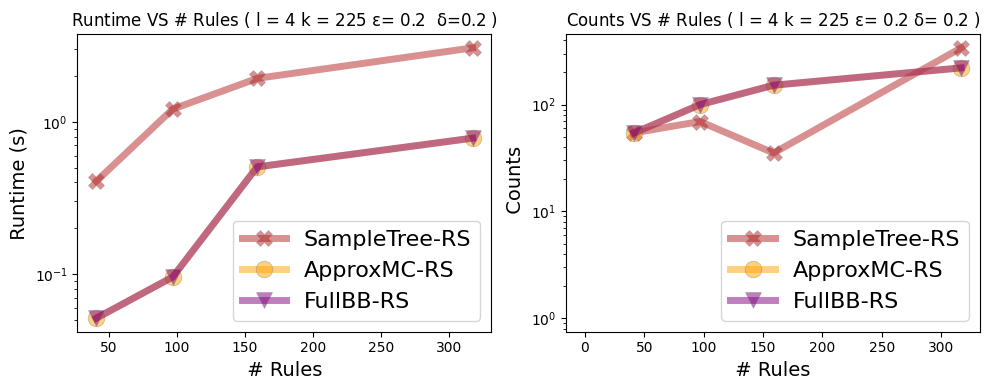

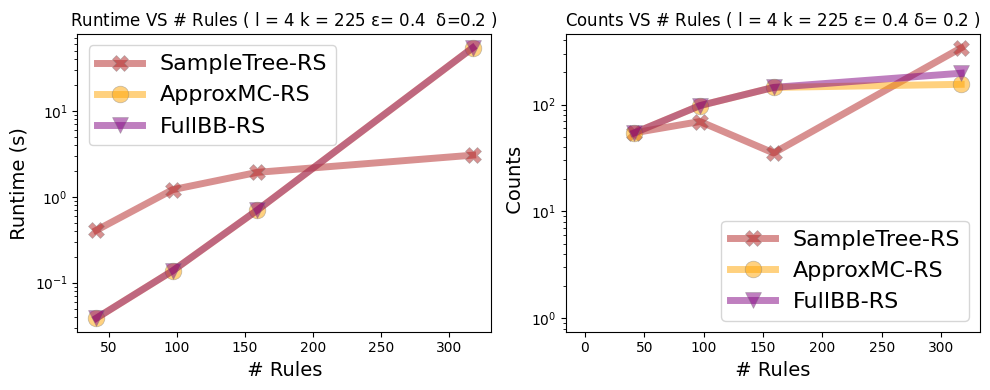

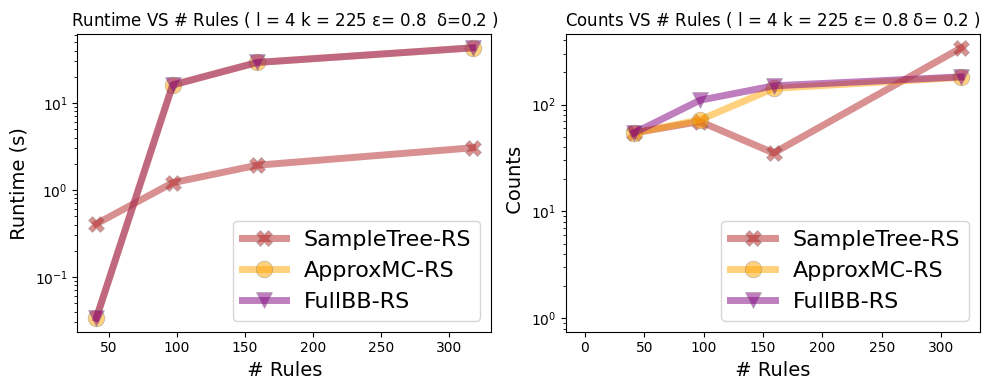

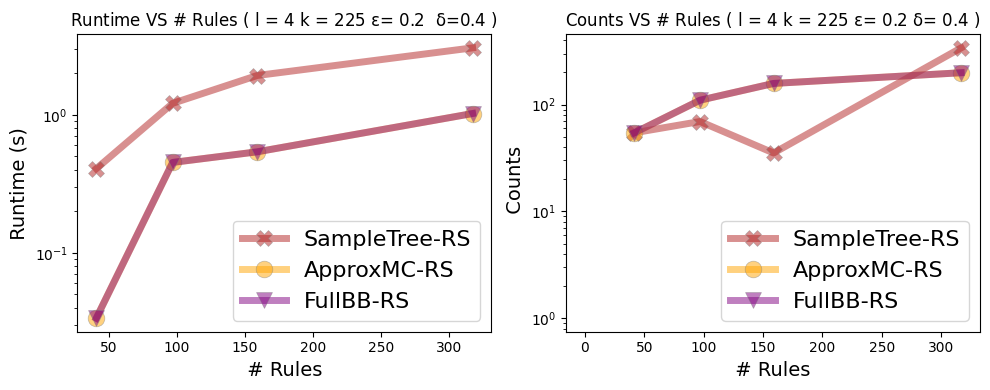

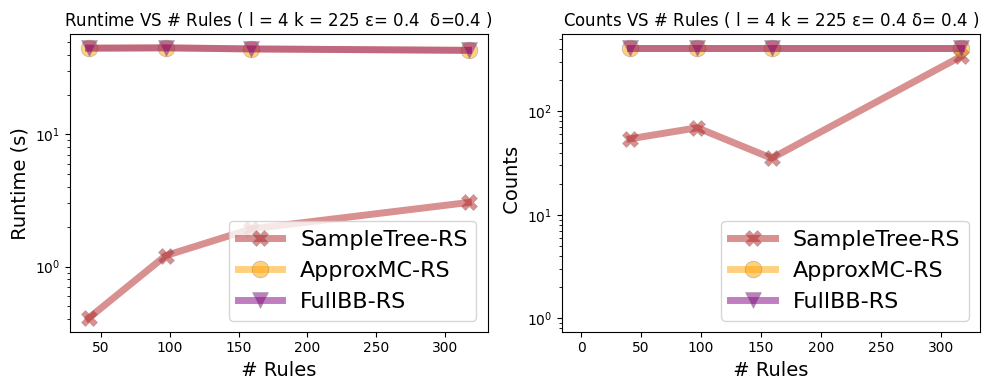

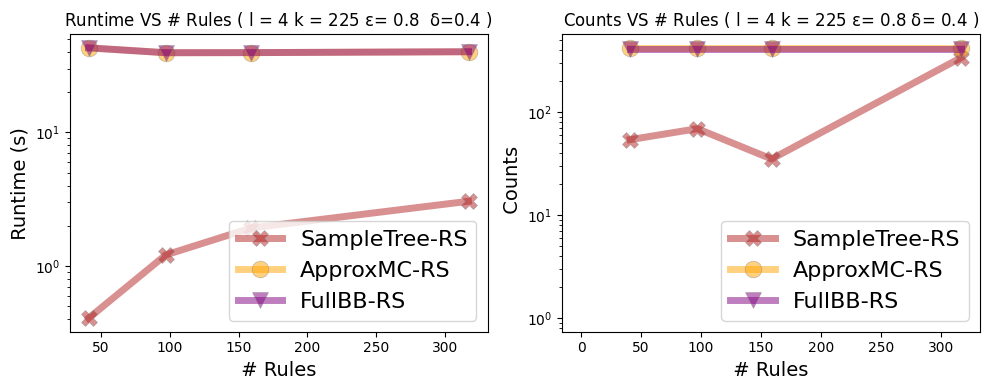

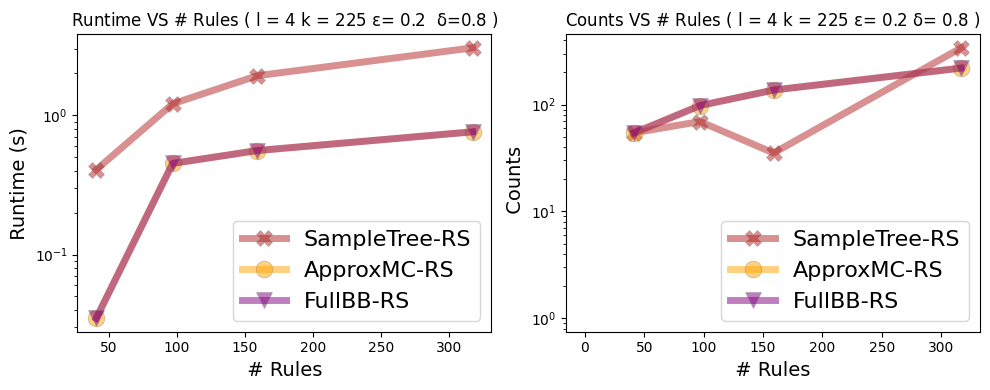

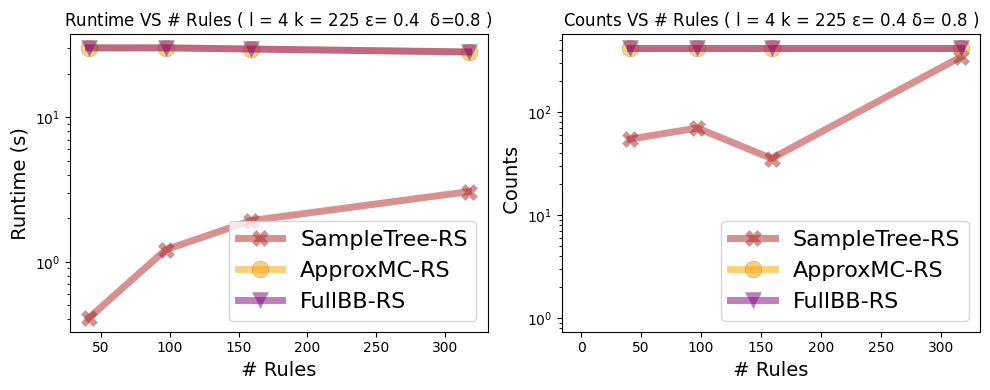

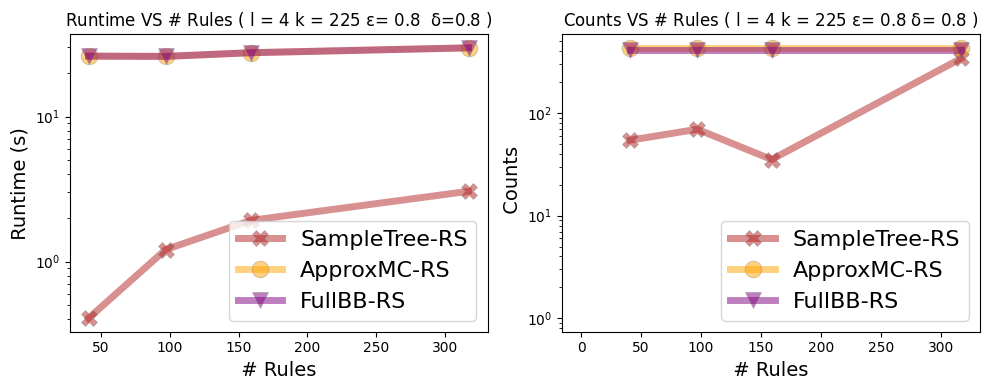

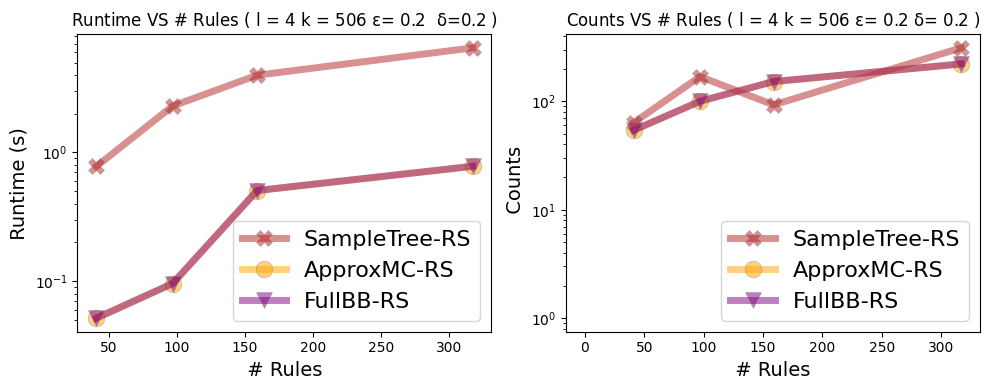

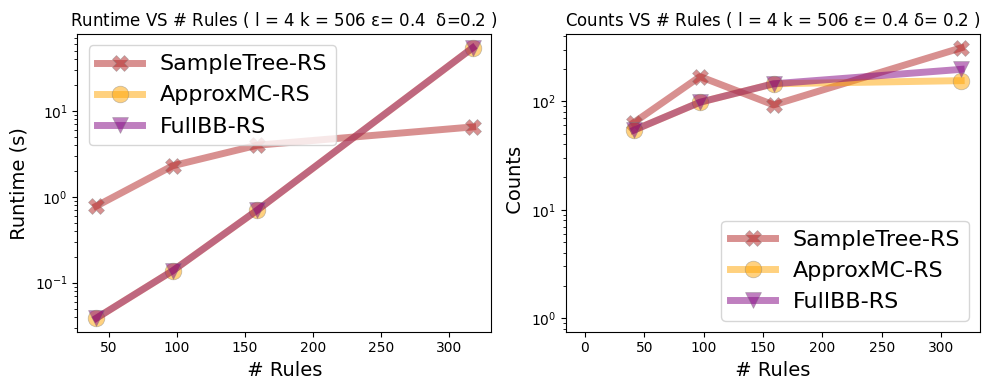

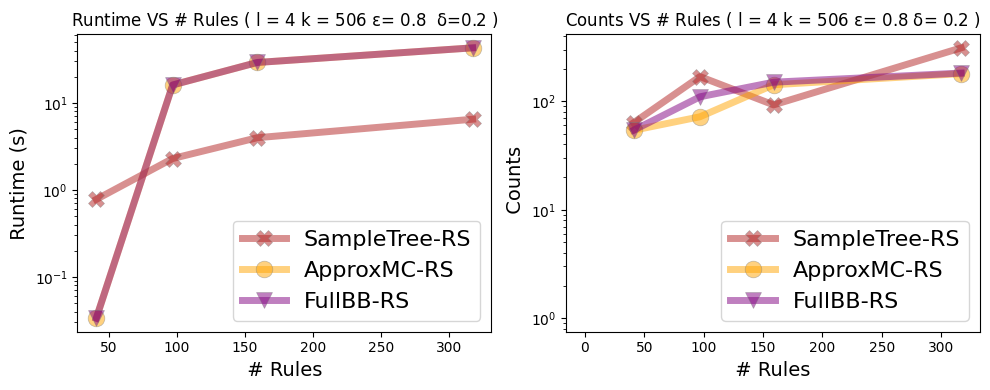

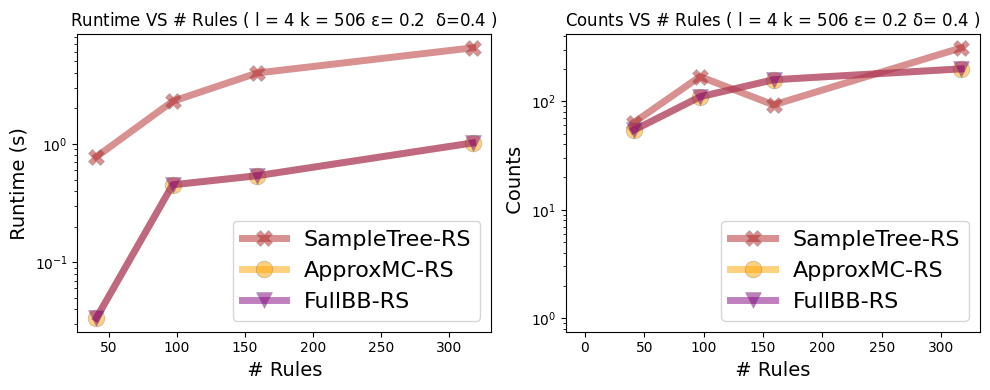

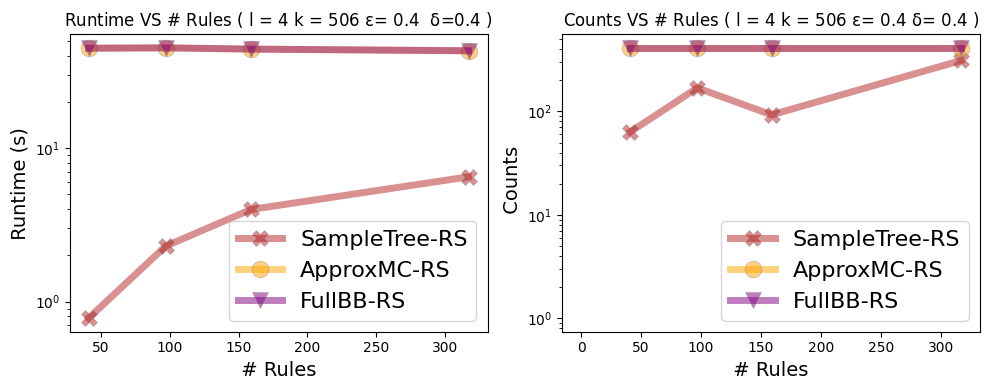

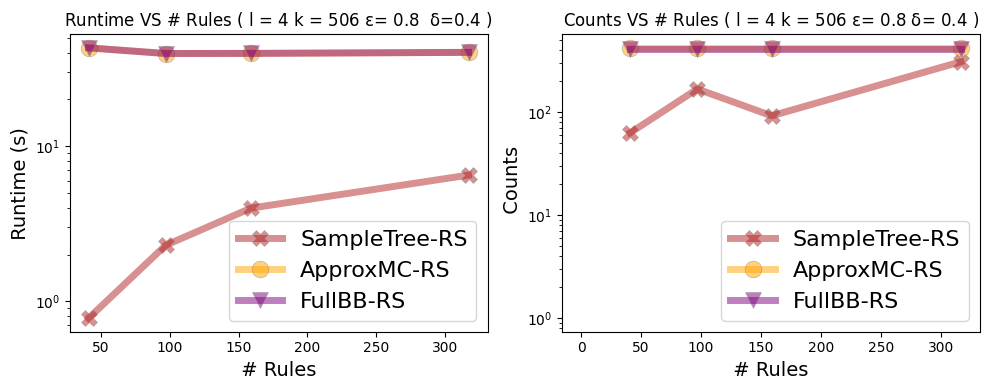

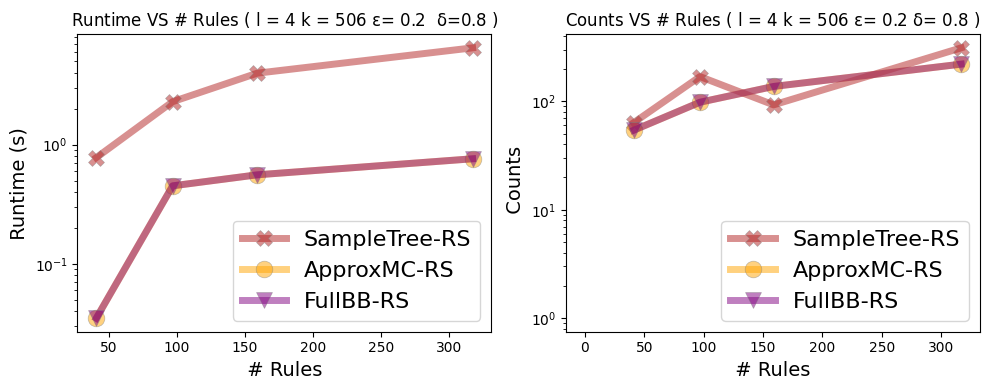

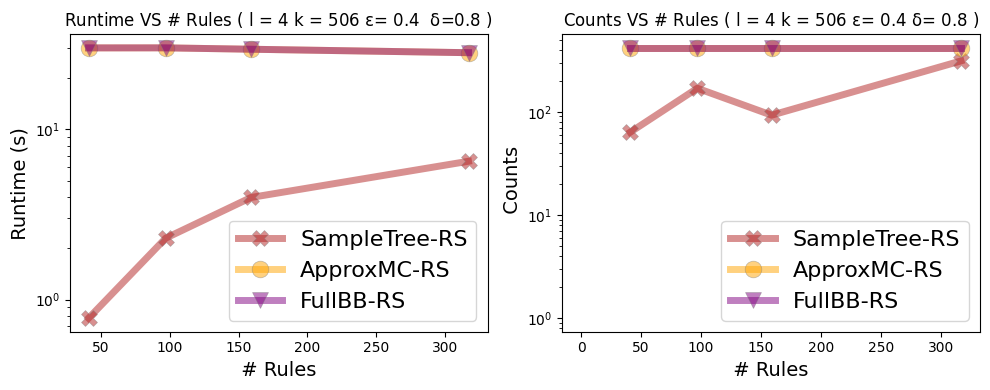

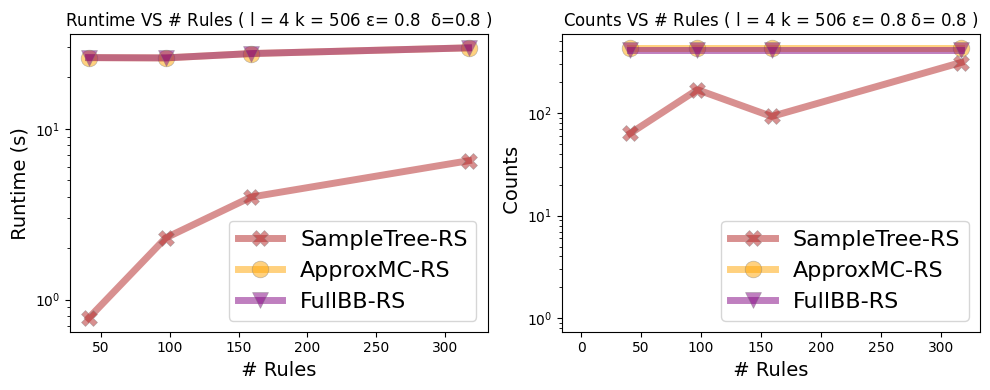

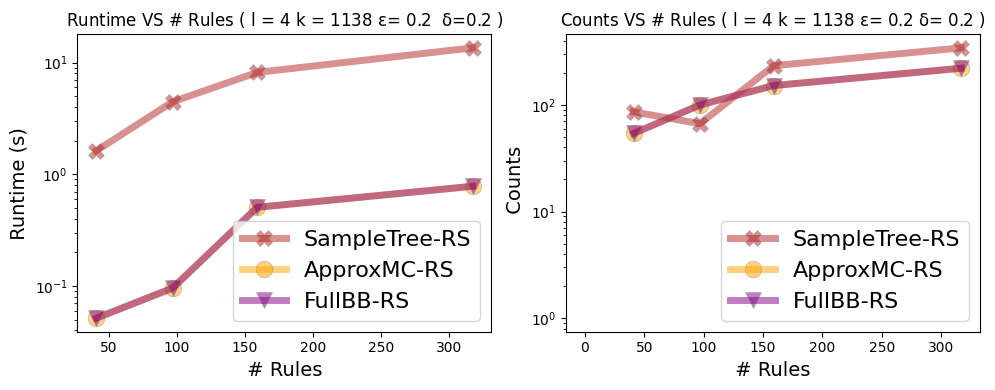

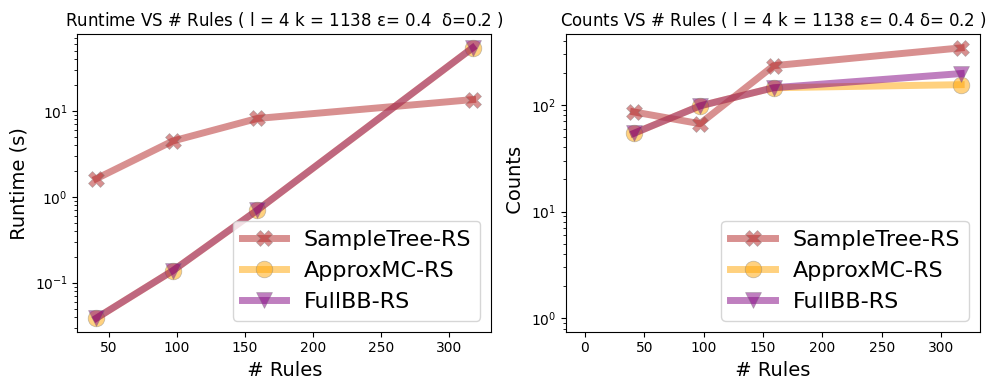

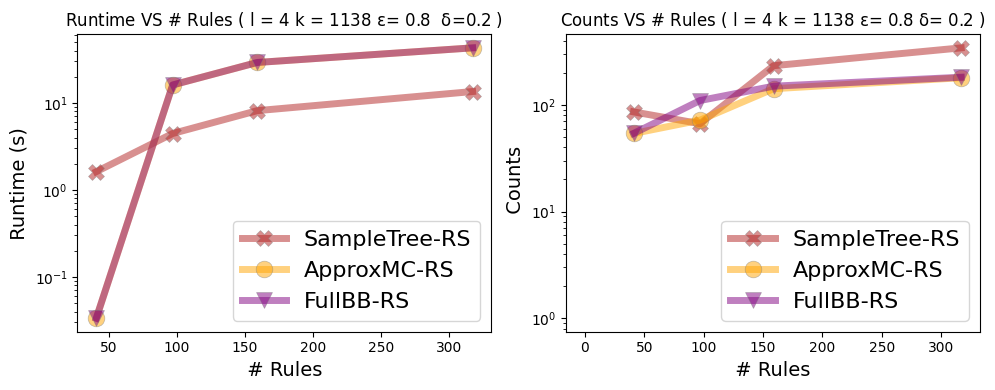

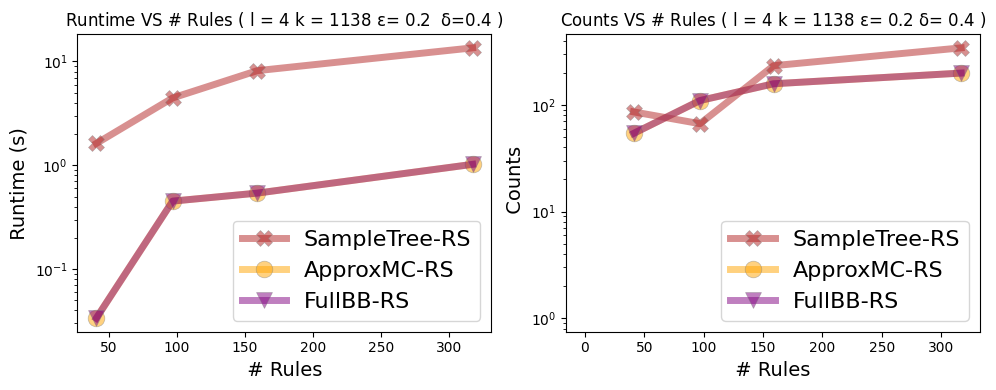

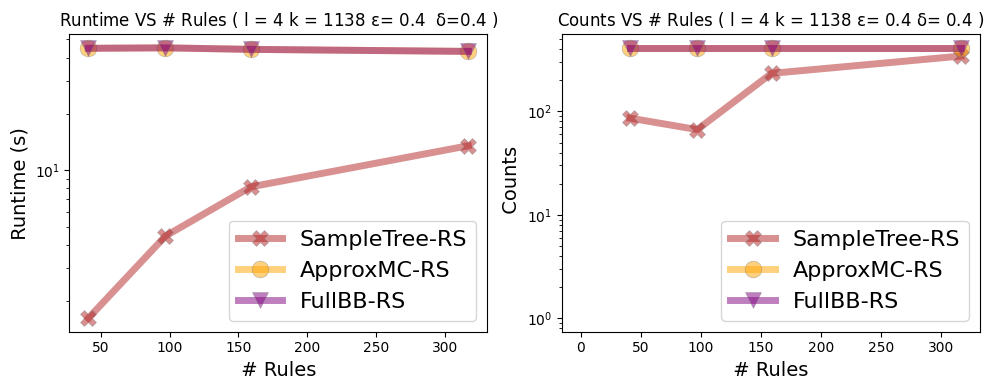

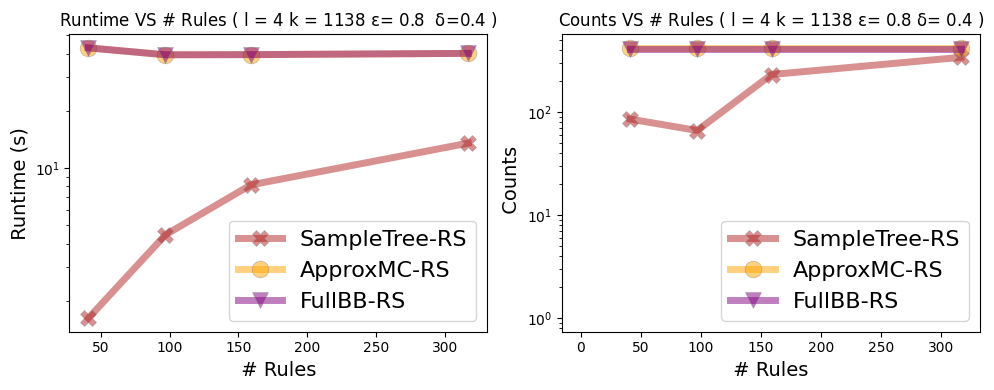

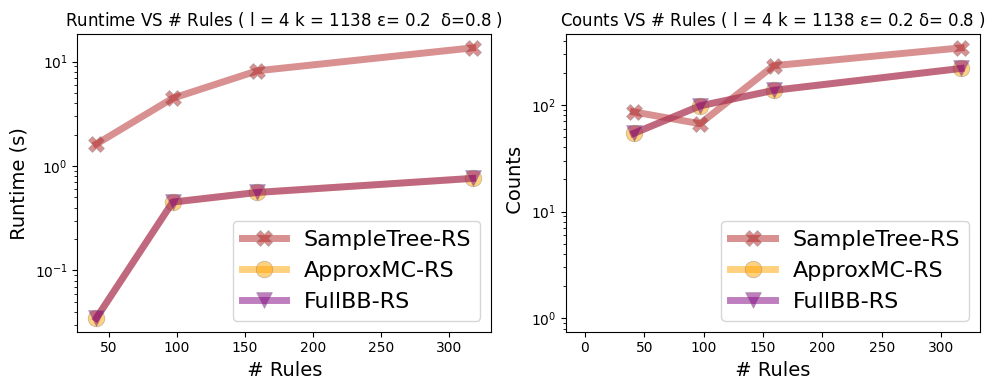

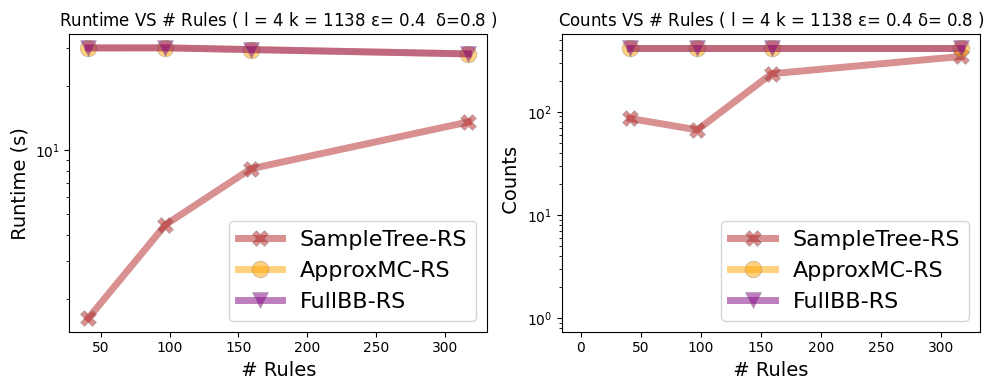

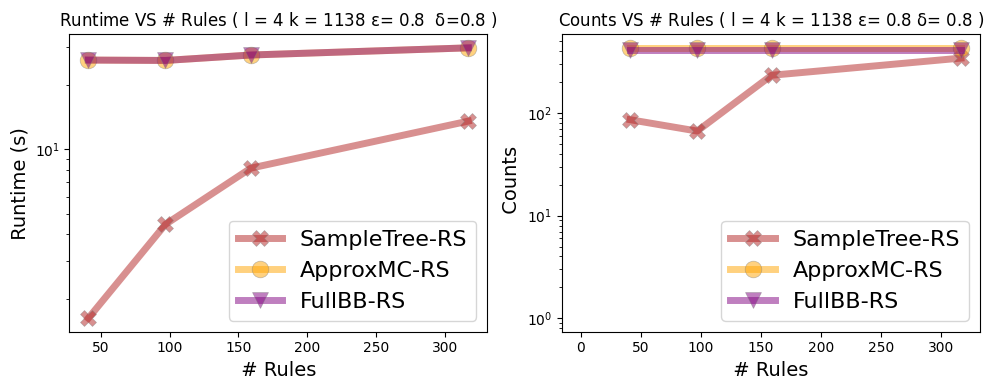

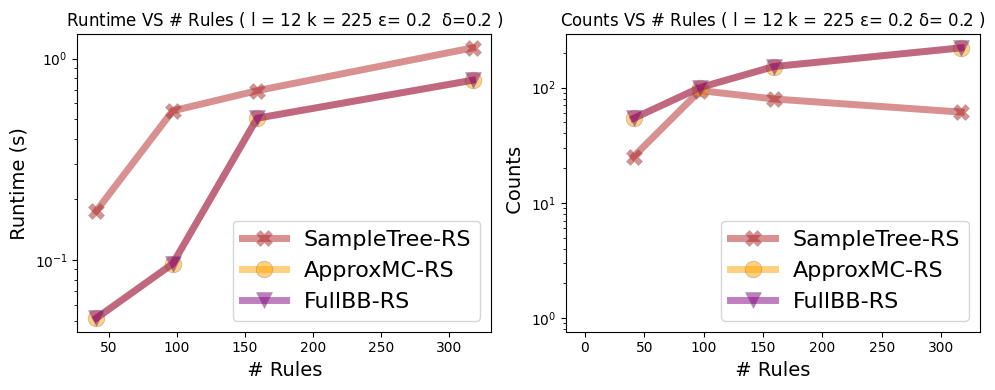

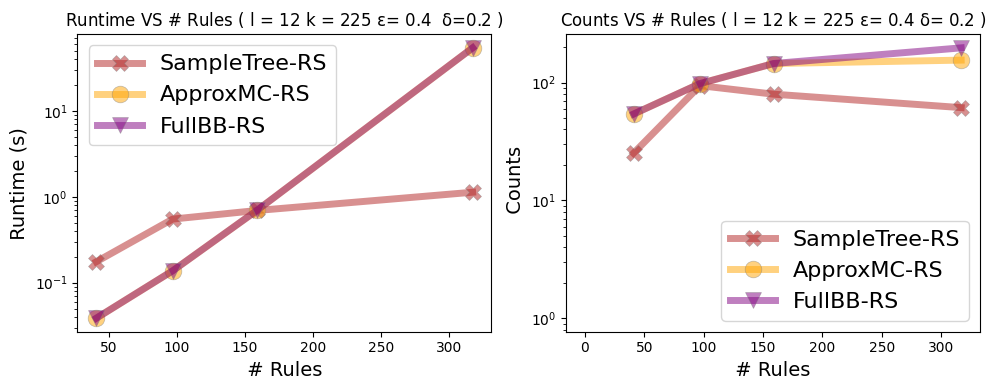

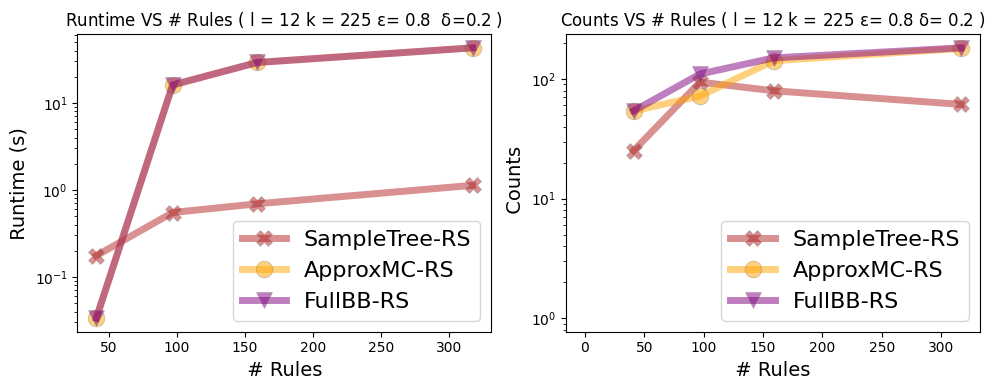

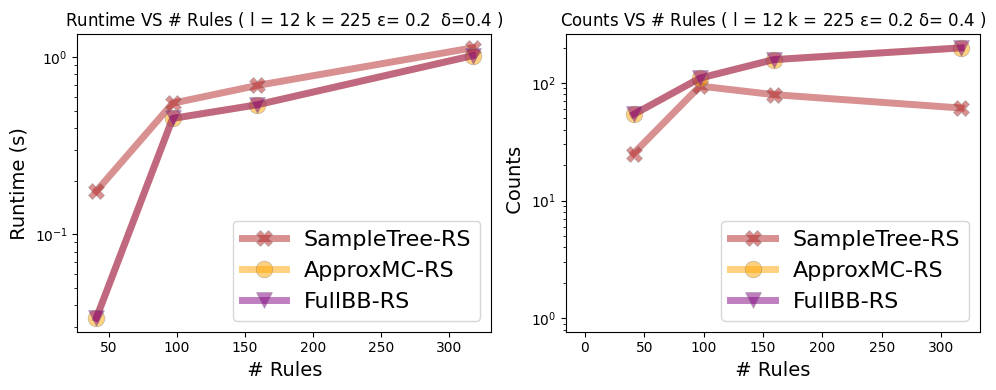

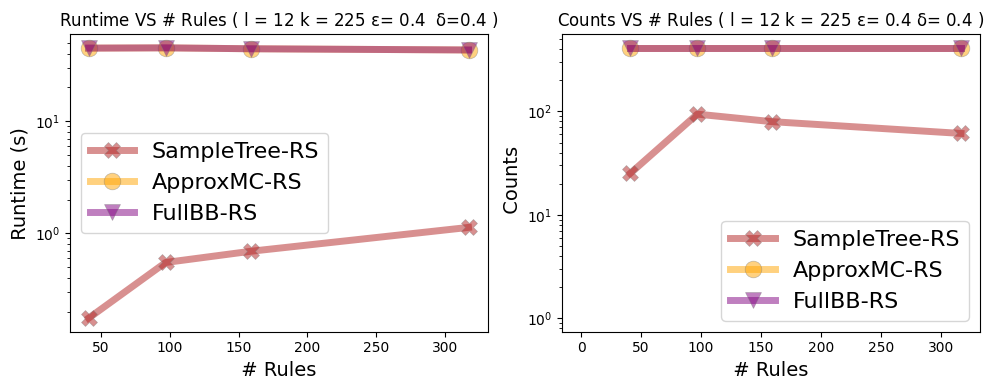

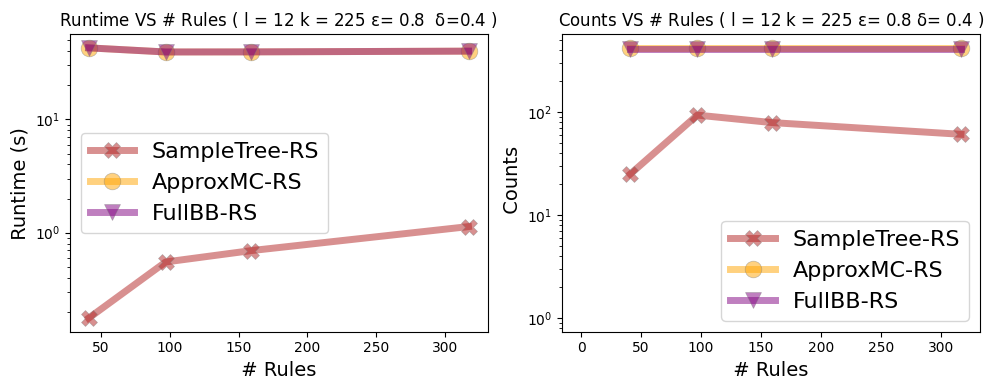

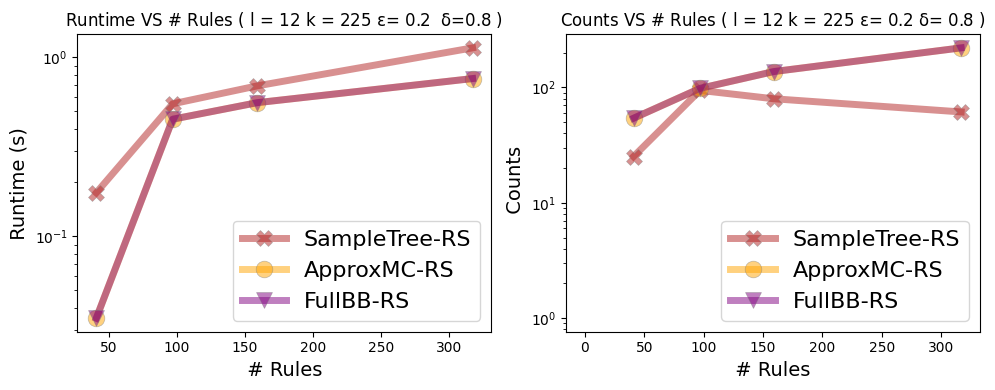

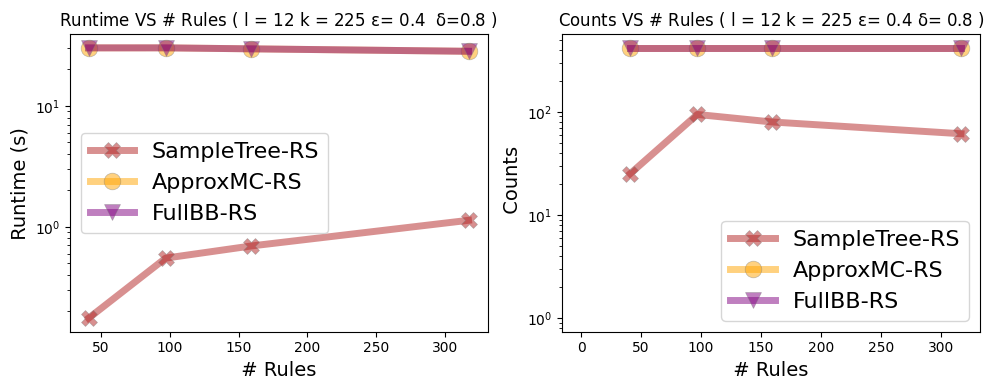

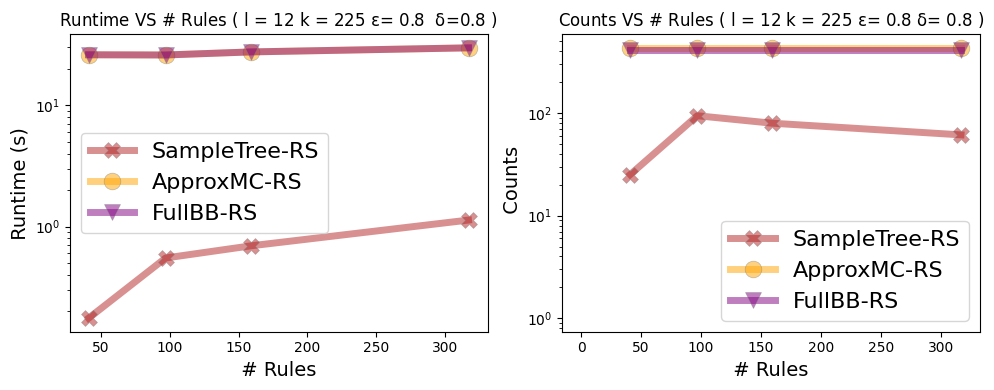

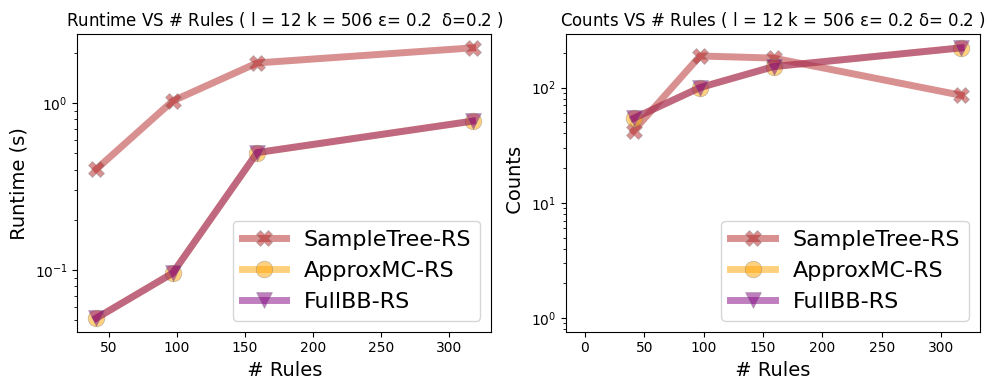

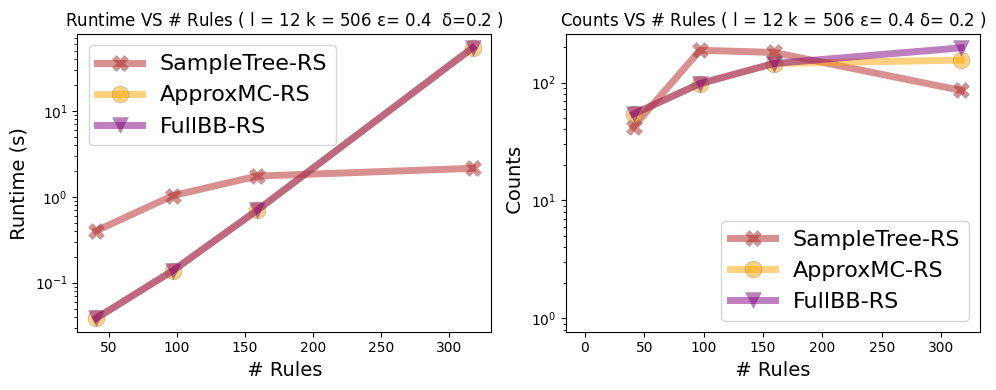

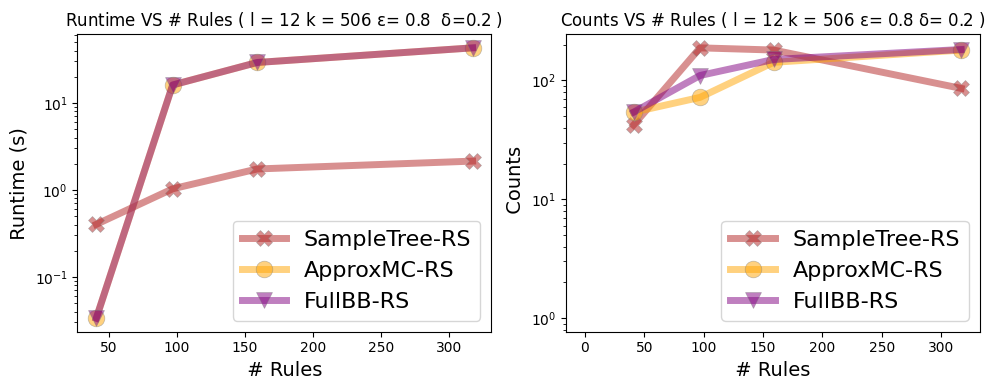

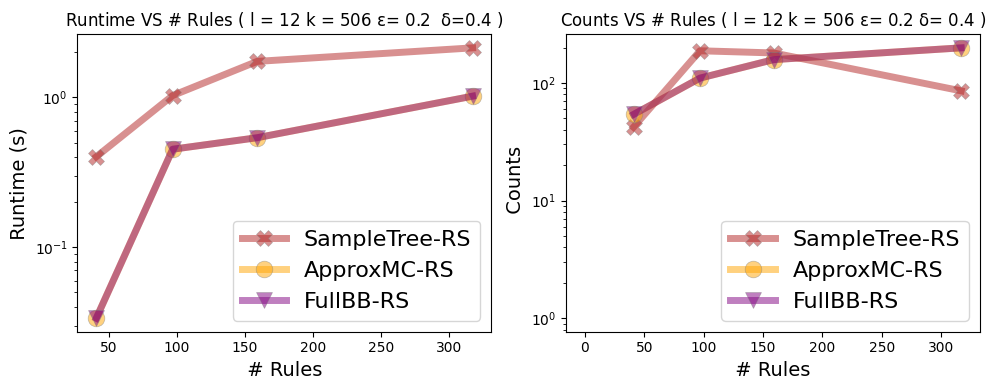

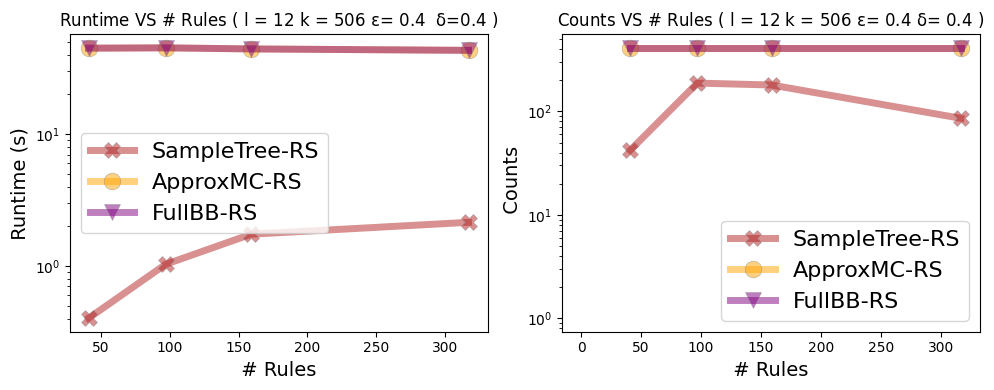

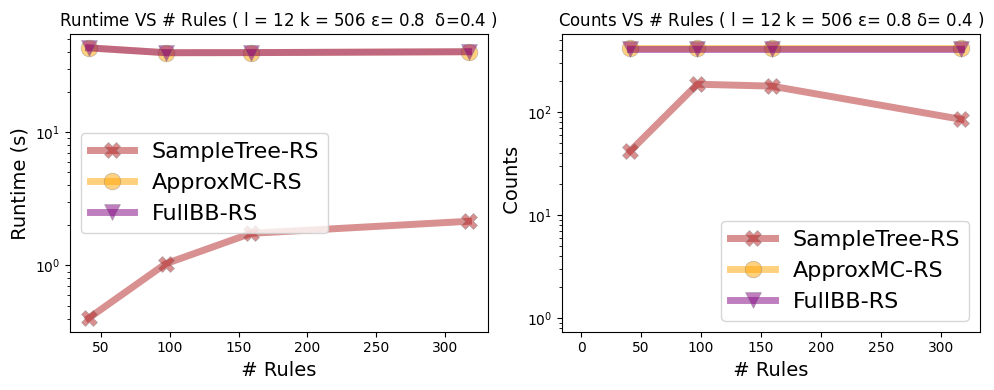

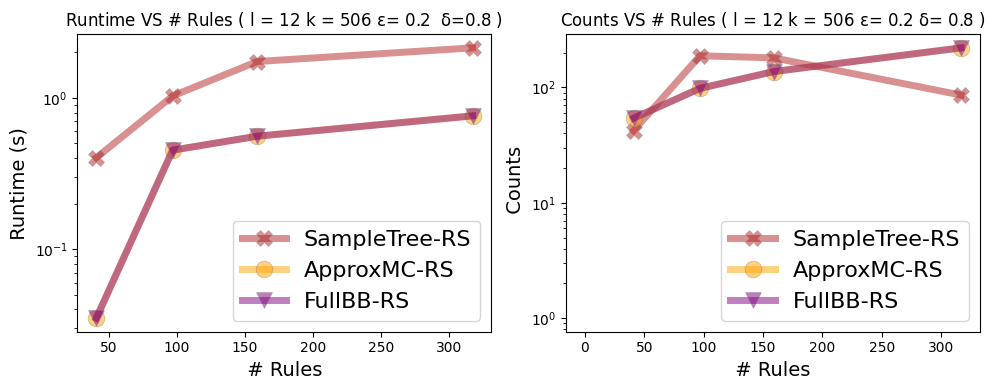

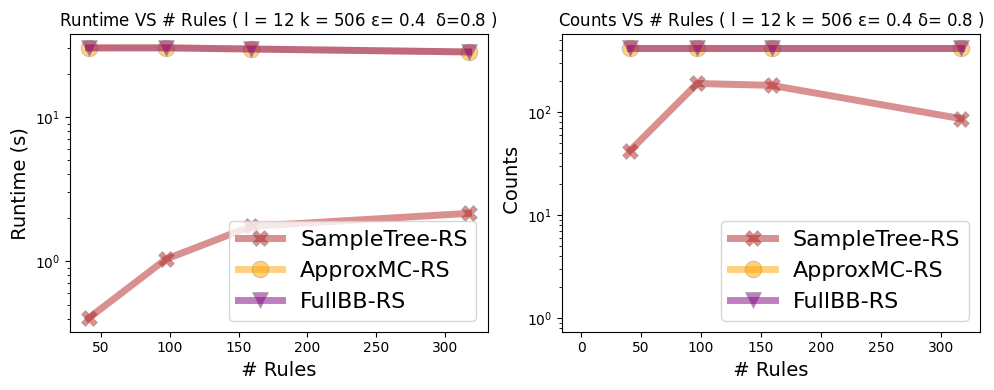

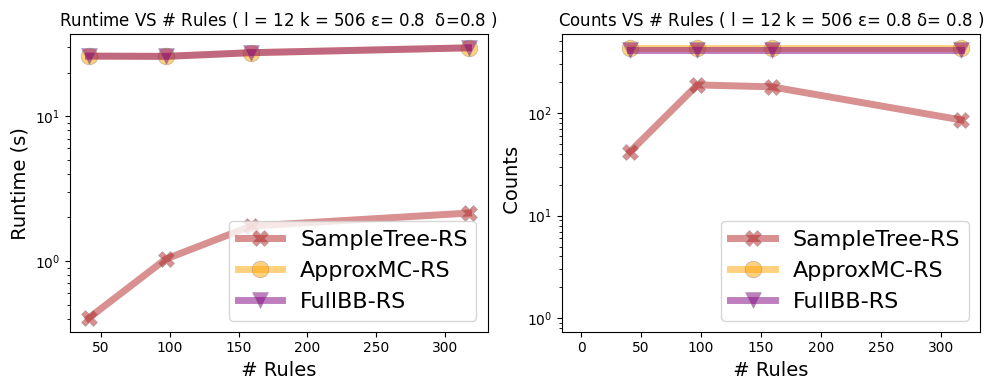

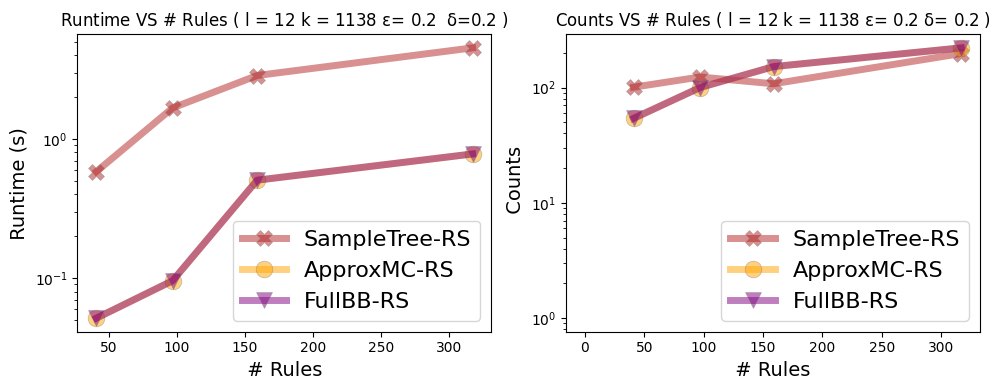

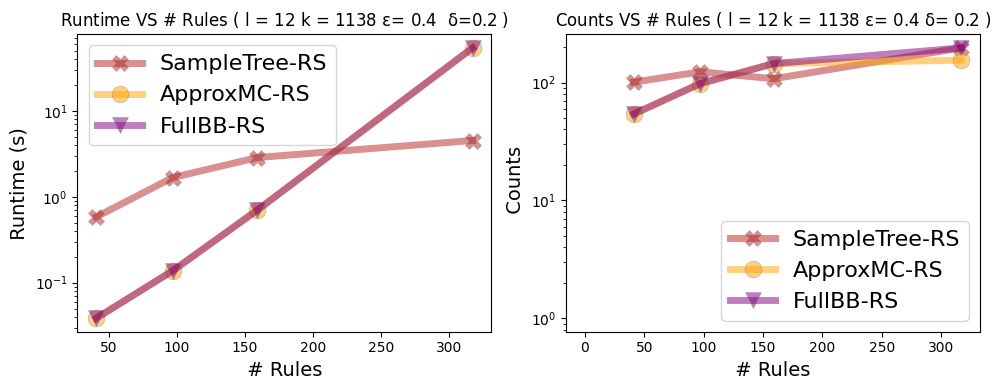

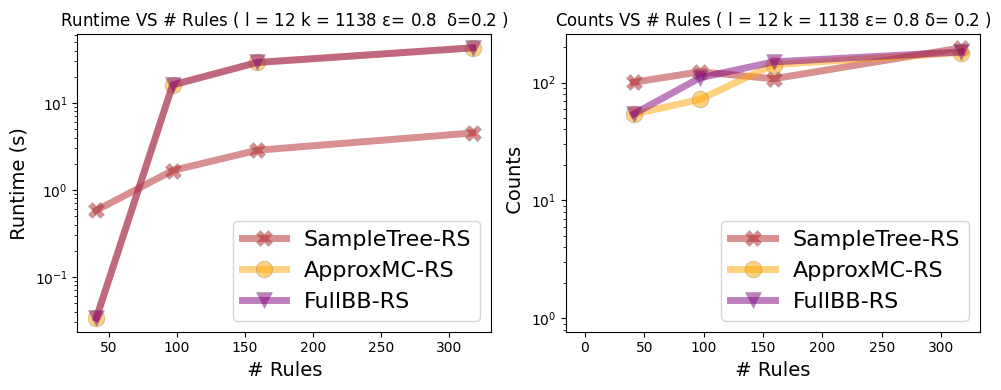

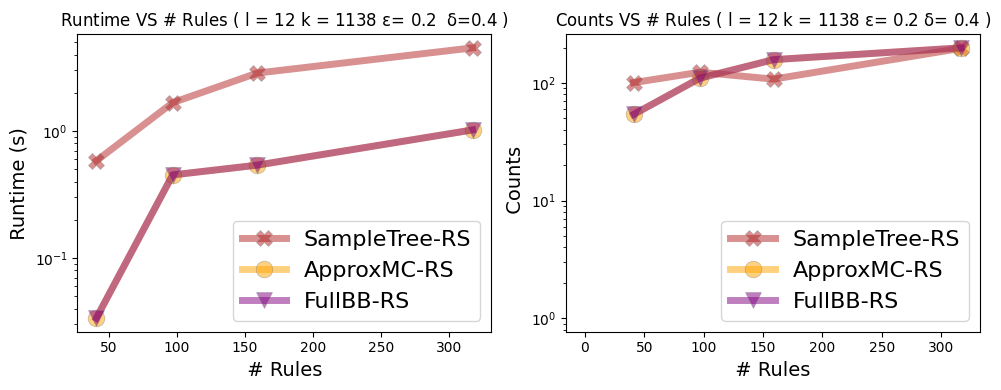

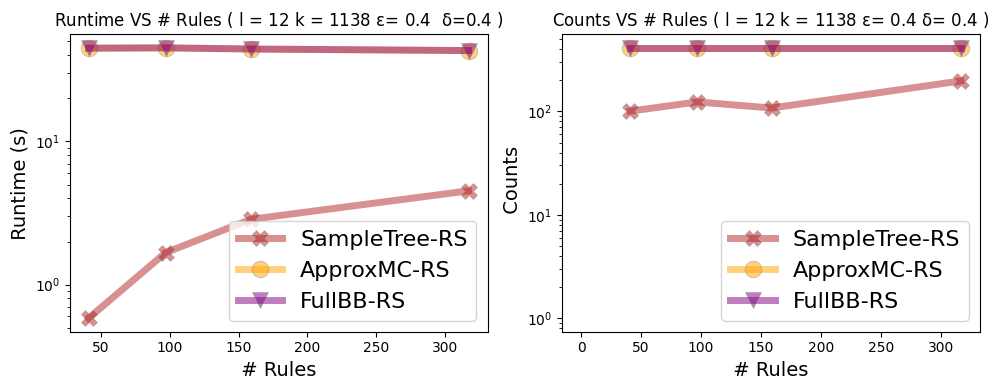

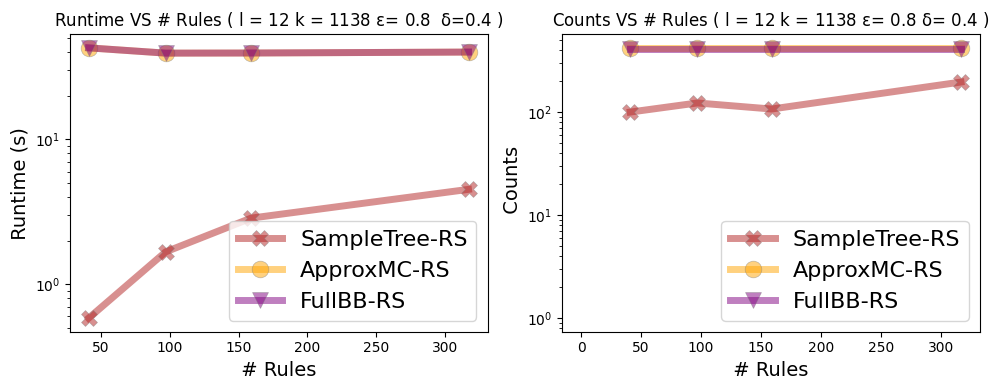

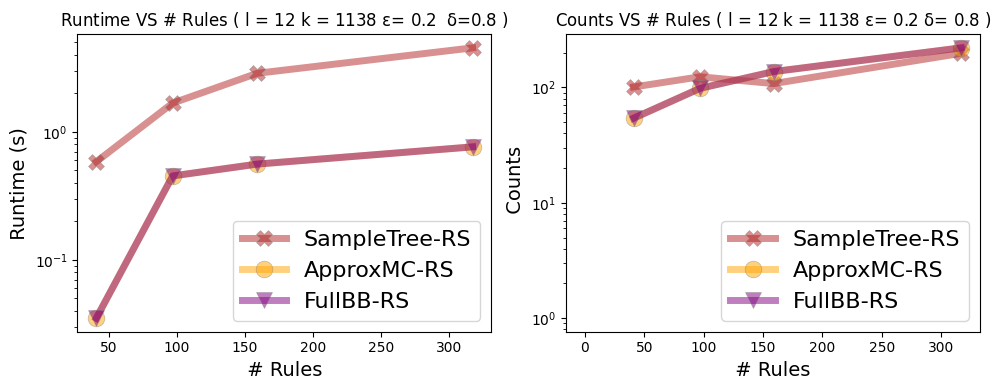

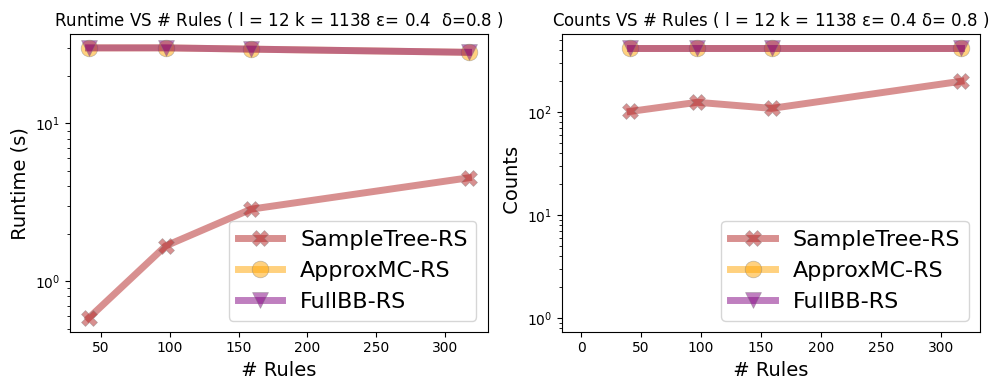

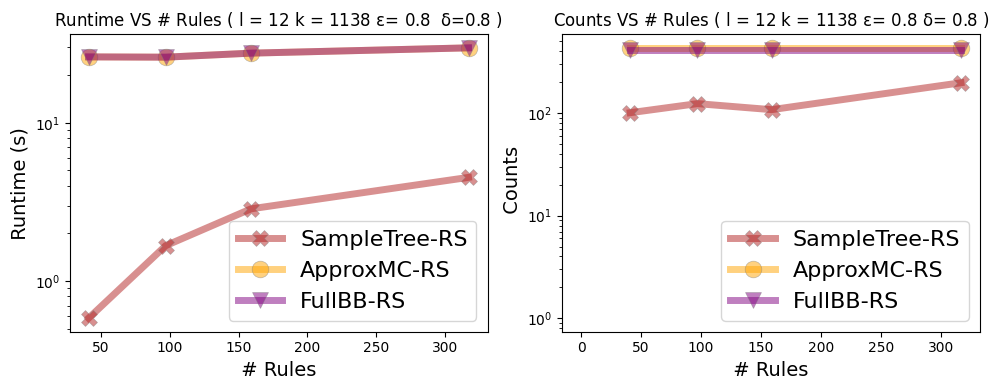

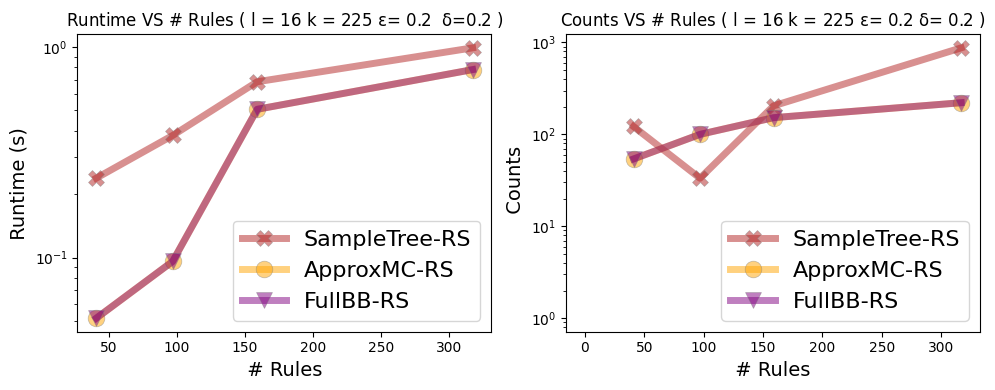

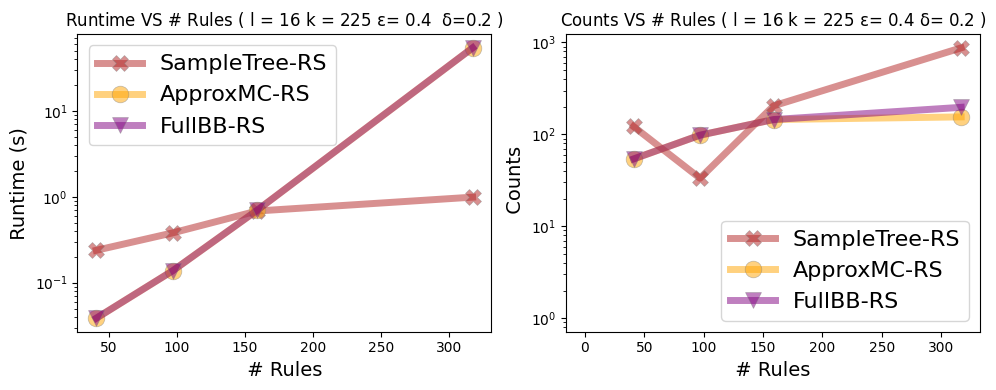

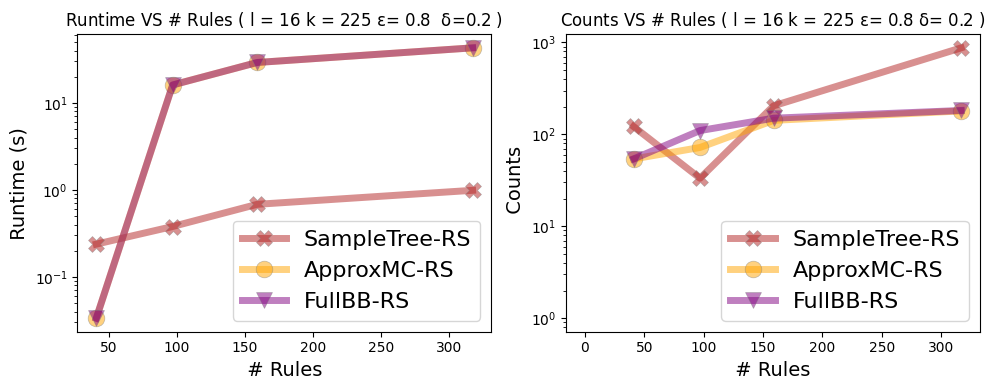

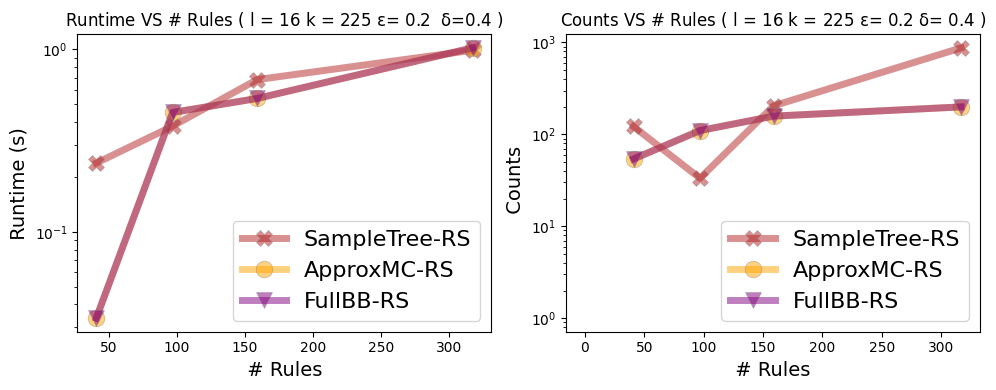

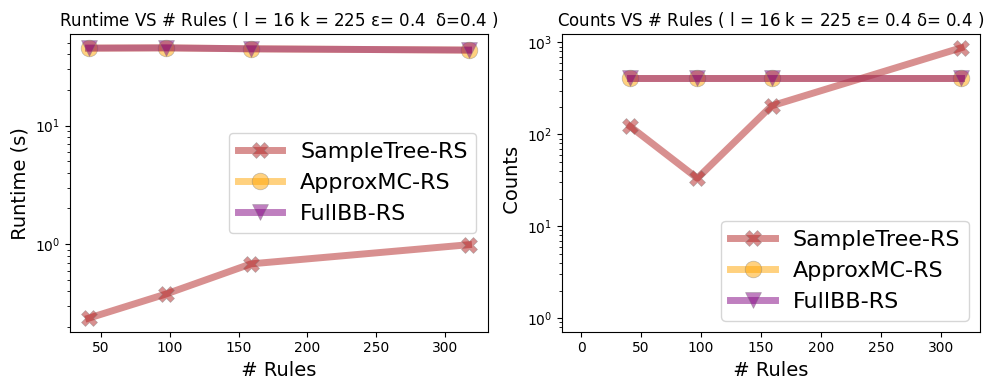

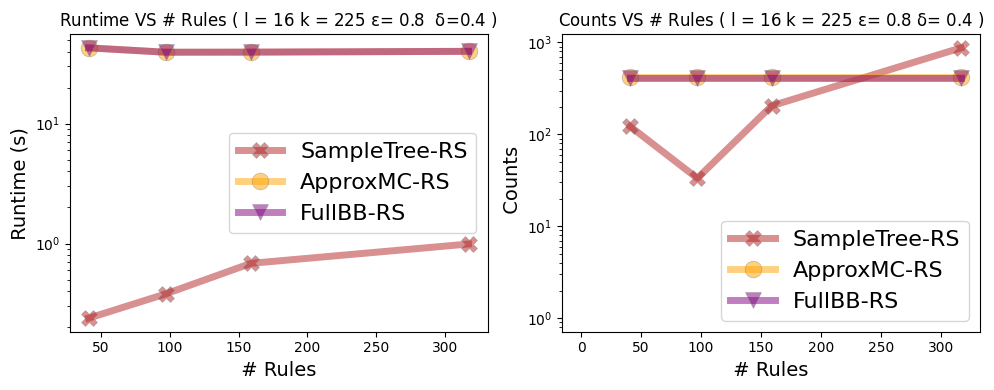

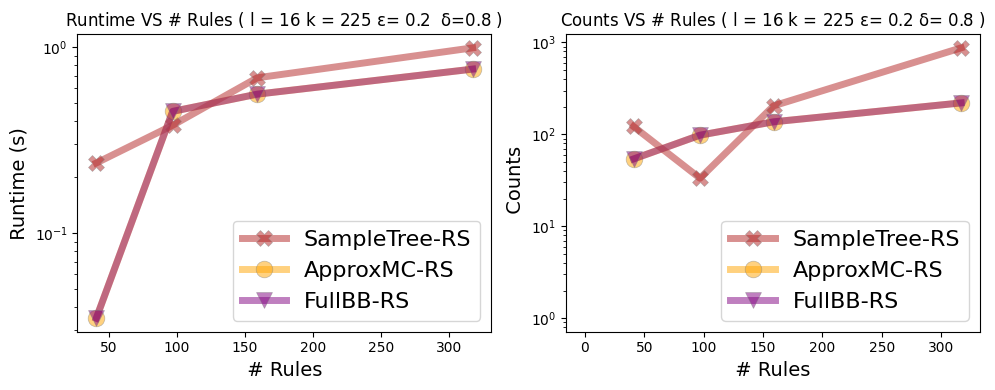

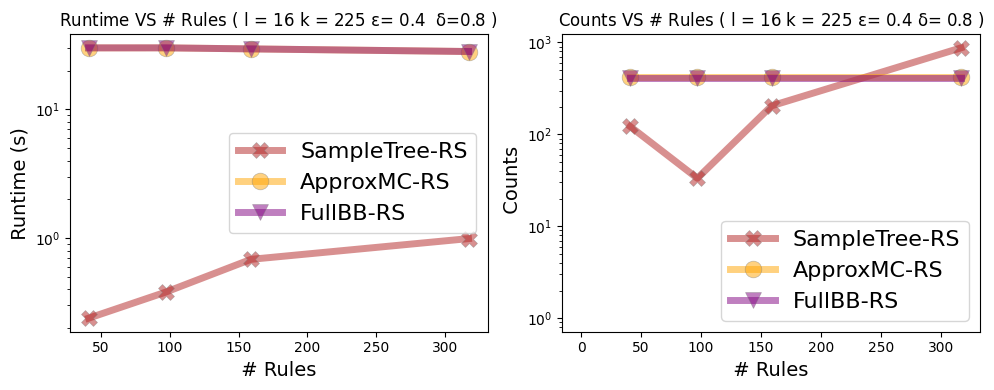

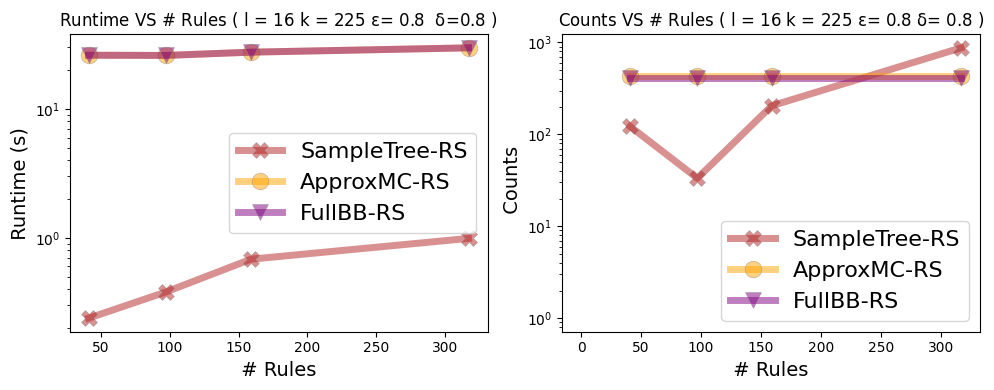

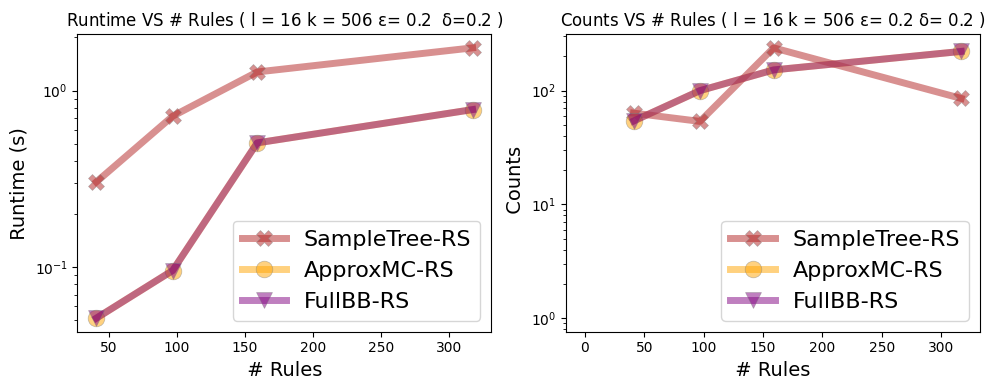

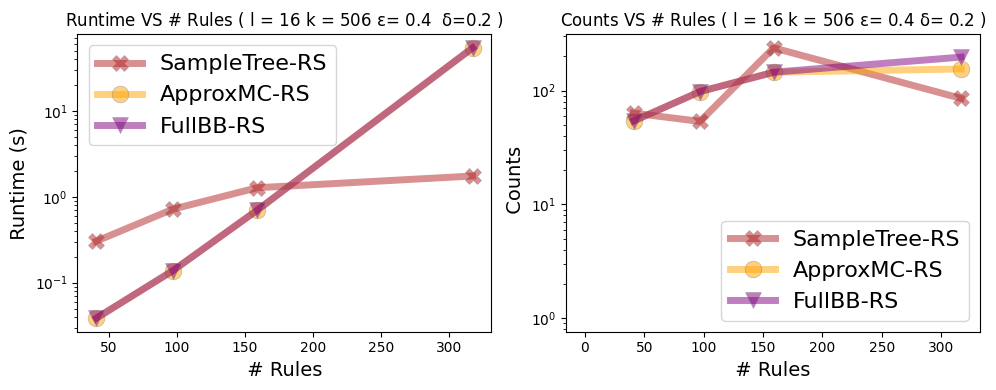

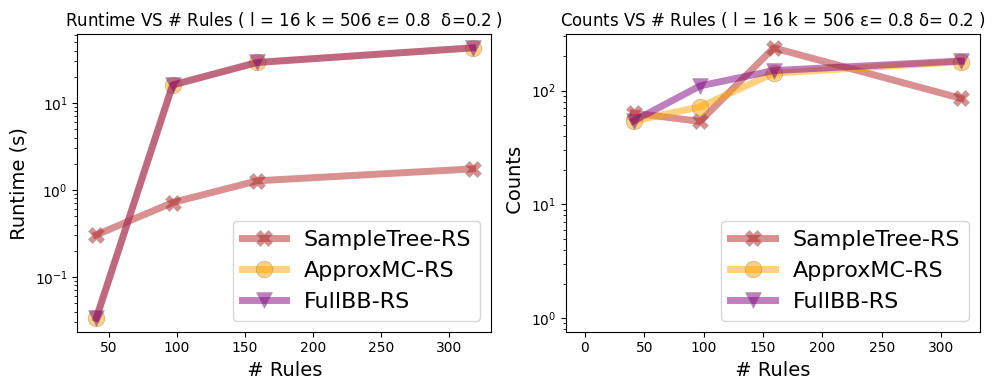

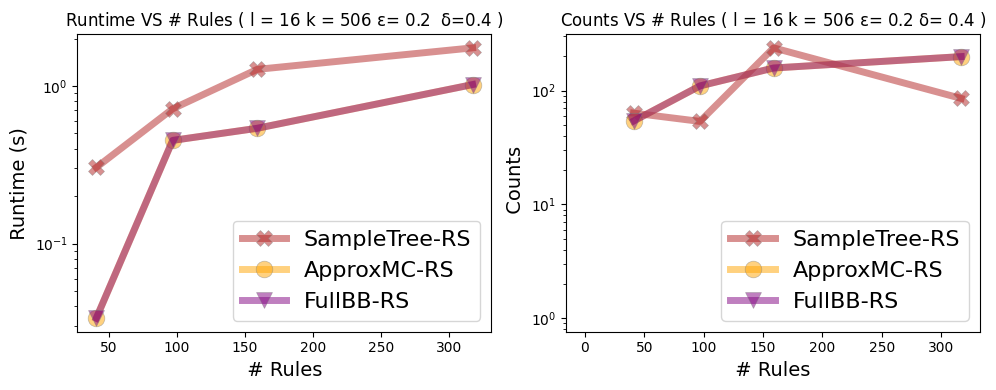

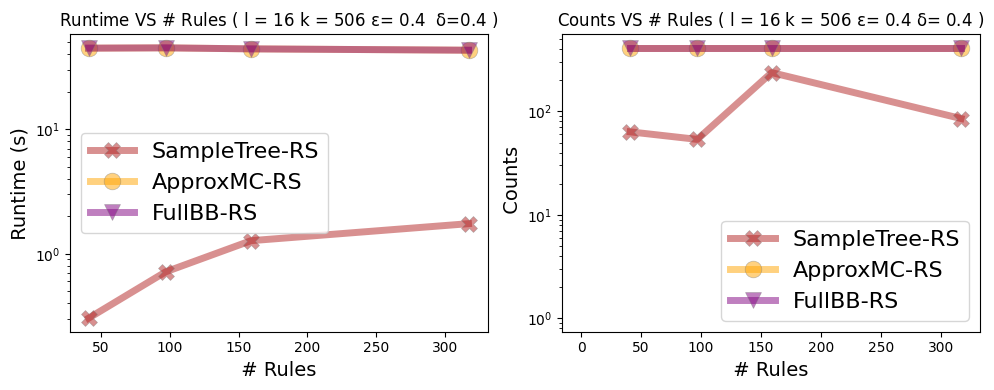

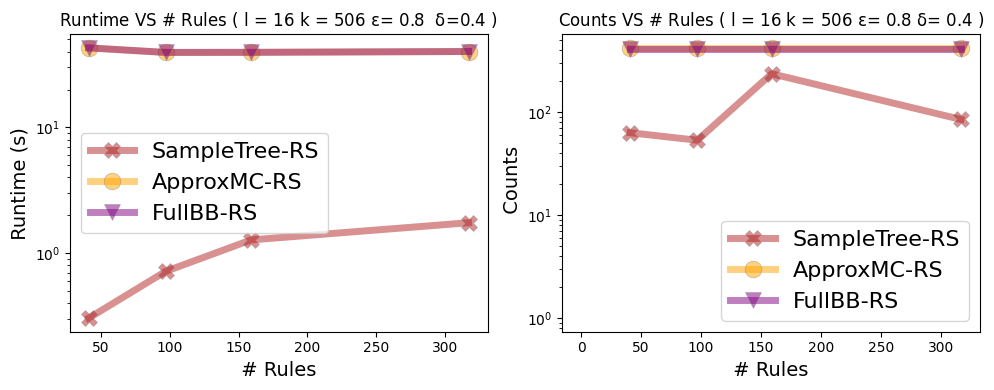

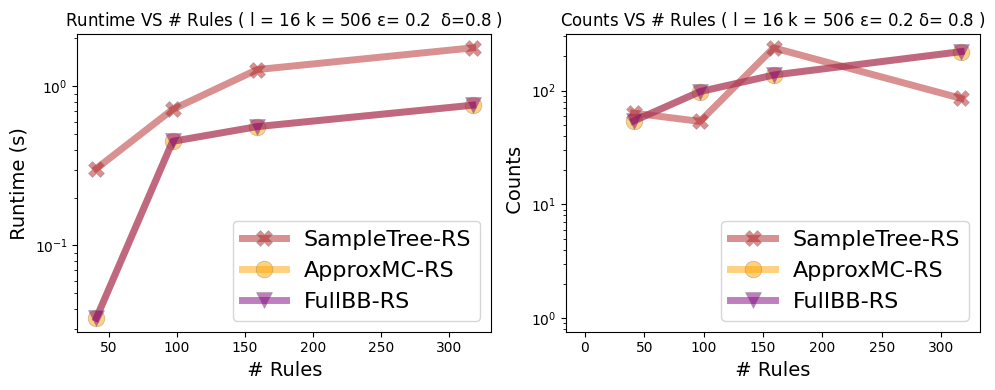

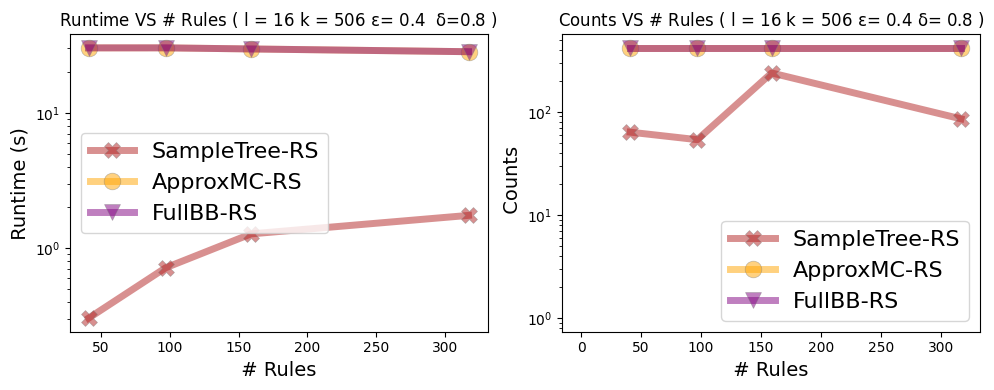

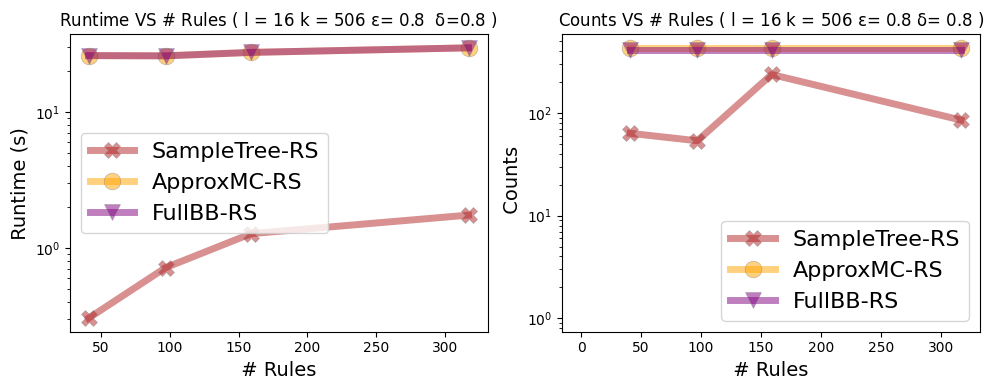

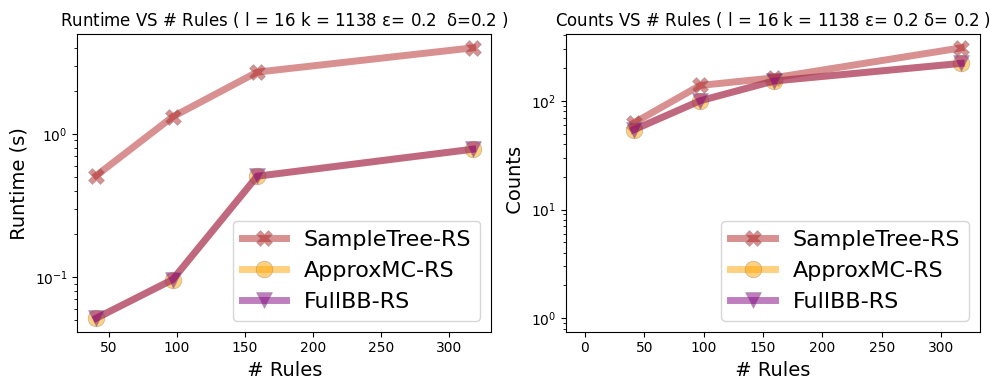

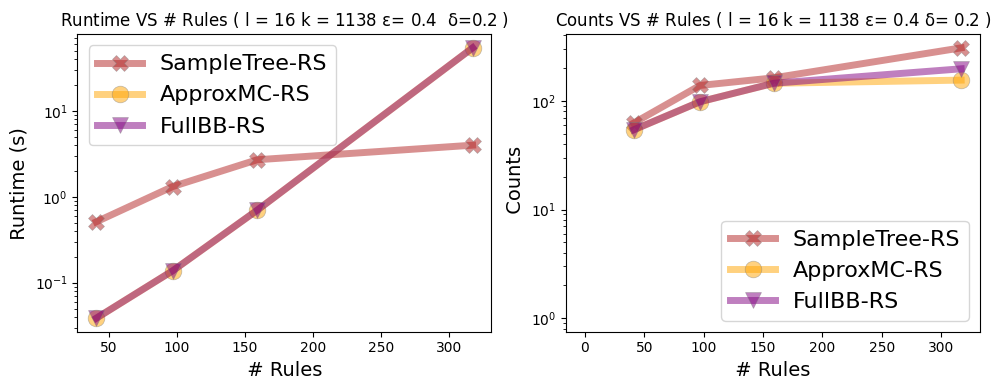

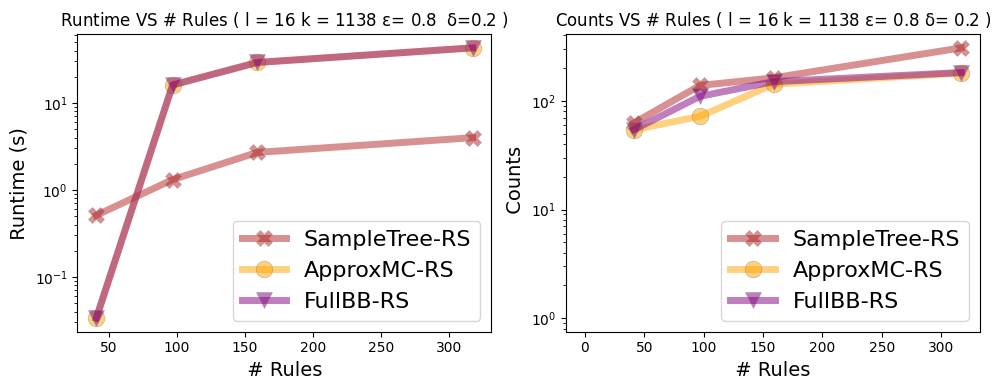

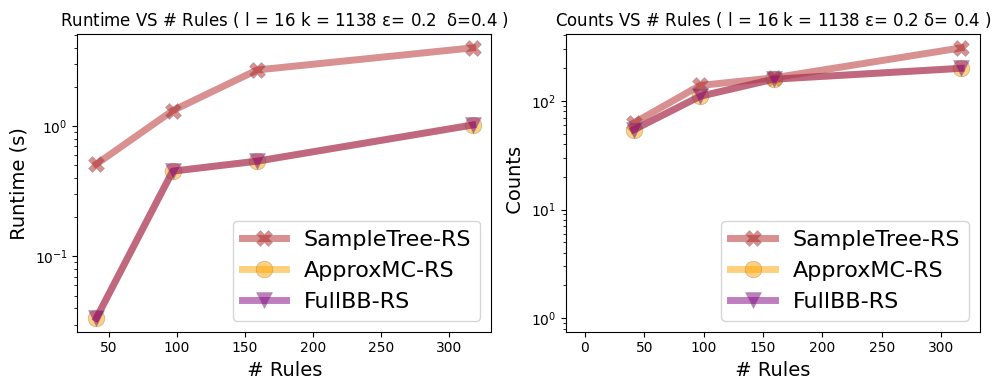

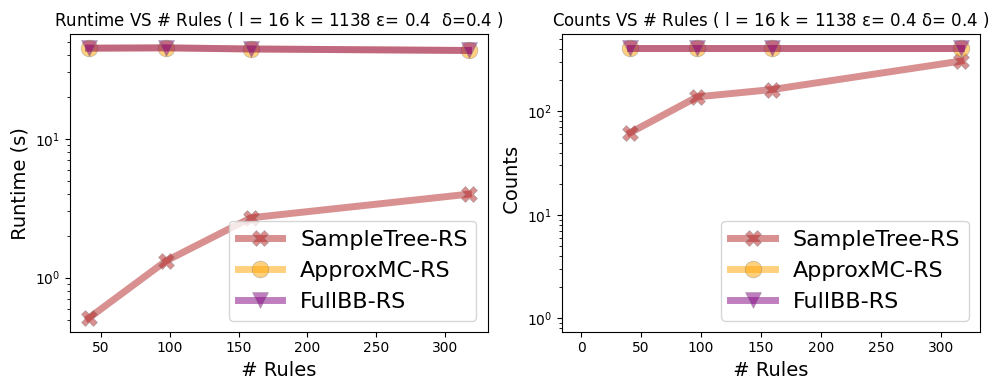

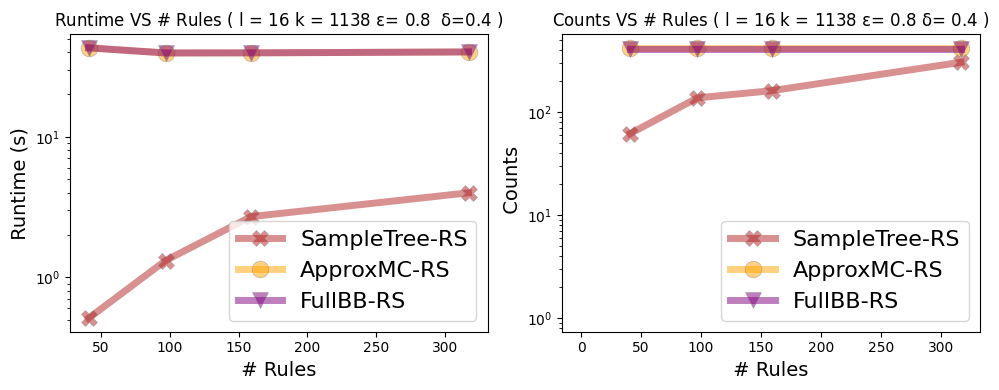

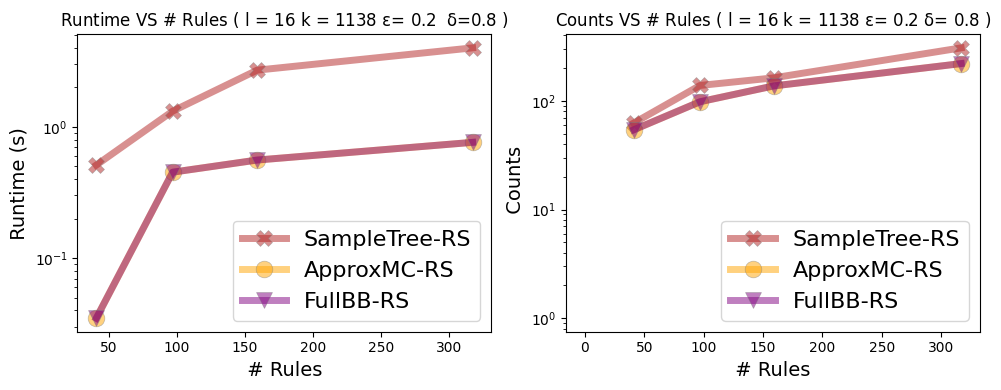

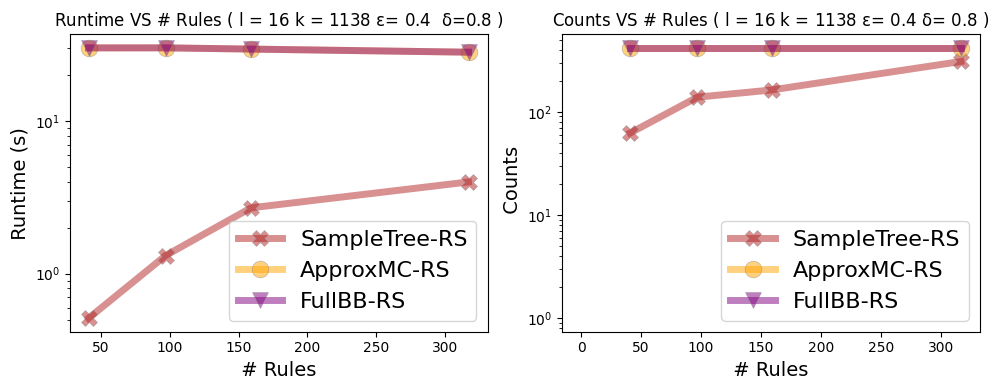

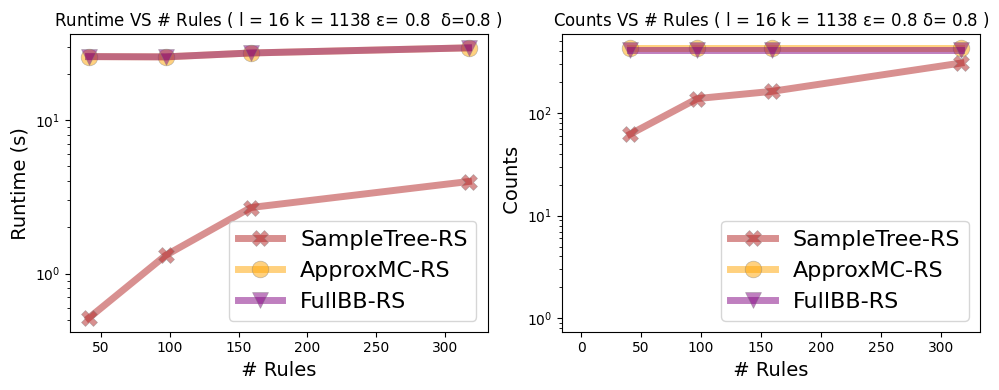

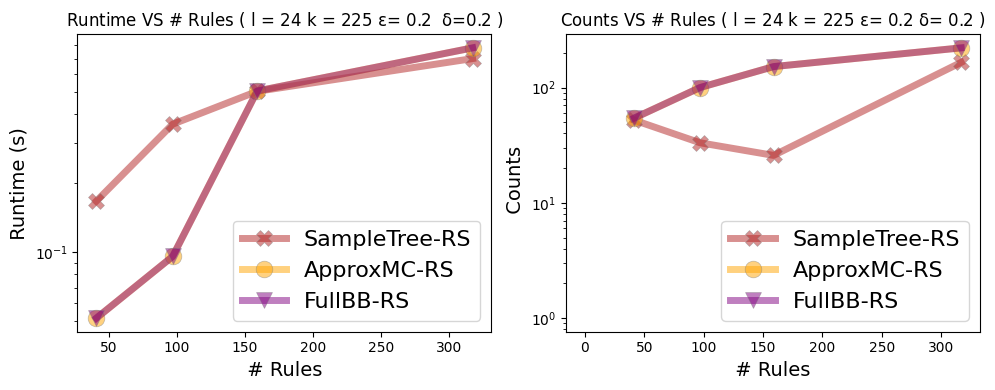

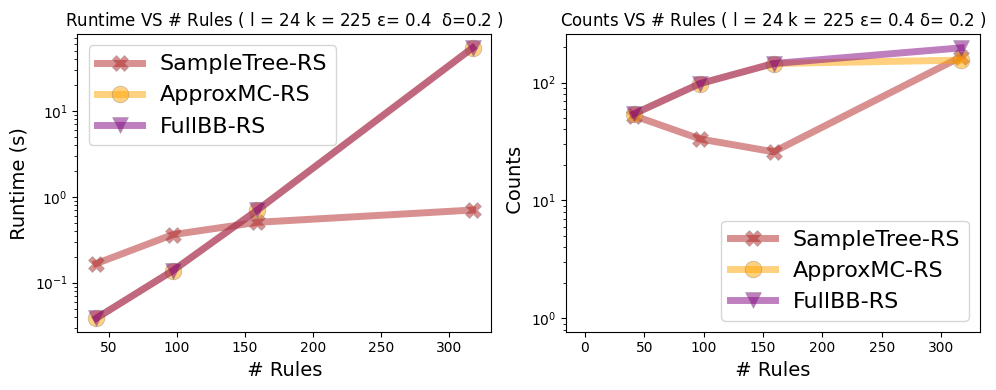

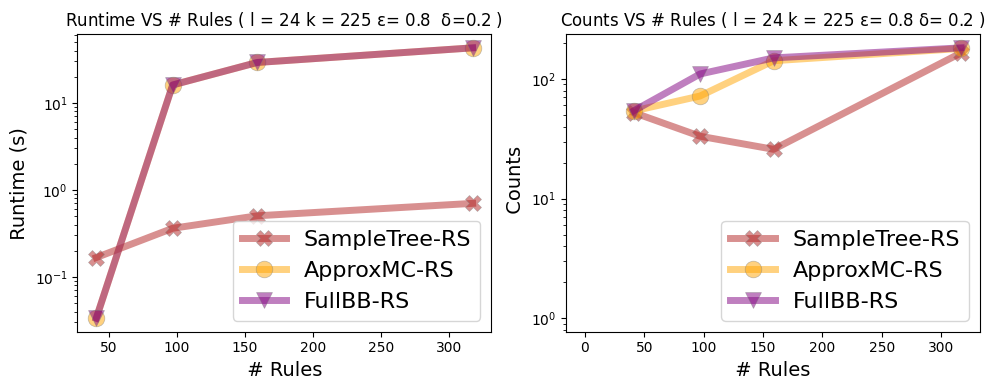

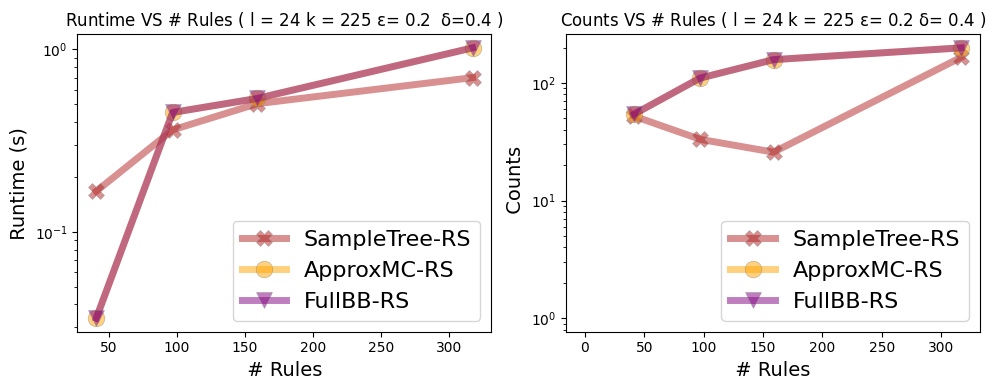

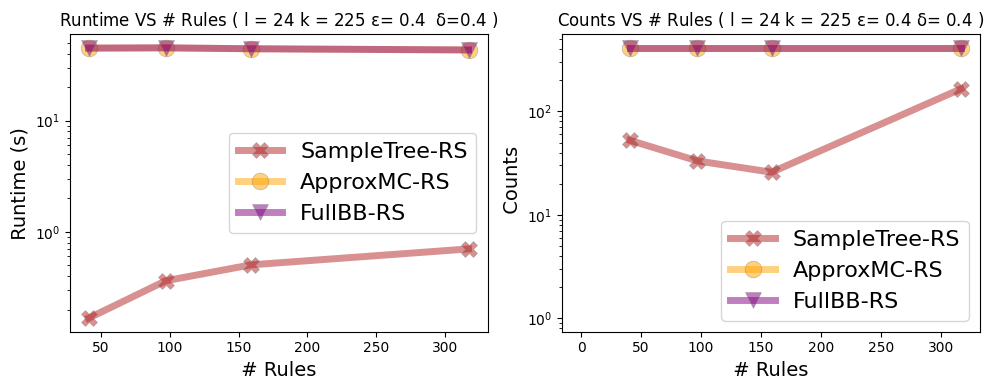

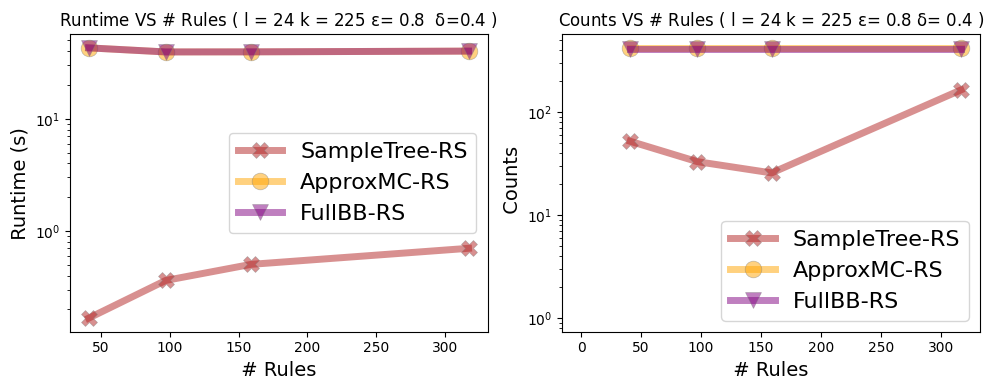

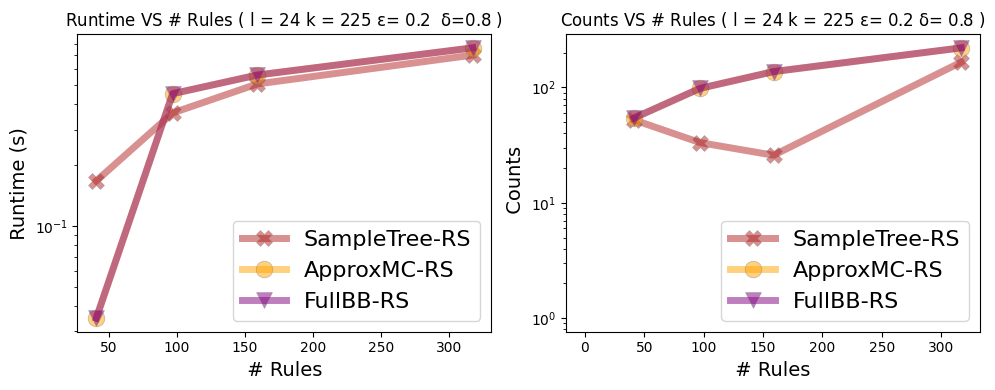

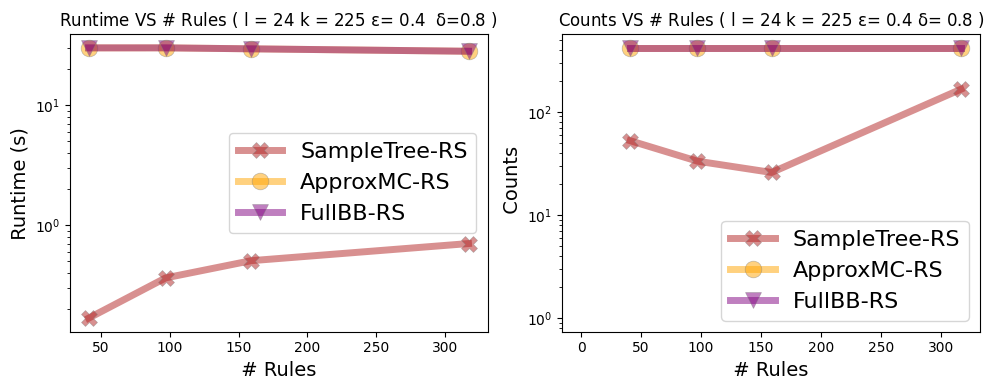

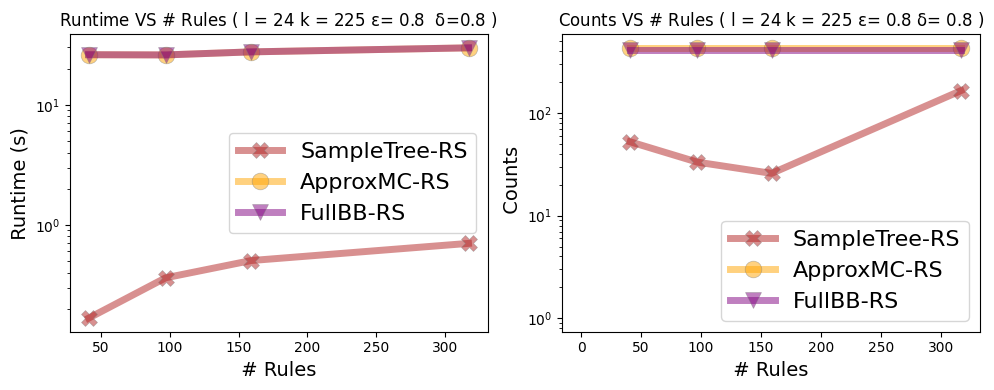

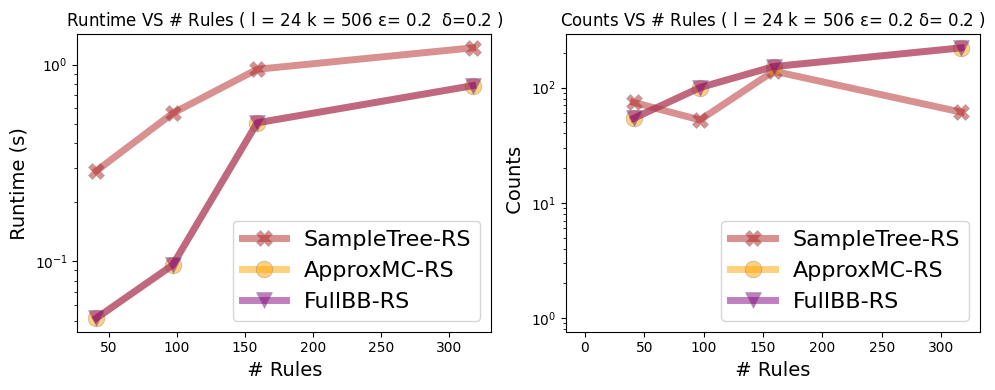

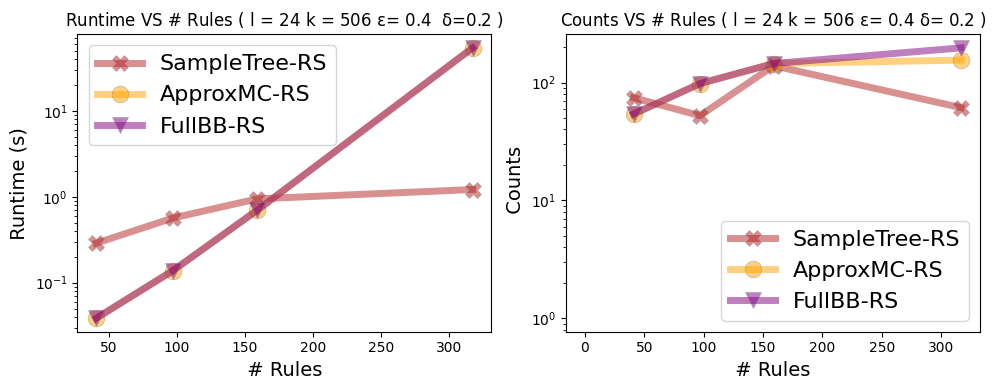

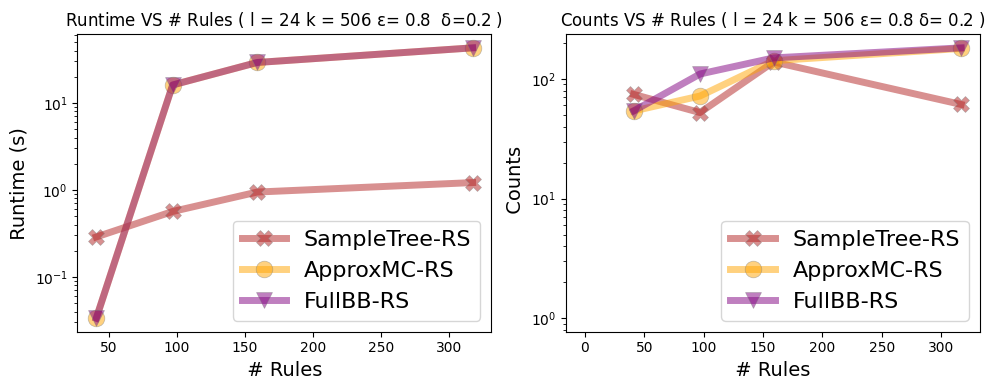

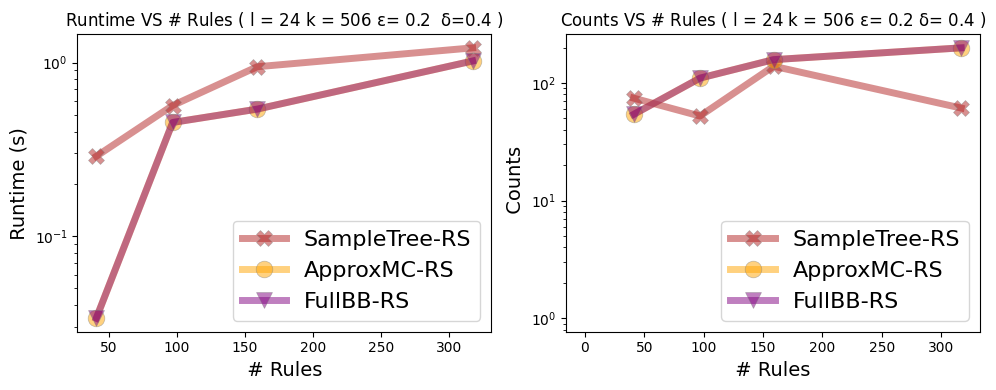

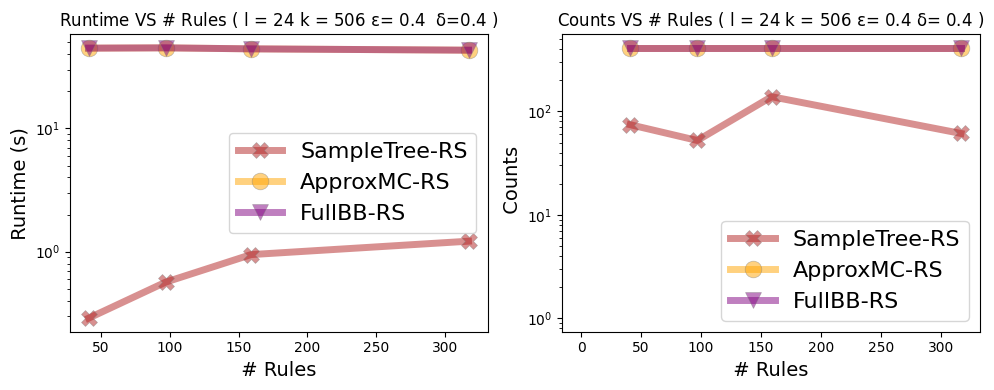

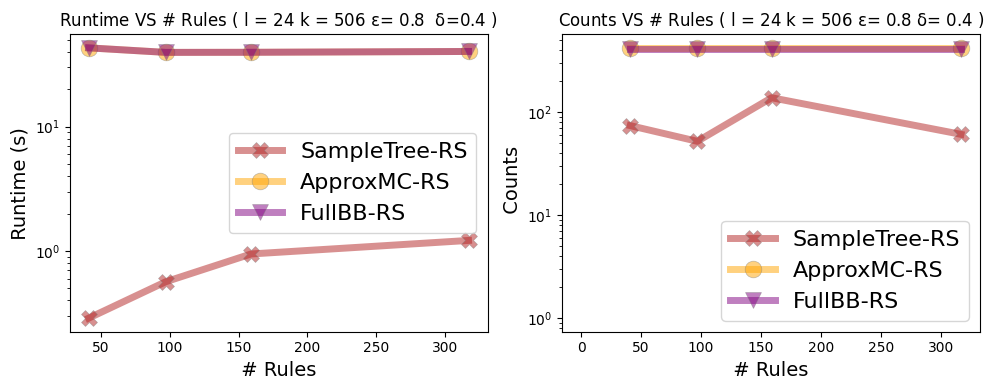

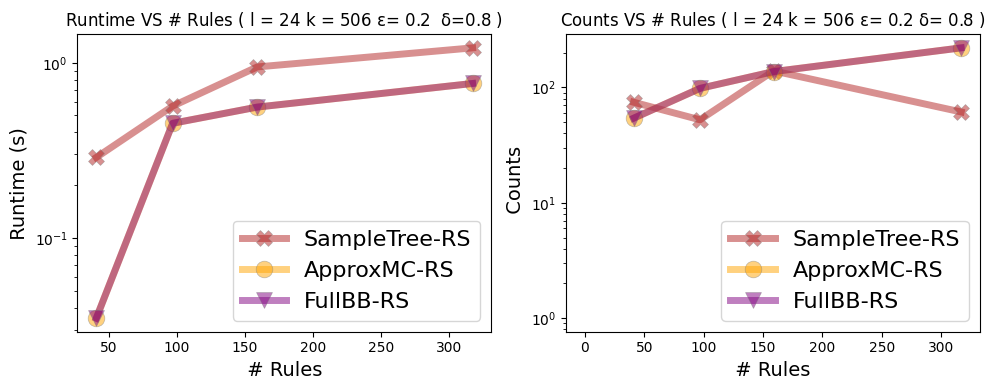

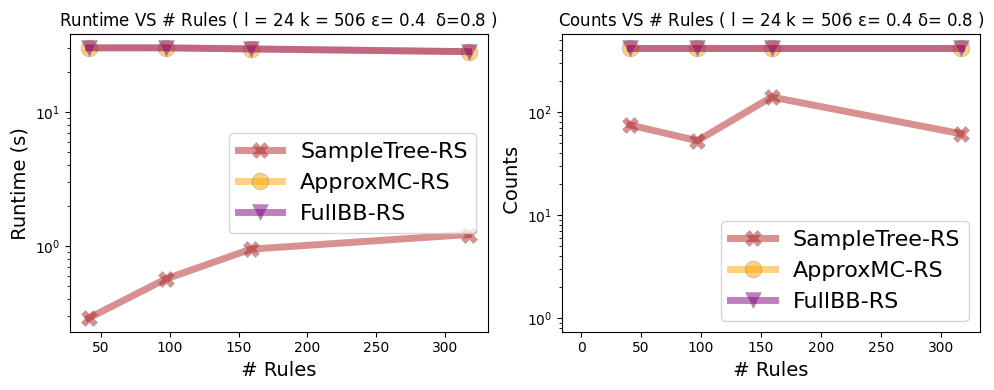

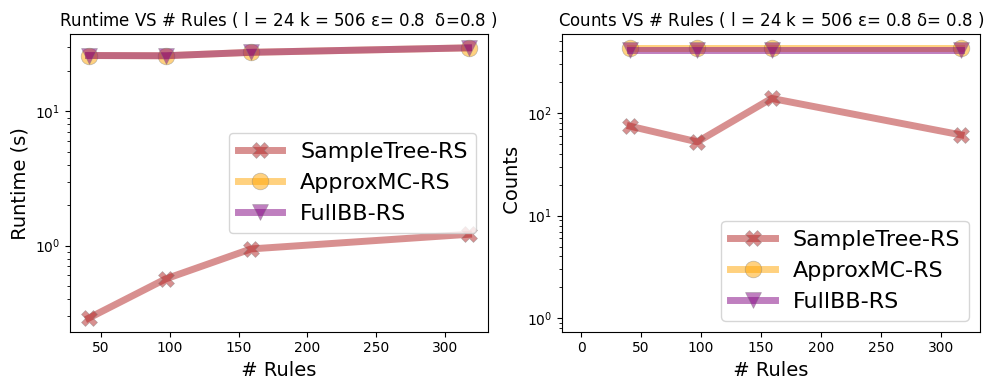

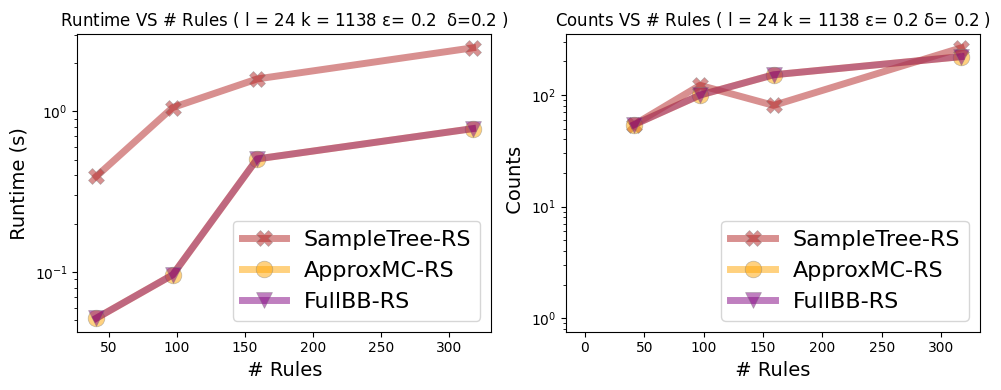

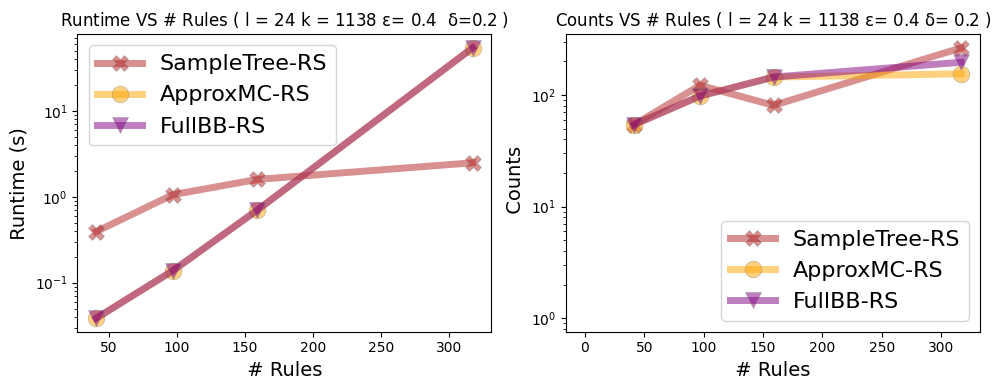

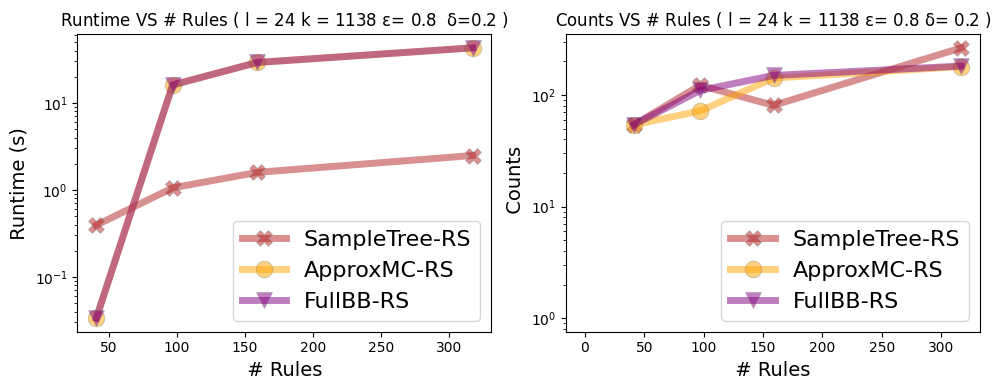

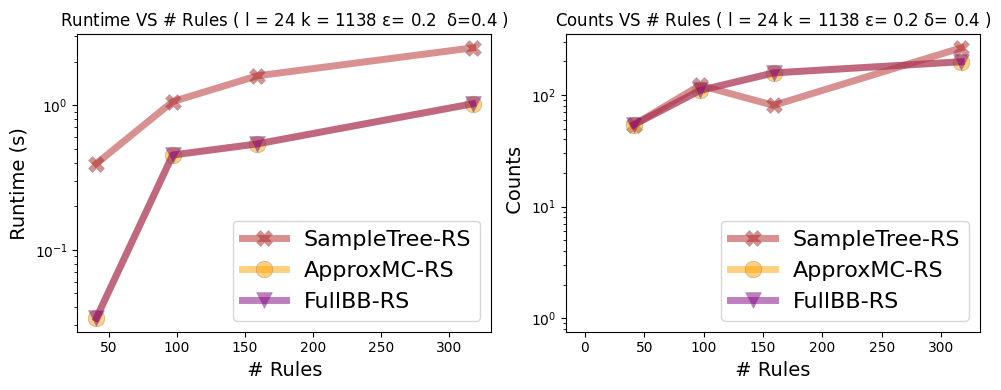

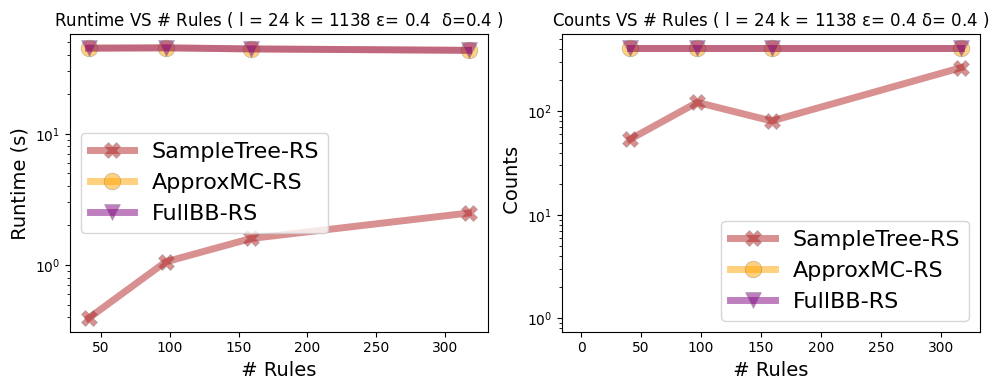

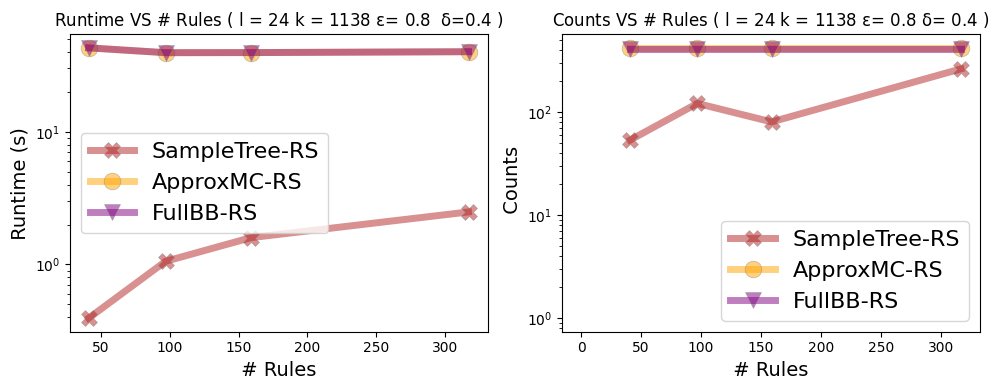

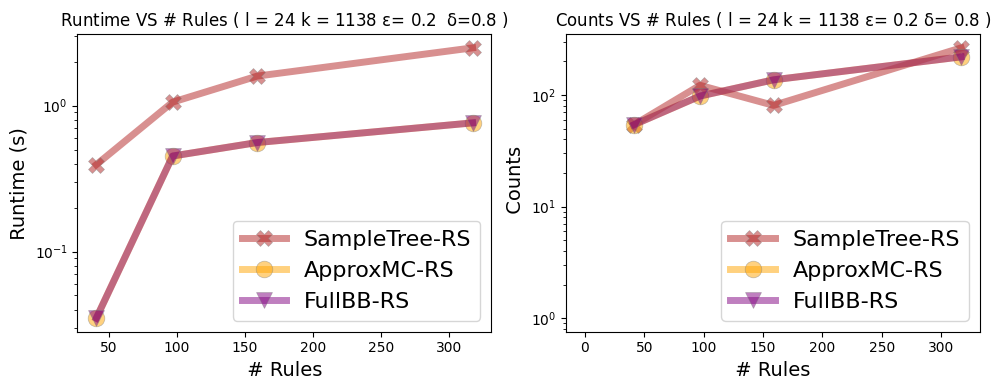

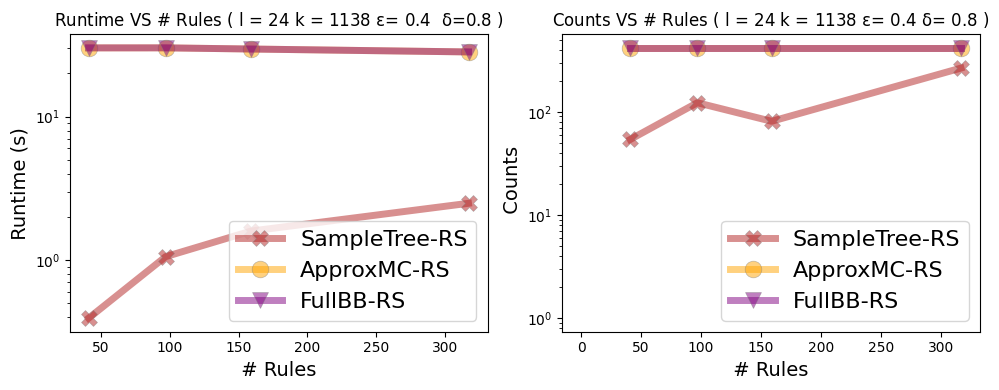

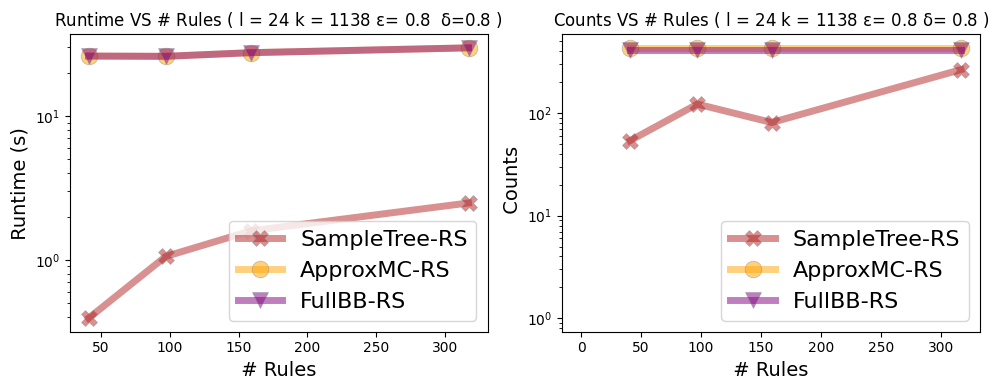

In [29]:
for l in [4, 12, 16, 24]:
    for k in [225, 506, 1138]:
        #
        for delta in [0.2, 0.4, 0.8]:
            for eps in [0.2, 0.4, 0.8]:
                #
                #
                times = read_pickle(
                    "times_by_rules_"
                    + dataset
                    + "_"
                    + str(n_rules)
                    + "_"
                    + str(l)
                    + "_"
                    + str(k)
                )[0]
                counts = read_pickle(
                    "counts_by_rules_"
                    + dataset
                    + "_"
                    + str(n_rules)
                    + "_"
                    + str(l)
                    + "_"
                    + str(k)
                )[0]

                times_MC = []
                counts_MC = []

                times_GT = []
                counts_GT = []

                # for n_rules in all_n_rules:

                times_MC = read_pickle(
                    "all_averages_times_MC_"
                    + dataset
                    + "_"
                    + str(n_rules)
                    + "_"
                    + str(eps)
                    + "_"
                    + str(delta)
                )[0]

                # "times_MC.append(this_times_MC[0])

                cnts_MC = read_pickle(
                    "all_averages_counts_MC_"
                    + dataset
                    + "__"
                    + str(n_rules)
                    + "_"
                    + str(eps)
                    + "_"
                    + str(delta)
                )[0]

                # counts_MC.append(this_cnts_MC[0])

                times_GT = read_pickle(
                    "all_averages_times_GT_"
                    + dataset
                    + "_"
                    + str(n_rules)
                    + "_"
                    + str(eps)
                    + "_"
                    + str(delta)
                )[0]

                #   times_GT.append(this_times_GT[0])

                cnts_GT = read_pickle(
                    "all_averages_counts_GT_"
                    + dataset
                    + "_"
                    + str(n_rules)
                    + "_"
                    + str(eps)
                    + "_"
                    + str(delta)
                )[0]

                # plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
                mpl.rcParams["axes.facecolor"] = "white"
                mpl.rcParams["grid.color"] = "lightgray"
                mpl.rcParams["mathtext.default"] = "regular"
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
                # Plot the first data on the first subplot
                # ax1.plot([61 , 77, 104], y1, color='red')
                # ax1.set_title('Plot 1')

                # all_n_rules = [61, 77, 104, 151, 262, 312]
                all_n_rules = [41, 97, 159, 317]

                x = all_n_rules

                ax1.plot(
                    x,
                    times,
                    marker="X",
                    color="firebrick",
                    label="SampleTree-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                ax1.plot(
                    x,
                    times_MC,
                    marker="o",
                    color="orange",
                    label="ApproxMC-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                ax1.plot(
                    x,
                    times_GT,
                    marker="v",
                    color="purple",
                    label="FullBB-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                ax1.legend(fontsize=16)

                ax1.set_title(
                    "Runtime VS # Rules ( l = "
                    + str(l)
                    + " k = "
                    + str(k)
                    + " "
                    + r"$\epsilon$= "
                    + str(eps)
                    + " "
                    + r" $\delta$="
                    + str(delta)
                    + " )",
                    fontsize=12,
                )

                ax1.set_xlabel(" # Rules ", fontsize=14)

                ax1.set_ylabel(" Runtime (s) ", fontsize=14)

                ax1.set_yscale("log")  # Set y-axis to logarithmic scale

                ax2.plot(
                    x,
                    counts,
                    marker="X",
                    color="firebrick",
                    label="SampleTree-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                ax2.plot(
                    x,
                    cnts_MC,
                    marker="o",
                    color="orange",
                    label="ApproxMC-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                ax2.plot(
                    x,
                    cnts_GT,
                    marker="v",
                    color="purple",
                    label="FullBB-RS",
                    linewidth=5,
                    markersize=12,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.5,
                )

                ax2.legend(fontsize=16)

                ax2.set_title(
                    "Counts VS # Rules ( l = "
                    + str(l)
                    + " k = "
                    + str(k)
                    + r" $\epsilon$="
                    + " "
                    + str(eps)
                    + r" $\delta$="
                    + " "
                    + str(delta)
                    + " )",
                    fontsize=12,
                )

                ax2.set_xlabel(" # Rules ", fontsize=14)

                ax2.set_ylabel(" Counts", fontsize=14)

                ax2.set_yscale("log")  # Set y-axis to logarithmic scale

                (hB,) = plot(
                    [1, 1],
                    "firebrick",
                    marker="X",
                    linewidth=3,
                    markersize=10,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.8,
                )
                (hHP,) = plot(
                    [1, 1],
                    "orange",
                    marker="o",
                    linewidth=3,
                    markersize=10,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.8,
                )
                (hS,) = plot(
                    [1, 1],
                    "purple",
                    marker="v",
                    linewidth=3,
                    markersize=10,
                    markeredgewidth=0.5,
                    markeredgecolor="grey",
                    alpha=0.8,
                )
                #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
                # legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
                # legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
                hB.set_visible(False)
                hS.set_visible(False)
                hHP.set_visible(False)

                # Adjust spacing between subplots
                plt.tight_layout()

                plt.savefig(
                    "sample_tree_by_rules_"
                    + dataset
                    + "_"
                    + str(l)
                    + "_"
                    + str(k)
                    + "_log.pdf"
                )

                # Display the plots
                plt.show()